# Continuous data generation

In [1]:
import random
import numpy as np
import pandas as pd
import sklearn as sk

In [2]:
# n: sample size; d1: continuous features' dimension;
# x_quant: U([0,1]); xd_quant: "true" generating data of Y
n = 1000
d1 = 3
cuts = ([0,0.333,0.666,1])
replicates = 100
# The true logistic regression parameter is fixed
if d1>0: 
    theta_quant = np.array([[0]*d1]*(len(cuts)-1))
    theta_quant[1,0:(d1-1)] = 2
    theta_quant[2,0:(d1-1)] = -2
    
theta_quant

array([[ 0,  0,  0],
       [ 2,  2,  0],
       [-2, -2,  0]])

In [3]:
def generate_data(seed=0):
    random.seed(seed)
    x_quant = np.array(np.random.uniform(size=(n,d1)))
    xd_quant = np.ndarray.copy(x_quant)
    # x_quant is cut in thirds into xd_quant
    for i in range(d1):
        xd_quant[:,i] = pd.cut(x_quant[:,i],bins=cuts,labels=[0,1,2])
# The log odd probabilities of Y given each x_i can be exactly calculated
    log_odd = np.array([0]*n)
    for i in range(n):
        for j in range(d1):
            log_odd[i] += theta_quant[int(xd_quant[i,j]),j]
# Y is then drawn from this pdf
    p = 1/(1+np.exp(-log_odd))
    y = np.random.binomial(1,p)

    return([x_quant,y])

# Neural network architecture

In [4]:
# We rely on Keras for all calculations and the TensorFlow backend.
import tensorflow as tf
config = tf.ConfigProto()
sess = tf.Session(config=config)
from keras import backend as K
K.set_session(sess)

Using TensorFlow backend.


In [5]:
from keras import *
from keras.layers import *
from keras.callbacks import LambdaCallback, Callback, ReduceLROnPlateau , TensorBoard
import sklearn.linear_model    

In [6]:
m_quant = [3,3,3]

def initialize_neural_net():
    liste_inputs_quant = [None]*d1
    liste_layers_quant = [None]*d1
    liste_layers_quant_inputs = [None]*d1


    for i in range(d1):
        liste_inputs_quant[i] = Input((1,))
        liste_layers_quant[i] = Dense(m_quant[i],activation ='softmax')
        liste_layers_quant_inputs[i] = liste_layers_quant[i](liste_inputs_quant[i])

    return([liste_inputs_quant,liste_layers_quant,liste_layers_quant_inputs])

In [7]:
def evaluate_disc(prob=[]):
        
    results = [None]*d1
    
    X_transformed = np.ones((n,1))

    for j in range(d1):
        results[j] = np.argmax(prob[j][0],axis=1)
        X_transformed = np.concatenate((X_transformed,sk.preprocessing.OneHotEncoder(categories='auto',sparse=False,handle_unknown="ignore").fit_transform(X=results[j].reshape(-1, 1))),axis=1)
        
    proposed_logistic_regression = sk.linear_model.LogisticRegression(fit_intercept=False, solver = "lbfgs", C=1e20, tol=1e-8, max_iter = 50)
    
    proposed_logistic_regression.fit(X=X_transformed,y=y.reshape((n,)))
    
    BIC_training = 2*sk.metrics.log_loss(y, proposed_logistic_regression.predict_proba(X=X_transformed)[:,1],normalize=False) + proposed_logistic_regression.coef_.shape[1]*np.log(n)
    
    return(BIC_training)

In [8]:
class LossHistory(Callback):

    def on_train_begin(self, logs={}):
        self.losses = []
        self.best_criterion = float("inf")
        self.best_outputs = []

    def on_epoch_end(self, batch, logs={}):
        
        outputs = []
        
        for j in range(d1):
            outputs.append(K.function([liste_layers_quant[j].input],[liste_layers_quant[j].output])([x_quant[:,j,np.newaxis]]))

        self.losses.append(evaluate_disc(prob = outputs))
        
        if self.losses[-1] < self.best_criterion:
            self.best_outputs = outputs
            self.best_criterion = self.losses[-1]

# Results

## Discretization of each continuous feature

In [9]:
from itertools import chain
import pandas as pd

In [10]:
results = []

for rep in range(replicates):

    # Simulate data
    x_quant, y = generate_data(seed=rep+100)
    
    # Set up a new model
    
    liste_inputs_quant, liste_layers_quant,liste_layers_quant_inputs = initialize_neural_net()
    output = Dense(1,activation='sigmoid')(concatenate(liste_layers_quant_inputs))
    model = Model(inputs = liste_inputs_quant,outputs = [output])
    #opt = optimizers.Adadelta(lr=6.0, rho=0.98, epsilon=None, decay=0.0)
    #opt = optimizers.SGD(lr=0.1, momentum=0.0, decay=0.0, nesterov=False)
    opt = optimizers.RMSprop(lr = 0.10)
    model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])
    
    # Train the model
    history = LossHistory()
    callbacks = [ReduceLROnPlateau(monitor='loss', factor=0.5, patience=10, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0),history]
    model.fit(list(x_quant.T),y,epochs=500, batch_size=32, verbose=2, callbacks = callbacks)

    # Get the best outputs
    results.append([])
    for j in range(d1):
        df = pd.DataFrame(np.column_stack((x_quant[:,j],np.argmax(history.best_outputs[j][0],axis=1))),columns=['continuous','discrete'])
        grouped_data = df.groupby('discrete', as_index=False)['continuous']
        results[rep].append([grouped_data.max(),grouped_data.min()])
    
    K.clear_session()

Epoch 1/500
 - 0s - loss: 0.7079 - acc: 0.5110
Epoch 2/500
 - 0s - loss: 0.6619 - acc: 0.6130
Epoch 3/500
 - 0s - loss: 0.6278 - acc: 0.6690
Epoch 4/500
 - 0s - loss: 0.6237 - acc: 0.6610
Epoch 5/500
 - 0s - loss: 0.6110 - acc: 0.6760
Epoch 6/500
 - 0s - loss: 0.5855 - acc: 0.7280
Epoch 7/500
 - 0s - loss: 0.5901 - acc: 0.7050
Epoch 8/500
 - 0s - loss: 0.5820 - acc: 0.7210
Epoch 9/500
 - 0s - loss: 0.5652 - acc: 0.7300
Epoch 10/500
 - 0s - loss: 0.5523 - acc: 0.7290
Epoch 11/500
 - 0s - loss: 0.5439 - acc: 0.7390
Epoch 12/500
 - 0s - loss: 0.5338 - acc: 0.7320
Epoch 13/500
 - 0s - loss: 0.5353 - acc: 0.7420
Epoch 14/500
 - 0s - loss: 0.5227 - acc: 0.7480
Epoch 15/500
 - 0s - loss: 0.5210 - acc: 0.7510
Epoch 16/500
 - 0s - loss: 0.5265 - acc: 0.7430
Epoch 17/500
 - 0s - loss: 0.5131 - acc: 0.7590
Epoch 18/500
 - 0s - loss: 0.5284 - acc: 0.7410
Epoch 19/500
 - 0s - loss: 0.5078 - acc: 0.7440
Epoch 20/500
 - 0s - loss: 0.5008 - acc: 0.7560
Epoch 21/500
 - 0s - loss: 0.5081 - acc: 0.7430
E

Epoch 171/500
 - 0s - loss: 0.4614 - acc: 0.7670
Epoch 172/500
 - 0s - loss: 0.4614 - acc: 0.7670
Epoch 173/500
 - 0s - loss: 0.4615 - acc: 0.7670
Epoch 174/500
 - 0s - loss: 0.4614 - acc: 0.7660
Epoch 175/500
 - 0s - loss: 0.4615 - acc: 0.7660
Epoch 176/500
 - 0s - loss: 0.4615 - acc: 0.7650
Epoch 177/500
 - 0s - loss: 0.4614 - acc: 0.7660
Epoch 178/500
 - 0s - loss: 0.4614 - acc: 0.7660
Epoch 179/500
 - 0s - loss: 0.4614 - acc: 0.7660
Epoch 180/500
 - 0s - loss: 0.4614 - acc: 0.7660
Epoch 181/500
 - 0s - loss: 0.4614 - acc: 0.7660
Epoch 182/500
 - 0s - loss: 0.4614 - acc: 0.7660
Epoch 183/500
 - 0s - loss: 0.4614 - acc: 0.7660
Epoch 184/500
 - 0s - loss: 0.4614 - acc: 0.7660
Epoch 185/500
 - 0s - loss: 0.4614 - acc: 0.7660
Epoch 186/500
 - 0s - loss: 0.4614 - acc: 0.7660
Epoch 187/500
 - 0s - loss: 0.4614 - acc: 0.7660
Epoch 188/500
 - 0s - loss: 0.4614 - acc: 0.7660
Epoch 189/500
 - 0s - loss: 0.4614 - acc: 0.7660
Epoch 190/500
 - 0s - loss: 0.4614 - acc: 0.7660
Epoch 191/500
 - 0s 

Epoch 339/500
 - 0s - loss: 0.4614 - acc: 0.7660
Epoch 340/500
 - 0s - loss: 0.4614 - acc: 0.7660
Epoch 341/500
 - 0s - loss: 0.4614 - acc: 0.7660
Epoch 342/500
 - 0s - loss: 0.4614 - acc: 0.7660
Epoch 343/500
 - 0s - loss: 0.4614 - acc: 0.7660
Epoch 344/500
 - 0s - loss: 0.4614 - acc: 0.7660
Epoch 345/500
 - 0s - loss: 0.4614 - acc: 0.7660
Epoch 346/500
 - 0s - loss: 0.4614 - acc: 0.7660
Epoch 347/500
 - 0s - loss: 0.4614 - acc: 0.7660
Epoch 348/500
 - 0s - loss: 0.4614 - acc: 0.7660
Epoch 349/500
 - 0s - loss: 0.4614 - acc: 0.7660
Epoch 350/500
 - 0s - loss: 0.4614 - acc: 0.7660
Epoch 351/500
 - 0s - loss: 0.4614 - acc: 0.7660
Epoch 352/500
 - 0s - loss: 0.4614 - acc: 0.7660
Epoch 353/500
 - 0s - loss: 0.4614 - acc: 0.7660
Epoch 354/500
 - 0s - loss: 0.4614 - acc: 0.7660
Epoch 355/500
 - 0s - loss: 0.4614 - acc: 0.7660
Epoch 356/500
 - 0s - loss: 0.4614 - acc: 0.7660
Epoch 357/500
 - 0s - loss: 0.4614 - acc: 0.7660
Epoch 358/500
 - 0s - loss: 0.4614 - acc: 0.7660
Epoch 359/500
 - 0s 

Epoch 7/500
 - 0s - loss: 0.6214 - acc: 0.6870
Epoch 8/500
 - 0s - loss: 0.6053 - acc: 0.6970
Epoch 9/500
 - 0s - loss: 0.6090 - acc: 0.7010
Epoch 10/500
 - 0s - loss: 0.5943 - acc: 0.7000
Epoch 11/500
 - 0s - loss: 0.5883 - acc: 0.7070
Epoch 12/500
 - 0s - loss: 0.5678 - acc: 0.7220
Epoch 13/500
 - 0s - loss: 0.5611 - acc: 0.7080
Epoch 14/500
 - 0s - loss: 0.5706 - acc: 0.7120
Epoch 15/500
 - 0s - loss: 0.5601 - acc: 0.7230
Epoch 16/500
 - 0s - loss: 0.5554 - acc: 0.7270
Epoch 17/500
 - 0s - loss: 0.5589 - acc: 0.7160
Epoch 18/500
 - 0s - loss: 0.5463 - acc: 0.7270
Epoch 19/500
 - 0s - loss: 0.5456 - acc: 0.7240
Epoch 20/500
 - 0s - loss: 0.5552 - acc: 0.7040
Epoch 21/500
 - 0s - loss: 0.5463 - acc: 0.7220
Epoch 22/500
 - 0s - loss: 0.5321 - acc: 0.7350
Epoch 23/500
 - 0s - loss: 0.5446 - acc: 0.7390
Epoch 24/500
 - 0s - loss: 0.5332 - acc: 0.7280
Epoch 25/500
 - 0s - loss: 0.5340 - acc: 0.7380
Epoch 26/500
 - 0s - loss: 0.5284 - acc: 0.7430
Epoch 27/500
 - 0s - loss: 0.5171 - acc: 0.

 - 0s - loss: 0.4736 - acc: 0.7620
Epoch 177/500
 - 0s - loss: 0.4736 - acc: 0.7640
Epoch 178/500
 - 0s - loss: 0.4735 - acc: 0.7640
Epoch 179/500
 - 0s - loss: 0.4735 - acc: 0.7620
Epoch 180/500
 - 0s - loss: 0.4735 - acc: 0.7640
Epoch 181/500
 - 0s - loss: 0.4735 - acc: 0.7630
Epoch 182/500
 - 0s - loss: 0.4735 - acc: 0.7640
Epoch 183/500
 - 0s - loss: 0.4735 - acc: 0.7640
Epoch 184/500
 - 0s - loss: 0.4735 - acc: 0.7640
Epoch 185/500
 - 0s - loss: 0.4735 - acc: 0.7640
Epoch 186/500
 - 0s - loss: 0.4735 - acc: 0.7640
Epoch 187/500
 - 0s - loss: 0.4735 - acc: 0.7640
Epoch 188/500
 - 0s - loss: 0.4735 - acc: 0.7640
Epoch 189/500
 - 0s - loss: 0.4735 - acc: 0.7640
Epoch 190/500
 - 0s - loss: 0.4734 - acc: 0.7640
Epoch 191/500
 - 0s - loss: 0.4734 - acc: 0.7640
Epoch 192/500
 - 0s - loss: 0.4734 - acc: 0.7640
Epoch 193/500
 - 0s - loss: 0.4734 - acc: 0.7640
Epoch 194/500
 - 0s - loss: 0.4734 - acc: 0.7640
Epoch 195/500
 - 0s - loss: 0.4734 - acc: 0.7640
Epoch 196/500
 - 0s - loss: 0.4734

Epoch 344/500
 - 0s - loss: 0.4734 - acc: 0.7640
Epoch 345/500
 - 0s - loss: 0.4734 - acc: 0.7640
Epoch 346/500
 - 0s - loss: 0.4734 - acc: 0.7640
Epoch 347/500
 - 0s - loss: 0.4734 - acc: 0.7640
Epoch 348/500
 - 0s - loss: 0.4734 - acc: 0.7640
Epoch 349/500
 - 0s - loss: 0.4734 - acc: 0.7640
Epoch 350/500
 - 0s - loss: 0.4734 - acc: 0.7640
Epoch 351/500
 - 0s - loss: 0.4734 - acc: 0.7640
Epoch 352/500
 - 0s - loss: 0.4734 - acc: 0.7640
Epoch 353/500
 - 0s - loss: 0.4734 - acc: 0.7640
Epoch 354/500
 - 0s - loss: 0.4734 - acc: 0.7640
Epoch 355/500
 - 0s - loss: 0.4734 - acc: 0.7640
Epoch 356/500
 - 0s - loss: 0.4734 - acc: 0.7640
Epoch 357/500
 - 0s - loss: 0.4734 - acc: 0.7640
Epoch 358/500
 - 0s - loss: 0.4734 - acc: 0.7640
Epoch 359/500
 - 0s - loss: 0.4734 - acc: 0.7640
Epoch 360/500
 - 0s - loss: 0.4734 - acc: 0.7640
Epoch 361/500
 - 0s - loss: 0.4734 - acc: 0.7640
Epoch 362/500
 - 0s - loss: 0.4734 - acc: 0.7640
Epoch 363/500
 - 0s - loss: 0.4734 - acc: 0.7640
Epoch 364/500
 - 0s 

Epoch 12/500
 - 0s - loss: 0.5894 - acc: 0.7220
Epoch 13/500
 - 0s - loss: 0.5833 - acc: 0.7040
Epoch 14/500
 - 0s - loss: 0.5890 - acc: 0.7100
Epoch 15/500
 - 0s - loss: 0.5921 - acc: 0.7040
Epoch 16/500
 - 0s - loss: 0.5728 - acc: 0.7160
Epoch 17/500
 - 0s - loss: 0.5659 - acc: 0.7200
Epoch 18/500
 - 0s - loss: 0.5502 - acc: 0.7260
Epoch 19/500
 - 0s - loss: 0.5534 - acc: 0.7250
Epoch 20/500
 - 0s - loss: 0.5383 - acc: 0.7290
Epoch 21/500
 - 0s - loss: 0.5311 - acc: 0.7270
Epoch 22/500
 - 0s - loss: 0.5280 - acc: 0.7280
Epoch 23/500
 - 0s - loss: 0.5260 - acc: 0.7260
Epoch 24/500
 - 0s - loss: 0.5229 - acc: 0.7270
Epoch 25/500
 - 0s - loss: 0.5133 - acc: 0.7420
Epoch 26/500
 - 0s - loss: 0.5274 - acc: 0.7290
Epoch 27/500
 - 0s - loss: 0.5235 - acc: 0.7350
Epoch 28/500
 - 0s - loss: 0.5200 - acc: 0.7310
Epoch 29/500
 - 0s - loss: 0.5239 - acc: 0.7210
Epoch 30/500
 - 0s - loss: 0.5117 - acc: 0.7360
Epoch 31/500
 - 0s - loss: 0.5226 - acc: 0.7390
Epoch 32/500
 - 0s - loss: 0.5037 - acc:

Epoch 181/500
 - 0s - loss: 0.4700 - acc: 0.7480
Epoch 182/500
 - 0s - loss: 0.4701 - acc: 0.7490
Epoch 183/500
 - 0s - loss: 0.4700 - acc: 0.7490
Epoch 184/500
 - 0s - loss: 0.4700 - acc: 0.7480
Epoch 185/500
 - 0s - loss: 0.4700 - acc: 0.7490
Epoch 186/500
 - 0s - loss: 0.4700 - acc: 0.7490
Epoch 187/500
 - 0s - loss: 0.4700 - acc: 0.7490
Epoch 188/500
 - 0s - loss: 0.4700 - acc: 0.7480
Epoch 189/500
 - 0s - loss: 0.4700 - acc: 0.7490
Epoch 190/500
 - 0s - loss: 0.4700 - acc: 0.7480
Epoch 191/500
 - 0s - loss: 0.4700 - acc: 0.7480
Epoch 192/500
 - 0s - loss: 0.4700 - acc: 0.7500
Epoch 193/500
 - 0s - loss: 0.4699 - acc: 0.7490
Epoch 194/500
 - 0s - loss: 0.4699 - acc: 0.7490
Epoch 195/500
 - 0s - loss: 0.4699 - acc: 0.7490
Epoch 196/500
 - 0s - loss: 0.4699 - acc: 0.7490
Epoch 197/500
 - 0s - loss: 0.4699 - acc: 0.7490
Epoch 198/500
 - 0s - loss: 0.4699 - acc: 0.7490
Epoch 199/500
 - 0s - loss: 0.4699 - acc: 0.7490
Epoch 200/500
 - 0s - loss: 0.4699 - acc: 0.7490
Epoch 201/500
 - 0s 

 - 0s - loss: 0.4699 - acc: 0.7490
Epoch 349/500
 - 0s - loss: 0.4699 - acc: 0.7490
Epoch 350/500
 - 0s - loss: 0.4699 - acc: 0.7490
Epoch 351/500
 - 0s - loss: 0.4699 - acc: 0.7490
Epoch 352/500
 - 0s - loss: 0.4699 - acc: 0.7490
Epoch 353/500
 - 0s - loss: 0.4699 - acc: 0.7490
Epoch 354/500
 - 0s - loss: 0.4699 - acc: 0.7490
Epoch 355/500
 - 0s - loss: 0.4699 - acc: 0.7490
Epoch 356/500
 - 0s - loss: 0.4699 - acc: 0.7490
Epoch 357/500
 - 0s - loss: 0.4699 - acc: 0.7490
Epoch 358/500
 - 0s - loss: 0.4699 - acc: 0.7490
Epoch 359/500
 - 0s - loss: 0.4699 - acc: 0.7490
Epoch 360/500
 - 0s - loss: 0.4699 - acc: 0.7490
Epoch 361/500
 - 0s - loss: 0.4699 - acc: 0.7490
Epoch 362/500
 - 0s - loss: 0.4699 - acc: 0.7490
Epoch 363/500
 - 0s - loss: 0.4699 - acc: 0.7490
Epoch 364/500
 - 0s - loss: 0.4699 - acc: 0.7490
Epoch 365/500
 - 0s - loss: 0.4699 - acc: 0.7490
Epoch 366/500
 - 0s - loss: 0.4699 - acc: 0.7490
Epoch 367/500
 - 0s - loss: 0.4699 - acc: 0.7490
Epoch 368/500
 - 0s - loss: 0.4699

Epoch 16/500
 - 0s - loss: 0.5161 - acc: 0.7410
Epoch 17/500
 - 0s - loss: 0.5189 - acc: 0.7330
Epoch 18/500
 - 0s - loss: 0.4954 - acc: 0.7410
Epoch 19/500
 - 0s - loss: 0.5030 - acc: 0.7470
Epoch 20/500
 - 0s - loss: 0.5128 - acc: 0.7570
Epoch 21/500
 - 0s - loss: 0.5009 - acc: 0.7520
Epoch 22/500
 - 0s - loss: 0.4845 - acc: 0.7560
Epoch 23/500
 - 0s - loss: 0.4974 - acc: 0.7450
Epoch 24/500
 - 0s - loss: 0.4830 - acc: 0.7550
Epoch 25/500
 - 0s - loss: 0.4932 - acc: 0.7490
Epoch 26/500
 - 0s - loss: 0.4776 - acc: 0.7730
Epoch 27/500
 - 0s - loss: 0.4981 - acc: 0.7650
Epoch 28/500
 - 0s - loss: 0.4867 - acc: 0.7550
Epoch 29/500
 - 0s - loss: 0.4872 - acc: 0.7560
Epoch 30/500
 - 0s - loss: 0.4810 - acc: 0.7610
Epoch 31/500
 - 0s - loss: 0.4994 - acc: 0.7540
Epoch 32/500
 - 0s - loss: 0.4848 - acc: 0.7410
Epoch 33/500
 - 0s - loss: 0.4914 - acc: 0.7550
Epoch 34/500
 - 0s - loss: 0.4960 - acc: 0.7590
Epoch 35/500
 - 0s - loss: 0.4866 - acc: 0.7640
Epoch 36/500
 - 0s - loss: 0.4755 - acc:

Epoch 185/500
 - 0s - loss: 0.4426 - acc: 0.7740
Epoch 186/500
 - 0s - loss: 0.4426 - acc: 0.7730
Epoch 187/500
 - 0s - loss: 0.4426 - acc: 0.7730
Epoch 188/500
 - 0s - loss: 0.4426 - acc: 0.7740
Epoch 189/500
 - 0s - loss: 0.4426 - acc: 0.7730
Epoch 190/500
 - 0s - loss: 0.4426 - acc: 0.7730
Epoch 191/500
 - 0s - loss: 0.4426 - acc: 0.7730
Epoch 192/500
 - 0s - loss: 0.4426 - acc: 0.7730
Epoch 193/500
 - 0s - loss: 0.4425 - acc: 0.7730
Epoch 194/500
 - 0s - loss: 0.4425 - acc: 0.7730
Epoch 195/500
 - 0s - loss: 0.4425 - acc: 0.7730
Epoch 196/500
 - 0s - loss: 0.4425 - acc: 0.7730
Epoch 197/500
 - 0s - loss: 0.4425 - acc: 0.7730
Epoch 198/500
 - 0s - loss: 0.4425 - acc: 0.7730
Epoch 199/500
 - 0s - loss: 0.4425 - acc: 0.7730
Epoch 200/500
 - 0s - loss: 0.4425 - acc: 0.7730
Epoch 201/500
 - 0s - loss: 0.4425 - acc: 0.7730
Epoch 202/500
 - 0s - loss: 0.4425 - acc: 0.7730
Epoch 203/500
 - 0s - loss: 0.4425 - acc: 0.7740
Epoch 204/500
 - 0s - loss: 0.4425 - acc: 0.7730
Epoch 205/500
 - 0s 

 - 0s - loss: 0.4424 - acc: 0.7730
Epoch 353/500
 - 0s - loss: 0.4424 - acc: 0.7730
Epoch 354/500
 - 0s - loss: 0.4424 - acc: 0.7730
Epoch 355/500
 - 0s - loss: 0.4424 - acc: 0.7730
Epoch 356/500
 - 0s - loss: 0.4424 - acc: 0.7730
Epoch 357/500
 - 0s - loss: 0.4424 - acc: 0.7730
Epoch 358/500
 - 0s - loss: 0.4424 - acc: 0.7730
Epoch 359/500
 - 0s - loss: 0.4424 - acc: 0.7730
Epoch 360/500
 - 0s - loss: 0.4424 - acc: 0.7730
Epoch 361/500
 - 0s - loss: 0.4424 - acc: 0.7730
Epoch 362/500
 - 0s - loss: 0.4424 - acc: 0.7730
Epoch 363/500
 - 0s - loss: 0.4424 - acc: 0.7730
Epoch 364/500
 - 0s - loss: 0.4424 - acc: 0.7730
Epoch 365/500
 - 0s - loss: 0.4424 - acc: 0.7730
Epoch 366/500
 - 0s - loss: 0.4424 - acc: 0.7730
Epoch 367/500
 - 0s - loss: 0.4424 - acc: 0.7730
Epoch 368/500
 - 0s - loss: 0.4424 - acc: 0.7730
Epoch 369/500
 - 0s - loss: 0.4424 - acc: 0.7730
Epoch 370/500
 - 0s - loss: 0.4424 - acc: 0.7730
Epoch 371/500
 - 0s - loss: 0.4424 - acc: 0.7730
Epoch 372/500
 - 0s - loss: 0.4424

Epoch 21/500
 - 0s - loss: 0.5167 - acc: 0.7330
Epoch 22/500
 - 0s - loss: 0.5226 - acc: 0.7440
Epoch 23/500
 - 0s - loss: 0.5137 - acc: 0.7440
Epoch 24/500
 - 0s - loss: 0.5014 - acc: 0.7450
Epoch 25/500
 - 0s - loss: 0.5271 - acc: 0.7270
Epoch 26/500
 - 0s - loss: 0.5307 - acc: 0.7210
Epoch 27/500
 - 0s - loss: 0.5117 - acc: 0.7350
Epoch 28/500
 - 0s - loss: 0.5083 - acc: 0.7450
Epoch 29/500
 - 0s - loss: 0.5108 - acc: 0.7390
Epoch 30/500
 - 0s - loss: 0.5030 - acc: 0.7430
Epoch 31/500
 - 0s - loss: 0.5181 - acc: 0.7290
Epoch 32/500
 - 0s - loss: 0.5047 - acc: 0.7290
Epoch 33/500
 - 0s - loss: 0.4981 - acc: 0.7480
Epoch 34/500
 - 0s - loss: 0.5061 - acc: 0.7470
Epoch 35/500
 - 0s - loss: 0.5051 - acc: 0.7400
Epoch 36/500
 - 0s - loss: 0.4932 - acc: 0.7480
Epoch 37/500
 - 0s - loss: 0.5075 - acc: 0.7430
Epoch 38/500
 - 0s - loss: 0.5015 - acc: 0.7390
Epoch 39/500
 - 0s - loss: 0.4982 - acc: 0.7350
Epoch 40/500
 - 0s - loss: 0.4866 - acc: 0.7530
Epoch 41/500
 - 0s - loss: 0.5021 - acc:

Epoch 190/500
 - 0s - loss: 0.4574 - acc: 0.7660
Epoch 191/500
 - 0s - loss: 0.4573 - acc: 0.7650
Epoch 192/500
 - 0s - loss: 0.4574 - acc: 0.7650
Epoch 193/500
 - 0s - loss: 0.4573 - acc: 0.7660
Epoch 194/500
 - 0s - loss: 0.4574 - acc: 0.7660
Epoch 195/500
 - 0s - loss: 0.4573 - acc: 0.7660
Epoch 196/500
 - 0s - loss: 0.4573 - acc: 0.7660
Epoch 197/500
 - 0s - loss: 0.4573 - acc: 0.7660
Epoch 198/500
 - 0s - loss: 0.4573 - acc: 0.7660
Epoch 199/500
 - 0s - loss: 0.4574 - acc: 0.7660
Epoch 200/500
 - 0s - loss: 0.4573 - acc: 0.7660
Epoch 201/500
 - 0s - loss: 0.4573 - acc: 0.7660
Epoch 202/500
 - 0s - loss: 0.4573 - acc: 0.7660
Epoch 203/500
 - 0s - loss: 0.4573 - acc: 0.7660
Epoch 204/500
 - 0s - loss: 0.4573 - acc: 0.7660
Epoch 205/500
 - 0s - loss: 0.4573 - acc: 0.7660
Epoch 206/500
 - 0s - loss: 0.4573 - acc: 0.7660
Epoch 207/500
 - 0s - loss: 0.4573 - acc: 0.7660
Epoch 208/500
 - 0s - loss: 0.4573 - acc: 0.7660
Epoch 209/500
 - 0s - loss: 0.4573 - acc: 0.7660
Epoch 210/500
 - 0s 

 - 0s - loss: 0.4573 - acc: 0.7660
Epoch 358/500
 - 0s - loss: 0.4573 - acc: 0.7660
Epoch 359/500
 - 0s - loss: 0.4573 - acc: 0.7660
Epoch 360/500
 - 0s - loss: 0.4573 - acc: 0.7660
Epoch 361/500
 - 0s - loss: 0.4573 - acc: 0.7660
Epoch 362/500
 - 0s - loss: 0.4573 - acc: 0.7660
Epoch 363/500
 - 0s - loss: 0.4573 - acc: 0.7660
Epoch 364/500
 - 0s - loss: 0.4573 - acc: 0.7660
Epoch 365/500
 - 0s - loss: 0.4573 - acc: 0.7660
Epoch 366/500
 - 0s - loss: 0.4573 - acc: 0.7660
Epoch 367/500
 - 0s - loss: 0.4573 - acc: 0.7660
Epoch 368/500
 - 0s - loss: 0.4573 - acc: 0.7660
Epoch 369/500
 - 0s - loss: 0.4573 - acc: 0.7660
Epoch 370/500
 - 0s - loss: 0.4573 - acc: 0.7660
Epoch 371/500
 - 0s - loss: 0.4573 - acc: 0.7660
Epoch 372/500
 - 0s - loss: 0.4573 - acc: 0.7660
Epoch 373/500
 - 0s - loss: 0.4573 - acc: 0.7660
Epoch 374/500
 - 0s - loss: 0.4573 - acc: 0.7660
Epoch 375/500
 - 0s - loss: 0.4573 - acc: 0.7660
Epoch 376/500
 - 0s - loss: 0.4573 - acc: 0.7660
Epoch 377/500
 - 0s - loss: 0.4573

Epoch 26/500
 - 0s - loss: 0.5194 - acc: 0.7520
Epoch 27/500
 - 0s - loss: 0.5170 - acc: 0.7500
Epoch 28/500
 - 0s - loss: 0.5073 - acc: 0.7520
Epoch 29/500
 - 0s - loss: 0.5040 - acc: 0.7440
Epoch 30/500
 - 0s - loss: 0.5133 - acc: 0.7490
Epoch 31/500
 - 0s - loss: 0.5022 - acc: 0.7470
Epoch 32/500
 - 0s - loss: 0.5123 - acc: 0.7380
Epoch 33/500
 - 0s - loss: 0.5085 - acc: 0.7390
Epoch 34/500
 - 0s - loss: 0.5011 - acc: 0.7590
Epoch 35/500
 - 0s - loss: 0.5020 - acc: 0.7450
Epoch 36/500
 - 0s - loss: 0.5019 - acc: 0.7540
Epoch 37/500
 - 0s - loss: 0.4947 - acc: 0.7570
Epoch 38/500
 - 0s - loss: 0.4981 - acc: 0.7500
Epoch 39/500
 - 0s - loss: 0.5021 - acc: 0.7460
Epoch 40/500
 - 0s - loss: 0.4960 - acc: 0.7440
Epoch 41/500
 - 0s - loss: 0.4948 - acc: 0.7550
Epoch 42/500
 - 0s - loss: 0.4977 - acc: 0.7480
Epoch 43/500
 - 0s - loss: 0.4944 - acc: 0.7660
Epoch 44/500
 - 0s - loss: 0.5090 - acc: 0.7530
Epoch 45/500
 - 0s - loss: 0.4900 - acc: 0.7530
Epoch 46/500
 - 0s - loss: 0.4940 - acc:

Epoch 195/500
 - 0s - loss: 0.4572 - acc: 0.7760
Epoch 196/500
 - 0s - loss: 0.4572 - acc: 0.7750
Epoch 197/500
 - 0s - loss: 0.4572 - acc: 0.7760
Epoch 198/500
 - 0s - loss: 0.4572 - acc: 0.7760
Epoch 199/500
 - 0s - loss: 0.4572 - acc: 0.7760
Epoch 200/500
 - 0s - loss: 0.4572 - acc: 0.7760
Epoch 201/500
 - 0s - loss: 0.4572 - acc: 0.7760
Epoch 202/500
 - 0s - loss: 0.4572 - acc: 0.7770
Epoch 203/500
 - 0s - loss: 0.4572 - acc: 0.7760
Epoch 204/500
 - 0s - loss: 0.4572 - acc: 0.7760
Epoch 205/500
 - 0s - loss: 0.4572 - acc: 0.7750
Epoch 206/500
 - 0s - loss: 0.4572 - acc: 0.7760
Epoch 207/500
 - 0s - loss: 0.4572 - acc: 0.7760
Epoch 208/500
 - 0s - loss: 0.4572 - acc: 0.7760
Epoch 209/500
 - 0s - loss: 0.4572 - acc: 0.7760
Epoch 210/500
 - 0s - loss: 0.4572 - acc: 0.7760
Epoch 211/500
 - 0s - loss: 0.4572 - acc: 0.7760
Epoch 212/500
 - 0s - loss: 0.4572 - acc: 0.7760
Epoch 213/500
 - 0s - loss: 0.4572 - acc: 0.7750
Epoch 214/500
 - 0s - loss: 0.4572 - acc: 0.7760
Epoch 215/500
 - 0s 

 - 0s - loss: 0.4572 - acc: 0.7750
Epoch 363/500
 - 0s - loss: 0.4572 - acc: 0.7750
Epoch 364/500
 - 0s - loss: 0.4572 - acc: 0.7750
Epoch 365/500
 - 0s - loss: 0.4572 - acc: 0.7750
Epoch 366/500
 - 0s - loss: 0.4572 - acc: 0.7750
Epoch 367/500
 - 0s - loss: 0.4572 - acc: 0.7750
Epoch 368/500
 - 0s - loss: 0.4572 - acc: 0.7750
Epoch 369/500
 - 0s - loss: 0.4572 - acc: 0.7750
Epoch 370/500
 - 0s - loss: 0.4572 - acc: 0.7750
Epoch 371/500
 - 0s - loss: 0.4572 - acc: 0.7750
Epoch 372/500
 - 0s - loss: 0.4572 - acc: 0.7750
Epoch 373/500
 - 0s - loss: 0.4572 - acc: 0.7750
Epoch 374/500
 - 0s - loss: 0.4572 - acc: 0.7750
Epoch 375/500
 - 0s - loss: 0.4572 - acc: 0.7750
Epoch 376/500
 - 0s - loss: 0.4572 - acc: 0.7750
Epoch 377/500
 - 0s - loss: 0.4572 - acc: 0.7750
Epoch 378/500
 - 0s - loss: 0.4572 - acc: 0.7750
Epoch 379/500
 - 0s - loss: 0.4572 - acc: 0.7750
Epoch 380/500
 - 0s - loss: 0.4572 - acc: 0.7750
Epoch 381/500
 - 0s - loss: 0.4572 - acc: 0.7750
Epoch 382/500
 - 0s - loss: 0.4572

Epoch 31/500
 - 0s - loss: 0.4853 - acc: 0.7540
Epoch 32/500
 - 0s - loss: 0.4955 - acc: 0.7520
Epoch 33/500
 - 0s - loss: 0.4983 - acc: 0.7460
Epoch 34/500
 - 0s - loss: 0.4898 - acc: 0.7550
Epoch 35/500
 - 0s - loss: 0.4813 - acc: 0.7580
Epoch 36/500
 - 0s - loss: 0.4944 - acc: 0.7590
Epoch 37/500
 - 0s - loss: 0.4788 - acc: 0.7520
Epoch 38/500
 - 0s - loss: 0.4962 - acc: 0.7460
Epoch 39/500
 - 0s - loss: 0.4805 - acc: 0.7460
Epoch 40/500
 - 0s - loss: 0.4930 - acc: 0.7520
Epoch 41/500
 - 0s - loss: 0.4844 - acc: 0.7510
Epoch 42/500
 - 0s - loss: 0.4882 - acc: 0.7430
Epoch 43/500
 - 0s - loss: 0.4769 - acc: 0.7570
Epoch 44/500
 - 0s - loss: 0.4923 - acc: 0.7590
Epoch 45/500
 - 0s - loss: 0.4845 - acc: 0.7690
Epoch 46/500
 - 0s - loss: 0.4749 - acc: 0.7710
Epoch 47/500
 - 0s - loss: 0.4739 - acc: 0.7690
Epoch 48/500
 - 0s - loss: 0.4825 - acc: 0.7710
Epoch 49/500
 - 0s - loss: 0.4852 - acc: 0.7570
Epoch 50/500
 - 0s - loss: 0.4839 - acc: 0.7520
Epoch 51/500
 - 0s - loss: 0.4909 - acc:

Epoch 200/500
 - 0s - loss: 0.4462 - acc: 0.7710
Epoch 201/500
 - 0s - loss: 0.4462 - acc: 0.7710
Epoch 202/500
 - 0s - loss: 0.4462 - acc: 0.7710
Epoch 203/500
 - 0s - loss: 0.4462 - acc: 0.7710
Epoch 204/500
 - 0s - loss: 0.4462 - acc: 0.7710
Epoch 205/500
 - 0s - loss: 0.4462 - acc: 0.7720
Epoch 206/500
 - 0s - loss: 0.4462 - acc: 0.7710
Epoch 207/500
 - 0s - loss: 0.4462 - acc: 0.7720
Epoch 208/500
 - 0s - loss: 0.4462 - acc: 0.7710
Epoch 209/500
 - 0s - loss: 0.4462 - acc: 0.7720
Epoch 210/500
 - 0s - loss: 0.4462 - acc: 0.7720
Epoch 211/500
 - 0s - loss: 0.4462 - acc: 0.7710
Epoch 212/500
 - 0s - loss: 0.4462 - acc: 0.7710
Epoch 213/500
 - 0s - loss: 0.4462 - acc: 0.7710
Epoch 214/500
 - 0s - loss: 0.4462 - acc: 0.7710
Epoch 215/500
 - 0s - loss: 0.4462 - acc: 0.7710
Epoch 216/500
 - 0s - loss: 0.4462 - acc: 0.7710
Epoch 217/500
 - 0s - loss: 0.4462 - acc: 0.7710
Epoch 218/500
 - 0s - loss: 0.4462 - acc: 0.7710
Epoch 219/500
 - 0s - loss: 0.4462 - acc: 0.7710
Epoch 220/500
 - 0s 

Epoch 368/500
 - 0s - loss: 0.4462 - acc: 0.7710
Epoch 369/500
 - 0s - loss: 0.4462 - acc: 0.7710
Epoch 370/500
 - 0s - loss: 0.4462 - acc: 0.7710
Epoch 371/500
 - 0s - loss: 0.4462 - acc: 0.7710
Epoch 372/500
 - 0s - loss: 0.4462 - acc: 0.7710
Epoch 373/500
 - 0s - loss: 0.4462 - acc: 0.7710
Epoch 374/500
 - 0s - loss: 0.4462 - acc: 0.7710
Epoch 375/500
 - 0s - loss: 0.4462 - acc: 0.7710
Epoch 376/500
 - 0s - loss: 0.4462 - acc: 0.7710
Epoch 377/500
 - 0s - loss: 0.4462 - acc: 0.7710
Epoch 378/500
 - 0s - loss: 0.4462 - acc: 0.7710
Epoch 379/500
 - 0s - loss: 0.4462 - acc: 0.7710
Epoch 380/500
 - 0s - loss: 0.4462 - acc: 0.7710
Epoch 381/500
 - 0s - loss: 0.4462 - acc: 0.7710
Epoch 382/500
 - 0s - loss: 0.4462 - acc: 0.7710
Epoch 383/500
 - 0s - loss: 0.4462 - acc: 0.7710
Epoch 384/500
 - 0s - loss: 0.4462 - acc: 0.7710
Epoch 385/500
 - 0s - loss: 0.4462 - acc: 0.7710
Epoch 386/500
 - 0s - loss: 0.4462 - acc: 0.7710
Epoch 387/500
 - 0s - loss: 0.4462 - acc: 0.7710
Epoch 388/500
 - 0s 

Epoch 37/500
 - 0s - loss: 0.4794 - acc: 0.7590
Epoch 38/500
 - 0s - loss: 0.4838 - acc: 0.7590
Epoch 39/500
 - 0s - loss: 0.4892 - acc: 0.7560
Epoch 40/500
 - 0s - loss: 0.4890 - acc: 0.7630
Epoch 41/500
 - 0s - loss: 0.4766 - acc: 0.7660
Epoch 42/500
 - 0s - loss: 0.4858 - acc: 0.7770
Epoch 43/500
 - 0s - loss: 0.4845 - acc: 0.7630
Epoch 44/500
 - 0s - loss: 0.4887 - acc: 0.7580
Epoch 45/500
 - 0s - loss: 0.4856 - acc: 0.7670
Epoch 46/500
 - 0s - loss: 0.4764 - acc: 0.7780
Epoch 47/500
 - 0s - loss: 0.4771 - acc: 0.7640
Epoch 48/500
 - 0s - loss: 0.4857 - acc: 0.7640
Epoch 49/500
 - 0s - loss: 0.4832 - acc: 0.7650
Epoch 50/500
 - 0s - loss: 0.4875 - acc: 0.7530
Epoch 51/500
 - 0s - loss: 0.4744 - acc: 0.7700
Epoch 52/500
 - 0s - loss: 0.4855 - acc: 0.7690
Epoch 53/500
 - 0s - loss: 0.4766 - acc: 0.7680
Epoch 54/500
 - 0s - loss: 0.4776 - acc: 0.7700
Epoch 55/500
 - 0s - loss: 0.4864 - acc: 0.7550
Epoch 56/500
 - 0s - loss: 0.4822 - acc: 0.7700
Epoch 57/500
 - 0s - loss: 0.4833 - acc:

Epoch 206/500
 - 0s - loss: 0.4481 - acc: 0.7850
Epoch 207/500
 - 0s - loss: 0.4481 - acc: 0.7860
Epoch 208/500
 - 0s - loss: 0.4481 - acc: 0.7850
Epoch 209/500
 - 0s - loss: 0.4481 - acc: 0.7860
Epoch 210/500
 - 0s - loss: 0.4481 - acc: 0.7860
Epoch 211/500
 - 0s - loss: 0.4481 - acc: 0.7860
Epoch 212/500
 - 0s - loss: 0.4481 - acc: 0.7860
Epoch 213/500
 - 0s - loss: 0.4481 - acc: 0.7860
Epoch 214/500
 - 0s - loss: 0.4481 - acc: 0.7860
Epoch 215/500
 - 0s - loss: 0.4481 - acc: 0.7860
Epoch 216/500
 - 0s - loss: 0.4481 - acc: 0.7860
Epoch 217/500
 - 0s - loss: 0.4481 - acc: 0.7860
Epoch 218/500
 - 0s - loss: 0.4481 - acc: 0.7860
Epoch 219/500
 - 0s - loss: 0.4481 - acc: 0.7860
Epoch 220/500
 - 0s - loss: 0.4481 - acc: 0.7860
Epoch 221/500
 - 0s - loss: 0.4481 - acc: 0.7860
Epoch 222/500
 - 0s - loss: 0.4481 - acc: 0.7860
Epoch 223/500
 - 0s - loss: 0.4481 - acc: 0.7860
Epoch 224/500
 - 0s - loss: 0.4481 - acc: 0.7860
Epoch 225/500
 - 0s - loss: 0.4481 - acc: 0.7860
Epoch 226/500
 - 0s 

 - 0s - loss: 0.4481 - acc: 0.7860
Epoch 374/500
 - 0s - loss: 0.4481 - acc: 0.7860
Epoch 375/500
 - 0s - loss: 0.4481 - acc: 0.7860
Epoch 376/500
 - 0s - loss: 0.4481 - acc: 0.7860
Epoch 377/500
 - 0s - loss: 0.4481 - acc: 0.7860
Epoch 378/500
 - 0s - loss: 0.4481 - acc: 0.7860
Epoch 379/500
 - 0s - loss: 0.4481 - acc: 0.7860
Epoch 380/500
 - 0s - loss: 0.4481 - acc: 0.7860
Epoch 381/500
 - 0s - loss: 0.4481 - acc: 0.7860
Epoch 382/500
 - 0s - loss: 0.4481 - acc: 0.7860
Epoch 383/500
 - 0s - loss: 0.4481 - acc: 0.7860
Epoch 384/500
 - 0s - loss: 0.4481 - acc: 0.7860
Epoch 385/500
 - 0s - loss: 0.4481 - acc: 0.7860
Epoch 386/500
 - 0s - loss: 0.4481 - acc: 0.7860
Epoch 387/500
 - 0s - loss: 0.4481 - acc: 0.7860
Epoch 388/500
 - 0s - loss: 0.4481 - acc: 0.7860
Epoch 389/500
 - 0s - loss: 0.4481 - acc: 0.7860
Epoch 390/500
 - 0s - loss: 0.4481 - acc: 0.7860
Epoch 391/500
 - 0s - loss: 0.4481 - acc: 0.7860
Epoch 392/500
 - 0s - loss: 0.4481 - acc: 0.7860
Epoch 393/500
 - 0s - loss: 0.4481

Epoch 42/500
 - 0s - loss: 0.4870 - acc: 0.7600
Epoch 43/500
 - 0s - loss: 0.4833 - acc: 0.7620
Epoch 44/500
 - 0s - loss: 0.4837 - acc: 0.7680
Epoch 45/500
 - 0s - loss: 0.4807 - acc: 0.7610
Epoch 46/500
 - 0s - loss: 0.4863 - acc: 0.7600
Epoch 47/500
 - 0s - loss: 0.4788 - acc: 0.7690
Epoch 48/500
 - 0s - loss: 0.4837 - acc: 0.7650
Epoch 49/500
 - 0s - loss: 0.4863 - acc: 0.7620
Epoch 50/500
 - 0s - loss: 0.4634 - acc: 0.7740
Epoch 51/500
 - 0s - loss: 0.4634 - acc: 0.7650
Epoch 52/500
 - 0s - loss: 0.4671 - acc: 0.7760
Epoch 53/500
 - 0s - loss: 0.4647 - acc: 0.7750
Epoch 54/500
 - 0s - loss: 0.4615 - acc: 0.7770
Epoch 55/500
 - 0s - loss: 0.4670 - acc: 0.7790
Epoch 56/500
 - 0s - loss: 0.4621 - acc: 0.7900
Epoch 57/500
 - 0s - loss: 0.4578 - acc: 0.7830
Epoch 58/500
 - 0s - loss: 0.4654 - acc: 0.7790
Epoch 59/500
 - 0s - loss: 0.4604 - acc: 0.7770
Epoch 60/500
 - 0s - loss: 0.4615 - acc: 0.7620
Epoch 61/500
 - 0s - loss: 0.4577 - acc: 0.7770
Epoch 62/500
 - 0s - loss: 0.4536 - acc:

Epoch 211/500
 - 0s - loss: 0.4449 - acc: 0.7870
Epoch 212/500
 - 0s - loss: 0.4449 - acc: 0.7870
Epoch 213/500
 - 0s - loss: 0.4449 - acc: 0.7870
Epoch 214/500
 - 0s - loss: 0.4449 - acc: 0.7870
Epoch 215/500
 - 0s - loss: 0.4449 - acc: 0.7870
Epoch 216/500
 - 0s - loss: 0.4449 - acc: 0.7870
Epoch 217/500
 - 0s - loss: 0.4449 - acc: 0.7870
Epoch 218/500
 - 0s - loss: 0.4449 - acc: 0.7870
Epoch 219/500
 - 0s - loss: 0.4448 - acc: 0.7870
Epoch 220/500
 - 0s - loss: 0.4449 - acc: 0.7870
Epoch 221/500
 - 0s - loss: 0.4449 - acc: 0.7870
Epoch 222/500
 - 0s - loss: 0.4449 - acc: 0.7870
Epoch 223/500
 - 0s - loss: 0.4449 - acc: 0.7870
Epoch 224/500
 - 0s - loss: 0.4449 - acc: 0.7870
Epoch 225/500
 - 0s - loss: 0.4448 - acc: 0.7870
Epoch 226/500
 - 0s - loss: 0.4448 - acc: 0.7870
Epoch 227/500
 - 0s - loss: 0.4448 - acc: 0.7870
Epoch 228/500
 - 0s - loss: 0.4448 - acc: 0.7870
Epoch 229/500
 - 0s - loss: 0.4448 - acc: 0.7870
Epoch 230/500
 - 0s - loss: 0.4448 - acc: 0.7870
Epoch 231/500
 - 0s 

 - 0s - loss: 0.4448 - acc: 0.7870
Epoch 379/500
 - 0s - loss: 0.4448 - acc: 0.7870
Epoch 380/500
 - 0s - loss: 0.4448 - acc: 0.7870
Epoch 381/500
 - 0s - loss: 0.4448 - acc: 0.7870
Epoch 382/500
 - 0s - loss: 0.4448 - acc: 0.7870
Epoch 383/500
 - 0s - loss: 0.4448 - acc: 0.7870
Epoch 384/500
 - 0s - loss: 0.4448 - acc: 0.7870
Epoch 385/500
 - 0s - loss: 0.4448 - acc: 0.7870
Epoch 386/500
 - 0s - loss: 0.4448 - acc: 0.7870
Epoch 387/500
 - 0s - loss: 0.4448 - acc: 0.7870
Epoch 388/500
 - 0s - loss: 0.4448 - acc: 0.7870
Epoch 389/500
 - 0s - loss: 0.4448 - acc: 0.7870
Epoch 390/500
 - 0s - loss: 0.4448 - acc: 0.7870
Epoch 391/500
 - 0s - loss: 0.4448 - acc: 0.7870
Epoch 392/500
 - 0s - loss: 0.4448 - acc: 0.7870
Epoch 393/500
 - 0s - loss: 0.4448 - acc: 0.7870
Epoch 394/500
 - 0s - loss: 0.4448 - acc: 0.7870
Epoch 395/500
 - 0s - loss: 0.4448 - acc: 0.7870
Epoch 396/500
 - 0s - loss: 0.4448 - acc: 0.7870
Epoch 397/500
 - 0s - loss: 0.4448 - acc: 0.7870
Epoch 398/500
 - 0s - loss: 0.4448

Epoch 47/500
 - 0s - loss: 0.4700 - acc: 0.7730
Epoch 48/500
 - 0s - loss: 0.4533 - acc: 0.7690
Epoch 49/500
 - 0s - loss: 0.4737 - acc: 0.7830
Epoch 50/500
 - 0s - loss: 0.4698 - acc: 0.7730
Epoch 51/500
 - 0s - loss: 0.4608 - acc: 0.7780
Epoch 52/500
 - 0s - loss: 0.4666 - acc: 0.7540
Epoch 53/500
 - 0s - loss: 0.4603 - acc: 0.7610
Epoch 54/500
 - 0s - loss: 0.4623 - acc: 0.7620
Epoch 55/500
 - 0s - loss: 0.4681 - acc: 0.7720
Epoch 56/500
 - 0s - loss: 0.4568 - acc: 0.7810
Epoch 57/500
 - 0s - loss: 0.4594 - acc: 0.7740
Epoch 58/500
 - 0s - loss: 0.4678 - acc: 0.7670
Epoch 59/500
 - 0s - loss: 0.4467 - acc: 0.7750
Epoch 60/500
 - 0s - loss: 0.4442 - acc: 0.7670
Epoch 61/500
 - 0s - loss: 0.4517 - acc: 0.7700
Epoch 62/500
 - 0s - loss: 0.4539 - acc: 0.7800
Epoch 63/500
 - 0s - loss: 0.4476 - acc: 0.7770
Epoch 64/500
 - 0s - loss: 0.4509 - acc: 0.7750
Epoch 65/500
 - 0s - loss: 0.4501 - acc: 0.7720
Epoch 66/500
 - 0s - loss: 0.4484 - acc: 0.7830
Epoch 67/500
 - 0s - loss: 0.4498 - acc:

 - 0s - loss: 0.4348 - acc: 0.7850
Epoch 216/500
 - 0s - loss: 0.4348 - acc: 0.7850
Epoch 217/500
 - 0s - loss: 0.4348 - acc: 0.7850
Epoch 218/500
 - 0s - loss: 0.4348 - acc: 0.7850
Epoch 219/500
 - 0s - loss: 0.4348 - acc: 0.7850
Epoch 220/500
 - 0s - loss: 0.4348 - acc: 0.7850
Epoch 221/500
 - 0s - loss: 0.4348 - acc: 0.7850
Epoch 222/500
 - 0s - loss: 0.4348 - acc: 0.7850
Epoch 223/500
 - 0s - loss: 0.4348 - acc: 0.7850
Epoch 224/500
 - 0s - loss: 0.4348 - acc: 0.7850
Epoch 225/500
 - 0s - loss: 0.4348 - acc: 0.7850
Epoch 226/500
 - 0s - loss: 0.4348 - acc: 0.7850
Epoch 227/500
 - 0s - loss: 0.4348 - acc: 0.7850
Epoch 228/500
 - 0s - loss: 0.4348 - acc: 0.7850
Epoch 229/500
 - 0s - loss: 0.4348 - acc: 0.7850
Epoch 230/500
 - 0s - loss: 0.4348 - acc: 0.7850
Epoch 231/500
 - 0s - loss: 0.4348 - acc: 0.7850
Epoch 232/500
 - 0s - loss: 0.4348 - acc: 0.7850
Epoch 233/500
 - 0s - loss: 0.4348 - acc: 0.7850
Epoch 234/500
 - 0s - loss: 0.4348 - acc: 0.7850
Epoch 235/500
 - 0s - loss: 0.4348

Epoch 383/500
 - 0s - loss: 0.4348 - acc: 0.7850
Epoch 384/500
 - 0s - loss: 0.4348 - acc: 0.7850
Epoch 385/500
 - 0s - loss: 0.4348 - acc: 0.7850
Epoch 386/500
 - 0s - loss: 0.4348 - acc: 0.7850
Epoch 387/500
 - 0s - loss: 0.4348 - acc: 0.7850
Epoch 388/500
 - 0s - loss: 0.4348 - acc: 0.7850
Epoch 389/500
 - 0s - loss: 0.4348 - acc: 0.7850
Epoch 390/500
 - 0s - loss: 0.4348 - acc: 0.7850
Epoch 391/500
 - 0s - loss: 0.4348 - acc: 0.7850
Epoch 392/500
 - 0s - loss: 0.4348 - acc: 0.7850
Epoch 393/500
 - 0s - loss: 0.4348 - acc: 0.7850
Epoch 394/500
 - 0s - loss: 0.4348 - acc: 0.7850
Epoch 395/500
 - 0s - loss: 0.4348 - acc: 0.7850
Epoch 396/500
 - 0s - loss: 0.4348 - acc: 0.7850
Epoch 397/500
 - 0s - loss: 0.4348 - acc: 0.7850
Epoch 398/500
 - 0s - loss: 0.4348 - acc: 0.7850
Epoch 399/500
 - 0s - loss: 0.4348 - acc: 0.7850
Epoch 400/500
 - 0s - loss: 0.4348 - acc: 0.7850
Epoch 401/500
 - 0s - loss: 0.4348 - acc: 0.7850
Epoch 402/500
 - 0s - loss: 0.4348 - acc: 0.7850
Epoch 403/500
 - 0s 

Epoch 52/500
 - 0s - loss: 0.5010 - acc: 0.7580
Epoch 53/500
 - 0s - loss: 0.4964 - acc: 0.7460
Epoch 54/500
 - 0s - loss: 0.4988 - acc: 0.7620
Epoch 55/500
 - 0s - loss: 0.4972 - acc: 0.7540
Epoch 56/500
 - 0s - loss: 0.5078 - acc: 0.7420
Epoch 57/500
 - 0s - loss: 0.4900 - acc: 0.7620
Epoch 58/500
 - 0s - loss: 0.4996 - acc: 0.7570
Epoch 59/500
 - 0s - loss: 0.5042 - acc: 0.7580
Epoch 60/500
 - 0s - loss: 0.5054 - acc: 0.7550
Epoch 61/500
 - 0s - loss: 0.4904 - acc: 0.7610
Epoch 62/500
 - 0s - loss: 0.5007 - acc: 0.7570
Epoch 63/500
 - 0s - loss: 0.5069 - acc: 0.7500
Epoch 64/500
 - 0s - loss: 0.4982 - acc: 0.7500
Epoch 65/500
 - 0s - loss: 0.4976 - acc: 0.7530
Epoch 66/500
 - 0s - loss: 0.4918 - acc: 0.7540
Epoch 67/500
 - 0s - loss: 0.4922 - acc: 0.7690
Epoch 68/500
 - 0s - loss: 0.4806 - acc: 0.7530
Epoch 69/500
 - 0s - loss: 0.4853 - acc: 0.7560
Epoch 70/500
 - 0s - loss: 0.4819 - acc: 0.7630
Epoch 71/500
 - 0s - loss: 0.4813 - acc: 0.7610
Epoch 72/500
 - 0s - loss: 0.4811 - acc:

 - 0s - loss: 0.4650 - acc: 0.7730
Epoch 221/500
 - 0s - loss: 0.4650 - acc: 0.7740
Epoch 222/500
 - 0s - loss: 0.4650 - acc: 0.7740
Epoch 223/500
 - 0s - loss: 0.4650 - acc: 0.7740
Epoch 224/500
 - 0s - loss: 0.4650 - acc: 0.7740
Epoch 225/500
 - 0s - loss: 0.4650 - acc: 0.7750
Epoch 226/500
 - 0s - loss: 0.4650 - acc: 0.7740
Epoch 227/500
 - 0s - loss: 0.4650 - acc: 0.7740
Epoch 228/500
 - 0s - loss: 0.4650 - acc: 0.7740
Epoch 229/500
 - 0s - loss: 0.4650 - acc: 0.7740
Epoch 230/500
 - 0s - loss: 0.4650 - acc: 0.7740
Epoch 231/500
 - 0s - loss: 0.4650 - acc: 0.7740
Epoch 232/500
 - 0s - loss: 0.4650 - acc: 0.7740
Epoch 233/500
 - 0s - loss: 0.4650 - acc: 0.7750
Epoch 234/500
 - 0s - loss: 0.4650 - acc: 0.7740
Epoch 235/500
 - 0s - loss: 0.4650 - acc: 0.7740
Epoch 236/500
 - 0s - loss: 0.4650 - acc: 0.7750
Epoch 237/500
 - 0s - loss: 0.4650 - acc: 0.7740
Epoch 238/500
 - 0s - loss: 0.4650 - acc: 0.7750
Epoch 239/500
 - 0s - loss: 0.4650 - acc: 0.7750
Epoch 240/500
 - 0s - loss: 0.4650

Epoch 388/500
 - 0s - loss: 0.4650 - acc: 0.7750
Epoch 389/500
 - 0s - loss: 0.4650 - acc: 0.7750
Epoch 390/500
 - 0s - loss: 0.4650 - acc: 0.7750
Epoch 391/500
 - 0s - loss: 0.4650 - acc: 0.7750
Epoch 392/500
 - 0s - loss: 0.4650 - acc: 0.7750
Epoch 393/500
 - 0s - loss: 0.4650 - acc: 0.7750
Epoch 394/500
 - 0s - loss: 0.4650 - acc: 0.7750
Epoch 395/500
 - 0s - loss: 0.4650 - acc: 0.7750
Epoch 396/500
 - 0s - loss: 0.4650 - acc: 0.7750
Epoch 397/500
 - 0s - loss: 0.4650 - acc: 0.7750
Epoch 398/500
 - 0s - loss: 0.4650 - acc: 0.7750
Epoch 399/500
 - 0s - loss: 0.4650 - acc: 0.7750
Epoch 400/500
 - 0s - loss: 0.4650 - acc: 0.7750
Epoch 401/500
 - 0s - loss: 0.4650 - acc: 0.7750
Epoch 402/500
 - 0s - loss: 0.4650 - acc: 0.7750
Epoch 403/500
 - 0s - loss: 0.4650 - acc: 0.7750
Epoch 404/500
 - 0s - loss: 0.4650 - acc: 0.7750
Epoch 405/500
 - 0s - loss: 0.4650 - acc: 0.7750
Epoch 406/500
 - 0s - loss: 0.4650 - acc: 0.7750
Epoch 407/500
 - 0s - loss: 0.4650 - acc: 0.7750
Epoch 408/500
 - 0s 

Epoch 57/500
 - 0s - loss: 0.4807 - acc: 0.7590
Epoch 58/500
 - 0s - loss: 0.4783 - acc: 0.7720
Epoch 59/500
 - 0s - loss: 0.4824 - acc: 0.7560
Epoch 60/500
 - 0s - loss: 0.4769 - acc: 0.7650
Epoch 61/500
 - 0s - loss: 0.4754 - acc: 0.7680
Epoch 62/500
 - 0s - loss: 0.4770 - acc: 0.7620
Epoch 63/500
 - 0s - loss: 0.4775 - acc: 0.7630
Epoch 64/500
 - 0s - loss: 0.4723 - acc: 0.7690
Epoch 65/500
 - 0s - loss: 0.4707 - acc: 0.7670
Epoch 66/500
 - 0s - loss: 0.4693 - acc: 0.7570
Epoch 67/500
 - 0s - loss: 0.4687 - acc: 0.7710
Epoch 68/500
 - 0s - loss: 0.4710 - acc: 0.7670
Epoch 69/500
 - 0s - loss: 0.4687 - acc: 0.7630
Epoch 70/500
 - 0s - loss: 0.4695 - acc: 0.7610
Epoch 71/500
 - 0s - loss: 0.4723 - acc: 0.7550
Epoch 72/500
 - 0s - loss: 0.4690 - acc: 0.7590
Epoch 73/500
 - 0s - loss: 0.4709 - acc: 0.7600
Epoch 74/500
 - 0s - loss: 0.4684 - acc: 0.7740
Epoch 75/500
 - 0s - loss: 0.4679 - acc: 0.7720
Epoch 76/500
 - 0s - loss: 0.4730 - acc: 0.7670
Epoch 77/500
 - 0s - loss: 0.4706 - acc:

 - 0s - loss: 0.4612 - acc: 0.7730
Epoch 226/500
 - 0s - loss: 0.4612 - acc: 0.7730
Epoch 227/500
 - 0s - loss: 0.4612 - acc: 0.7730
Epoch 228/500
 - 0s - loss: 0.4612 - acc: 0.7730
Epoch 229/500
 - 0s - loss: 0.4612 - acc: 0.7730
Epoch 230/500
 - 0s - loss: 0.4612 - acc: 0.7730
Epoch 231/500
 - 0s - loss: 0.4612 - acc: 0.7730
Epoch 232/500
 - 0s - loss: 0.4612 - acc: 0.7730
Epoch 233/500
 - 0s - loss: 0.4612 - acc: 0.7730
Epoch 234/500
 - 0s - loss: 0.4612 - acc: 0.7730
Epoch 235/500
 - 0s - loss: 0.4612 - acc: 0.7730
Epoch 236/500
 - 0s - loss: 0.4612 - acc: 0.7730
Epoch 237/500
 - 0s - loss: 0.4612 - acc: 0.7730
Epoch 238/500
 - 0s - loss: 0.4612 - acc: 0.7730
Epoch 239/500
 - 0s - loss: 0.4612 - acc: 0.7730
Epoch 240/500
 - 0s - loss: 0.4612 - acc: 0.7730
Epoch 241/500
 - 0s - loss: 0.4612 - acc: 0.7730
Epoch 242/500
 - 0s - loss: 0.4612 - acc: 0.7730
Epoch 243/500
 - 0s - loss: 0.4612 - acc: 0.7730
Epoch 244/500
 - 0s - loss: 0.4612 - acc: 0.7730
Epoch 245/500
 - 0s - loss: 0.4612

Epoch 393/500
 - 0s - loss: 0.4612 - acc: 0.7730
Epoch 394/500
 - 0s - loss: 0.4612 - acc: 0.7730
Epoch 395/500
 - 0s - loss: 0.4612 - acc: 0.7730
Epoch 396/500
 - 0s - loss: 0.4612 - acc: 0.7730
Epoch 397/500
 - 0s - loss: 0.4612 - acc: 0.7730
Epoch 398/500
 - 0s - loss: 0.4612 - acc: 0.7730
Epoch 399/500
 - 0s - loss: 0.4612 - acc: 0.7730
Epoch 400/500
 - 0s - loss: 0.4612 - acc: 0.7730
Epoch 401/500
 - 0s - loss: 0.4612 - acc: 0.7730
Epoch 402/500
 - 0s - loss: 0.4612 - acc: 0.7730
Epoch 403/500
 - 0s - loss: 0.4612 - acc: 0.7730
Epoch 404/500
 - 0s - loss: 0.4612 - acc: 0.7730
Epoch 405/500
 - 0s - loss: 0.4612 - acc: 0.7730
Epoch 406/500
 - 0s - loss: 0.4612 - acc: 0.7730
Epoch 407/500
 - 0s - loss: 0.4612 - acc: 0.7730
Epoch 408/500
 - 0s - loss: 0.4612 - acc: 0.7730
Epoch 409/500
 - 0s - loss: 0.4612 - acc: 0.7730
Epoch 410/500
 - 0s - loss: 0.4612 - acc: 0.7730
Epoch 411/500
 - 0s - loss: 0.4612 - acc: 0.7730
Epoch 412/500
 - 0s - loss: 0.4612 - acc: 0.7730
Epoch 413/500
 - 0s 

Epoch 62/500
 - 0s - loss: 0.4740 - acc: 0.7690
Epoch 63/500
 - 0s - loss: 0.4752 - acc: 0.7720
Epoch 64/500
 - 0s - loss: 0.4776 - acc: 0.7650
Epoch 65/500
 - 0s - loss: 0.4807 - acc: 0.7640
Epoch 66/500
 - 0s - loss: 0.4740 - acc: 0.7660
Epoch 67/500
 - 0s - loss: 0.4776 - acc: 0.7720
Epoch 68/500
 - 0s - loss: 0.4811 - acc: 0.7680
Epoch 69/500
 - 0s - loss: 0.4766 - acc: 0.7670
Epoch 70/500
 - 0s - loss: 0.4764 - acc: 0.7650
Epoch 71/500
 - 0s - loss: 0.4789 - acc: 0.7660
Epoch 72/500
 - 0s - loss: 0.4804 - acc: 0.7770
Epoch 73/500
 - 0s - loss: 0.4704 - acc: 0.7680
Epoch 74/500
 - 0s - loss: 0.4714 - acc: 0.7760
Epoch 75/500
 - 0s - loss: 0.4700 - acc: 0.7600
Epoch 76/500
 - 0s - loss: 0.4702 - acc: 0.7720
Epoch 77/500
 - 0s - loss: 0.4722 - acc: 0.7720
Epoch 78/500
 - 0s - loss: 0.4701 - acc: 0.7700
Epoch 79/500
 - 0s - loss: 0.4726 - acc: 0.7690
Epoch 80/500
 - 0s - loss: 0.4716 - acc: 0.7750
Epoch 81/500
 - 0s - loss: 0.4711 - acc: 0.7640
Epoch 82/500
 - 0s - loss: 0.4667 - acc:

Epoch 230/500
 - 0s - loss: 0.4635 - acc: 0.7760
Epoch 231/500
 - 0s - loss: 0.4635 - acc: 0.7760
Epoch 232/500
 - 0s - loss: 0.4635 - acc: 0.7750
Epoch 233/500
 - 0s - loss: 0.4635 - acc: 0.7750
Epoch 234/500
 - 0s - loss: 0.4635 - acc: 0.7760
Epoch 235/500
 - 0s - loss: 0.4635 - acc: 0.7750
Epoch 236/500
 - 0s - loss: 0.4635 - acc: 0.7760
Epoch 237/500
 - 0s - loss: 0.4635 - acc: 0.7760
Epoch 238/500
 - 0s - loss: 0.4635 - acc: 0.7760
Epoch 239/500
 - 0s - loss: 0.4635 - acc: 0.7760
Epoch 240/500
 - 0s - loss: 0.4635 - acc: 0.7750
Epoch 241/500
 - 0s - loss: 0.4635 - acc: 0.7760
Epoch 242/500
 - 0s - loss: 0.4635 - acc: 0.7760
Epoch 243/500
 - 0s - loss: 0.4635 - acc: 0.7750
Epoch 244/500
 - 0s - loss: 0.4635 - acc: 0.7760
Epoch 245/500
 - 0s - loss: 0.4635 - acc: 0.7760
Epoch 246/500
 - 0s - loss: 0.4635 - acc: 0.7760
Epoch 247/500
 - 0s - loss: 0.4635 - acc: 0.7760
Epoch 248/500
 - 0s - loss: 0.4635 - acc: 0.7760
Epoch 249/500
 - 0s - loss: 0.4635 - acc: 0.7760
Epoch 250/500
 - 0s 

 - 0s - loss: 0.4635 - acc: 0.7760
Epoch 398/500
 - 0s - loss: 0.4635 - acc: 0.7760
Epoch 399/500
 - 0s - loss: 0.4635 - acc: 0.7760
Epoch 400/500
 - 0s - loss: 0.4635 - acc: 0.7760
Epoch 401/500
 - 0s - loss: 0.4635 - acc: 0.7760
Epoch 402/500
 - 0s - loss: 0.4635 - acc: 0.7760
Epoch 403/500
 - 0s - loss: 0.4635 - acc: 0.7760
Epoch 404/500
 - 0s - loss: 0.4635 - acc: 0.7760
Epoch 405/500
 - 0s - loss: 0.4635 - acc: 0.7760
Epoch 406/500
 - 0s - loss: 0.4635 - acc: 0.7760
Epoch 407/500
 - 0s - loss: 0.4635 - acc: 0.7760
Epoch 408/500
 - 0s - loss: 0.4635 - acc: 0.7760
Epoch 409/500
 - 0s - loss: 0.4635 - acc: 0.7760
Epoch 410/500
 - 0s - loss: 0.4635 - acc: 0.7760
Epoch 411/500
 - 0s - loss: 0.4635 - acc: 0.7760
Epoch 412/500
 - 0s - loss: 0.4635 - acc: 0.7760
Epoch 413/500
 - 0s - loss: 0.4635 - acc: 0.7760
Epoch 414/500
 - 0s - loss: 0.4635 - acc: 0.7760
Epoch 415/500
 - 0s - loss: 0.4635 - acc: 0.7760
Epoch 416/500
 - 0s - loss: 0.4635 - acc: 0.7760
Epoch 417/500
 - 0s - loss: 0.4635

Epoch 66/500
 - 0s - loss: 0.4979 - acc: 0.7480
Epoch 67/500
 - 0s - loss: 0.4949 - acc: 0.7420
Epoch 68/500
 - 0s - loss: 0.4956 - acc: 0.7490
Epoch 69/500
 - 0s - loss: 0.4927 - acc: 0.7530
Epoch 70/500
 - 0s - loss: 0.4918 - acc: 0.7490
Epoch 71/500
 - 0s - loss: 0.4932 - acc: 0.7480
Epoch 72/500
 - 0s - loss: 0.4941 - acc: 0.7500
Epoch 73/500
 - 0s - loss: 0.4979 - acc: 0.7490
Epoch 74/500
 - 0s - loss: 0.4923 - acc: 0.7490
Epoch 75/500
 - 0s - loss: 0.4841 - acc: 0.7580
Epoch 76/500
 - 0s - loss: 0.4836 - acc: 0.7610
Epoch 77/500
 - 0s - loss: 0.4851 - acc: 0.7450
Epoch 78/500
 - 0s - loss: 0.4855 - acc: 0.7490
Epoch 79/500
 - 0s - loss: 0.4861 - acc: 0.7530
Epoch 80/500
 - 0s - loss: 0.4844 - acc: 0.7500
Epoch 81/500
 - 0s - loss: 0.4835 - acc: 0.7580
Epoch 82/500
 - 0s - loss: 0.4856 - acc: 0.7490
Epoch 83/500
 - 0s - loss: 0.4862 - acc: 0.7430
Epoch 84/500
 - 0s - loss: 0.4860 - acc: 0.7500
Epoch 85/500
 - 0s - loss: 0.4846 - acc: 0.7630
Epoch 86/500
 - 0s - loss: 0.4865 - acc:

Epoch 234/500
 - 0s - loss: 0.4772 - acc: 0.7570
Epoch 235/500
 - 0s - loss: 0.4772 - acc: 0.7570
Epoch 236/500
 - 0s - loss: 0.4772 - acc: 0.7570
Epoch 237/500
 - 0s - loss: 0.4772 - acc: 0.7570
Epoch 238/500
 - 0s - loss: 0.4772 - acc: 0.7570
Epoch 239/500
 - 0s - loss: 0.4772 - acc: 0.7570
Epoch 240/500
 - 0s - loss: 0.4772 - acc: 0.7570
Epoch 241/500
 - 0s - loss: 0.4772 - acc: 0.7570
Epoch 242/500
 - 0s - loss: 0.4772 - acc: 0.7570
Epoch 243/500
 - 0s - loss: 0.4772 - acc: 0.7570
Epoch 244/500
 - 0s - loss: 0.4772 - acc: 0.7570
Epoch 245/500
 - 0s - loss: 0.4772 - acc: 0.7570
Epoch 246/500
 - 0s - loss: 0.4772 - acc: 0.7570
Epoch 247/500
 - 0s - loss: 0.4772 - acc: 0.7570
Epoch 248/500
 - 0s - loss: 0.4772 - acc: 0.7570
Epoch 249/500
 - 0s - loss: 0.4772 - acc: 0.7570
Epoch 250/500
 - 0s - loss: 0.4772 - acc: 0.7570
Epoch 251/500
 - 0s - loss: 0.4772 - acc: 0.7570
Epoch 252/500
 - 0s - loss: 0.4772 - acc: 0.7570
Epoch 253/500
 - 0s - loss: 0.4772 - acc: 0.7570
Epoch 254/500
 - 0s 

 - 0s - loss: 0.4772 - acc: 0.7570
Epoch 402/500
 - 0s - loss: 0.4772 - acc: 0.7570
Epoch 403/500
 - 0s - loss: 0.4772 - acc: 0.7570
Epoch 404/500
 - 0s - loss: 0.4772 - acc: 0.7570
Epoch 405/500
 - 0s - loss: 0.4772 - acc: 0.7570
Epoch 406/500
 - 0s - loss: 0.4772 - acc: 0.7570
Epoch 407/500
 - 0s - loss: 0.4772 - acc: 0.7570
Epoch 408/500
 - 0s - loss: 0.4772 - acc: 0.7570
Epoch 409/500
 - 0s - loss: 0.4772 - acc: 0.7570
Epoch 410/500
 - 0s - loss: 0.4772 - acc: 0.7570
Epoch 411/500
 - 0s - loss: 0.4772 - acc: 0.7570
Epoch 412/500
 - 0s - loss: 0.4772 - acc: 0.7570
Epoch 413/500
 - 0s - loss: 0.4772 - acc: 0.7570
Epoch 414/500
 - 0s - loss: 0.4772 - acc: 0.7570
Epoch 415/500
 - 0s - loss: 0.4772 - acc: 0.7570
Epoch 416/500
 - 0s - loss: 0.4772 - acc: 0.7570
Epoch 417/500
 - 0s - loss: 0.4772 - acc: 0.7570
Epoch 418/500
 - 0s - loss: 0.4772 - acc: 0.7570
Epoch 419/500
 - 0s - loss: 0.4772 - acc: 0.7570
Epoch 420/500
 - 0s - loss: 0.4772 - acc: 0.7570
Epoch 421/500
 - 0s - loss: 0.4772

Epoch 71/500
 - 0s - loss: 0.4831 - acc: 0.7480
Epoch 72/500
 - 0s - loss: 0.4812 - acc: 0.7510
Epoch 73/500
 - 0s - loss: 0.4829 - acc: 0.7410
Epoch 74/500
 - 0s - loss: 0.4828 - acc: 0.7560
Epoch 75/500
 - 0s - loss: 0.4822 - acc: 0.7570
Epoch 76/500
 - 0s - loss: 0.4878 - acc: 0.7480
Epoch 77/500
 - 0s - loss: 0.4819 - acc: 0.7610
Epoch 78/500
 - 0s - loss: 0.4831 - acc: 0.7520
Epoch 79/500
 - 0s - loss: 0.4816 - acc: 0.7690
Epoch 80/500
 - 0s - loss: 0.4811 - acc: 0.7560
Epoch 81/500
 - 0s - loss: 0.4815 - acc: 0.7620
Epoch 82/500
 - 0s - loss: 0.4841 - acc: 0.7560
Epoch 83/500
 - 0s - loss: 0.4751 - acc: 0.7570
Epoch 84/500
 - 0s - loss: 0.4749 - acc: 0.7550
Epoch 85/500
 - 0s - loss: 0.4717 - acc: 0.7620
Epoch 86/500
 - 0s - loss: 0.4784 - acc: 0.7500
Epoch 87/500
 - 0s - loss: 0.4752 - acc: 0.7550
Epoch 88/500
 - 0s - loss: 0.4774 - acc: 0.7440
Epoch 89/500
 - 0s - loss: 0.4740 - acc: 0.7530
Epoch 90/500
 - 0s - loss: 0.4765 - acc: 0.7550
Epoch 91/500
 - 0s - loss: 0.4727 - acc:

Epoch 239/500
 - 0s - loss: 0.4678 - acc: 0.7580
Epoch 240/500
 - 0s - loss: 0.4678 - acc: 0.7580
Epoch 241/500
 - 0s - loss: 0.4678 - acc: 0.7580
Epoch 242/500
 - 0s - loss: 0.4678 - acc: 0.7580
Epoch 243/500
 - 0s - loss: 0.4678 - acc: 0.7580
Epoch 244/500
 - 0s - loss: 0.4678 - acc: 0.7580
Epoch 245/500
 - 0s - loss: 0.4678 - acc: 0.7580
Epoch 246/500
 - 0s - loss: 0.4678 - acc: 0.7580
Epoch 247/500
 - 0s - loss: 0.4678 - acc: 0.7580
Epoch 248/500
 - 0s - loss: 0.4678 - acc: 0.7580
Epoch 249/500
 - 0s - loss: 0.4678 - acc: 0.7580
Epoch 250/500
 - 0s - loss: 0.4678 - acc: 0.7580
Epoch 251/500
 - 0s - loss: 0.4678 - acc: 0.7580
Epoch 252/500
 - 0s - loss: 0.4678 - acc: 0.7580
Epoch 253/500
 - 0s - loss: 0.4678 - acc: 0.7580
Epoch 254/500
 - 0s - loss: 0.4678 - acc: 0.7580
Epoch 255/500
 - 0s - loss: 0.4678 - acc: 0.7580
Epoch 256/500
 - 0s - loss: 0.4678 - acc: 0.7580
Epoch 257/500
 - 0s - loss: 0.4678 - acc: 0.7580
Epoch 258/500
 - 0s - loss: 0.4678 - acc: 0.7580
Epoch 259/500
 - 0s 

 - 0s - loss: 0.4678 - acc: 0.7580
Epoch 407/500
 - 0s - loss: 0.4678 - acc: 0.7580
Epoch 408/500
 - 0s - loss: 0.4678 - acc: 0.7580
Epoch 409/500
 - 0s - loss: 0.4678 - acc: 0.7580
Epoch 410/500
 - 0s - loss: 0.4678 - acc: 0.7580
Epoch 411/500
 - 0s - loss: 0.4678 - acc: 0.7580
Epoch 412/500
 - 0s - loss: 0.4678 - acc: 0.7580
Epoch 413/500
 - 0s - loss: 0.4678 - acc: 0.7580
Epoch 414/500
 - 0s - loss: 0.4678 - acc: 0.7580
Epoch 415/500
 - 0s - loss: 0.4678 - acc: 0.7580
Epoch 416/500
 - 0s - loss: 0.4678 - acc: 0.7580
Epoch 417/500
 - 0s - loss: 0.4678 - acc: 0.7580
Epoch 418/500
 - 0s - loss: 0.4678 - acc: 0.7580
Epoch 419/500
 - 0s - loss: 0.4678 - acc: 0.7580
Epoch 420/500
 - 0s - loss: 0.4678 - acc: 0.7580
Epoch 421/500
 - 0s - loss: 0.4678 - acc: 0.7580
Epoch 422/500
 - 0s - loss: 0.4678 - acc: 0.7580
Epoch 423/500
 - 0s - loss: 0.4678 - acc: 0.7580
Epoch 424/500
 - 0s - loss: 0.4678 - acc: 0.7580
Epoch 425/500
 - 0s - loss: 0.4678 - acc: 0.7580
Epoch 426/500
 - 0s - loss: 0.4678

Epoch 76/500
 - 0s - loss: 0.4794 - acc: 0.7690
Epoch 77/500
 - 0s - loss: 0.4721 - acc: 0.7750
Epoch 78/500
 - 0s - loss: 0.4767 - acc: 0.7550
Epoch 79/500
 - 0s - loss: 0.4792 - acc: 0.7620
Epoch 80/500
 - 0s - loss: 0.4780 - acc: 0.7600
Epoch 81/500
 - 0s - loss: 0.4694 - acc: 0.7660
Epoch 82/500
 - 0s - loss: 0.4557 - acc: 0.7800
Epoch 83/500
 - 0s - loss: 0.4595 - acc: 0.7750
Epoch 84/500
 - 0s - loss: 0.4619 - acc: 0.7770
Epoch 85/500
 - 0s - loss: 0.4608 - acc: 0.7640
Epoch 86/500
 - 0s - loss: 0.4597 - acc: 0.7820
Epoch 87/500
 - 0s - loss: 0.4572 - acc: 0.7720
Epoch 88/500
 - 0s - loss: 0.4588 - acc: 0.7740
Epoch 89/500
 - 0s - loss: 0.4606 - acc: 0.7650
Epoch 90/500
 - 0s - loss: 0.4546 - acc: 0.7770
Epoch 91/500
 - 0s - loss: 0.4585 - acc: 0.7630
Epoch 92/500
 - 0s - loss: 0.4592 - acc: 0.7760
Epoch 93/500
 - 0s - loss: 0.4575 - acc: 0.7660
Epoch 94/500
 - 0s - loss: 0.4614 - acc: 0.7740
Epoch 95/500
 - 0s - loss: 0.4569 - acc: 0.7710
Epoch 96/500
 - 0s - loss: 0.4590 - acc:

Epoch 244/500
 - 0s - loss: 0.4418 - acc: 0.7760
Epoch 245/500
 - 0s - loss: 0.4418 - acc: 0.7760
Epoch 246/500
 - 0s - loss: 0.4418 - acc: 0.7760
Epoch 247/500
 - 0s - loss: 0.4418 - acc: 0.7760
Epoch 248/500
 - 0s - loss: 0.4418 - acc: 0.7760
Epoch 249/500
 - 0s - loss: 0.4418 - acc: 0.7760
Epoch 250/500
 - 0s - loss: 0.4418 - acc: 0.7760
Epoch 251/500
 - 0s - loss: 0.4418 - acc: 0.7760
Epoch 252/500
 - 0s - loss: 0.4418 - acc: 0.7760
Epoch 253/500
 - 0s - loss: 0.4418 - acc: 0.7760
Epoch 254/500
 - 0s - loss: 0.4418 - acc: 0.7760
Epoch 255/500
 - 0s - loss: 0.4418 - acc: 0.7760
Epoch 256/500
 - 0s - loss: 0.4418 - acc: 0.7760
Epoch 257/500
 - 0s - loss: 0.4418 - acc: 0.7760
Epoch 258/500
 - 0s - loss: 0.4418 - acc: 0.7760
Epoch 259/500
 - 0s - loss: 0.4418 - acc: 0.7760
Epoch 260/500
 - 0s - loss: 0.4418 - acc: 0.7760
Epoch 261/500
 - 0s - loss: 0.4418 - acc: 0.7760
Epoch 262/500
 - 0s - loss: 0.4418 - acc: 0.7760
Epoch 263/500
 - 0s - loss: 0.4418 - acc: 0.7760
Epoch 264/500
 - 0s 

 - 0s - loss: 0.4418 - acc: 0.7760
Epoch 412/500
 - 0s - loss: 0.4418 - acc: 0.7760
Epoch 413/500
 - 0s - loss: 0.4418 - acc: 0.7760
Epoch 414/500
 - 0s - loss: 0.4418 - acc: 0.7760
Epoch 415/500
 - 0s - loss: 0.4418 - acc: 0.7760
Epoch 416/500
 - 0s - loss: 0.4418 - acc: 0.7760
Epoch 417/500
 - 0s - loss: 0.4418 - acc: 0.7760
Epoch 418/500
 - 0s - loss: 0.4418 - acc: 0.7760
Epoch 419/500
 - 0s - loss: 0.4418 - acc: 0.7760
Epoch 420/500
 - 0s - loss: 0.4418 - acc: 0.7760
Epoch 421/500
 - 0s - loss: 0.4418 - acc: 0.7760
Epoch 422/500
 - 0s - loss: 0.4418 - acc: 0.7760
Epoch 423/500
 - 0s - loss: 0.4418 - acc: 0.7760
Epoch 424/500
 - 0s - loss: 0.4418 - acc: 0.7760
Epoch 425/500
 - 0s - loss: 0.4418 - acc: 0.7760
Epoch 426/500
 - 0s - loss: 0.4418 - acc: 0.7760
Epoch 427/500
 - 0s - loss: 0.4418 - acc: 0.7760
Epoch 428/500
 - 0s - loss: 0.4418 - acc: 0.7760
Epoch 429/500
 - 0s - loss: 0.4418 - acc: 0.7760
Epoch 430/500
 - 0s - loss: 0.4418 - acc: 0.7760
Epoch 431/500
 - 0s - loss: 0.4418

Epoch 81/500
 - 0s - loss: 0.4456 - acc: 0.7830
Epoch 82/500
 - 0s - loss: 0.4463 - acc: 0.7820
Epoch 83/500
 - 0s - loss: 0.4455 - acc: 0.7830
Epoch 84/500
 - 0s - loss: 0.4474 - acc: 0.7810
Epoch 85/500
 - 0s - loss: 0.4464 - acc: 0.7890
Epoch 86/500
 - 0s - loss: 0.4461 - acc: 0.7840
Epoch 87/500
 - 0s - loss: 0.4479 - acc: 0.7850
Epoch 88/500
 - 0s - loss: 0.4483 - acc: 0.7850
Epoch 89/500
 - 0s - loss: 0.4475 - acc: 0.7760
Epoch 90/500
 - 0s - loss: 0.4455 - acc: 0.7810
Epoch 91/500
 - 0s - loss: 0.4444 - acc: 0.7770
Epoch 92/500
 - 0s - loss: 0.4437 - acc: 0.7770
Epoch 93/500
 - 0s - loss: 0.4428 - acc: 0.7790
Epoch 94/500
 - 0s - loss: 0.4434 - acc: 0.7890
Epoch 95/500
 - 0s - loss: 0.4435 - acc: 0.7810
Epoch 96/500
 - 0s - loss: 0.4435 - acc: 0.7830
Epoch 97/500
 - 0s - loss: 0.4433 - acc: 0.7850
Epoch 98/500
 - 0s - loss: 0.4434 - acc: 0.7810
Epoch 99/500
 - 0s - loss: 0.4427 - acc: 0.7800
Epoch 100/500
 - 0s - loss: 0.4433 - acc: 0.7850
Epoch 101/500
 - 0s - loss: 0.4436 - ac

Epoch 249/500
 - 0s - loss: 0.4391 - acc: 0.7810
Epoch 250/500
 - 0s - loss: 0.4391 - acc: 0.7810
Epoch 251/500
 - 0s - loss: 0.4391 - acc: 0.7810
Epoch 252/500
 - 0s - loss: 0.4391 - acc: 0.7810
Epoch 253/500
 - 0s - loss: 0.4391 - acc: 0.7810
Epoch 254/500
 - 0s - loss: 0.4391 - acc: 0.7810
Epoch 255/500
 - 0s - loss: 0.4391 - acc: 0.7810
Epoch 256/500
 - 0s - loss: 0.4391 - acc: 0.7810
Epoch 257/500
 - 0s - loss: 0.4391 - acc: 0.7810
Epoch 258/500
 - 0s - loss: 0.4391 - acc: 0.7810
Epoch 259/500
 - 0s - loss: 0.4391 - acc: 0.7810
Epoch 260/500
 - 0s - loss: 0.4391 - acc: 0.7810
Epoch 261/500
 - 0s - loss: 0.4391 - acc: 0.7810
Epoch 262/500
 - 0s - loss: 0.4391 - acc: 0.7810
Epoch 263/500
 - 0s - loss: 0.4391 - acc: 0.7810
Epoch 264/500
 - 0s - loss: 0.4391 - acc: 0.7810
Epoch 265/500
 - 0s - loss: 0.4391 - acc: 0.7810
Epoch 266/500
 - 0s - loss: 0.4391 - acc: 0.7810
Epoch 267/500
 - 0s - loss: 0.4391 - acc: 0.7810
Epoch 268/500
 - 0s - loss: 0.4391 - acc: 0.7810
Epoch 269/500
 - 0s 

 - 0s - loss: 0.4391 - acc: 0.7810
Epoch 417/500
 - 0s - loss: 0.4391 - acc: 0.7810
Epoch 418/500
 - 0s - loss: 0.4391 - acc: 0.7810
Epoch 419/500
 - 0s - loss: 0.4391 - acc: 0.7810
Epoch 420/500
 - 0s - loss: 0.4391 - acc: 0.7810
Epoch 421/500
 - 0s - loss: 0.4391 - acc: 0.7810
Epoch 422/500
 - 0s - loss: 0.4391 - acc: 0.7810
Epoch 423/500
 - 0s - loss: 0.4391 - acc: 0.7810
Epoch 424/500
 - 0s - loss: 0.4391 - acc: 0.7810
Epoch 425/500
 - 0s - loss: 0.4391 - acc: 0.7810
Epoch 426/500
 - 0s - loss: 0.4391 - acc: 0.7810
Epoch 427/500
 - 0s - loss: 0.4391 - acc: 0.7810
Epoch 428/500
 - 0s - loss: 0.4391 - acc: 0.7810
Epoch 429/500
 - 0s - loss: 0.4391 - acc: 0.7810
Epoch 430/500
 - 0s - loss: 0.4391 - acc: 0.7810
Epoch 431/500
 - 0s - loss: 0.4391 - acc: 0.7810
Epoch 432/500
 - 0s - loss: 0.4391 - acc: 0.7810
Epoch 433/500
 - 0s - loss: 0.4391 - acc: 0.7810
Epoch 434/500
 - 0s - loss: 0.4391 - acc: 0.7810
Epoch 435/500
 - 0s - loss: 0.4391 - acc: 0.7810
Epoch 436/500
 - 0s - loss: 0.4391

Epoch 86/500
 - 0s - loss: 0.4516 - acc: 0.7800
Epoch 87/500
 - 0s - loss: 0.4540 - acc: 0.7770
Epoch 88/500
 - 0s - loss: 0.4458 - acc: 0.7910
Epoch 89/500
 - 0s - loss: 0.4618 - acc: 0.7780
Epoch 90/500
 - 0s - loss: 0.4509 - acc: 0.7870
Epoch 91/500
 - 0s - loss: 0.4538 - acc: 0.7840
Epoch 92/500
 - 0s - loss: 0.4626 - acc: 0.7860
Epoch 93/500
 - 0s - loss: 0.4459 - acc: 0.7940
Epoch 94/500
 - 0s - loss: 0.4414 - acc: 0.7910
Epoch 95/500
 - 0s - loss: 0.4429 - acc: 0.7750
Epoch 96/500
 - 0s - loss: 0.4406 - acc: 0.7830
Epoch 97/500
 - 0s - loss: 0.4416 - acc: 0.7850
Epoch 98/500
 - 0s - loss: 0.4409 - acc: 0.7840
Epoch 99/500
 - 0s - loss: 0.4424 - acc: 0.7880
Epoch 100/500
 - 0s - loss: 0.4386 - acc: 0.7910
Epoch 101/500
 - 0s - loss: 0.4391 - acc: 0.7930
Epoch 102/500
 - 0s - loss: 0.4409 - acc: 0.7860
Epoch 103/500
 - 0s - loss: 0.4412 - acc: 0.7850
Epoch 104/500
 - 0s - loss: 0.4371 - acc: 0.7910
Epoch 105/500
 - 0s - loss: 0.4393 - acc: 0.7960
Epoch 106/500
 - 0s - loss: 0.4412

Epoch 254/500
 - 0s - loss: 0.4251 - acc: 0.7980
Epoch 255/500
 - 0s - loss: 0.4251 - acc: 0.7980
Epoch 256/500
 - 0s - loss: 0.4251 - acc: 0.7980
Epoch 257/500
 - 0s - loss: 0.4251 - acc: 0.7980
Epoch 258/500
 - 0s - loss: 0.4251 - acc: 0.7980
Epoch 259/500
 - 0s - loss: 0.4251 - acc: 0.7980
Epoch 260/500
 - 0s - loss: 0.4251 - acc: 0.7980
Epoch 261/500
 - 0s - loss: 0.4251 - acc: 0.7980
Epoch 262/500
 - 0s - loss: 0.4251 - acc: 0.7980
Epoch 263/500
 - 0s - loss: 0.4251 - acc: 0.7980
Epoch 264/500
 - 0s - loss: 0.4251 - acc: 0.7980
Epoch 265/500
 - 0s - loss: 0.4251 - acc: 0.7980
Epoch 266/500
 - 0s - loss: 0.4251 - acc: 0.7980
Epoch 267/500
 - 0s - loss: 0.4251 - acc: 0.7980
Epoch 268/500
 - 0s - loss: 0.4251 - acc: 0.7980
Epoch 269/500
 - 0s - loss: 0.4251 - acc: 0.7980
Epoch 270/500
 - 0s - loss: 0.4251 - acc: 0.7980
Epoch 271/500
 - 0s - loss: 0.4251 - acc: 0.7980
Epoch 272/500
 - 0s - loss: 0.4251 - acc: 0.7980
Epoch 273/500
 - 0s - loss: 0.4251 - acc: 0.7980
Epoch 274/500
 - 0s 

 - 0s - loss: 0.4251 - acc: 0.7980
Epoch 422/500
 - 0s - loss: 0.4251 - acc: 0.7980
Epoch 423/500
 - 0s - loss: 0.4251 - acc: 0.7980
Epoch 424/500
 - 0s - loss: 0.4251 - acc: 0.7980
Epoch 425/500
 - 0s - loss: 0.4251 - acc: 0.7980
Epoch 426/500
 - 0s - loss: 0.4251 - acc: 0.7980
Epoch 427/500
 - 0s - loss: 0.4251 - acc: 0.7980
Epoch 428/500
 - 0s - loss: 0.4251 - acc: 0.7980
Epoch 429/500
 - 0s - loss: 0.4251 - acc: 0.7980
Epoch 430/500
 - 0s - loss: 0.4251 - acc: 0.7980
Epoch 431/500
 - 0s - loss: 0.4251 - acc: 0.7980
Epoch 432/500
 - 0s - loss: 0.4251 - acc: 0.7980
Epoch 433/500
 - 0s - loss: 0.4251 - acc: 0.7980
Epoch 434/500
 - 0s - loss: 0.4251 - acc: 0.7980
Epoch 435/500
 - 0s - loss: 0.4251 - acc: 0.7980
Epoch 436/500
 - 0s - loss: 0.4251 - acc: 0.7980
Epoch 437/500
 - 0s - loss: 0.4251 - acc: 0.7980
Epoch 438/500
 - 0s - loss: 0.4251 - acc: 0.7980
Epoch 439/500
 - 0s - loss: 0.4251 - acc: 0.7980
Epoch 440/500
 - 0s - loss: 0.4251 - acc: 0.7980
Epoch 441/500
 - 0s - loss: 0.4251

Epoch 91/500
 - 0s - loss: 0.4602 - acc: 0.7710
Epoch 92/500
 - 0s - loss: 0.4571 - acc: 0.7730
Epoch 93/500
 - 0s - loss: 0.4571 - acc: 0.7710
Epoch 94/500
 - 0s - loss: 0.4581 - acc: 0.7780
Epoch 95/500
 - 0s - loss: 0.4566 - acc: 0.7630
Epoch 96/500
 - 0s - loss: 0.4573 - acc: 0.7700
Epoch 97/500
 - 0s - loss: 0.4544 - acc: 0.7710
Epoch 98/500
 - 0s - loss: 0.4604 - acc: 0.7750
Epoch 99/500
 - 0s - loss: 0.4559 - acc: 0.7770
Epoch 100/500
 - 0s - loss: 0.4577 - acc: 0.7790
Epoch 101/500
 - 0s - loss: 0.4570 - acc: 0.7770
Epoch 102/500
 - 0s - loss: 0.4550 - acc: 0.7790
Epoch 103/500
 - 0s - loss: 0.4568 - acc: 0.7740
Epoch 104/500
 - 0s - loss: 0.4561 - acc: 0.7810
Epoch 105/500
 - 0s - loss: 0.4575 - acc: 0.7750
Epoch 106/500
 - 0s - loss: 0.4557 - acc: 0.7810
Epoch 107/500
 - 0s - loss: 0.4596 - acc: 0.7770
Epoch 108/500
 - 0s - loss: 0.4534 - acc: 0.7720
Epoch 109/500
 - 0s - loss: 0.4526 - acc: 0.7830
Epoch 110/500
 - 0s - loss: 0.4541 - acc: 0.7780
Epoch 111/500
 - 0s - loss: 0

Epoch 259/500
 - 0s - loss: 0.4481 - acc: 0.7800
Epoch 260/500
 - 0s - loss: 0.4481 - acc: 0.7800
Epoch 261/500
 - 0s - loss: 0.4481 - acc: 0.7800
Epoch 262/500
 - 0s - loss: 0.4481 - acc: 0.7800
Epoch 263/500
 - 0s - loss: 0.4481 - acc: 0.7800
Epoch 264/500
 - 0s - loss: 0.4481 - acc: 0.7800
Epoch 265/500
 - 0s - loss: 0.4481 - acc: 0.7800
Epoch 266/500
 - 0s - loss: 0.4481 - acc: 0.7800
Epoch 267/500
 - 0s - loss: 0.4481 - acc: 0.7800
Epoch 268/500
 - 0s - loss: 0.4481 - acc: 0.7800
Epoch 269/500
 - 0s - loss: 0.4481 - acc: 0.7800
Epoch 270/500
 - 0s - loss: 0.4481 - acc: 0.7800
Epoch 271/500
 - 0s - loss: 0.4481 - acc: 0.7800
Epoch 272/500
 - 0s - loss: 0.4481 - acc: 0.7800
Epoch 273/500
 - 0s - loss: 0.4481 - acc: 0.7800
Epoch 274/500
 - 0s - loss: 0.4481 - acc: 0.7800
Epoch 275/500
 - 0s - loss: 0.4481 - acc: 0.7800
Epoch 276/500
 - 0s - loss: 0.4481 - acc: 0.7800
Epoch 277/500
 - 0s - loss: 0.4481 - acc: 0.7800
Epoch 278/500
 - 0s - loss: 0.4481 - acc: 0.7800
Epoch 279/500
 - 0s 

 - 0s - loss: 0.4481 - acc: 0.7800
Epoch 427/500
 - 0s - loss: 0.4481 - acc: 0.7800
Epoch 428/500
 - 0s - loss: 0.4481 - acc: 0.7800
Epoch 429/500
 - 0s - loss: 0.4481 - acc: 0.7800
Epoch 430/500
 - 0s - loss: 0.4481 - acc: 0.7800
Epoch 431/500
 - 0s - loss: 0.4481 - acc: 0.7800
Epoch 432/500
 - 0s - loss: 0.4481 - acc: 0.7800
Epoch 433/500
 - 0s - loss: 0.4481 - acc: 0.7800
Epoch 434/500
 - 0s - loss: 0.4481 - acc: 0.7800
Epoch 435/500
 - 0s - loss: 0.4481 - acc: 0.7800
Epoch 436/500
 - 0s - loss: 0.4481 - acc: 0.7800
Epoch 437/500
 - 0s - loss: 0.4481 - acc: 0.7800
Epoch 438/500
 - 0s - loss: 0.4481 - acc: 0.7800
Epoch 439/500
 - 0s - loss: 0.4481 - acc: 0.7800
Epoch 440/500
 - 0s - loss: 0.4481 - acc: 0.7800
Epoch 441/500
 - 0s - loss: 0.4481 - acc: 0.7800
Epoch 442/500
 - 0s - loss: 0.4481 - acc: 0.7800
Epoch 443/500
 - 0s - loss: 0.4481 - acc: 0.7800
Epoch 444/500
 - 0s - loss: 0.4481 - acc: 0.7800
Epoch 445/500
 - 0s - loss: 0.4481 - acc: 0.7800
Epoch 446/500
 - 0s - loss: 0.4481

Epoch 96/500
 - 0s - loss: 0.4589 - acc: 0.7690
Epoch 97/500
 - 0s - loss: 0.4590 - acc: 0.7670
Epoch 98/500
 - 0s - loss: 0.4596 - acc: 0.7630
Epoch 99/500
 - 0s - loss: 0.4582 - acc: 0.7710
Epoch 100/500
 - 0s - loss: 0.4595 - acc: 0.7730
Epoch 101/500
 - 0s - loss: 0.4586 - acc: 0.7630
Epoch 102/500
 - 0s - loss: 0.4577 - acc: 0.7660
Epoch 103/500
 - 0s - loss: 0.4579 - acc: 0.7730
Epoch 104/500
 - 0s - loss: 0.4577 - acc: 0.7730
Epoch 105/500
 - 0s - loss: 0.4574 - acc: 0.7710
Epoch 106/500
 - 0s - loss: 0.4568 - acc: 0.7730
Epoch 107/500
 - 0s - loss: 0.4579 - acc: 0.7690
Epoch 108/500
 - 0s - loss: 0.4581 - acc: 0.7710
Epoch 109/500
 - 0s - loss: 0.4572 - acc: 0.7630
Epoch 110/500
 - 0s - loss: 0.4571 - acc: 0.7720
Epoch 111/500
 - 0s - loss: 0.4587 - acc: 0.7670
Epoch 112/500
 - 0s - loss: 0.4580 - acc: 0.7680
Epoch 113/500
 - 0s - loss: 0.4576 - acc: 0.7670
Epoch 114/500
 - 0s - loss: 0.4572 - acc: 0.7670
Epoch 115/500
 - 0s - loss: 0.4574 - acc: 0.7650
Epoch 116/500
 - 0s - lo

 - 0s - loss: 0.4552 - acc: 0.7710
Epoch 264/500
 - 0s - loss: 0.4552 - acc: 0.7710
Epoch 265/500
 - 0s - loss: 0.4552 - acc: 0.7710
Epoch 266/500
 - 0s - loss: 0.4552 - acc: 0.7710
Epoch 267/500
 - 0s - loss: 0.4552 - acc: 0.7710
Epoch 268/500
 - 0s - loss: 0.4552 - acc: 0.7710
Epoch 269/500
 - 0s - loss: 0.4552 - acc: 0.7710
Epoch 270/500
 - 0s - loss: 0.4552 - acc: 0.7710
Epoch 271/500
 - 0s - loss: 0.4552 - acc: 0.7710
Epoch 272/500
 - 0s - loss: 0.4552 - acc: 0.7710
Epoch 273/500
 - 0s - loss: 0.4552 - acc: 0.7710
Epoch 274/500
 - 0s - loss: 0.4552 - acc: 0.7710
Epoch 275/500
 - 0s - loss: 0.4552 - acc: 0.7710
Epoch 276/500
 - 0s - loss: 0.4552 - acc: 0.7710
Epoch 277/500
 - 0s - loss: 0.4552 - acc: 0.7710
Epoch 278/500
 - 0s - loss: 0.4552 - acc: 0.7710
Epoch 279/500
 - 0s - loss: 0.4552 - acc: 0.7710
Epoch 280/500
 - 0s - loss: 0.4552 - acc: 0.7710
Epoch 281/500
 - 0s - loss: 0.4552 - acc: 0.7710
Epoch 282/500
 - 0s - loss: 0.4552 - acc: 0.7710
Epoch 283/500
 - 0s - loss: 0.4552

Epoch 431/500
 - 0s - loss: 0.4552 - acc: 0.7710
Epoch 432/500
 - 0s - loss: 0.4552 - acc: 0.7710
Epoch 433/500
 - 0s - loss: 0.4552 - acc: 0.7710
Epoch 434/500
 - 0s - loss: 0.4552 - acc: 0.7710
Epoch 435/500
 - 0s - loss: 0.4552 - acc: 0.7710
Epoch 436/500
 - 0s - loss: 0.4552 - acc: 0.7710
Epoch 437/500
 - 0s - loss: 0.4552 - acc: 0.7710
Epoch 438/500
 - 0s - loss: 0.4552 - acc: 0.7710
Epoch 439/500
 - 0s - loss: 0.4552 - acc: 0.7710
Epoch 440/500
 - 0s - loss: 0.4552 - acc: 0.7710
Epoch 441/500
 - 0s - loss: 0.4552 - acc: 0.7710
Epoch 442/500
 - 0s - loss: 0.4552 - acc: 0.7710
Epoch 443/500
 - 0s - loss: 0.4552 - acc: 0.7710
Epoch 444/500
 - 0s - loss: 0.4552 - acc: 0.7710
Epoch 445/500
 - 0s - loss: 0.4552 - acc: 0.7710
Epoch 446/500
 - 0s - loss: 0.4552 - acc: 0.7710
Epoch 447/500
 - 0s - loss: 0.4552 - acc: 0.7710
Epoch 448/500
 - 0s - loss: 0.4552 - acc: 0.7710
Epoch 449/500
 - 0s - loss: 0.4552 - acc: 0.7710
Epoch 450/500
 - 0s - loss: 0.4552 - acc: 0.7710
Epoch 451/500
 - 0s 

Epoch 101/500
 - 0s - loss: 0.4591 - acc: 0.7710
Epoch 102/500
 - 0s - loss: 0.4572 - acc: 0.7690
Epoch 103/500
 - 0s - loss: 0.4557 - acc: 0.7780
Epoch 104/500
 - 0s - loss: 0.4544 - acc: 0.7780
Epoch 105/500
 - 0s - loss: 0.4541 - acc: 0.7760
Epoch 106/500
 - 0s - loss: 0.4563 - acc: 0.7820
Epoch 107/500
 - 0s - loss: 0.4544 - acc: 0.7730
Epoch 108/500
 - 0s - loss: 0.4546 - acc: 0.7640
Epoch 109/500
 - 0s - loss: 0.4547 - acc: 0.7760
Epoch 110/500
 - 0s - loss: 0.4547 - acc: 0.7800
Epoch 111/500
 - 0s - loss: 0.4537 - acc: 0.7790
Epoch 112/500
 - 0s - loss: 0.4540 - acc: 0.7740
Epoch 113/500
 - 0s - loss: 0.4537 - acc: 0.7800
Epoch 114/500
 - 0s - loss: 0.4540 - acc: 0.7760
Epoch 115/500
 - 0s - loss: 0.4553 - acc: 0.7780
Epoch 116/500
 - 0s - loss: 0.4541 - acc: 0.7780
Epoch 117/500
 - 0s - loss: 0.4543 - acc: 0.7740
Epoch 118/500
 - 0s - loss: 0.4551 - acc: 0.7750
Epoch 119/500
 - 0s - loss: 0.4521 - acc: 0.7780
Epoch 120/500
 - 0s - loss: 0.4544 - acc: 0.7720
Epoch 121/500
 - 0s 

 - 0s - loss: 0.4502 - acc: 0.7850
Epoch 269/500
 - 0s - loss: 0.4502 - acc: 0.7850
Epoch 270/500
 - 0s - loss: 0.4502 - acc: 0.7850
Epoch 271/500
 - 0s - loss: 0.4502 - acc: 0.7850
Epoch 272/500
 - 0s - loss: 0.4502 - acc: 0.7850
Epoch 273/500
 - 0s - loss: 0.4502 - acc: 0.7850
Epoch 274/500
 - 0s - loss: 0.4502 - acc: 0.7850
Epoch 275/500
 - 0s - loss: 0.4502 - acc: 0.7850
Epoch 276/500
 - 0s - loss: 0.4502 - acc: 0.7850
Epoch 277/500
 - 0s - loss: 0.4502 - acc: 0.7850
Epoch 278/500
 - 0s - loss: 0.4502 - acc: 0.7850
Epoch 279/500
 - 0s - loss: 0.4502 - acc: 0.7850
Epoch 280/500
 - 0s - loss: 0.4502 - acc: 0.7850
Epoch 281/500
 - 0s - loss: 0.4502 - acc: 0.7850
Epoch 282/500
 - 0s - loss: 0.4502 - acc: 0.7850
Epoch 283/500
 - 0s - loss: 0.4502 - acc: 0.7850
Epoch 284/500
 - 0s - loss: 0.4502 - acc: 0.7850
Epoch 285/500
 - 0s - loss: 0.4502 - acc: 0.7850
Epoch 286/500
 - 0s - loss: 0.4502 - acc: 0.7850
Epoch 287/500
 - 0s - loss: 0.4502 - acc: 0.7850
Epoch 288/500
 - 0s - loss: 0.4502

Epoch 436/500
 - 0s - loss: 0.4502 - acc: 0.7850
Epoch 437/500
 - 0s - loss: 0.4502 - acc: 0.7850
Epoch 438/500
 - 0s - loss: 0.4502 - acc: 0.7850
Epoch 439/500
 - 0s - loss: 0.4502 - acc: 0.7850
Epoch 440/500
 - 0s - loss: 0.4502 - acc: 0.7850
Epoch 441/500
 - 0s - loss: 0.4502 - acc: 0.7850
Epoch 442/500
 - 0s - loss: 0.4502 - acc: 0.7850
Epoch 443/500
 - 0s - loss: 0.4502 - acc: 0.7850
Epoch 444/500
 - 0s - loss: 0.4502 - acc: 0.7850
Epoch 445/500
 - 0s - loss: 0.4502 - acc: 0.7850
Epoch 446/500
 - 0s - loss: 0.4502 - acc: 0.7850
Epoch 447/500
 - 0s - loss: 0.4502 - acc: 0.7850
Epoch 448/500
 - 0s - loss: 0.4502 - acc: 0.7850
Epoch 449/500
 - 0s - loss: 0.4502 - acc: 0.7850
Epoch 450/500
 - 0s - loss: 0.4502 - acc: 0.7850
Epoch 451/500
 - 0s - loss: 0.4502 - acc: 0.7850
Epoch 452/500
 - 0s - loss: 0.4502 - acc: 0.7850
Epoch 453/500
 - 0s - loss: 0.4502 - acc: 0.7850
Epoch 454/500
 - 0s - loss: 0.4502 - acc: 0.7850
Epoch 455/500
 - 0s - loss: 0.4502 - acc: 0.7850
Epoch 456/500
 - 0s 

Epoch 106/500
 - 0s - loss: 0.4838 - acc: 0.7520
Epoch 107/500
 - 0s - loss: 0.4812 - acc: 0.7480
Epoch 108/500
 - 0s - loss: 0.4811 - acc: 0.7460
Epoch 109/500
 - 0s - loss: 0.4809 - acc: 0.7480
Epoch 110/500
 - 0s - loss: 0.4812 - acc: 0.7490
Epoch 111/500
 - 0s - loss: 0.4817 - acc: 0.7450
Epoch 112/500
 - 0s - loss: 0.4810 - acc: 0.7440
Epoch 113/500
 - 0s - loss: 0.4819 - acc: 0.7450
Epoch 114/500
 - 0s - loss: 0.4809 - acc: 0.7470
Epoch 115/500
 - 0s - loss: 0.4810 - acc: 0.7460
Epoch 116/500
 - 0s - loss: 0.4812 - acc: 0.7480
Epoch 117/500
 - 0s - loss: 0.4814 - acc: 0.7490
Epoch 118/500
 - 0s - loss: 0.4809 - acc: 0.7520
Epoch 119/500
 - 0s - loss: 0.4807 - acc: 0.7470
Epoch 120/500
 - 0s - loss: 0.4811 - acc: 0.7460
Epoch 121/500
 - 0s - loss: 0.4807 - acc: 0.7520
Epoch 122/500
 - 0s - loss: 0.4814 - acc: 0.7490
Epoch 123/500
 - 0s - loss: 0.4804 - acc: 0.7470
Epoch 124/500
 - 0s - loss: 0.4814 - acc: 0.7460
Epoch 125/500
 - 0s - loss: 0.4815 - acc: 0.7500
Epoch 126/500
 - 0s 

 - 0s - loss: 0.4786 - acc: 0.7480
Epoch 274/500
 - 0s - loss: 0.4786 - acc: 0.7480
Epoch 275/500
 - 0s - loss: 0.4786 - acc: 0.7480
Epoch 276/500
 - 0s - loss: 0.4786 - acc: 0.7480
Epoch 277/500
 - 0s - loss: 0.4786 - acc: 0.7480
Epoch 278/500
 - 0s - loss: 0.4786 - acc: 0.7480
Epoch 279/500
 - 0s - loss: 0.4786 - acc: 0.7480
Epoch 280/500
 - 0s - loss: 0.4786 - acc: 0.7480
Epoch 281/500
 - 0s - loss: 0.4786 - acc: 0.7480
Epoch 282/500
 - 0s - loss: 0.4786 - acc: 0.7480
Epoch 283/500
 - 0s - loss: 0.4786 - acc: 0.7480
Epoch 284/500
 - 0s - loss: 0.4786 - acc: 0.7480
Epoch 285/500
 - 0s - loss: 0.4786 - acc: 0.7480
Epoch 286/500
 - 0s - loss: 0.4786 - acc: 0.7480
Epoch 287/500
 - 0s - loss: 0.4786 - acc: 0.7480
Epoch 288/500
 - 0s - loss: 0.4786 - acc: 0.7480
Epoch 289/500
 - 0s - loss: 0.4786 - acc: 0.7480
Epoch 290/500
 - 0s - loss: 0.4786 - acc: 0.7480
Epoch 291/500
 - 0s - loss: 0.4786 - acc: 0.7480
Epoch 292/500
 - 0s - loss: 0.4786 - acc: 0.7480
Epoch 293/500
 - 0s - loss: 0.4786

Epoch 441/500
 - 0s - loss: 0.4786 - acc: 0.7480
Epoch 442/500
 - 0s - loss: 0.4786 - acc: 0.7480
Epoch 443/500
 - 0s - loss: 0.4786 - acc: 0.7480
Epoch 444/500
 - 0s - loss: 0.4786 - acc: 0.7480
Epoch 445/500
 - 0s - loss: 0.4786 - acc: 0.7480
Epoch 446/500
 - 0s - loss: 0.4786 - acc: 0.7480
Epoch 447/500
 - 0s - loss: 0.4786 - acc: 0.7480
Epoch 448/500
 - 0s - loss: 0.4786 - acc: 0.7480
Epoch 449/500
 - 0s - loss: 0.4786 - acc: 0.7480
Epoch 450/500
 - 0s - loss: 0.4786 - acc: 0.7480
Epoch 451/500
 - 0s - loss: 0.4786 - acc: 0.7480
Epoch 452/500
 - 0s - loss: 0.4786 - acc: 0.7480
Epoch 453/500
 - 0s - loss: 0.4786 - acc: 0.7480
Epoch 454/500
 - 0s - loss: 0.4786 - acc: 0.7480
Epoch 455/500
 - 0s - loss: 0.4786 - acc: 0.7480
Epoch 456/500
 - 0s - loss: 0.4786 - acc: 0.7480
Epoch 457/500
 - 0s - loss: 0.4786 - acc: 0.7480
Epoch 458/500
 - 0s - loss: 0.4786 - acc: 0.7480
Epoch 459/500
 - 0s - loss: 0.4786 - acc: 0.7480
Epoch 460/500
 - 0s - loss: 0.4786 - acc: 0.7480
Epoch 461/500
 - 0s 

Epoch 111/500
 - 0s - loss: 0.4477 - acc: 0.7690
Epoch 112/500
 - 0s - loss: 0.4492 - acc: 0.7700
Epoch 113/500
 - 0s - loss: 0.4464 - acc: 0.7670
Epoch 114/500
 - 0s - loss: 0.4483 - acc: 0.7770
Epoch 115/500
 - 0s - loss: 0.4454 - acc: 0.7680
Epoch 116/500
 - 0s - loss: 0.4486 - acc: 0.7720
Epoch 117/500
 - 0s - loss: 0.4439 - acc: 0.7740
Epoch 118/500
 - 0s - loss: 0.4443 - acc: 0.7710
Epoch 119/500
 - 0s - loss: 0.4479 - acc: 0.7670
Epoch 120/500
 - 0s - loss: 0.4467 - acc: 0.7810
Epoch 121/500
 - 0s - loss: 0.4450 - acc: 0.7660
Epoch 122/500
 - 0s - loss: 0.4478 - acc: 0.7790
Epoch 123/500
 - 0s - loss: 0.4470 - acc: 0.7650
Epoch 124/500
 - 0s - loss: 0.4489 - acc: 0.7650
Epoch 125/500
 - 0s - loss: 0.4464 - acc: 0.7670
Epoch 126/500
 - 0s - loss: 0.4480 - acc: 0.7700
Epoch 127/500
 - 0s - loss: 0.4485 - acc: 0.7740
Epoch 128/500
 - 0s - loss: 0.4464 - acc: 0.7730
Epoch 129/500
 - 0s - loss: 0.4441 - acc: 0.7660
Epoch 130/500
 - 0s - loss: 0.4431 - acc: 0.7800
Epoch 131/500
 - 0s 

 - 0s - loss: 0.4395 - acc: 0.7750
Epoch 279/500
 - 0s - loss: 0.4395 - acc: 0.7750
Epoch 280/500
 - 0s - loss: 0.4395 - acc: 0.7750
Epoch 281/500
 - 0s - loss: 0.4395 - acc: 0.7750
Epoch 282/500
 - 0s - loss: 0.4395 - acc: 0.7750
Epoch 283/500
 - 0s - loss: 0.4395 - acc: 0.7750
Epoch 284/500
 - 0s - loss: 0.4395 - acc: 0.7750
Epoch 285/500
 - 0s - loss: 0.4395 - acc: 0.7750
Epoch 286/500
 - 0s - loss: 0.4395 - acc: 0.7750
Epoch 287/500
 - 0s - loss: 0.4395 - acc: 0.7750
Epoch 288/500
 - 0s - loss: 0.4395 - acc: 0.7750
Epoch 289/500
 - 0s - loss: 0.4395 - acc: 0.7750
Epoch 290/500
 - 0s - loss: 0.4395 - acc: 0.7750
Epoch 291/500
 - 0s - loss: 0.4395 - acc: 0.7750
Epoch 292/500
 - 0s - loss: 0.4395 - acc: 0.7750
Epoch 293/500
 - 0s - loss: 0.4395 - acc: 0.7750
Epoch 294/500
 - 0s - loss: 0.4395 - acc: 0.7750
Epoch 295/500
 - 0s - loss: 0.4395 - acc: 0.7750
Epoch 296/500
 - 0s - loss: 0.4395 - acc: 0.7750
Epoch 297/500
 - 0s - loss: 0.4395 - acc: 0.7750
Epoch 298/500
 - 0s - loss: 0.4395

Epoch 446/500
 - 0s - loss: 0.4395 - acc: 0.7750
Epoch 447/500
 - 0s - loss: 0.4395 - acc: 0.7750
Epoch 448/500
 - 0s - loss: 0.4395 - acc: 0.7750
Epoch 449/500
 - 0s - loss: 0.4395 - acc: 0.7750
Epoch 450/500
 - 0s - loss: 0.4395 - acc: 0.7750
Epoch 451/500
 - 0s - loss: 0.4395 - acc: 0.7750
Epoch 452/500
 - 0s - loss: 0.4395 - acc: 0.7750
Epoch 453/500
 - 0s - loss: 0.4395 - acc: 0.7750
Epoch 454/500
 - 0s - loss: 0.4395 - acc: 0.7750
Epoch 455/500
 - 0s - loss: 0.4395 - acc: 0.7750
Epoch 456/500
 - 0s - loss: 0.4395 - acc: 0.7750
Epoch 457/500
 - 0s - loss: 0.4395 - acc: 0.7750
Epoch 458/500
 - 0s - loss: 0.4395 - acc: 0.7750
Epoch 459/500
 - 0s - loss: 0.4395 - acc: 0.7750
Epoch 460/500
 - 0s - loss: 0.4395 - acc: 0.7750
Epoch 461/500
 - 0s - loss: 0.4395 - acc: 0.7750
Epoch 462/500
 - 0s - loss: 0.4395 - acc: 0.7750
Epoch 463/500
 - 0s - loss: 0.4395 - acc: 0.7750
Epoch 464/500
 - 0s - loss: 0.4395 - acc: 0.7750
Epoch 465/500
 - 0s - loss: 0.4395 - acc: 0.7750
Epoch 466/500
 - 0s 

Epoch 116/500
 - 0s - loss: 0.4551 - acc: 0.7570
Epoch 117/500
 - 0s - loss: 0.4550 - acc: 0.7600
Epoch 118/500
 - 0s - loss: 0.4545 - acc: 0.7590
Epoch 119/500
 - 0s - loss: 0.4559 - acc: 0.7640
Epoch 120/500
 - 0s - loss: 0.4553 - acc: 0.7620
Epoch 121/500
 - 0s - loss: 0.4541 - acc: 0.7640
Epoch 122/500
 - 0s - loss: 0.4546 - acc: 0.7620
Epoch 123/500
 - 0s - loss: 0.4544 - acc: 0.7600
Epoch 124/500
 - 0s - loss: 0.4543 - acc: 0.7660
Epoch 125/500
 - 0s - loss: 0.4544 - acc: 0.7650
Epoch 126/500
 - 0s - loss: 0.4544 - acc: 0.7590
Epoch 127/500
 - 0s - loss: 0.4543 - acc: 0.7660
Epoch 128/500
 - 0s - loss: 0.4539 - acc: 0.7610
Epoch 129/500
 - 0s - loss: 0.4544 - acc: 0.7660
Epoch 130/500
 - 0s - loss: 0.4543 - acc: 0.7610
Epoch 131/500
 - 0s - loss: 0.4543 - acc: 0.7640
Epoch 132/500
 - 0s - loss: 0.4543 - acc: 0.7630
Epoch 133/500
 - 0s - loss: 0.4542 - acc: 0.7620
Epoch 134/500
 - 0s - loss: 0.4542 - acc: 0.7640
Epoch 135/500
 - 0s - loss: 0.4543 - acc: 0.7650
Epoch 136/500
 - 0s 

 - 0s - loss: 0.4532 - acc: 0.7630
Epoch 284/500
 - 0s - loss: 0.4532 - acc: 0.7630
Epoch 285/500
 - 0s - loss: 0.4532 - acc: 0.7630
Epoch 286/500
 - 0s - loss: 0.4532 - acc: 0.7630
Epoch 287/500
 - 0s - loss: 0.4532 - acc: 0.7630
Epoch 288/500
 - 0s - loss: 0.4532 - acc: 0.7630
Epoch 289/500
 - 0s - loss: 0.4532 - acc: 0.7630
Epoch 290/500
 - 0s - loss: 0.4532 - acc: 0.7630
Epoch 291/500
 - 0s - loss: 0.4532 - acc: 0.7630
Epoch 292/500
 - 0s - loss: 0.4532 - acc: 0.7630
Epoch 293/500
 - 0s - loss: 0.4532 - acc: 0.7630
Epoch 294/500
 - 0s - loss: 0.4532 - acc: 0.7630
Epoch 295/500
 - 0s - loss: 0.4532 - acc: 0.7630
Epoch 296/500
 - 0s - loss: 0.4532 - acc: 0.7630
Epoch 297/500
 - 0s - loss: 0.4532 - acc: 0.7630
Epoch 298/500
 - 0s - loss: 0.4532 - acc: 0.7630
Epoch 299/500
 - 0s - loss: 0.4532 - acc: 0.7630
Epoch 300/500
 - 0s - loss: 0.4532 - acc: 0.7630
Epoch 301/500
 - 0s - loss: 0.4532 - acc: 0.7630
Epoch 302/500
 - 0s - loss: 0.4532 - acc: 0.7630
Epoch 303/500
 - 0s - loss: 0.4532

Epoch 451/500
 - 0s - loss: 0.4532 - acc: 0.7630
Epoch 452/500
 - 0s - loss: 0.4532 - acc: 0.7630
Epoch 453/500
 - 0s - loss: 0.4532 - acc: 0.7630
Epoch 454/500
 - 0s - loss: 0.4532 - acc: 0.7630
Epoch 455/500
 - 0s - loss: 0.4532 - acc: 0.7630
Epoch 456/500
 - 0s - loss: 0.4532 - acc: 0.7630
Epoch 457/500
 - 0s - loss: 0.4532 - acc: 0.7630
Epoch 458/500
 - 0s - loss: 0.4532 - acc: 0.7630
Epoch 459/500
 - 0s - loss: 0.4532 - acc: 0.7630
Epoch 460/500
 - 0s - loss: 0.4532 - acc: 0.7630
Epoch 461/500
 - 0s - loss: 0.4532 - acc: 0.7630
Epoch 462/500
 - 0s - loss: 0.4532 - acc: 0.7630
Epoch 463/500
 - 0s - loss: 0.4532 - acc: 0.7630
Epoch 464/500
 - 0s - loss: 0.4532 - acc: 0.7630
Epoch 465/500
 - 0s - loss: 0.4532 - acc: 0.7630
Epoch 466/500
 - 0s - loss: 0.4532 - acc: 0.7630
Epoch 467/500
 - 0s - loss: 0.4532 - acc: 0.7630
Epoch 468/500
 - 0s - loss: 0.4532 - acc: 0.7630
Epoch 469/500
 - 0s - loss: 0.4532 - acc: 0.7630
Epoch 470/500
 - 0s - loss: 0.4532 - acc: 0.7630
Epoch 471/500
 - 0s 

Epoch 121/500
 - 0s - loss: 0.4571 - acc: 0.7750
Epoch 122/500
 - 0s - loss: 0.4573 - acc: 0.7780
Epoch 123/500
 - 0s - loss: 0.4572 - acc: 0.7790
Epoch 124/500
 - 0s - loss: 0.4575 - acc: 0.7780
Epoch 125/500
 - 0s - loss: 0.4571 - acc: 0.7750
Epoch 126/500
 - 0s - loss: 0.4566 - acc: 0.7750
Epoch 127/500
 - 0s - loss: 0.4565 - acc: 0.7760
Epoch 128/500
 - 0s - loss: 0.4568 - acc: 0.7770
Epoch 129/500
 - 0s - loss: 0.4565 - acc: 0.7760
Epoch 130/500
 - 0s - loss: 0.4566 - acc: 0.7810
Epoch 131/500
 - 0s - loss: 0.4566 - acc: 0.7780
Epoch 132/500
 - 0s - loss: 0.4566 - acc: 0.7790
Epoch 133/500
 - 0s - loss: 0.4565 - acc: 0.7760
Epoch 134/500
 - 0s - loss: 0.4564 - acc: 0.7770
Epoch 135/500
 - 0s - loss: 0.4567 - acc: 0.7810
Epoch 136/500
 - 0s - loss: 0.4566 - acc: 0.7760
Epoch 137/500
 - 0s - loss: 0.4566 - acc: 0.7770
Epoch 138/500
 - 0s - loss: 0.4568 - acc: 0.7790
Epoch 139/500
 - 0s - loss: 0.4567 - acc: 0.7780
Epoch 140/500
 - 0s - loss: 0.4567 - acc: 0.7800
Epoch 141/500
 - 0s 

 - 0s - loss: 0.4560 - acc: 0.7800
Epoch 289/500
 - 0s - loss: 0.4560 - acc: 0.7800
Epoch 290/500
 - 0s - loss: 0.4560 - acc: 0.7800
Epoch 291/500
 - 0s - loss: 0.4560 - acc: 0.7800
Epoch 292/500
 - 0s - loss: 0.4560 - acc: 0.7800
Epoch 293/500
 - 0s - loss: 0.4560 - acc: 0.7800
Epoch 294/500
 - 0s - loss: 0.4560 - acc: 0.7800
Epoch 295/500
 - 0s - loss: 0.4560 - acc: 0.7800
Epoch 296/500
 - 0s - loss: 0.4560 - acc: 0.7800
Epoch 297/500
 - 0s - loss: 0.4560 - acc: 0.7800
Epoch 298/500
 - 0s - loss: 0.4560 - acc: 0.7800
Epoch 299/500
 - 0s - loss: 0.4560 - acc: 0.7800
Epoch 300/500
 - 0s - loss: 0.4560 - acc: 0.7800
Epoch 301/500
 - 0s - loss: 0.4560 - acc: 0.7800
Epoch 302/500
 - 0s - loss: 0.4560 - acc: 0.7800
Epoch 303/500
 - 0s - loss: 0.4560 - acc: 0.7800
Epoch 304/500
 - 0s - loss: 0.4560 - acc: 0.7800
Epoch 305/500
 - 0s - loss: 0.4560 - acc: 0.7800
Epoch 306/500
 - 0s - loss: 0.4560 - acc: 0.7800
Epoch 307/500
 - 0s - loss: 0.4560 - acc: 0.7800
Epoch 308/500
 - 0s - loss: 0.4560

Epoch 456/500
 - 0s - loss: 0.4560 - acc: 0.7800
Epoch 457/500
 - 0s - loss: 0.4560 - acc: 0.7800
Epoch 458/500
 - 0s - loss: 0.4560 - acc: 0.7800
Epoch 459/500
 - 0s - loss: 0.4560 - acc: 0.7800
Epoch 460/500
 - 0s - loss: 0.4560 - acc: 0.7800
Epoch 461/500
 - 0s - loss: 0.4560 - acc: 0.7800
Epoch 462/500
 - 0s - loss: 0.4560 - acc: 0.7800
Epoch 463/500
 - 0s - loss: 0.4560 - acc: 0.7800
Epoch 464/500
 - 0s - loss: 0.4560 - acc: 0.7800
Epoch 465/500
 - 0s - loss: 0.4560 - acc: 0.7800
Epoch 466/500
 - 0s - loss: 0.4560 - acc: 0.7800
Epoch 467/500
 - 0s - loss: 0.4560 - acc: 0.7800
Epoch 468/500
 - 0s - loss: 0.4560 - acc: 0.7800
Epoch 469/500
 - 0s - loss: 0.4560 - acc: 0.7800
Epoch 470/500
 - 0s - loss: 0.4560 - acc: 0.7800
Epoch 471/500
 - 0s - loss: 0.4560 - acc: 0.7800
Epoch 472/500
 - 0s - loss: 0.4560 - acc: 0.7800
Epoch 473/500
 - 0s - loss: 0.4560 - acc: 0.7800
Epoch 474/500
 - 0s - loss: 0.4560 - acc: 0.7800
Epoch 475/500
 - 0s - loss: 0.4560 - acc: 0.7800
Epoch 476/500
 - 0s 

Epoch 126/500
 - 0s - loss: 0.4665 - acc: 0.7690
Epoch 127/500
 - 0s - loss: 0.4655 - acc: 0.7630
Epoch 128/500
 - 0s - loss: 0.4656 - acc: 0.7680
Epoch 129/500
 - 0s - loss: 0.4658 - acc: 0.7690
Epoch 130/500
 - 0s - loss: 0.4658 - acc: 0.7660
Epoch 131/500
 - 0s - loss: 0.4660 - acc: 0.7630
Epoch 132/500
 - 0s - loss: 0.4655 - acc: 0.7710
Epoch 133/500
 - 0s - loss: 0.4653 - acc: 0.7640
Epoch 134/500
 - 0s - loss: 0.4650 - acc: 0.7640
Epoch 135/500
 - 0s - loss: 0.4651 - acc: 0.7690
Epoch 136/500
 - 0s - loss: 0.4645 - acc: 0.7680
Epoch 137/500
 - 0s - loss: 0.4644 - acc: 0.7670
Epoch 138/500
 - 0s - loss: 0.4650 - acc: 0.7660
Epoch 139/500
 - 0s - loss: 0.4645 - acc: 0.7650
Epoch 140/500
 - 0s - loss: 0.4645 - acc: 0.7700
Epoch 141/500
 - 0s - loss: 0.4647 - acc: 0.7740
Epoch 142/500
 - 0s - loss: 0.4648 - acc: 0.7690
Epoch 143/500
 - 0s - loss: 0.4644 - acc: 0.7670
Epoch 144/500
 - 0s - loss: 0.4649 - acc: 0.7680
Epoch 145/500
 - 0s - loss: 0.4645 - acc: 0.7670
Epoch 146/500
 - 0s 

 - 0s - loss: 0.4635 - acc: 0.7680
Epoch 294/500
 - 0s - loss: 0.4635 - acc: 0.7680
Epoch 295/500
 - 0s - loss: 0.4635 - acc: 0.7680
Epoch 296/500
 - 0s - loss: 0.4635 - acc: 0.7680
Epoch 297/500
 - 0s - loss: 0.4635 - acc: 0.7680
Epoch 298/500
 - 0s - loss: 0.4635 - acc: 0.7680
Epoch 299/500
 - 0s - loss: 0.4635 - acc: 0.7680
Epoch 300/500
 - 0s - loss: 0.4635 - acc: 0.7680
Epoch 301/500
 - 0s - loss: 0.4635 - acc: 0.7680
Epoch 302/500
 - 0s - loss: 0.4635 - acc: 0.7680
Epoch 303/500
 - 0s - loss: 0.4635 - acc: 0.7680
Epoch 304/500
 - 0s - loss: 0.4635 - acc: 0.7680
Epoch 305/500
 - 0s - loss: 0.4635 - acc: 0.7680
Epoch 306/500
 - 0s - loss: 0.4635 - acc: 0.7680
Epoch 307/500
 - 0s - loss: 0.4635 - acc: 0.7680
Epoch 308/500
 - 0s - loss: 0.4635 - acc: 0.7680
Epoch 309/500
 - 0s - loss: 0.4635 - acc: 0.7680
Epoch 310/500
 - 0s - loss: 0.4635 - acc: 0.7680
Epoch 311/500
 - 0s - loss: 0.4635 - acc: 0.7680
Epoch 312/500
 - 0s - loss: 0.4635 - acc: 0.7680
Epoch 313/500
 - 0s - loss: 0.4635

Epoch 461/500
 - 0s - loss: 0.4635 - acc: 0.7680
Epoch 462/500
 - 0s - loss: 0.4635 - acc: 0.7680
Epoch 463/500
 - 0s - loss: 0.4635 - acc: 0.7680
Epoch 464/500
 - 0s - loss: 0.4635 - acc: 0.7680
Epoch 465/500
 - 0s - loss: 0.4635 - acc: 0.7680
Epoch 466/500
 - 0s - loss: 0.4635 - acc: 0.7680
Epoch 467/500
 - 0s - loss: 0.4635 - acc: 0.7680
Epoch 468/500
 - 0s - loss: 0.4635 - acc: 0.7680
Epoch 469/500
 - 0s - loss: 0.4635 - acc: 0.7680
Epoch 470/500
 - 0s - loss: 0.4635 - acc: 0.7680
Epoch 471/500
 - 0s - loss: 0.4635 - acc: 0.7680
Epoch 472/500
 - 0s - loss: 0.4635 - acc: 0.7680
Epoch 473/500
 - 0s - loss: 0.4635 - acc: 0.7680
Epoch 474/500
 - 0s - loss: 0.4635 - acc: 0.7680
Epoch 475/500
 - 0s - loss: 0.4635 - acc: 0.7680
Epoch 476/500
 - 0s - loss: 0.4635 - acc: 0.7680
Epoch 477/500
 - 0s - loss: 0.4635 - acc: 0.7680
Epoch 478/500
 - 0s - loss: 0.4635 - acc: 0.7680
Epoch 479/500
 - 0s - loss: 0.4635 - acc: 0.7680
Epoch 480/500
 - 0s - loss: 0.4635 - acc: 0.7680
Epoch 481/500
 - 0s 

Epoch 131/500
 - 0s - loss: 0.4322 - acc: 0.7850
Epoch 132/500
 - 0s - loss: 0.4320 - acc: 0.7820
Epoch 133/500
 - 0s - loss: 0.4329 - acc: 0.7840
Epoch 134/500
 - 0s - loss: 0.4325 - acc: 0.7800
Epoch 135/500
 - 0s - loss: 0.4315 - acc: 0.7810
Epoch 136/500
 - 0s - loss: 0.4314 - acc: 0.7830
Epoch 137/500
 - 0s - loss: 0.4313 - acc: 0.7800
Epoch 138/500
 - 0s - loss: 0.4314 - acc: 0.7820
Epoch 139/500
 - 0s - loss: 0.4316 - acc: 0.7830
Epoch 140/500
 - 0s - loss: 0.4314 - acc: 0.7840
Epoch 141/500
 - 0s - loss: 0.4316 - acc: 0.7790
Epoch 142/500
 - 0s - loss: 0.4315 - acc: 0.7800
Epoch 143/500
 - 0s - loss: 0.4310 - acc: 0.7840
Epoch 144/500
 - 0s - loss: 0.4315 - acc: 0.7800
Epoch 145/500
 - 0s - loss: 0.4316 - acc: 0.7810
Epoch 146/500
 - 0s - loss: 0.4313 - acc: 0.7780
Epoch 147/500
 - 0s - loss: 0.4316 - acc: 0.7820
Epoch 148/500
 - 0s - loss: 0.4313 - acc: 0.7800
Epoch 149/500
 - 0s - loss: 0.4313 - acc: 0.7830
Epoch 150/500
 - 0s - loss: 0.4311 - acc: 0.7780
Epoch 151/500
 - 0s 

 - 0s - loss: 0.4302 - acc: 0.7830
Epoch 299/500
 - 0s - loss: 0.4302 - acc: 0.7830
Epoch 300/500
 - 0s - loss: 0.4302 - acc: 0.7830
Epoch 301/500
 - 0s - loss: 0.4302 - acc: 0.7830
Epoch 302/500
 - 0s - loss: 0.4302 - acc: 0.7830
Epoch 303/500
 - 0s - loss: 0.4302 - acc: 0.7830
Epoch 304/500
 - 0s - loss: 0.4302 - acc: 0.7830
Epoch 305/500
 - 0s - loss: 0.4302 - acc: 0.7830
Epoch 306/500
 - 0s - loss: 0.4302 - acc: 0.7830
Epoch 307/500
 - 0s - loss: 0.4302 - acc: 0.7830
Epoch 308/500
 - 0s - loss: 0.4302 - acc: 0.7830
Epoch 309/500
 - 0s - loss: 0.4302 - acc: 0.7830
Epoch 310/500
 - 0s - loss: 0.4302 - acc: 0.7830
Epoch 311/500
 - 0s - loss: 0.4302 - acc: 0.7830
Epoch 312/500
 - 0s - loss: 0.4302 - acc: 0.7830
Epoch 313/500
 - 0s - loss: 0.4302 - acc: 0.7830
Epoch 314/500
 - 0s - loss: 0.4302 - acc: 0.7830
Epoch 315/500
 - 0s - loss: 0.4302 - acc: 0.7830
Epoch 316/500
 - 0s - loss: 0.4302 - acc: 0.7830
Epoch 317/500
 - 0s - loss: 0.4302 - acc: 0.7830
Epoch 318/500
 - 0s - loss: 0.4302

Epoch 466/500
 - 0s - loss: 0.4302 - acc: 0.7830
Epoch 467/500
 - 0s - loss: 0.4302 - acc: 0.7830
Epoch 468/500
 - 0s - loss: 0.4302 - acc: 0.7830
Epoch 469/500
 - 0s - loss: 0.4302 - acc: 0.7830
Epoch 470/500
 - 0s - loss: 0.4302 - acc: 0.7830
Epoch 471/500
 - 0s - loss: 0.4302 - acc: 0.7830
Epoch 472/500
 - 0s - loss: 0.4302 - acc: 0.7830
Epoch 473/500
 - 0s - loss: 0.4302 - acc: 0.7830
Epoch 474/500
 - 0s - loss: 0.4302 - acc: 0.7830
Epoch 475/500
 - 0s - loss: 0.4302 - acc: 0.7830
Epoch 476/500
 - 0s - loss: 0.4302 - acc: 0.7830
Epoch 477/500
 - 0s - loss: 0.4302 - acc: 0.7830
Epoch 478/500
 - 0s - loss: 0.4302 - acc: 0.7830
Epoch 479/500
 - 0s - loss: 0.4302 - acc: 0.7830
Epoch 480/500
 - 0s - loss: 0.4302 - acc: 0.7830
Epoch 481/500
 - 0s - loss: 0.4302 - acc: 0.7830
Epoch 482/500
 - 0s - loss: 0.4302 - acc: 0.7830
Epoch 483/500
 - 0s - loss: 0.4302 - acc: 0.7830
Epoch 484/500
 - 0s - loss: 0.4302 - acc: 0.7830
Epoch 485/500
 - 0s - loss: 0.4302 - acc: 0.7830
Epoch 486/500
 - 0s 

Epoch 136/500
 - 0s - loss: 0.4221 - acc: 0.7950
Epoch 137/500
 - 0s - loss: 0.4243 - acc: 0.7940
Epoch 138/500
 - 0s - loss: 0.4232 - acc: 0.7920
Epoch 139/500
 - 0s - loss: 0.4236 - acc: 0.7940
Epoch 140/500
 - 0s - loss: 0.4222 - acc: 0.7960
Epoch 141/500
 - 0s - loss: 0.4221 - acc: 0.7960
Epoch 142/500
 - 0s - loss: 0.4223 - acc: 0.7960
Epoch 143/500
 - 0s - loss: 0.4224 - acc: 0.7940
Epoch 144/500
 - 0s - loss: 0.4226 - acc: 0.7950
Epoch 145/500
 - 0s - loss: 0.4223 - acc: 0.7930
Epoch 146/500
 - 0s - loss: 0.4222 - acc: 0.7910
Epoch 147/500
 - 0s - loss: 0.4221 - acc: 0.7910
Epoch 148/500
 - 0s - loss: 0.4223 - acc: 0.7940
Epoch 149/500
 - 0s - loss: 0.4224 - acc: 0.7940
Epoch 150/500
 - 0s - loss: 0.4217 - acc: 0.7920
Epoch 151/500
 - 0s - loss: 0.4218 - acc: 0.7910
Epoch 152/500
 - 0s - loss: 0.4218 - acc: 0.7910
Epoch 153/500
 - 0s - loss: 0.4216 - acc: 0.7920
Epoch 154/500
 - 0s - loss: 0.4218 - acc: 0.7930
Epoch 155/500
 - 0s - loss: 0.4217 - acc: 0.7940
Epoch 156/500
 - 0s 

 - 0s - loss: 0.4211 - acc: 0.7940
Epoch 304/500
 - 0s - loss: 0.4211 - acc: 0.7940
Epoch 305/500
 - 0s - loss: 0.4211 - acc: 0.7940
Epoch 306/500
 - 0s - loss: 0.4211 - acc: 0.7940
Epoch 307/500
 - 0s - loss: 0.4211 - acc: 0.7940
Epoch 308/500
 - 0s - loss: 0.4211 - acc: 0.7940
Epoch 309/500
 - 0s - loss: 0.4211 - acc: 0.7940
Epoch 310/500
 - 0s - loss: 0.4211 - acc: 0.7940
Epoch 311/500
 - 0s - loss: 0.4211 - acc: 0.7940
Epoch 312/500
 - 0s - loss: 0.4211 - acc: 0.7940
Epoch 313/500
 - 0s - loss: 0.4211 - acc: 0.7940
Epoch 314/500
 - 0s - loss: 0.4211 - acc: 0.7940
Epoch 315/500
 - 0s - loss: 0.4211 - acc: 0.7940
Epoch 316/500
 - 0s - loss: 0.4211 - acc: 0.7940
Epoch 317/500
 - 0s - loss: 0.4211 - acc: 0.7940
Epoch 318/500
 - 0s - loss: 0.4211 - acc: 0.7940
Epoch 319/500
 - 0s - loss: 0.4211 - acc: 0.7940
Epoch 320/500
 - 0s - loss: 0.4211 - acc: 0.7940
Epoch 321/500
 - 0s - loss: 0.4211 - acc: 0.7940
Epoch 322/500
 - 0s - loss: 0.4211 - acc: 0.7940
Epoch 323/500
 - 0s - loss: 0.4211

Epoch 471/500
 - 0s - loss: 0.4211 - acc: 0.7940
Epoch 472/500
 - 0s - loss: 0.4211 - acc: 0.7940
Epoch 473/500
 - 0s - loss: 0.4211 - acc: 0.7940
Epoch 474/500
 - 0s - loss: 0.4211 - acc: 0.7940
Epoch 475/500
 - 0s - loss: 0.4211 - acc: 0.7940
Epoch 476/500
 - 0s - loss: 0.4211 - acc: 0.7940
Epoch 477/500
 - 0s - loss: 0.4211 - acc: 0.7940
Epoch 478/500
 - 0s - loss: 0.4211 - acc: 0.7940
Epoch 479/500
 - 0s - loss: 0.4211 - acc: 0.7940
Epoch 480/500
 - 0s - loss: 0.4211 - acc: 0.7940
Epoch 481/500
 - 0s - loss: 0.4211 - acc: 0.7940
Epoch 482/500
 - 0s - loss: 0.4211 - acc: 0.7940
Epoch 483/500
 - 0s - loss: 0.4211 - acc: 0.7940
Epoch 484/500
 - 0s - loss: 0.4211 - acc: 0.7940
Epoch 485/500
 - 0s - loss: 0.4211 - acc: 0.7940
Epoch 486/500
 - 0s - loss: 0.4211 - acc: 0.7940
Epoch 487/500
 - 0s - loss: 0.4211 - acc: 0.7940
Epoch 488/500
 - 0s - loss: 0.4211 - acc: 0.7940
Epoch 489/500
 - 0s - loss: 0.4211 - acc: 0.7940
Epoch 490/500
 - 0s - loss: 0.4211 - acc: 0.7940
Epoch 491/500
 - 0s 

Epoch 141/500
 - 0s - loss: 0.4709 - acc: 0.7620
Epoch 142/500
 - 0s - loss: 0.4711 - acc: 0.7670
Epoch 143/500
 - 0s - loss: 0.4708 - acc: 0.7650
Epoch 144/500
 - 0s - loss: 0.4712 - acc: 0.7670
Epoch 145/500
 - 0s - loss: 0.4700 - acc: 0.7620
Epoch 146/500
 - 0s - loss: 0.4714 - acc: 0.7650
Epoch 147/500
 - 0s - loss: 0.4710 - acc: 0.7610
Epoch 148/500
 - 0s - loss: 0.4709 - acc: 0.7650
Epoch 149/500
 - 0s - loss: 0.4709 - acc: 0.7650
Epoch 150/500
 - 0s - loss: 0.4708 - acc: 0.7680
Epoch 151/500
 - 0s - loss: 0.4709 - acc: 0.7630
Epoch 152/500
 - 0s - loss: 0.4710 - acc: 0.7630
Epoch 153/500
 - 0s - loss: 0.4709 - acc: 0.7650
Epoch 154/500
 - 0s - loss: 0.4709 - acc: 0.7620
Epoch 155/500
 - 0s - loss: 0.4707 - acc: 0.7630
Epoch 156/500
 - 0s - loss: 0.4705 - acc: 0.7600
Epoch 157/500
 - 0s - loss: 0.4703 - acc: 0.7570
Epoch 158/500
 - 0s - loss: 0.4704 - acc: 0.7650
Epoch 159/500
 - 0s - loss: 0.4703 - acc: 0.7630
Epoch 160/500
 - 0s - loss: 0.4702 - acc: 0.7650
Epoch 161/500
 - 0s 

 - 0s - loss: 0.4697 - acc: 0.7630
Epoch 309/500
 - 0s - loss: 0.4697 - acc: 0.7630
Epoch 310/500
 - 0s - loss: 0.4697 - acc: 0.7630
Epoch 311/500
 - 0s - loss: 0.4697 - acc: 0.7630
Epoch 312/500
 - 0s - loss: 0.4697 - acc: 0.7630
Epoch 313/500
 - 0s - loss: 0.4697 - acc: 0.7630
Epoch 314/500
 - 0s - loss: 0.4697 - acc: 0.7630
Epoch 315/500
 - 0s - loss: 0.4697 - acc: 0.7630
Epoch 316/500
 - 0s - loss: 0.4697 - acc: 0.7630
Epoch 317/500
 - 0s - loss: 0.4697 - acc: 0.7630
Epoch 318/500
 - 0s - loss: 0.4697 - acc: 0.7630
Epoch 319/500
 - 0s - loss: 0.4697 - acc: 0.7630
Epoch 320/500
 - 0s - loss: 0.4697 - acc: 0.7630
Epoch 321/500
 - 0s - loss: 0.4697 - acc: 0.7630
Epoch 322/500
 - 0s - loss: 0.4697 - acc: 0.7630
Epoch 323/500
 - 0s - loss: 0.4697 - acc: 0.7630
Epoch 324/500
 - 0s - loss: 0.4697 - acc: 0.7630
Epoch 325/500
 - 0s - loss: 0.4697 - acc: 0.7630
Epoch 326/500
 - 0s - loss: 0.4697 - acc: 0.7630
Epoch 327/500
 - 0s - loss: 0.4697 - acc: 0.7630
Epoch 328/500
 - 0s - loss: 0.4697

Epoch 476/500
 - 0s - loss: 0.4697 - acc: 0.7630
Epoch 477/500
 - 0s - loss: 0.4697 - acc: 0.7630
Epoch 478/500
 - 0s - loss: 0.4697 - acc: 0.7630
Epoch 479/500
 - 0s - loss: 0.4697 - acc: 0.7630
Epoch 480/500
 - 0s - loss: 0.4697 - acc: 0.7630
Epoch 481/500
 - 0s - loss: 0.4697 - acc: 0.7630
Epoch 482/500
 - 0s - loss: 0.4697 - acc: 0.7630
Epoch 483/500
 - 0s - loss: 0.4697 - acc: 0.7630
Epoch 484/500
 - 0s - loss: 0.4697 - acc: 0.7630
Epoch 485/500
 - 0s - loss: 0.4697 - acc: 0.7630
Epoch 486/500
 - 0s - loss: 0.4697 - acc: 0.7630
Epoch 487/500
 - 0s - loss: 0.4697 - acc: 0.7630
Epoch 488/500
 - 0s - loss: 0.4697 - acc: 0.7630
Epoch 489/500
 - 0s - loss: 0.4697 - acc: 0.7630
Epoch 490/500
 - 0s - loss: 0.4697 - acc: 0.7630
Epoch 491/500
 - 0s - loss: 0.4697 - acc: 0.7630
Epoch 492/500
 - 0s - loss: 0.4697 - acc: 0.7630
Epoch 493/500
 - 0s - loss: 0.4697 - acc: 0.7630
Epoch 494/500
 - 0s - loss: 0.4697 - acc: 0.7630
Epoch 495/500
 - 0s - loss: 0.4697 - acc: 0.7630
Epoch 496/500
 - 0s 

Epoch 146/500
 - 0s - loss: 0.4611 - acc: 0.7690
Epoch 147/500
 - 0s - loss: 0.4610 - acc: 0.7700
Epoch 148/500
 - 0s - loss: 0.4609 - acc: 0.7690
Epoch 149/500
 - 0s - loss: 0.4608 - acc: 0.7670
Epoch 150/500
 - 0s - loss: 0.4609 - acc: 0.7720
Epoch 151/500
 - 0s - loss: 0.4609 - acc: 0.7680
Epoch 152/500
 - 0s - loss: 0.4610 - acc: 0.7690
Epoch 153/500
 - 0s - loss: 0.4609 - acc: 0.7710
Epoch 154/500
 - 0s - loss: 0.4606 - acc: 0.7710
Epoch 155/500
 - 0s - loss: 0.4606 - acc: 0.7700
Epoch 156/500
 - 0s - loss: 0.4606 - acc: 0.7710
Epoch 157/500
 - 0s - loss: 0.4606 - acc: 0.7700
Epoch 158/500
 - 0s - loss: 0.4606 - acc: 0.7710
Epoch 159/500
 - 0s - loss: 0.4606 - acc: 0.7700
Epoch 160/500
 - 0s - loss: 0.4607 - acc: 0.7710
Epoch 161/500
 - 0s - loss: 0.4605 - acc: 0.7710
Epoch 162/500
 - 0s - loss: 0.4606 - acc: 0.7720
Epoch 163/500
 - 0s - loss: 0.4605 - acc: 0.7720
Epoch 164/500
 - 0s - loss: 0.4605 - acc: 0.7710
Epoch 165/500
 - 0s - loss: 0.4604 - acc: 0.7700
Epoch 166/500
 - 0s 

 - 0s - loss: 0.4603 - acc: 0.7710
Epoch 314/500
 - 0s - loss: 0.4603 - acc: 0.7710
Epoch 315/500
 - 0s - loss: 0.4603 - acc: 0.7710
Epoch 316/500
 - 0s - loss: 0.4603 - acc: 0.7710
Epoch 317/500
 - 0s - loss: 0.4603 - acc: 0.7710
Epoch 318/500
 - 0s - loss: 0.4603 - acc: 0.7710
Epoch 319/500
 - 0s - loss: 0.4603 - acc: 0.7710
Epoch 320/500
 - 0s - loss: 0.4603 - acc: 0.7710
Epoch 321/500
 - 0s - loss: 0.4603 - acc: 0.7710
Epoch 322/500
 - 0s - loss: 0.4603 - acc: 0.7710
Epoch 323/500
 - 0s - loss: 0.4603 - acc: 0.7710
Epoch 324/500
 - 0s - loss: 0.4603 - acc: 0.7710
Epoch 325/500
 - 0s - loss: 0.4603 - acc: 0.7710
Epoch 326/500
 - 0s - loss: 0.4603 - acc: 0.7710
Epoch 327/500
 - 0s - loss: 0.4603 - acc: 0.7710
Epoch 328/500
 - 0s - loss: 0.4603 - acc: 0.7710
Epoch 329/500
 - 0s - loss: 0.4603 - acc: 0.7710
Epoch 330/500
 - 0s - loss: 0.4603 - acc: 0.7710
Epoch 331/500
 - 0s - loss: 0.4603 - acc: 0.7710
Epoch 332/500
 - 0s - loss: 0.4603 - acc: 0.7710
Epoch 333/500
 - 0s - loss: 0.4603

Epoch 481/500
 - 0s - loss: 0.4603 - acc: 0.7710
Epoch 482/500
 - 0s - loss: 0.4603 - acc: 0.7710
Epoch 483/500
 - 0s - loss: 0.4603 - acc: 0.7710
Epoch 484/500
 - 0s - loss: 0.4603 - acc: 0.7710
Epoch 485/500
 - 0s - loss: 0.4603 - acc: 0.7710
Epoch 486/500
 - 0s - loss: 0.4603 - acc: 0.7710
Epoch 487/500
 - 0s - loss: 0.4603 - acc: 0.7710
Epoch 488/500
 - 0s - loss: 0.4603 - acc: 0.7710
Epoch 489/500
 - 0s - loss: 0.4603 - acc: 0.7710
Epoch 490/500
 - 0s - loss: 0.4603 - acc: 0.7710
Epoch 491/500
 - 0s - loss: 0.4603 - acc: 0.7710
Epoch 492/500
 - 0s - loss: 0.4603 - acc: 0.7710
Epoch 493/500
 - 0s - loss: 0.4603 - acc: 0.7710
Epoch 494/500
 - 0s - loss: 0.4603 - acc: 0.7710
Epoch 495/500
 - 0s - loss: 0.4603 - acc: 0.7710
Epoch 496/500
 - 0s - loss: 0.4603 - acc: 0.7710
Epoch 497/500
 - 0s - loss: 0.4603 - acc: 0.7710
Epoch 498/500
 - 0s - loss: 0.4603 - acc: 0.7710
Epoch 499/500
 - 0s - loss: 0.4603 - acc: 0.7710
Epoch 500/500
 - 0s - loss: 0.4603 - acc: 0.7710
Epoch 1/500
 - 0s - 

Epoch 151/500
 - 0s - loss: 0.4619 - acc: 0.7850
Epoch 152/500
 - 0s - loss: 0.4611 - acc: 0.7830
Epoch 153/500
 - 0s - loss: 0.4611 - acc: 0.7860
Epoch 154/500
 - 0s - loss: 0.4611 - acc: 0.7840
Epoch 155/500
 - 0s - loss: 0.4610 - acc: 0.7830
Epoch 156/500
 - 0s - loss: 0.4612 - acc: 0.7830
Epoch 157/500
 - 0s - loss: 0.4611 - acc: 0.7830
Epoch 158/500
 - 0s - loss: 0.4611 - acc: 0.7830
Epoch 159/500
 - 0s - loss: 0.4611 - acc: 0.7820
Epoch 160/500
 - 0s - loss: 0.4610 - acc: 0.7840
Epoch 161/500
 - 0s - loss: 0.4612 - acc: 0.7820
Epoch 162/500
 - 0s - loss: 0.4611 - acc: 0.7800
Epoch 163/500
 - 0s - loss: 0.4611 - acc: 0.7830
Epoch 164/500
 - 0s - loss: 0.4610 - acc: 0.7840
Epoch 165/500
 - 0s - loss: 0.4611 - acc: 0.7840
Epoch 166/500
 - 0s - loss: 0.4608 - acc: 0.7840
Epoch 167/500
 - 0s - loss: 0.4608 - acc: 0.7830
Epoch 168/500
 - 0s - loss: 0.4607 - acc: 0.7850
Epoch 169/500
 - 0s - loss: 0.4608 - acc: 0.7830
Epoch 170/500
 - 0s - loss: 0.4608 - acc: 0.7830
Epoch 171/500
 - 0s 

 - 0s - loss: 0.4604 - acc: 0.7830
Epoch 319/500
 - 0s - loss: 0.4604 - acc: 0.7830
Epoch 320/500
 - 0s - loss: 0.4604 - acc: 0.7830
Epoch 321/500
 - 0s - loss: 0.4604 - acc: 0.7830
Epoch 322/500
 - 0s - loss: 0.4604 - acc: 0.7830
Epoch 323/500
 - 0s - loss: 0.4604 - acc: 0.7830
Epoch 324/500
 - 0s - loss: 0.4604 - acc: 0.7830
Epoch 325/500
 - 0s - loss: 0.4604 - acc: 0.7830
Epoch 326/500
 - 0s - loss: 0.4604 - acc: 0.7830
Epoch 327/500
 - 0s - loss: 0.4604 - acc: 0.7830
Epoch 328/500
 - 0s - loss: 0.4604 - acc: 0.7830
Epoch 329/500
 - 0s - loss: 0.4604 - acc: 0.7830
Epoch 330/500
 - 0s - loss: 0.4604 - acc: 0.7830
Epoch 331/500
 - 0s - loss: 0.4604 - acc: 0.7830
Epoch 332/500
 - 0s - loss: 0.4604 - acc: 0.7830
Epoch 333/500
 - 0s - loss: 0.4604 - acc: 0.7830
Epoch 334/500
 - 0s - loss: 0.4604 - acc: 0.7830
Epoch 335/500
 - 0s - loss: 0.4604 - acc: 0.7830
Epoch 336/500
 - 0s - loss: 0.4604 - acc: 0.7830
Epoch 337/500
 - 0s - loss: 0.4604 - acc: 0.7830
Epoch 338/500
 - 0s - loss: 0.4604

Epoch 486/500
 - 0s - loss: 0.4604 - acc: 0.7830
Epoch 487/500
 - 0s - loss: 0.4604 - acc: 0.7830
Epoch 488/500
 - 0s - loss: 0.4604 - acc: 0.7830
Epoch 489/500
 - 0s - loss: 0.4604 - acc: 0.7830
Epoch 490/500
 - 0s - loss: 0.4604 - acc: 0.7830
Epoch 491/500
 - 0s - loss: 0.4604 - acc: 0.7830
Epoch 492/500
 - 0s - loss: 0.4604 - acc: 0.7830
Epoch 493/500
 - 0s - loss: 0.4604 - acc: 0.7830
Epoch 494/500
 - 0s - loss: 0.4604 - acc: 0.7830
Epoch 495/500
 - 0s - loss: 0.4604 - acc: 0.7830
Epoch 496/500
 - 0s - loss: 0.4604 - acc: 0.7830
Epoch 497/500
 - 0s - loss: 0.4604 - acc: 0.7830
Epoch 498/500
 - 0s - loss: 0.4604 - acc: 0.7830
Epoch 499/500
 - 0s - loss: 0.4604 - acc: 0.7830
Epoch 500/500
 - 0s - loss: 0.4604 - acc: 0.7830
Epoch 1/500
 - 0s - loss: 0.7064 - acc: 0.5130
Epoch 2/500
 - 0s - loss: 0.6898 - acc: 0.5750
Epoch 3/500
 - 0s - loss: 0.6594 - acc: 0.6270
Epoch 4/500
 - 0s - loss: 0.6428 - acc: 0.6470
Epoch 5/500
 - 0s - loss: 0.6283 - acc: 0.6650
Epoch 6/500
 - 0s - loss: 0.62

Epoch 156/500
 - 0s - loss: 0.4217 - acc: 0.7850
Epoch 157/500
 - 0s - loss: 0.4219 - acc: 0.7840
Epoch 158/500
 - 0s - loss: 0.4219 - acc: 0.7810
Epoch 159/500
 - 0s - loss: 0.4217 - acc: 0.7840
Epoch 160/500
 - 0s - loss: 0.4217 - acc: 0.7830
Epoch 161/500
 - 0s - loss: 0.4218 - acc: 0.7840
Epoch 162/500
 - 0s - loss: 0.4217 - acc: 0.7850
Epoch 163/500
 - 0s - loss: 0.4217 - acc: 0.7820
Epoch 164/500
 - 0s - loss: 0.4216 - acc: 0.7820
Epoch 165/500
 - 0s - loss: 0.4219 - acc: 0.7820
Epoch 166/500
 - 0s - loss: 0.4214 - acc: 0.7880
Epoch 167/500
 - 0s - loss: 0.4217 - acc: 0.7830
Epoch 168/500
 - 0s - loss: 0.4218 - acc: 0.7820
Epoch 169/500
 - 0s - loss: 0.4217 - acc: 0.7850
Epoch 170/500
 - 0s - loss: 0.4219 - acc: 0.7840
Epoch 171/500
 - 0s - loss: 0.4218 - acc: 0.7850
Epoch 172/500
 - 0s - loss: 0.4218 - acc: 0.7810
Epoch 173/500
 - 0s - loss: 0.4217 - acc: 0.7830
Epoch 174/500
 - 0s - loss: 0.4218 - acc: 0.7820
Epoch 175/500
 - 0s - loss: 0.4217 - acc: 0.7820
Epoch 176/500
 - 0s 

 - 0s - loss: 0.4212 - acc: 0.7830
Epoch 324/500
 - 0s - loss: 0.4212 - acc: 0.7830
Epoch 325/500
 - 0s - loss: 0.4212 - acc: 0.7830
Epoch 326/500
 - 0s - loss: 0.4212 - acc: 0.7830
Epoch 327/500
 - 0s - loss: 0.4212 - acc: 0.7830
Epoch 328/500
 - 0s - loss: 0.4212 - acc: 0.7830
Epoch 329/500
 - 0s - loss: 0.4212 - acc: 0.7830
Epoch 330/500
 - 0s - loss: 0.4212 - acc: 0.7830
Epoch 331/500
 - 0s - loss: 0.4212 - acc: 0.7830
Epoch 332/500
 - 0s - loss: 0.4212 - acc: 0.7830
Epoch 333/500
 - 0s - loss: 0.4212 - acc: 0.7830
Epoch 334/500
 - 0s - loss: 0.4212 - acc: 0.7830
Epoch 335/500
 - 0s - loss: 0.4212 - acc: 0.7830
Epoch 336/500
 - 0s - loss: 0.4212 - acc: 0.7830
Epoch 337/500
 - 0s - loss: 0.4212 - acc: 0.7830
Epoch 338/500
 - 0s - loss: 0.4212 - acc: 0.7830
Epoch 339/500
 - 0s - loss: 0.4212 - acc: 0.7830
Epoch 340/500
 - 0s - loss: 0.4212 - acc: 0.7830
Epoch 341/500
 - 0s - loss: 0.4212 - acc: 0.7830
Epoch 342/500
 - 0s - loss: 0.4212 - acc: 0.7830
Epoch 343/500
 - 0s - loss: 0.4212

Epoch 491/500
 - 0s - loss: 0.4212 - acc: 0.7830
Epoch 492/500
 - 0s - loss: 0.4212 - acc: 0.7830
Epoch 493/500
 - 0s - loss: 0.4212 - acc: 0.7830
Epoch 494/500
 - 0s - loss: 0.4212 - acc: 0.7830
Epoch 495/500
 - 0s - loss: 0.4212 - acc: 0.7830
Epoch 496/500
 - 0s - loss: 0.4212 - acc: 0.7830
Epoch 497/500
 - 0s - loss: 0.4212 - acc: 0.7830
Epoch 498/500
 - 0s - loss: 0.4212 - acc: 0.7830
Epoch 499/500
 - 0s - loss: 0.4212 - acc: 0.7830
Epoch 500/500
 - 0s - loss: 0.4212 - acc: 0.7830
Epoch 1/500
 - 0s - loss: 0.7133 - acc: 0.5130
Epoch 2/500
 - 0s - loss: 0.6851 - acc: 0.5700
Epoch 3/500
 - 0s - loss: 0.6563 - acc: 0.6070
Epoch 4/500
 - 0s - loss: 0.6452 - acc: 0.6610
Epoch 5/500
 - 0s - loss: 0.6366 - acc: 0.6550
Epoch 6/500
 - 0s - loss: 0.6263 - acc: 0.6600
Epoch 7/500
 - 0s - loss: 0.6175 - acc: 0.6740
Epoch 8/500
 - 0s - loss: 0.6168 - acc: 0.6750
Epoch 9/500
 - 0s - loss: 0.6191 - acc: 0.6800
Epoch 10/500
 - 0s - loss: 0.5959 - acc: 0.6990
Epoch 11/500
 - 0s - loss: 0.5842 - acc

Epoch 161/500
 - 0s - loss: 0.4832 - acc: 0.7550
Epoch 162/500
 - 0s - loss: 0.4831 - acc: 0.7560
Epoch 163/500
 - 0s - loss: 0.4831 - acc: 0.7550
Epoch 164/500
 - 0s - loss: 0.4830 - acc: 0.7570
Epoch 165/500
 - 0s - loss: 0.4831 - acc: 0.7550
Epoch 166/500
 - 0s - loss: 0.4831 - acc: 0.7570
Epoch 167/500
 - 0s - loss: 0.4831 - acc: 0.7570
Epoch 168/500
 - 0s - loss: 0.4831 - acc: 0.7570
Epoch 169/500
 - 0s - loss: 0.4831 - acc: 0.7540
Epoch 170/500
 - 0s - loss: 0.4831 - acc: 0.7570
Epoch 171/500
 - 0s - loss: 0.4831 - acc: 0.7570
Epoch 172/500
 - 0s - loss: 0.4831 - acc: 0.7560
Epoch 173/500
 - 0s - loss: 0.4831 - acc: 0.7550
Epoch 174/500
 - 0s - loss: 0.4831 - acc: 0.7530
Epoch 175/500
 - 0s - loss: 0.4829 - acc: 0.7550
Epoch 176/500
 - 0s - loss: 0.4829 - acc: 0.7550
Epoch 177/500
 - 0s - loss: 0.4830 - acc: 0.7560
Epoch 178/500
 - 0s - loss: 0.4829 - acc: 0.7570
Epoch 179/500
 - 0s - loss: 0.4830 - acc: 0.7560
Epoch 180/500
 - 0s - loss: 0.4829 - acc: 0.7560
Epoch 181/500
 - 0s 

 - 0s - loss: 0.4828 - acc: 0.7550
Epoch 329/500
 - 0s - loss: 0.4828 - acc: 0.7550
Epoch 330/500
 - 0s - loss: 0.4828 - acc: 0.7550
Epoch 331/500
 - 0s - loss: 0.4828 - acc: 0.7550
Epoch 332/500
 - 0s - loss: 0.4828 - acc: 0.7550
Epoch 333/500
 - 0s - loss: 0.4828 - acc: 0.7550
Epoch 334/500
 - 0s - loss: 0.4828 - acc: 0.7550
Epoch 335/500
 - 0s - loss: 0.4828 - acc: 0.7550
Epoch 336/500
 - 0s - loss: 0.4828 - acc: 0.7550
Epoch 337/500
 - 0s - loss: 0.4828 - acc: 0.7550
Epoch 338/500
 - 0s - loss: 0.4828 - acc: 0.7550
Epoch 339/500
 - 0s - loss: 0.4828 - acc: 0.7550
Epoch 340/500
 - 0s - loss: 0.4828 - acc: 0.7550
Epoch 341/500
 - 0s - loss: 0.4828 - acc: 0.7550
Epoch 342/500
 - 0s - loss: 0.4828 - acc: 0.7550
Epoch 343/500
 - 0s - loss: 0.4828 - acc: 0.7550
Epoch 344/500
 - 0s - loss: 0.4828 - acc: 0.7550
Epoch 345/500
 - 0s - loss: 0.4828 - acc: 0.7550
Epoch 346/500
 - 0s - loss: 0.4828 - acc: 0.7550
Epoch 347/500
 - 0s - loss: 0.4828 - acc: 0.7550
Epoch 348/500
 - 0s - loss: 0.4828

Epoch 496/500
 - 0s - loss: 0.4828 - acc: 0.7550
Epoch 497/500
 - 0s - loss: 0.4828 - acc: 0.7550
Epoch 498/500
 - 0s - loss: 0.4828 - acc: 0.7550
Epoch 499/500
 - 0s - loss: 0.4828 - acc: 0.7550
Epoch 500/500
 - 0s - loss: 0.4828 - acc: 0.7550
Epoch 1/500
 - 0s - loss: 0.7060 - acc: 0.5320
Epoch 2/500
 - 0s - loss: 0.6667 - acc: 0.5930
Epoch 3/500
 - 0s - loss: 0.6496 - acc: 0.6470
Epoch 4/500
 - 0s - loss: 0.6286 - acc: 0.6590
Epoch 5/500
 - 0s - loss: 0.6163 - acc: 0.6960
Epoch 6/500
 - 0s - loss: 0.5947 - acc: 0.7070
Epoch 7/500
 - 0s - loss: 0.5826 - acc: 0.7090
Epoch 8/500
 - 0s - loss: 0.5792 - acc: 0.7300
Epoch 9/500
 - 0s - loss: 0.5698 - acc: 0.7230
Epoch 10/500
 - 0s - loss: 0.5472 - acc: 0.7490
Epoch 11/500
 - 0s - loss: 0.5462 - acc: 0.7450
Epoch 12/500
 - 0s - loss: 0.5370 - acc: 0.7370
Epoch 13/500
 - 0s - loss: 0.5188 - acc: 0.7540
Epoch 14/500
 - 0s - loss: 0.5327 - acc: 0.7290
Epoch 15/500
 - 0s - loss: 0.5060 - acc: 0.7550
Epoch 16/500
 - 0s - loss: 0.5091 - acc: 0.7

Epoch 166/500
 - 0s - loss: 0.4454 - acc: 0.7840
Epoch 167/500
 - 0s - loss: 0.4454 - acc: 0.7840
Epoch 168/500
 - 0s - loss: 0.4454 - acc: 0.7840
Epoch 169/500
 - 0s - loss: 0.4454 - acc: 0.7840
Epoch 170/500
 - 0s - loss: 0.4454 - acc: 0.7840
Epoch 171/500
 - 0s - loss: 0.4454 - acc: 0.7840
Epoch 172/500
 - 0s - loss: 0.4454 - acc: 0.7840
Epoch 173/500
 - 0s - loss: 0.4454 - acc: 0.7840
Epoch 174/500
 - 0s - loss: 0.4454 - acc: 0.7840
Epoch 175/500
 - 0s - loss: 0.4454 - acc: 0.7840
Epoch 176/500
 - 0s - loss: 0.4454 - acc: 0.7840
Epoch 177/500
 - 0s - loss: 0.4454 - acc: 0.7840
Epoch 178/500
 - 0s - loss: 0.4454 - acc: 0.7840
Epoch 179/500
 - 0s - loss: 0.4454 - acc: 0.7840
Epoch 180/500
 - 0s - loss: 0.4454 - acc: 0.7840
Epoch 181/500
 - 0s - loss: 0.4454 - acc: 0.7840
Epoch 182/500
 - 0s - loss: 0.4454 - acc: 0.7840
Epoch 183/500
 - 0s - loss: 0.4454 - acc: 0.7840
Epoch 184/500
 - 0s - loss: 0.4454 - acc: 0.7840
Epoch 185/500
 - 0s - loss: 0.4454 - acc: 0.7840
Epoch 186/500
 - 0s 

 - 0s - loss: 0.4454 - acc: 0.7840
Epoch 334/500
 - 0s - loss: 0.4454 - acc: 0.7840
Epoch 335/500
 - 0s - loss: 0.4454 - acc: 0.7840
Epoch 336/500
 - 0s - loss: 0.4454 - acc: 0.7840
Epoch 337/500
 - 0s - loss: 0.4454 - acc: 0.7840
Epoch 338/500
 - 0s - loss: 0.4454 - acc: 0.7840
Epoch 339/500
 - 0s - loss: 0.4454 - acc: 0.7840
Epoch 340/500
 - 0s - loss: 0.4454 - acc: 0.7840
Epoch 341/500
 - 0s - loss: 0.4454 - acc: 0.7840
Epoch 342/500
 - 0s - loss: 0.4454 - acc: 0.7840
Epoch 343/500
 - 0s - loss: 0.4454 - acc: 0.7840
Epoch 344/500
 - 0s - loss: 0.4454 - acc: 0.7840
Epoch 345/500
 - 0s - loss: 0.4454 - acc: 0.7840
Epoch 346/500
 - 0s - loss: 0.4454 - acc: 0.7840
Epoch 347/500
 - 0s - loss: 0.4454 - acc: 0.7840
Epoch 348/500
 - 0s - loss: 0.4454 - acc: 0.7840
Epoch 349/500
 - 0s - loss: 0.4454 - acc: 0.7840
Epoch 350/500
 - 0s - loss: 0.4454 - acc: 0.7840
Epoch 351/500
 - 0s - loss: 0.4454 - acc: 0.7840
Epoch 352/500
 - 0s - loss: 0.4454 - acc: 0.7840
Epoch 353/500
 - 0s - loss: 0.4454

Epoch 1/500
 - 0s - loss: 0.7060 - acc: 0.5390
Epoch 2/500
 - 0s - loss: 0.6711 - acc: 0.5820
Epoch 3/500
 - 0s - loss: 0.6512 - acc: 0.6230
Epoch 4/500
 - 0s - loss: 0.6483 - acc: 0.6510
Epoch 5/500
 - 0s - loss: 0.6249 - acc: 0.6470
Epoch 6/500
 - 0s - loss: 0.6105 - acc: 0.6790
Epoch 7/500
 - 0s - loss: 0.5983 - acc: 0.6980
Epoch 8/500
 - 0s - loss: 0.5854 - acc: 0.7060
Epoch 9/500
 - 0s - loss: 0.5714 - acc: 0.7160
Epoch 10/500
 - 0s - loss: 0.5485 - acc: 0.7290
Epoch 11/500
 - 0s - loss: 0.5550 - acc: 0.7190
Epoch 12/500
 - 0s - loss: 0.5227 - acc: 0.7430
Epoch 13/500
 - 0s - loss: 0.5415 - acc: 0.7200
Epoch 14/500
 - 0s - loss: 0.4991 - acc: 0.7510
Epoch 15/500
 - 0s - loss: 0.5163 - acc: 0.7350
Epoch 16/500
 - 0s - loss: 0.5027 - acc: 0.7600
Epoch 17/500
 - 0s - loss: 0.5188 - acc: 0.7560
Epoch 18/500
 - 0s - loss: 0.5133 - acc: 0.7330
Epoch 19/500
 - 0s - loss: 0.4888 - acc: 0.7620
Epoch 20/500
 - 0s - loss: 0.4924 - acc: 0.7690
Epoch 21/500
 - 0s - loss: 0.5056 - acc: 0.7510
E

Epoch 171/500
 - 0s - loss: 0.4472 - acc: 0.7850
Epoch 172/500
 - 0s - loss: 0.4472 - acc: 0.7870
Epoch 173/500
 - 0s - loss: 0.4472 - acc: 0.7870
Epoch 174/500
 - 0s - loss: 0.4472 - acc: 0.7870
Epoch 175/500
 - 0s - loss: 0.4473 - acc: 0.7860
Epoch 176/500
 - 0s - loss: 0.4472 - acc: 0.7870
Epoch 177/500
 - 0s - loss: 0.4472 - acc: 0.7870
Epoch 178/500
 - 0s - loss: 0.4472 - acc: 0.7870
Epoch 179/500
 - 0s - loss: 0.4472 - acc: 0.7870
Epoch 180/500
 - 0s - loss: 0.4472 - acc: 0.7870
Epoch 181/500
 - 0s - loss: 0.4472 - acc: 0.7870
Epoch 182/500
 - 0s - loss: 0.4472 - acc: 0.7870
Epoch 183/500
 - 0s - loss: 0.4472 - acc: 0.7860
Epoch 184/500
 - 0s - loss: 0.4472 - acc: 0.7860
Epoch 185/500
 - 0s - loss: 0.4472 - acc: 0.7860
Epoch 186/500
 - 0s - loss: 0.4472 - acc: 0.7870
Epoch 187/500
 - 0s - loss: 0.4472 - acc: 0.7870
Epoch 188/500
 - 0s - loss: 0.4472 - acc: 0.7870
Epoch 189/500
 - 0s - loss: 0.4471 - acc: 0.7870
Epoch 190/500
 - 0s - loss: 0.4471 - acc: 0.7870
Epoch 191/500
 - 0s 

 - 0s - loss: 0.4471 - acc: 0.7870
Epoch 339/500
 - 0s - loss: 0.4471 - acc: 0.7870
Epoch 340/500
 - 0s - loss: 0.4471 - acc: 0.7870
Epoch 341/500
 - 0s - loss: 0.4471 - acc: 0.7870
Epoch 342/500
 - 0s - loss: 0.4471 - acc: 0.7870
Epoch 343/500
 - 0s - loss: 0.4471 - acc: 0.7870
Epoch 344/500
 - 0s - loss: 0.4471 - acc: 0.7870
Epoch 345/500
 - 0s - loss: 0.4471 - acc: 0.7870
Epoch 346/500
 - 0s - loss: 0.4471 - acc: 0.7870
Epoch 347/500
 - 0s - loss: 0.4471 - acc: 0.7870
Epoch 348/500
 - 0s - loss: 0.4471 - acc: 0.7870
Epoch 349/500
 - 0s - loss: 0.4471 - acc: 0.7870
Epoch 350/500
 - 0s - loss: 0.4471 - acc: 0.7870
Epoch 351/500
 - 0s - loss: 0.4471 - acc: 0.7870
Epoch 352/500
 - 0s - loss: 0.4471 - acc: 0.7870
Epoch 353/500
 - 0s - loss: 0.4471 - acc: 0.7870
Epoch 354/500
 - 0s - loss: 0.4471 - acc: 0.7870
Epoch 355/500
 - 0s - loss: 0.4471 - acc: 0.7870
Epoch 356/500
 - 0s - loss: 0.4471 - acc: 0.7870
Epoch 357/500
 - 0s - loss: 0.4471 - acc: 0.7870
Epoch 358/500
 - 0s - loss: 0.4471

Epoch 6/500
 - 0s - loss: 0.6100 - acc: 0.6740
Epoch 7/500
 - 0s - loss: 0.6000 - acc: 0.7050
Epoch 8/500
 - 0s - loss: 0.5922 - acc: 0.7000
Epoch 9/500
 - 0s - loss: 0.5789 - acc: 0.7180
Epoch 10/500
 - 0s - loss: 0.5696 - acc: 0.7180
Epoch 11/500
 - 0s - loss: 0.5562 - acc: 0.7220
Epoch 12/500
 - 0s - loss: 0.5364 - acc: 0.7320
Epoch 13/500
 - 0s - loss: 0.5353 - acc: 0.7360
Epoch 14/500
 - 0s - loss: 0.5352 - acc: 0.7280
Epoch 15/500
 - 0s - loss: 0.5218 - acc: 0.7300
Epoch 16/500
 - 0s - loss: 0.5201 - acc: 0.7470
Epoch 17/500
 - 0s - loss: 0.5044 - acc: 0.7550
Epoch 18/500
 - 0s - loss: 0.5161 - acc: 0.7480
Epoch 19/500
 - 0s - loss: 0.5033 - acc: 0.7480
Epoch 20/500
 - 0s - loss: 0.5167 - acc: 0.7450
Epoch 21/500
 - 0s - loss: 0.4939 - acc: 0.7570
Epoch 22/500
 - 0s - loss: 0.4989 - acc: 0.7570
Epoch 23/500
 - 0s - loss: 0.4969 - acc: 0.7510
Epoch 24/500
 - 0s - loss: 0.4833 - acc: 0.7500
Epoch 25/500
 - 0s - loss: 0.5002 - acc: 0.7570
Epoch 26/500
 - 0s - loss: 0.4815 - acc: 0.7

Epoch 176/500
 - 0s - loss: 0.4430 - acc: 0.7810
Epoch 177/500
 - 0s - loss: 0.4431 - acc: 0.7810
Epoch 178/500
 - 0s - loss: 0.4431 - acc: 0.7830
Epoch 179/500
 - 0s - loss: 0.4430 - acc: 0.7800
Epoch 180/500
 - 0s - loss: 0.4430 - acc: 0.7800
Epoch 181/500
 - 0s - loss: 0.4430 - acc: 0.7820
Epoch 182/500
 - 0s - loss: 0.4430 - acc: 0.7800
Epoch 183/500
 - 0s - loss: 0.4429 - acc: 0.7810
Epoch 184/500
 - 0s - loss: 0.4430 - acc: 0.7810
Epoch 185/500
 - 0s - loss: 0.4430 - acc: 0.7810
Epoch 186/500
 - 0s - loss: 0.4429 - acc: 0.7800
Epoch 187/500
 - 0s - loss: 0.4429 - acc: 0.7810
Epoch 188/500
 - 0s - loss: 0.4430 - acc: 0.7810
Epoch 189/500
 - 0s - loss: 0.4429 - acc: 0.7810
Epoch 190/500
 - 0s - loss: 0.4430 - acc: 0.7810
Epoch 191/500
 - 0s - loss: 0.4430 - acc: 0.7810
Epoch 192/500
 - 0s - loss: 0.4430 - acc: 0.7810
Epoch 193/500
 - 0s - loss: 0.4429 - acc: 0.7800
Epoch 194/500
 - 0s - loss: 0.4429 - acc: 0.7810
Epoch 195/500
 - 0s - loss: 0.4429 - acc: 0.7810
Epoch 196/500
 - 0s 

 - 0s - loss: 0.4429 - acc: 0.7810
Epoch 344/500
 - 0s - loss: 0.4429 - acc: 0.7810
Epoch 345/500
 - 0s - loss: 0.4429 - acc: 0.7810
Epoch 346/500
 - 0s - loss: 0.4429 - acc: 0.7810
Epoch 347/500
 - 0s - loss: 0.4429 - acc: 0.7810
Epoch 348/500
 - 0s - loss: 0.4429 - acc: 0.7810
Epoch 349/500
 - 0s - loss: 0.4429 - acc: 0.7810
Epoch 350/500
 - 0s - loss: 0.4429 - acc: 0.7810
Epoch 351/500
 - 0s - loss: 0.4429 - acc: 0.7810
Epoch 352/500
 - 0s - loss: 0.4429 - acc: 0.7810
Epoch 353/500
 - 0s - loss: 0.4429 - acc: 0.7810
Epoch 354/500
 - 0s - loss: 0.4429 - acc: 0.7810
Epoch 355/500
 - 0s - loss: 0.4429 - acc: 0.7810
Epoch 356/500
 - 0s - loss: 0.4429 - acc: 0.7810
Epoch 357/500
 - 0s - loss: 0.4429 - acc: 0.7810
Epoch 358/500
 - 0s - loss: 0.4429 - acc: 0.7810
Epoch 359/500
 - 0s - loss: 0.4429 - acc: 0.7810
Epoch 360/500
 - 0s - loss: 0.4429 - acc: 0.7810
Epoch 361/500
 - 0s - loss: 0.4429 - acc: 0.7810
Epoch 362/500
 - 0s - loss: 0.4429 - acc: 0.7810
Epoch 363/500
 - 0s - loss: 0.4429

Epoch 11/500
 - 0s - loss: 0.5689 - acc: 0.7090
Epoch 12/500
 - 0s - loss: 0.5556 - acc: 0.7230
Epoch 13/500
 - 0s - loss: 0.5348 - acc: 0.7310
Epoch 14/500
 - 0s - loss: 0.5411 - acc: 0.7180
Epoch 15/500
 - 0s - loss: 0.5357 - acc: 0.7370
Epoch 16/500
 - 0s - loss: 0.5296 - acc: 0.7360
Epoch 17/500
 - 0s - loss: 0.5273 - acc: 0.7370
Epoch 18/500
 - 0s - loss: 0.5171 - acc: 0.7510
Epoch 19/500
 - 0s - loss: 0.5286 - acc: 0.7320
Epoch 20/500
 - 0s - loss: 0.5260 - acc: 0.7410
Epoch 21/500
 - 0s - loss: 0.5159 - acc: 0.7280
Epoch 22/500
 - 0s - loss: 0.5237 - acc: 0.7370
Epoch 23/500
 - 0s - loss: 0.5219 - acc: 0.7310
Epoch 24/500
 - 0s - loss: 0.5088 - acc: 0.7550
Epoch 25/500
 - 0s - loss: 0.5199 - acc: 0.7550
Epoch 26/500
 - 0s - loss: 0.5028 - acc: 0.7570
Epoch 27/500
 - 0s - loss: 0.5085 - acc: 0.7390
Epoch 28/500
 - 0s - loss: 0.5026 - acc: 0.7670
Epoch 29/500
 - 0s - loss: 0.5083 - acc: 0.7400
Epoch 30/500
 - 0s - loss: 0.5084 - acc: 0.7550
Epoch 31/500
 - 0s - loss: 0.5021 - acc:

 - 0s - loss: 0.4608 - acc: 0.7720
Epoch 181/500
 - 0s - loss: 0.4608 - acc: 0.7730
Epoch 182/500
 - 0s - loss: 0.4607 - acc: 0.7730
Epoch 183/500
 - 0s - loss: 0.4608 - acc: 0.7740
Epoch 184/500
 - 0s - loss: 0.4607 - acc: 0.7730
Epoch 185/500
 - 0s - loss: 0.4607 - acc: 0.7730
Epoch 186/500
 - 0s - loss: 0.4607 - acc: 0.7740
Epoch 187/500
 - 0s - loss: 0.4606 - acc: 0.7730
Epoch 188/500
 - 0s - loss: 0.4606 - acc: 0.7730
Epoch 189/500
 - 0s - loss: 0.4606 - acc: 0.7740
Epoch 190/500
 - 0s - loss: 0.4606 - acc: 0.7730
Epoch 191/500
 - 0s - loss: 0.4606 - acc: 0.7730
Epoch 192/500
 - 0s - loss: 0.4607 - acc: 0.7730
Epoch 193/500
 - 0s - loss: 0.4606 - acc: 0.7730
Epoch 194/500
 - 0s - loss: 0.4606 - acc: 0.7740
Epoch 195/500
 - 0s - loss: 0.4606 - acc: 0.7730
Epoch 196/500
 - 0s - loss: 0.4606 - acc: 0.7730
Epoch 197/500
 - 0s - loss: 0.4606 - acc: 0.7730
Epoch 198/500
 - 0s - loss: 0.4606 - acc: 0.7730
Epoch 199/500
 - 0s - loss: 0.4606 - acc: 0.7740
Epoch 200/500
 - 0s - loss: 0.4606

Epoch 348/500
 - 0s - loss: 0.4604 - acc: 0.7730
Epoch 349/500
 - 0s - loss: 0.4604 - acc: 0.7730
Epoch 350/500
 - 0s - loss: 0.4604 - acc: 0.7730
Epoch 351/500
 - 0s - loss: 0.4604 - acc: 0.7730
Epoch 352/500
 - 0s - loss: 0.4604 - acc: 0.7730
Epoch 353/500
 - 0s - loss: 0.4604 - acc: 0.7730
Epoch 354/500
 - 0s - loss: 0.4604 - acc: 0.7730
Epoch 355/500
 - 0s - loss: 0.4604 - acc: 0.7730
Epoch 356/500
 - 0s - loss: 0.4604 - acc: 0.7730
Epoch 357/500
 - 0s - loss: 0.4604 - acc: 0.7730
Epoch 358/500
 - 0s - loss: 0.4604 - acc: 0.7730
Epoch 359/500
 - 0s - loss: 0.4604 - acc: 0.7730
Epoch 360/500
 - 0s - loss: 0.4604 - acc: 0.7730
Epoch 361/500
 - 0s - loss: 0.4604 - acc: 0.7730
Epoch 362/500
 - 0s - loss: 0.4604 - acc: 0.7730
Epoch 363/500
 - 0s - loss: 0.4604 - acc: 0.7730
Epoch 364/500
 - 0s - loss: 0.4604 - acc: 0.7730
Epoch 365/500
 - 0s - loss: 0.4604 - acc: 0.7730
Epoch 366/500
 - 0s - loss: 0.4604 - acc: 0.7730
Epoch 367/500
 - 0s - loss: 0.4604 - acc: 0.7730
Epoch 368/500
 - 0s 

Epoch 16/500
 - 0s - loss: 0.5079 - acc: 0.7450
Epoch 17/500
 - 0s - loss: 0.5210 - acc: 0.7450
Epoch 18/500
 - 0s - loss: 0.4951 - acc: 0.7620
Epoch 19/500
 - 0s - loss: 0.4980 - acc: 0.7560
Epoch 20/500
 - 0s - loss: 0.5034 - acc: 0.7560
Epoch 21/500
 - 0s - loss: 0.5095 - acc: 0.7550
Epoch 22/500
 - 0s - loss: 0.4927 - acc: 0.7630
Epoch 23/500
 - 0s - loss: 0.4953 - acc: 0.7460
Epoch 24/500
 - 0s - loss: 0.4861 - acc: 0.7520
Epoch 25/500
 - 0s - loss: 0.4866 - acc: 0.7730
Epoch 26/500
 - 0s - loss: 0.5101 - acc: 0.7360
Epoch 27/500
 - 0s - loss: 0.4860 - acc: 0.7590
Epoch 28/500
 - 0s - loss: 0.4931 - acc: 0.7500
Epoch 29/500
 - 0s - loss: 0.5002 - acc: 0.7470
Epoch 30/500
 - 0s - loss: 0.4763 - acc: 0.7750
Epoch 31/500
 - 0s - loss: 0.4860 - acc: 0.7560
Epoch 32/500
 - 0s - loss: 0.4849 - acc: 0.7650
Epoch 33/500
 - 0s - loss: 0.4813 - acc: 0.7540
Epoch 34/500
 - 0s - loss: 0.4942 - acc: 0.7730
Epoch 35/500
 - 0s - loss: 0.4854 - acc: 0.7540
Epoch 36/500
 - 0s - loss: 0.4907 - acc:

Epoch 185/500
 - 0s - loss: 0.4390 - acc: 0.7860
Epoch 186/500
 - 0s - loss: 0.4389 - acc: 0.7830
Epoch 187/500
 - 0s - loss: 0.4390 - acc: 0.7850
Epoch 188/500
 - 0s - loss: 0.4388 - acc: 0.7830
Epoch 189/500
 - 0s - loss: 0.4388 - acc: 0.7840
Epoch 190/500
 - 0s - loss: 0.4388 - acc: 0.7860
Epoch 191/500
 - 0s - loss: 0.4388 - acc: 0.7830
Epoch 192/500
 - 0s - loss: 0.4388 - acc: 0.7830
Epoch 193/500
 - 0s - loss: 0.4388 - acc: 0.7840
Epoch 194/500
 - 0s - loss: 0.4388 - acc: 0.7840
Epoch 195/500
 - 0s - loss: 0.4388 - acc: 0.7840
Epoch 196/500
 - 0s - loss: 0.4388 - acc: 0.7840
Epoch 197/500
 - 0s - loss: 0.4388 - acc: 0.7840
Epoch 198/500
 - 0s - loss: 0.4388 - acc: 0.7840
Epoch 199/500
 - 0s - loss: 0.4387 - acc: 0.7840
Epoch 200/500
 - 0s - loss: 0.4387 - acc: 0.7840
Epoch 201/500
 - 0s - loss: 0.4387 - acc: 0.7840
Epoch 202/500
 - 0s - loss: 0.4387 - acc: 0.7840
Epoch 203/500
 - 0s - loss: 0.4387 - acc: 0.7840
Epoch 204/500
 - 0s - loss: 0.4387 - acc: 0.7840
Epoch 205/500
 - 0s 

 - 0s - loss: 0.4386 - acc: 0.7840
Epoch 353/500
 - 0s - loss: 0.4386 - acc: 0.7840
Epoch 354/500
 - 0s - loss: 0.4386 - acc: 0.7840
Epoch 355/500
 - 0s - loss: 0.4386 - acc: 0.7840
Epoch 356/500
 - 0s - loss: 0.4386 - acc: 0.7840
Epoch 357/500
 - 0s - loss: 0.4386 - acc: 0.7840
Epoch 358/500
 - 0s - loss: 0.4386 - acc: 0.7840
Epoch 359/500
 - 0s - loss: 0.4386 - acc: 0.7840
Epoch 360/500
 - 0s - loss: 0.4386 - acc: 0.7840
Epoch 361/500
 - 0s - loss: 0.4386 - acc: 0.7840
Epoch 362/500
 - 0s - loss: 0.4386 - acc: 0.7840
Epoch 363/500
 - 0s - loss: 0.4386 - acc: 0.7840
Epoch 364/500
 - 0s - loss: 0.4386 - acc: 0.7840
Epoch 365/500
 - 0s - loss: 0.4386 - acc: 0.7840
Epoch 366/500
 - 0s - loss: 0.4386 - acc: 0.7840
Epoch 367/500
 - 0s - loss: 0.4386 - acc: 0.7840
Epoch 368/500
 - 0s - loss: 0.4386 - acc: 0.7840
Epoch 369/500
 - 0s - loss: 0.4386 - acc: 0.7840
Epoch 370/500
 - 0s - loss: 0.4386 - acc: 0.7840
Epoch 371/500
 - 0s - loss: 0.4386 - acc: 0.7840
Epoch 372/500
 - 0s - loss: 0.4386

Epoch 21/500
 - 0s - loss: 0.5009 - acc: 0.7420
Epoch 22/500
 - 0s - loss: 0.4935 - acc: 0.7560
Epoch 23/500
 - 0s - loss: 0.4973 - acc: 0.7470
Epoch 24/500
 - 0s - loss: 0.4857 - acc: 0.7530
Epoch 25/500
 - 0s - loss: 0.4851 - acc: 0.7610
Epoch 26/500
 - 0s - loss: 0.4908 - acc: 0.7530
Epoch 27/500
 - 0s - loss: 0.4899 - acc: 0.7580
Epoch 28/500
 - 0s - loss: 0.4794 - acc: 0.7620
Epoch 29/500
 - 0s - loss: 0.4749 - acc: 0.7630
Epoch 30/500
 - 0s - loss: 0.4811 - acc: 0.7540
Epoch 31/500
 - 0s - loss: 0.4959 - acc: 0.7660
Epoch 32/500
 - 0s - loss: 0.4744 - acc: 0.7640
Epoch 33/500
 - 0s - loss: 0.4758 - acc: 0.7460
Epoch 34/500
 - 0s - loss: 0.4664 - acc: 0.7540
Epoch 35/500
 - 0s - loss: 0.4850 - acc: 0.7600
Epoch 36/500
 - 0s - loss: 0.4698 - acc: 0.7710
Epoch 37/500
 - 0s - loss: 0.4694 - acc: 0.7640
Epoch 38/500
 - 0s - loss: 0.4743 - acc: 0.7650
Epoch 39/500
 - 0s - loss: 0.4863 - acc: 0.7530
Epoch 40/500
 - 0s - loss: 0.4738 - acc: 0.7510
Epoch 41/500
 - 0s - loss: 0.4853 - acc:

Epoch 190/500
 - 0s - loss: 0.4387 - acc: 0.7720
Epoch 191/500
 - 0s - loss: 0.4386 - acc: 0.7720
Epoch 192/500
 - 0s - loss: 0.4387 - acc: 0.7700
Epoch 193/500
 - 0s - loss: 0.4385 - acc: 0.7710
Epoch 194/500
 - 0s - loss: 0.4382 - acc: 0.7770
Epoch 195/500
 - 0s - loss: 0.4381 - acc: 0.7750
Epoch 196/500
 - 0s - loss: 0.4382 - acc: 0.7730
Epoch 197/500
 - 0s - loss: 0.4381 - acc: 0.7750
Epoch 198/500
 - 0s - loss: 0.4382 - acc: 0.7750
Epoch 199/500
 - 0s - loss: 0.4381 - acc: 0.7740
Epoch 200/500
 - 0s - loss: 0.4382 - acc: 0.7740
Epoch 201/500
 - 0s - loss: 0.4380 - acc: 0.7760
Epoch 202/500
 - 0s - loss: 0.4382 - acc: 0.7750
Epoch 203/500
 - 0s - loss: 0.4381 - acc: 0.7740
Epoch 204/500
 - 0s - loss: 0.4381 - acc: 0.7760
Epoch 205/500
 - 0s - loss: 0.4381 - acc: 0.7760
Epoch 206/500
 - 0s - loss: 0.4382 - acc: 0.7750
Epoch 207/500
 - 0s - loss: 0.4381 - acc: 0.7770
Epoch 208/500
 - 0s - loss: 0.4381 - acc: 0.7770
Epoch 209/500
 - 0s - loss: 0.4381 - acc: 0.7760
Epoch 210/500
 - 0s 

 - 0s - loss: 0.4375 - acc: 0.7770
Epoch 358/500
 - 0s - loss: 0.4375 - acc: 0.7770
Epoch 359/500
 - 0s - loss: 0.4375 - acc: 0.7770
Epoch 360/500
 - 0s - loss: 0.4375 - acc: 0.7770
Epoch 361/500
 - 0s - loss: 0.4375 - acc: 0.7770
Epoch 362/500
 - 0s - loss: 0.4375 - acc: 0.7770
Epoch 363/500
 - 0s - loss: 0.4375 - acc: 0.7770
Epoch 364/500
 - 0s - loss: 0.4375 - acc: 0.7770
Epoch 365/500
 - 0s - loss: 0.4375 - acc: 0.7770
Epoch 366/500
 - 0s - loss: 0.4375 - acc: 0.7770
Epoch 367/500
 - 0s - loss: 0.4375 - acc: 0.7770
Epoch 368/500
 - 0s - loss: 0.4375 - acc: 0.7770
Epoch 369/500
 - 0s - loss: 0.4375 - acc: 0.7770
Epoch 370/500
 - 0s - loss: 0.4375 - acc: 0.7770
Epoch 371/500
 - 0s - loss: 0.4375 - acc: 0.7770
Epoch 372/500
 - 0s - loss: 0.4375 - acc: 0.7770
Epoch 373/500
 - 0s - loss: 0.4375 - acc: 0.7770
Epoch 374/500
 - 0s - loss: 0.4375 - acc: 0.7770
Epoch 375/500
 - 0s - loss: 0.4375 - acc: 0.7770
Epoch 376/500
 - 0s - loss: 0.4375 - acc: 0.7770
Epoch 377/500
 - 0s - loss: 0.4375

 - 0s - loss: 0.5054 - acc: 0.7480
Epoch 26/500
 - 0s - loss: 0.5105 - acc: 0.7430
Epoch 27/500
 - 0s - loss: 0.5186 - acc: 0.7400
Epoch 28/500
 - 0s - loss: 0.5127 - acc: 0.7470
Epoch 29/500
 - 0s - loss: 0.5163 - acc: 0.7400
Epoch 30/500
 - 0s - loss: 0.5028 - acc: 0.7450
Epoch 31/500
 - 0s - loss: 0.5202 - acc: 0.7330
Epoch 32/500
 - 0s - loss: 0.5097 - acc: 0.7340
Epoch 33/500
 - 0s - loss: 0.5142 - acc: 0.7380
Epoch 34/500
 - 0s - loss: 0.5180 - acc: 0.7350
Epoch 35/500
 - 0s - loss: 0.5061 - acc: 0.7450
Epoch 36/500
 - 0s - loss: 0.5028 - acc: 0.7410
Epoch 37/500
 - 0s - loss: 0.5045 - acc: 0.7480
Epoch 38/500
 - 0s - loss: 0.5049 - acc: 0.7290
Epoch 39/500
 - 0s - loss: 0.5088 - acc: 0.7370
Epoch 40/500
 - 0s - loss: 0.5060 - acc: 0.7530
Epoch 41/500
 - 0s - loss: 0.4919 - acc: 0.7470
Epoch 42/500
 - 0s - loss: 0.4828 - acc: 0.7580
Epoch 43/500
 - 0s - loss: 0.4856 - acc: 0.7620
Epoch 44/500
 - 0s - loss: 0.4879 - acc: 0.7610
Epoch 45/500
 - 0s - loss: 0.4850 - acc: 0.7540
Epoch

Epoch 194/500
 - 0s - loss: 0.4683 - acc: 0.7620
Epoch 195/500
 - 0s - loss: 0.4683 - acc: 0.7620
Epoch 196/500
 - 0s - loss: 0.4683 - acc: 0.7630
Epoch 197/500
 - 0s - loss: 0.4683 - acc: 0.7630
Epoch 198/500
 - 0s - loss: 0.4683 - acc: 0.7630
Epoch 199/500
 - 0s - loss: 0.4683 - acc: 0.7630
Epoch 200/500
 - 0s - loss: 0.4683 - acc: 0.7620
Epoch 201/500
 - 0s - loss: 0.4683 - acc: 0.7630
Epoch 202/500
 - 0s - loss: 0.4683 - acc: 0.7630
Epoch 203/500
 - 0s - loss: 0.4683 - acc: 0.7630
Epoch 204/500
 - 0s - loss: 0.4683 - acc: 0.7630
Epoch 205/500
 - 0s - loss: 0.4683 - acc: 0.7630
Epoch 206/500
 - 0s - loss: 0.4683 - acc: 0.7630
Epoch 207/500
 - 0s - loss: 0.4683 - acc: 0.7630
Epoch 208/500
 - 0s - loss: 0.4683 - acc: 0.7630
Epoch 209/500
 - 0s - loss: 0.4683 - acc: 0.7630
Epoch 210/500
 - 0s - loss: 0.4683 - acc: 0.7630
Epoch 211/500
 - 0s - loss: 0.4683 - acc: 0.7630
Epoch 212/500
 - 0s - loss: 0.4683 - acc: 0.7630
Epoch 213/500
 - 0s - loss: 0.4683 - acc: 0.7630
Epoch 214/500
 - 0s 

Epoch 362/500
 - 0s - loss: 0.4683 - acc: 0.7630
Epoch 363/500
 - 0s - loss: 0.4683 - acc: 0.7630
Epoch 364/500
 - 0s - loss: 0.4683 - acc: 0.7630
Epoch 365/500
 - 0s - loss: 0.4683 - acc: 0.7630
Epoch 366/500
 - 0s - loss: 0.4683 - acc: 0.7630
Epoch 367/500
 - 0s - loss: 0.4683 - acc: 0.7630
Epoch 368/500
 - 0s - loss: 0.4683 - acc: 0.7630
Epoch 369/500
 - 0s - loss: 0.4683 - acc: 0.7630
Epoch 370/500
 - 0s - loss: 0.4683 - acc: 0.7630
Epoch 371/500
 - 0s - loss: 0.4683 - acc: 0.7630
Epoch 372/500
 - 0s - loss: 0.4683 - acc: 0.7630
Epoch 373/500
 - 0s - loss: 0.4683 - acc: 0.7630
Epoch 374/500
 - 0s - loss: 0.4683 - acc: 0.7630
Epoch 375/500
 - 0s - loss: 0.4683 - acc: 0.7630
Epoch 376/500
 - 0s - loss: 0.4683 - acc: 0.7630
Epoch 377/500
 - 0s - loss: 0.4683 - acc: 0.7630
Epoch 378/500
 - 0s - loss: 0.4683 - acc: 0.7630
Epoch 379/500
 - 0s - loss: 0.4683 - acc: 0.7630
Epoch 380/500
 - 0s - loss: 0.4683 - acc: 0.7630
Epoch 381/500
 - 0s - loss: 0.4683 - acc: 0.7630
Epoch 382/500
 - 0s 

Epoch 30/500
 - 0s - loss: 0.5047 - acc: 0.7580
Epoch 31/500
 - 0s - loss: 0.5003 - acc: 0.7530
Epoch 32/500
 - 0s - loss: 0.5168 - acc: 0.7420
Epoch 33/500
 - 0s - loss: 0.5052 - acc: 0.7620
Epoch 34/500
 - 0s - loss: 0.4938 - acc: 0.7740
Epoch 35/500
 - 0s - loss: 0.4912 - acc: 0.7520
Epoch 36/500
 - 0s - loss: 0.5152 - acc: 0.7450
Epoch 37/500
 - 0s - loss: 0.4891 - acc: 0.7680
Epoch 38/500
 - 0s - loss: 0.5045 - acc: 0.7630
Epoch 39/500
 - 0s - loss: 0.4982 - acc: 0.7640
Epoch 40/500
 - 0s - loss: 0.4916 - acc: 0.7670
Epoch 41/500
 - 0s - loss: 0.4913 - acc: 0.7640
Epoch 42/500
 - 0s - loss: 0.4923 - acc: 0.7480
Epoch 43/500
 - 0s - loss: 0.5088 - acc: 0.7520
Epoch 44/500
 - 0s - loss: 0.4922 - acc: 0.7510
Epoch 45/500
 - 0s - loss: 0.4968 - acc: 0.7630
Epoch 46/500
 - 0s - loss: 0.4949 - acc: 0.7650
Epoch 47/500
 - 0s - loss: 0.4895 - acc: 0.7670
Epoch 48/500
 - 0s - loss: 0.4790 - acc: 0.7600
Epoch 49/500
 - 0s - loss: 0.4796 - acc: 0.7630
Epoch 50/500
 - 0s - loss: 0.4812 - acc:

Epoch 199/500
 - 0s - loss: 0.4651 - acc: 0.7770
Epoch 200/500
 - 0s - loss: 0.4651 - acc: 0.7770
Epoch 201/500
 - 0s - loss: 0.4651 - acc: 0.7770
Epoch 202/500
 - 0s - loss: 0.4651 - acc: 0.7770
Epoch 203/500
 - 0s - loss: 0.4651 - acc: 0.7770
Epoch 204/500
 - 0s - loss: 0.4651 - acc: 0.7770
Epoch 205/500
 - 0s - loss: 0.4651 - acc: 0.7770
Epoch 206/500
 - 0s - loss: 0.4651 - acc: 0.7770
Epoch 207/500
 - 0s - loss: 0.4651 - acc: 0.7770
Epoch 208/500
 - 0s - loss: 0.4651 - acc: 0.7770
Epoch 209/500
 - 0s - loss: 0.4651 - acc: 0.7770
Epoch 210/500
 - 0s - loss: 0.4651 - acc: 0.7770
Epoch 211/500
 - 0s - loss: 0.4651 - acc: 0.7770
Epoch 212/500
 - 0s - loss: 0.4651 - acc: 0.7770
Epoch 213/500
 - 0s - loss: 0.4651 - acc: 0.7770
Epoch 214/500
 - 0s - loss: 0.4651 - acc: 0.7770
Epoch 215/500
 - 0s - loss: 0.4651 - acc: 0.7770
Epoch 216/500
 - 0s - loss: 0.4651 - acc: 0.7770
Epoch 217/500
 - 0s - loss: 0.4651 - acc: 0.7770
Epoch 218/500
 - 0s - loss: 0.4651 - acc: 0.7770
Epoch 219/500
 - 0s 

Epoch 367/500
 - 0s - loss: 0.4651 - acc: 0.7770
Epoch 368/500
 - 0s - loss: 0.4651 - acc: 0.7770
Epoch 369/500
 - 0s - loss: 0.4651 - acc: 0.7770
Epoch 370/500
 - 0s - loss: 0.4651 - acc: 0.7770
Epoch 371/500
 - 0s - loss: 0.4651 - acc: 0.7770
Epoch 372/500
 - 0s - loss: 0.4651 - acc: 0.7770
Epoch 373/500
 - 0s - loss: 0.4651 - acc: 0.7770
Epoch 374/500
 - 0s - loss: 0.4651 - acc: 0.7770
Epoch 375/500
 - 0s - loss: 0.4651 - acc: 0.7770
Epoch 376/500
 - 0s - loss: 0.4651 - acc: 0.7770
Epoch 377/500
 - 0s - loss: 0.4651 - acc: 0.7770
Epoch 378/500
 - 0s - loss: 0.4651 - acc: 0.7770
Epoch 379/500
 - 0s - loss: 0.4651 - acc: 0.7770
Epoch 380/500
 - 0s - loss: 0.4651 - acc: 0.7770
Epoch 381/500
 - 0s - loss: 0.4651 - acc: 0.7770
Epoch 382/500
 - 0s - loss: 0.4651 - acc: 0.7770
Epoch 383/500
 - 0s - loss: 0.4651 - acc: 0.7770
Epoch 384/500
 - 0s - loss: 0.4651 - acc: 0.7770
Epoch 385/500
 - 0s - loss: 0.4651 - acc: 0.7770
Epoch 386/500
 - 0s - loss: 0.4651 - acc: 0.7770
Epoch 387/500
 - 0s 

 - 0s - loss: 0.4739 - acc: 0.7700
Epoch 36/500
 - 0s - loss: 0.4766 - acc: 0.7680
Epoch 37/500
 - 0s - loss: 0.4758 - acc: 0.7670
Epoch 38/500
 - 0s - loss: 0.4903 - acc: 0.7580
Epoch 39/500
 - 0s - loss: 0.4813 - acc: 0.7580
Epoch 40/500
 - 0s - loss: 0.4813 - acc: 0.7620
Epoch 41/500
 - 0s - loss: 0.5039 - acc: 0.7600
Epoch 42/500
 - 0s - loss: 0.4780 - acc: 0.7610
Epoch 43/500
 - 0s - loss: 0.4811 - acc: 0.7640
Epoch 44/500
 - 0s - loss: 0.4772 - acc: 0.7750
Epoch 45/500
 - 0s - loss: 0.4832 - acc: 0.7630
Epoch 46/500
 - 0s - loss: 0.4658 - acc: 0.7670
Epoch 47/500
 - 0s - loss: 0.4670 - acc: 0.7730
Epoch 48/500
 - 0s - loss: 0.4593 - acc: 0.7870
Epoch 49/500
 - 0s - loss: 0.4589 - acc: 0.7900
Epoch 50/500
 - 0s - loss: 0.4605 - acc: 0.7760
Epoch 51/500
 - 0s - loss: 0.4613 - acc: 0.7720
Epoch 52/500
 - 0s - loss: 0.4733 - acc: 0.7660
Epoch 53/500
 - 0s - loss: 0.4600 - acc: 0.7790
Epoch 54/500
 - 0s - loss: 0.4627 - acc: 0.7740
Epoch 55/500
 - 0s - loss: 0.4597 - acc: 0.7870
Epoch

Epoch 204/500
 - 0s - loss: 0.4443 - acc: 0.7880
Epoch 205/500
 - 0s - loss: 0.4443 - acc: 0.7880
Epoch 206/500
 - 0s - loss: 0.4443 - acc: 0.7880
Epoch 207/500
 - 0s - loss: 0.4443 - acc: 0.7880
Epoch 208/500
 - 0s - loss: 0.4443 - acc: 0.7880
Epoch 209/500
 - 0s - loss: 0.4443 - acc: 0.7880
Epoch 210/500
 - 0s - loss: 0.4443 - acc: 0.7880
Epoch 211/500
 - 0s - loss: 0.4443 - acc: 0.7880
Epoch 212/500
 - 0s - loss: 0.4443 - acc: 0.7880
Epoch 213/500
 - 0s - loss: 0.4443 - acc: 0.7880
Epoch 214/500
 - 0s - loss: 0.4443 - acc: 0.7880
Epoch 215/500
 - 0s - loss: 0.4443 - acc: 0.7880
Epoch 216/500
 - 0s - loss: 0.4443 - acc: 0.7880
Epoch 217/500
 - 0s - loss: 0.4443 - acc: 0.7880
Epoch 218/500
 - 0s - loss: 0.4443 - acc: 0.7880
Epoch 219/500
 - 0s - loss: 0.4443 - acc: 0.7880
Epoch 220/500
 - 0s - loss: 0.4443 - acc: 0.7880
Epoch 221/500
 - 0s - loss: 0.4443 - acc: 0.7880
Epoch 222/500
 - 0s - loss: 0.4443 - acc: 0.7880
Epoch 223/500
 - 0s - loss: 0.4443 - acc: 0.7880
Epoch 224/500
 - 0s 

Epoch 372/500
 - 0s - loss: 0.4443 - acc: 0.7880
Epoch 373/500
 - 0s - loss: 0.4443 - acc: 0.7880
Epoch 374/500
 - 0s - loss: 0.4443 - acc: 0.7880
Epoch 375/500
 - 0s - loss: 0.4443 - acc: 0.7880
Epoch 376/500
 - 0s - loss: 0.4443 - acc: 0.7880
Epoch 377/500
 - 0s - loss: 0.4443 - acc: 0.7880
Epoch 378/500
 - 0s - loss: 0.4443 - acc: 0.7880
Epoch 379/500
 - 0s - loss: 0.4443 - acc: 0.7880
Epoch 380/500
 - 0s - loss: 0.4443 - acc: 0.7880
Epoch 381/500
 - 0s - loss: 0.4443 - acc: 0.7880
Epoch 382/500
 - 0s - loss: 0.4443 - acc: 0.7880
Epoch 383/500
 - 0s - loss: 0.4443 - acc: 0.7880
Epoch 384/500
 - 0s - loss: 0.4443 - acc: 0.7880
Epoch 385/500
 - 0s - loss: 0.4443 - acc: 0.7880
Epoch 386/500
 - 0s - loss: 0.4443 - acc: 0.7880
Epoch 387/500
 - 0s - loss: 0.4443 - acc: 0.7880
Epoch 388/500
 - 0s - loss: 0.4443 - acc: 0.7880
Epoch 389/500
 - 0s - loss: 0.4443 - acc: 0.7880
Epoch 390/500
 - 0s - loss: 0.4443 - acc: 0.7880
Epoch 391/500
 - 0s - loss: 0.4443 - acc: 0.7880
Epoch 392/500
 - 0s 

 - 0s - loss: 0.5351 - acc: 0.7200
Epoch 41/500
 - 0s - loss: 0.5334 - acc: 0.7320
Epoch 42/500
 - 0s - loss: 0.5443 - acc: 0.7130
Epoch 43/500
 - 0s - loss: 0.5298 - acc: 0.7280
Epoch 44/500
 - 0s - loss: 0.5285 - acc: 0.7230
Epoch 45/500
 - 0s - loss: 0.5371 - acc: 0.7240
Epoch 46/500
 - 0s - loss: 0.5332 - acc: 0.7260
Epoch 47/500
 - 0s - loss: 0.5331 - acc: 0.7320
Epoch 48/500
 - 0s - loss: 0.5250 - acc: 0.7380
Epoch 49/500
 - 0s - loss: 0.5115 - acc: 0.7340
Epoch 50/500
 - 0s - loss: 0.5099 - acc: 0.7280
Epoch 51/500
 - 0s - loss: 0.5111 - acc: 0.7400
Epoch 52/500
 - 0s - loss: 0.5162 - acc: 0.7300
Epoch 53/500
 - 0s - loss: 0.5180 - acc: 0.7350
Epoch 54/500
 - 0s - loss: 0.5177 - acc: 0.7360
Epoch 55/500
 - 0s - loss: 0.5139 - acc: 0.7380
Epoch 56/500
 - 0s - loss: 0.5200 - acc: 0.7290
Epoch 57/500
 - 0s - loss: 0.5160 - acc: 0.7220
Epoch 58/500
 - 0s - loss: 0.5142 - acc: 0.7400
Epoch 59/500
 - 0s - loss: 0.5177 - acc: 0.7400
Epoch 60/500
 - 0s - loss: 0.5079 - acc: 0.7440
Epoch

Epoch 209/500
 - 0s - loss: 0.4978 - acc: 0.7430
Epoch 210/500
 - 0s - loss: 0.4978 - acc: 0.7430
Epoch 211/500
 - 0s - loss: 0.4978 - acc: 0.7430
Epoch 212/500
 - 0s - loss: 0.4978 - acc: 0.7430
Epoch 213/500
 - 0s - loss: 0.4978 - acc: 0.7430
Epoch 214/500
 - 0s - loss: 0.4978 - acc: 0.7430
Epoch 215/500
 - 0s - loss: 0.4978 - acc: 0.7430
Epoch 216/500
 - 0s - loss: 0.4978 - acc: 0.7430
Epoch 217/500
 - 0s - loss: 0.4978 - acc: 0.7430
Epoch 218/500
 - 0s - loss: 0.4978 - acc: 0.7430
Epoch 219/500
 - 0s - loss: 0.4978 - acc: 0.7430
Epoch 220/500
 - 0s - loss: 0.4978 - acc: 0.7430
Epoch 221/500
 - 0s - loss: 0.4978 - acc: 0.7430
Epoch 222/500
 - 0s - loss: 0.4978 - acc: 0.7430
Epoch 223/500
 - 0s - loss: 0.4978 - acc: 0.7430
Epoch 224/500
 - 0s - loss: 0.4978 - acc: 0.7430
Epoch 225/500
 - 0s - loss: 0.4978 - acc: 0.7430
Epoch 226/500
 - 0s - loss: 0.4978 - acc: 0.7430
Epoch 227/500
 - 0s - loss: 0.4978 - acc: 0.7430
Epoch 228/500
 - 0s - loss: 0.4978 - acc: 0.7430
Epoch 229/500
 - 0s 

Epoch 377/500
 - 0s - loss: 0.4978 - acc: 0.7430
Epoch 378/500
 - 0s - loss: 0.4978 - acc: 0.7430
Epoch 379/500
 - 0s - loss: 0.4978 - acc: 0.7430
Epoch 380/500
 - 0s - loss: 0.4978 - acc: 0.7430
Epoch 381/500
 - 0s - loss: 0.4978 - acc: 0.7430
Epoch 382/500
 - 0s - loss: 0.4978 - acc: 0.7430
Epoch 383/500
 - 0s - loss: 0.4978 - acc: 0.7430
Epoch 384/500
 - 0s - loss: 0.4978 - acc: 0.7430
Epoch 385/500
 - 0s - loss: 0.4978 - acc: 0.7430
Epoch 386/500
 - 0s - loss: 0.4978 - acc: 0.7430
Epoch 387/500
 - 0s - loss: 0.4978 - acc: 0.7430
Epoch 388/500
 - 0s - loss: 0.4978 - acc: 0.7430
Epoch 389/500
 - 0s - loss: 0.4978 - acc: 0.7430
Epoch 390/500
 - 0s - loss: 0.4978 - acc: 0.7430
Epoch 391/500
 - 0s - loss: 0.4978 - acc: 0.7430
Epoch 392/500
 - 0s - loss: 0.4978 - acc: 0.7430
Epoch 393/500
 - 0s - loss: 0.4978 - acc: 0.7430
Epoch 394/500
 - 0s - loss: 0.4978 - acc: 0.7430
Epoch 395/500
 - 0s - loss: 0.4978 - acc: 0.7430
Epoch 396/500
 - 0s - loss: 0.4978 - acc: 0.7430
Epoch 397/500
 - 0s 

Epoch 46/500
 - 0s - loss: 0.4638 - acc: 0.7750
Epoch 47/500
 - 0s - loss: 0.4615 - acc: 0.7710
Epoch 48/500
 - 0s - loss: 0.4651 - acc: 0.7680
Epoch 49/500
 - 0s - loss: 0.4604 - acc: 0.7820
Epoch 50/500
 - 0s - loss: 0.4662 - acc: 0.7660
Epoch 51/500
 - 0s - loss: 0.4605 - acc: 0.7760
Epoch 52/500
 - 0s - loss: 0.4562 - acc: 0.7850
Epoch 53/500
 - 0s - loss: 0.4551 - acc: 0.7710
Epoch 54/500
 - 0s - loss: 0.4542 - acc: 0.7670
Epoch 55/500
 - 0s - loss: 0.4539 - acc: 0.7720
Epoch 56/500
 - 0s - loss: 0.4551 - acc: 0.7760
Epoch 57/500
 - 0s - loss: 0.4513 - acc: 0.7740
Epoch 58/500
 - 0s - loss: 0.4540 - acc: 0.7760
Epoch 59/500
 - 0s - loss: 0.4536 - acc: 0.7830
Epoch 60/500
 - 0s - loss: 0.4523 - acc: 0.7760
Epoch 61/500
 - 0s - loss: 0.4538 - acc: 0.7780
Epoch 62/500
 - 0s - loss: 0.4512 - acc: 0.7830
Epoch 63/500
 - 0s - loss: 0.4556 - acc: 0.7790
Epoch 64/500
 - 0s - loss: 0.4553 - acc: 0.7920
Epoch 65/500
 - 0s - loss: 0.4497 - acc: 0.7820
Epoch 66/500
 - 0s - loss: 0.4500 - acc:

Epoch 215/500
 - 0s - loss: 0.4447 - acc: 0.7860
Epoch 216/500
 - 0s - loss: 0.4447 - acc: 0.7860
Epoch 217/500
 - 0s - loss: 0.4447 - acc: 0.7860
Epoch 218/500
 - 0s - loss: 0.4447 - acc: 0.7860
Epoch 219/500
 - 0s - loss: 0.4447 - acc: 0.7860
Epoch 220/500
 - 0s - loss: 0.4447 - acc: 0.7860
Epoch 221/500
 - 0s - loss: 0.4447 - acc: 0.7860
Epoch 222/500
 - 0s - loss: 0.4447 - acc: 0.7860
Epoch 223/500
 - 0s - loss: 0.4447 - acc: 0.7860
Epoch 224/500
 - 0s - loss: 0.4447 - acc: 0.7860
Epoch 225/500
 - 0s - loss: 0.4447 - acc: 0.7860
Epoch 226/500
 - 0s - loss: 0.4447 - acc: 0.7860
Epoch 227/500
 - 0s - loss: 0.4447 - acc: 0.7860
Epoch 228/500
 - 0s - loss: 0.4447 - acc: 0.7860
Epoch 229/500
 - 0s - loss: 0.4447 - acc: 0.7860
Epoch 230/500
 - 0s - loss: 0.4447 - acc: 0.7860
Epoch 231/500
 - 0s - loss: 0.4447 - acc: 0.7860
Epoch 232/500
 - 0s - loss: 0.4447 - acc: 0.7860
Epoch 233/500
 - 0s - loss: 0.4447 - acc: 0.7860
Epoch 234/500
 - 0s - loss: 0.4447 - acc: 0.7860
Epoch 235/500
 - 0s 

Epoch 383/500
 - 0s - loss: 0.4447 - acc: 0.7860
Epoch 384/500
 - 0s - loss: 0.4447 - acc: 0.7860
Epoch 385/500
 - 0s - loss: 0.4447 - acc: 0.7860
Epoch 386/500
 - 0s - loss: 0.4447 - acc: 0.7860
Epoch 387/500
 - 0s - loss: 0.4447 - acc: 0.7860
Epoch 388/500
 - 0s - loss: 0.4447 - acc: 0.7860
Epoch 389/500
 - 0s - loss: 0.4447 - acc: 0.7860
Epoch 390/500
 - 0s - loss: 0.4447 - acc: 0.7860
Epoch 391/500
 - 0s - loss: 0.4447 - acc: 0.7860
Epoch 392/500
 - 0s - loss: 0.4447 - acc: 0.7860
Epoch 393/500
 - 0s - loss: 0.4447 - acc: 0.7860
Epoch 394/500
 - 0s - loss: 0.4447 - acc: 0.7860
Epoch 395/500
 - 0s - loss: 0.4447 - acc: 0.7860
Epoch 396/500
 - 0s - loss: 0.4447 - acc: 0.7860
Epoch 397/500
 - 0s - loss: 0.4447 - acc: 0.7860
Epoch 398/500
 - 0s - loss: 0.4447 - acc: 0.7860
Epoch 399/500
 - 0s - loss: 0.4447 - acc: 0.7860
Epoch 400/500
 - 0s - loss: 0.4447 - acc: 0.7860
Epoch 401/500
 - 0s - loss: 0.4447 - acc: 0.7860
Epoch 402/500
 - 0s - loss: 0.4447 - acc: 0.7860
Epoch 403/500
 - 0s 

Epoch 52/500
 - 0s - loss: 0.4601 - acc: 0.7740
Epoch 53/500
 - 0s - loss: 0.4576 - acc: 0.7850
Epoch 54/500
 - 0s - loss: 0.4635 - acc: 0.7700
Epoch 55/500
 - 0s - loss: 0.4532 - acc: 0.7760
Epoch 56/500
 - 0s - loss: 0.4541 - acc: 0.7810
Epoch 57/500
 - 0s - loss: 0.4563 - acc: 0.7770
Epoch 58/500
 - 0s - loss: 0.4609 - acc: 0.7770
Epoch 59/500
 - 0s - loss: 0.4534 - acc: 0.7860
Epoch 60/500
 - 0s - loss: 0.4564 - acc: 0.7780
Epoch 61/500
 - 0s - loss: 0.4579 - acc: 0.7750
Epoch 62/500
 - 0s - loss: 0.4524 - acc: 0.7850
Epoch 63/500
 - 0s - loss: 0.4556 - acc: 0.7860
Epoch 64/500
 - 0s - loss: 0.4575 - acc: 0.7670
Epoch 65/500
 - 0s - loss: 0.4543 - acc: 0.7660
Epoch 66/500
 - 0s - loss: 0.4520 - acc: 0.7860
Epoch 67/500
 - 0s - loss: 0.4544 - acc: 0.7840
Epoch 68/500
 - 0s - loss: 0.4525 - acc: 0.7760
Epoch 69/500
 - 0s - loss: 0.4497 - acc: 0.7840
Epoch 70/500
 - 0s - loss: 0.4556 - acc: 0.7850
Epoch 71/500
 - 0s - loss: 0.4586 - acc: 0.7910
Epoch 72/500
 - 0s - loss: 0.4550 - acc:

Epoch 221/500
 - 0s - loss: 0.4387 - acc: 0.7910
Epoch 222/500
 - 0s - loss: 0.4387 - acc: 0.7910
Epoch 223/500
 - 0s - loss: 0.4387 - acc: 0.7910
Epoch 224/500
 - 0s - loss: 0.4387 - acc: 0.7910
Epoch 225/500
 - 0s - loss: 0.4387 - acc: 0.7910
Epoch 226/500
 - 0s - loss: 0.4387 - acc: 0.7910
Epoch 227/500
 - 0s - loss: 0.4387 - acc: 0.7910
Epoch 228/500
 - 0s - loss: 0.4387 - acc: 0.7910
Epoch 229/500
 - 0s - loss: 0.4386 - acc: 0.7910
Epoch 230/500
 - 0s - loss: 0.4387 - acc: 0.7910
Epoch 231/500
 - 0s - loss: 0.4386 - acc: 0.7910
Epoch 232/500
 - 0s - loss: 0.4386 - acc: 0.7910
Epoch 233/500
 - 0s - loss: 0.4386 - acc: 0.7910
Epoch 234/500
 - 0s - loss: 0.4386 - acc: 0.7910
Epoch 235/500
 - 0s - loss: 0.4386 - acc: 0.7910
Epoch 236/500
 - 0s - loss: 0.4386 - acc: 0.7910
Epoch 237/500
 - 0s - loss: 0.4386 - acc: 0.7910
Epoch 238/500
 - 0s - loss: 0.4386 - acc: 0.7910
Epoch 239/500
 - 0s - loss: 0.4386 - acc: 0.7910
Epoch 240/500
 - 0s - loss: 0.4386 - acc: 0.7910
Epoch 241/500
 - 0s 

Epoch 389/500
 - 0s - loss: 0.4386 - acc: 0.7910
Epoch 390/500
 - 0s - loss: 0.4386 - acc: 0.7910
Epoch 391/500
 - 0s - loss: 0.4386 - acc: 0.7910
Epoch 392/500
 - 0s - loss: 0.4386 - acc: 0.7910
Epoch 393/500
 - 0s - loss: 0.4386 - acc: 0.7910
Epoch 394/500
 - 0s - loss: 0.4386 - acc: 0.7910
Epoch 395/500
 - 0s - loss: 0.4386 - acc: 0.7910
Epoch 396/500
 - 0s - loss: 0.4386 - acc: 0.7910
Epoch 397/500
 - 0s - loss: 0.4386 - acc: 0.7910
Epoch 398/500
 - 0s - loss: 0.4386 - acc: 0.7910
Epoch 399/500
 - 0s - loss: 0.4386 - acc: 0.7910
Epoch 400/500
 - 0s - loss: 0.4386 - acc: 0.7910
Epoch 401/500
 - 0s - loss: 0.4386 - acc: 0.7910
Epoch 402/500
 - 0s - loss: 0.4386 - acc: 0.7910
Epoch 403/500
 - 0s - loss: 0.4386 - acc: 0.7910
Epoch 404/500
 - 0s - loss: 0.4386 - acc: 0.7910
Epoch 405/500
 - 0s - loss: 0.4386 - acc: 0.7910
Epoch 406/500
 - 0s - loss: 0.4386 - acc: 0.7910
Epoch 407/500
 - 0s - loss: 0.4386 - acc: 0.7910
Epoch 408/500
 - 0s - loss: 0.4386 - acc: 0.7910
Epoch 409/500
 - 0s 

Epoch 58/500
 - 0s - loss: 0.4967 - acc: 0.7370
Epoch 59/500
 - 0s - loss: 0.4893 - acc: 0.7500
Epoch 60/500
 - 0s - loss: 0.4894 - acc: 0.7550
Epoch 61/500
 - 0s - loss: 0.4929 - acc: 0.7420
Epoch 62/500
 - 0s - loss: 0.4888 - acc: 0.7430
Epoch 63/500
 - 0s - loss: 0.4909 - acc: 0.7430
Epoch 64/500
 - 0s - loss: 0.4829 - acc: 0.7550
Epoch 65/500
 - 0s - loss: 0.4826 - acc: 0.7420
Epoch 66/500
 - 0s - loss: 0.4832 - acc: 0.7360
Epoch 67/500
 - 0s - loss: 0.4810 - acc: 0.7510
Epoch 68/500
 - 0s - loss: 0.4838 - acc: 0.7450
Epoch 69/500
 - 0s - loss: 0.4849 - acc: 0.7620
Epoch 70/500
 - 0s - loss: 0.4826 - acc: 0.7450
Epoch 71/500
 - 0s - loss: 0.4839 - acc: 0.7410
Epoch 72/500
 - 0s - loss: 0.4817 - acc: 0.7560
Epoch 73/500
 - 0s - loss: 0.4828 - acc: 0.7420
Epoch 74/500
 - 0s - loss: 0.4834 - acc: 0.7500
Epoch 75/500
 - 0s - loss: 0.4826 - acc: 0.7500
Epoch 76/500
 - 0s - loss: 0.4820 - acc: 0.7460
Epoch 77/500
 - 0s - loss: 0.4792 - acc: 0.7550
Epoch 78/500
 - 0s - loss: 0.4847 - acc:

Epoch 227/500
 - 0s - loss: 0.4734 - acc: 0.7550
Epoch 228/500
 - 0s - loss: 0.4734 - acc: 0.7550
Epoch 229/500
 - 0s - loss: 0.4734 - acc: 0.7550
Epoch 230/500
 - 0s - loss: 0.4734 - acc: 0.7550
Epoch 231/500
 - 0s - loss: 0.4734 - acc: 0.7550
Epoch 232/500
 - 0s - loss: 0.4734 - acc: 0.7550
Epoch 233/500
 - 0s - loss: 0.4734 - acc: 0.7550
Epoch 234/500
 - 0s - loss: 0.4734 - acc: 0.7550
Epoch 235/500
 - 0s - loss: 0.4734 - acc: 0.7550
Epoch 236/500
 - 0s - loss: 0.4734 - acc: 0.7550
Epoch 237/500
 - 0s - loss: 0.4734 - acc: 0.7550
Epoch 238/500
 - 0s - loss: 0.4734 - acc: 0.7550
Epoch 239/500
 - 0s - loss: 0.4734 - acc: 0.7550
Epoch 240/500
 - 0s - loss: 0.4734 - acc: 0.7550
Epoch 241/500
 - 0s - loss: 0.4734 - acc: 0.7550
Epoch 242/500
 - 0s - loss: 0.4734 - acc: 0.7550
Epoch 243/500
 - 0s - loss: 0.4734 - acc: 0.7550
Epoch 244/500
 - 0s - loss: 0.4734 - acc: 0.7550
Epoch 245/500
 - 0s - loss: 0.4734 - acc: 0.7550
Epoch 246/500
 - 0s - loss: 0.4734 - acc: 0.7550
Epoch 247/500
 - 0s 

Epoch 395/500
 - 0s - loss: 0.4734 - acc: 0.7550
Epoch 396/500
 - 0s - loss: 0.4734 - acc: 0.7550
Epoch 397/500
 - 0s - loss: 0.4734 - acc: 0.7550
Epoch 398/500
 - 0s - loss: 0.4734 - acc: 0.7550
Epoch 399/500
 - 0s - loss: 0.4734 - acc: 0.7550
Epoch 400/500
 - 0s - loss: 0.4734 - acc: 0.7550
Epoch 401/500
 - 0s - loss: 0.4734 - acc: 0.7550
Epoch 402/500
 - 0s - loss: 0.4734 - acc: 0.7550
Epoch 403/500
 - 0s - loss: 0.4734 - acc: 0.7550
Epoch 404/500
 - 0s - loss: 0.4734 - acc: 0.7550
Epoch 405/500
 - 0s - loss: 0.4734 - acc: 0.7550
Epoch 406/500
 - 0s - loss: 0.4734 - acc: 0.7550
Epoch 407/500
 - 0s - loss: 0.4734 - acc: 0.7550
Epoch 408/500
 - 0s - loss: 0.4734 - acc: 0.7550
Epoch 409/500
 - 0s - loss: 0.4734 - acc: 0.7550
Epoch 410/500
 - 0s - loss: 0.4734 - acc: 0.7550
Epoch 411/500
 - 0s - loss: 0.4734 - acc: 0.7550
Epoch 412/500
 - 0s - loss: 0.4734 - acc: 0.7550
Epoch 413/500
 - 0s - loss: 0.4734 - acc: 0.7550
Epoch 414/500
 - 0s - loss: 0.4734 - acc: 0.7550
Epoch 415/500
 - 0s 

Epoch 64/500
 - 0s - loss: 0.4496 - acc: 0.7720
Epoch 65/500
 - 0s - loss: 0.4545 - acc: 0.7760
Epoch 66/500
 - 0s - loss: 0.4562 - acc: 0.7690
Epoch 67/500
 - 0s - loss: 0.4445 - acc: 0.7750
Epoch 68/500
 - 0s - loss: 0.4476 - acc: 0.7750
Epoch 69/500
 - 0s - loss: 0.4463 - acc: 0.7710
Epoch 70/500
 - 0s - loss: 0.4492 - acc: 0.7730
Epoch 71/500
 - 0s - loss: 0.4484 - acc: 0.7710
Epoch 72/500
 - 0s - loss: 0.4470 - acc: 0.7800
Epoch 73/500
 - 0s - loss: 0.4425 - acc: 0.7710
Epoch 74/500
 - 0s - loss: 0.4453 - acc: 0.7730
Epoch 75/500
 - 0s - loss: 0.4476 - acc: 0.7720
Epoch 76/500
 - 0s - loss: 0.4459 - acc: 0.7710
Epoch 77/500
 - 0s - loss: 0.4476 - acc: 0.7790
Epoch 78/500
 - 0s - loss: 0.4474 - acc: 0.7760
Epoch 79/500
 - 0s - loss: 0.4437 - acc: 0.7730
Epoch 80/500
 - 0s - loss: 0.4466 - acc: 0.7830
Epoch 81/500
 - 0s - loss: 0.4442 - acc: 0.7760
Epoch 82/500
 - 0s - loss: 0.4483 - acc: 0.7630
Epoch 83/500
 - 0s - loss: 0.4433 - acc: 0.7760
Epoch 84/500
 - 0s - loss: 0.4409 - acc:

Epoch 232/500
 - 0s - loss: 0.4379 - acc: 0.7790
Epoch 233/500
 - 0s - loss: 0.4379 - acc: 0.7790
Epoch 234/500
 - 0s - loss: 0.4379 - acc: 0.7790
Epoch 235/500
 - 0s - loss: 0.4379 - acc: 0.7790
Epoch 236/500
 - 0s - loss: 0.4379 - acc: 0.7790
Epoch 237/500
 - 0s - loss: 0.4379 - acc: 0.7790
Epoch 238/500
 - 0s - loss: 0.4379 - acc: 0.7790
Epoch 239/500
 - 0s - loss: 0.4379 - acc: 0.7790
Epoch 240/500
 - 0s - loss: 0.4379 - acc: 0.7790
Epoch 241/500
 - 0s - loss: 0.4379 - acc: 0.7790
Epoch 242/500
 - 0s - loss: 0.4379 - acc: 0.7780
Epoch 243/500
 - 0s - loss: 0.4379 - acc: 0.7790
Epoch 244/500
 - 0s - loss: 0.4379 - acc: 0.7790
Epoch 245/500
 - 0s - loss: 0.4379 - acc: 0.7790
Epoch 246/500
 - 0s - loss: 0.4379 - acc: 0.7790
Epoch 247/500
 - 0s - loss: 0.4379 - acc: 0.7790
Epoch 248/500
 - 0s - loss: 0.4379 - acc: 0.7790
Epoch 249/500
 - 0s - loss: 0.4379 - acc: 0.7790
Epoch 250/500
 - 0s - loss: 0.4379 - acc: 0.7790
Epoch 251/500
 - 0s - loss: 0.4379 - acc: 0.7790
Epoch 252/500
 - 0s 

Epoch 400/500
 - 0s - loss: 0.4379 - acc: 0.7790
Epoch 401/500
 - 0s - loss: 0.4379 - acc: 0.7790
Epoch 402/500
 - 0s - loss: 0.4379 - acc: 0.7790
Epoch 403/500
 - 0s - loss: 0.4379 - acc: 0.7790
Epoch 404/500
 - 0s - loss: 0.4379 - acc: 0.7790
Epoch 405/500
 - 0s - loss: 0.4379 - acc: 0.7790
Epoch 406/500
 - 0s - loss: 0.4379 - acc: 0.7790
Epoch 407/500
 - 0s - loss: 0.4379 - acc: 0.7790
Epoch 408/500
 - 0s - loss: 0.4379 - acc: 0.7790
Epoch 409/500
 - 0s - loss: 0.4379 - acc: 0.7790
Epoch 410/500
 - 0s - loss: 0.4379 - acc: 0.7790
Epoch 411/500
 - 0s - loss: 0.4379 - acc: 0.7790
Epoch 412/500
 - 0s - loss: 0.4379 - acc: 0.7790
Epoch 413/500
 - 0s - loss: 0.4379 - acc: 0.7790
Epoch 414/500
 - 0s - loss: 0.4379 - acc: 0.7790
Epoch 415/500
 - 0s - loss: 0.4379 - acc: 0.7790
Epoch 416/500
 - 0s - loss: 0.4379 - acc: 0.7790
Epoch 417/500
 - 0s - loss: 0.4379 - acc: 0.7790
Epoch 418/500
 - 0s - loss: 0.4379 - acc: 0.7790
Epoch 419/500
 - 0s - loss: 0.4379 - acc: 0.7790
Epoch 420/500
 - 0s 

Epoch 69/500
 - 0s - loss: 0.4931 - acc: 0.7480
Epoch 70/500
 - 0s - loss: 0.4894 - acc: 0.7540
Epoch 71/500
 - 0s - loss: 0.4925 - acc: 0.7600
Epoch 72/500
 - 0s - loss: 0.4943 - acc: 0.7410
Epoch 73/500
 - 0s - loss: 0.4945 - acc: 0.7510
Epoch 74/500
 - 0s - loss: 0.4931 - acc: 0.7450
Epoch 75/500
 - 0s - loss: 0.4920 - acc: 0.7510
Epoch 76/500
 - 0s - loss: 0.4919 - acc: 0.7530
Epoch 77/500
 - 0s - loss: 0.4932 - acc: 0.7520
Epoch 78/500
 - 0s - loss: 0.4909 - acc: 0.7640
Epoch 79/500
 - 0s - loss: 0.4928 - acc: 0.7490
Epoch 80/500
 - 0s - loss: 0.4939 - acc: 0.7560
Epoch 81/500
 - 0s - loss: 0.4883 - acc: 0.7570
Epoch 82/500
 - 0s - loss: 0.4889 - acc: 0.7540
Epoch 83/500
 - 0s - loss: 0.4885 - acc: 0.7490
Epoch 84/500
 - 0s - loss: 0.4903 - acc: 0.7520
Epoch 85/500
 - 0s - loss: 0.4865 - acc: 0.7610
Epoch 86/500
 - 0s - loss: 0.4877 - acc: 0.7560
Epoch 87/500
 - 0s - loss: 0.4895 - acc: 0.7520
Epoch 88/500
 - 0s - loss: 0.4871 - acc: 0.7590
Epoch 89/500
 - 0s - loss: 0.4899 - acc:

Epoch 237/500
 - 0s - loss: 0.4846 - acc: 0.7510
Epoch 238/500
 - 0s - loss: 0.4846 - acc: 0.7510
Epoch 239/500
 - 0s - loss: 0.4846 - acc: 0.7510
Epoch 240/500
 - 0s - loss: 0.4846 - acc: 0.7510
Epoch 241/500
 - 0s - loss: 0.4846 - acc: 0.7510
Epoch 242/500
 - 0s - loss: 0.4846 - acc: 0.7510
Epoch 243/500
 - 0s - loss: 0.4846 - acc: 0.7510
Epoch 244/500
 - 0s - loss: 0.4846 - acc: 0.7510
Epoch 245/500
 - 0s - loss: 0.4846 - acc: 0.7510
Epoch 246/500
 - 0s - loss: 0.4846 - acc: 0.7510
Epoch 247/500
 - 0s - loss: 0.4846 - acc: 0.7510
Epoch 248/500
 - 0s - loss: 0.4846 - acc: 0.7510
Epoch 249/500
 - 0s - loss: 0.4846 - acc: 0.7510
Epoch 250/500
 - 0s - loss: 0.4846 - acc: 0.7510
Epoch 251/500
 - 0s - loss: 0.4846 - acc: 0.7510
Epoch 252/500
 - 0s - loss: 0.4846 - acc: 0.7510
Epoch 253/500
 - 0s - loss: 0.4846 - acc: 0.7510
Epoch 254/500
 - 0s - loss: 0.4846 - acc: 0.7510
Epoch 255/500
 - 0s - loss: 0.4846 - acc: 0.7510
Epoch 256/500
 - 0s - loss: 0.4846 - acc: 0.7510
Epoch 257/500
 - 0s 

Epoch 405/500
 - 0s - loss: 0.4846 - acc: 0.7510
Epoch 406/500
 - 0s - loss: 0.4846 - acc: 0.7510
Epoch 407/500
 - 0s - loss: 0.4846 - acc: 0.7510
Epoch 408/500
 - 0s - loss: 0.4846 - acc: 0.7510
Epoch 409/500
 - 0s - loss: 0.4846 - acc: 0.7510
Epoch 410/500
 - 0s - loss: 0.4846 - acc: 0.7510
Epoch 411/500
 - 0s - loss: 0.4846 - acc: 0.7510
Epoch 412/500
 - 0s - loss: 0.4846 - acc: 0.7510
Epoch 413/500
 - 0s - loss: 0.4846 - acc: 0.7510
Epoch 414/500
 - 0s - loss: 0.4846 - acc: 0.7510
Epoch 415/500
 - 0s - loss: 0.4846 - acc: 0.7510
Epoch 416/500
 - 0s - loss: 0.4846 - acc: 0.7510
Epoch 417/500
 - 0s - loss: 0.4846 - acc: 0.7510
Epoch 418/500
 - 0s - loss: 0.4846 - acc: 0.7510
Epoch 419/500
 - 0s - loss: 0.4846 - acc: 0.7510
Epoch 420/500
 - 0s - loss: 0.4846 - acc: 0.7510
Epoch 421/500
 - 0s - loss: 0.4846 - acc: 0.7510
Epoch 422/500
 - 0s - loss: 0.4846 - acc: 0.7510
Epoch 423/500
 - 0s - loss: 0.4846 - acc: 0.7510
Epoch 424/500
 - 0s - loss: 0.4846 - acc: 0.7510
Epoch 425/500
 - 0s 

Epoch 74/500
 - 0s - loss: 0.4465 - acc: 0.7770
Epoch 75/500
 - 0s - loss: 0.4468 - acc: 0.7830
Epoch 76/500
 - 0s - loss: 0.4475 - acc: 0.7850
Epoch 77/500
 - 0s - loss: 0.4485 - acc: 0.7850
Epoch 78/500
 - 0s - loss: 0.4457 - acc: 0.7810
Epoch 79/500
 - 0s - loss: 0.4488 - acc: 0.7950
Epoch 80/500
 - 0s - loss: 0.4461 - acc: 0.7860
Epoch 81/500
 - 0s - loss: 0.4437 - acc: 0.7960
Epoch 82/500
 - 0s - loss: 0.4423 - acc: 0.7910
Epoch 83/500
 - 0s - loss: 0.4427 - acc: 0.7910
Epoch 84/500
 - 0s - loss: 0.4418 - acc: 0.7930
Epoch 85/500
 - 0s - loss: 0.4436 - acc: 0.7930
Epoch 86/500
 - 0s - loss: 0.4424 - acc: 0.7860
Epoch 87/500
 - 0s - loss: 0.4420 - acc: 0.7830
Epoch 88/500
 - 0s - loss: 0.4424 - acc: 0.7880
Epoch 89/500
 - 0s - loss: 0.4415 - acc: 0.7880
Epoch 90/500
 - 0s - loss: 0.4424 - acc: 0.7820
Epoch 91/500
 - 0s - loss: 0.4431 - acc: 0.7910
Epoch 92/500
 - 0s - loss: 0.4429 - acc: 0.7880
Epoch 93/500
 - 0s - loss: 0.4414 - acc: 0.7920
Epoch 94/500
 - 0s - loss: 0.4405 - acc:

Epoch 242/500
 - 0s - loss: 0.4357 - acc: 0.7940
Epoch 243/500
 - 0s - loss: 0.4357 - acc: 0.7940
Epoch 244/500
 - 0s - loss: 0.4357 - acc: 0.7940
Epoch 245/500
 - 0s - loss: 0.4357 - acc: 0.7940
Epoch 246/500
 - 0s - loss: 0.4357 - acc: 0.7940
Epoch 247/500
 - 0s - loss: 0.4357 - acc: 0.7940
Epoch 248/500
 - 0s - loss: 0.4357 - acc: 0.7940
Epoch 249/500
 - 0s - loss: 0.4357 - acc: 0.7940
Epoch 250/500
 - 0s - loss: 0.4357 - acc: 0.7940
Epoch 251/500
 - 0s - loss: 0.4357 - acc: 0.7940
Epoch 252/500
 - 0s - loss: 0.4357 - acc: 0.7940
Epoch 253/500
 - 0s - loss: 0.4357 - acc: 0.7940
Epoch 254/500
 - 0s - loss: 0.4357 - acc: 0.7940
Epoch 255/500
 - 0s - loss: 0.4357 - acc: 0.7940
Epoch 256/500
 - 0s - loss: 0.4357 - acc: 0.7940
Epoch 257/500
 - 0s - loss: 0.4357 - acc: 0.7940
Epoch 258/500
 - 0s - loss: 0.4357 - acc: 0.7940
Epoch 259/500
 - 0s - loss: 0.4357 - acc: 0.7940
Epoch 260/500
 - 0s - loss: 0.4357 - acc: 0.7940
Epoch 261/500
 - 0s - loss: 0.4357 - acc: 0.7940
Epoch 262/500
 - 0s 

Epoch 410/500
 - 0s - loss: 0.4357 - acc: 0.7940
Epoch 411/500
 - 0s - loss: 0.4357 - acc: 0.7940
Epoch 412/500
 - 0s - loss: 0.4357 - acc: 0.7940
Epoch 413/500
 - 0s - loss: 0.4357 - acc: 0.7940
Epoch 414/500
 - 0s - loss: 0.4357 - acc: 0.7940
Epoch 415/500
 - 0s - loss: 0.4357 - acc: 0.7940
Epoch 416/500
 - 0s - loss: 0.4357 - acc: 0.7940
Epoch 417/500
 - 0s - loss: 0.4357 - acc: 0.7940
Epoch 418/500
 - 0s - loss: 0.4357 - acc: 0.7940
Epoch 419/500
 - 0s - loss: 0.4357 - acc: 0.7940
Epoch 420/500
 - 0s - loss: 0.4357 - acc: 0.7940
Epoch 421/500
 - 0s - loss: 0.4357 - acc: 0.7940
Epoch 422/500
 - 0s - loss: 0.4357 - acc: 0.7940
Epoch 423/500
 - 0s - loss: 0.4357 - acc: 0.7940
Epoch 424/500
 - 0s - loss: 0.4357 - acc: 0.7940
Epoch 425/500
 - 0s - loss: 0.4357 - acc: 0.7940
Epoch 426/500
 - 0s - loss: 0.4357 - acc: 0.7940
Epoch 427/500
 - 0s - loss: 0.4357 - acc: 0.7940
Epoch 428/500
 - 0s - loss: 0.4357 - acc: 0.7940
Epoch 429/500
 - 0s - loss: 0.4357 - acc: 0.7940
Epoch 430/500
 - 0s 

Epoch 79/500
 - 0s - loss: 0.4621 - acc: 0.7710
Epoch 80/500
 - 0s - loss: 0.4632 - acc: 0.7710
Epoch 81/500
 - 0s - loss: 0.4638 - acc: 0.7680
Epoch 82/500
 - 0s - loss: 0.4634 - acc: 0.7680
Epoch 83/500
 - 0s - loss: 0.4629 - acc: 0.7700
Epoch 84/500
 - 0s - loss: 0.4638 - acc: 0.7680
Epoch 85/500
 - 0s - loss: 0.4634 - acc: 0.7670
Epoch 86/500
 - 0s - loss: 0.4607 - acc: 0.7760
Epoch 87/500
 - 0s - loss: 0.4641 - acc: 0.7730
Epoch 88/500
 - 0s - loss: 0.4635 - acc: 0.7730
Epoch 89/500
 - 0s - loss: 0.4629 - acc: 0.7750
Epoch 90/500
 - 0s - loss: 0.4638 - acc: 0.7770
Epoch 91/500
 - 0s - loss: 0.4641 - acc: 0.7750
Epoch 92/500
 - 0s - loss: 0.4615 - acc: 0.7670
Epoch 93/500
 - 0s - loss: 0.4624 - acc: 0.7830
Epoch 94/500
 - 0s - loss: 0.4629 - acc: 0.7720
Epoch 95/500
 - 0s - loss: 0.4635 - acc: 0.7720
Epoch 96/500
 - 0s - loss: 0.4630 - acc: 0.7770
Epoch 97/500
 - 0s - loss: 0.4608 - acc: 0.7740
Epoch 98/500
 - 0s - loss: 0.4612 - acc: 0.7720
Epoch 99/500
 - 0s - loss: 0.4609 - acc:

Epoch 247/500
 - 0s - loss: 0.4588 - acc: 0.7740
Epoch 248/500
 - 0s - loss: 0.4588 - acc: 0.7740
Epoch 249/500
 - 0s - loss: 0.4588 - acc: 0.7740
Epoch 250/500
 - 0s - loss: 0.4588 - acc: 0.7740
Epoch 251/500
 - 0s - loss: 0.4588 - acc: 0.7740
Epoch 252/500
 - 0s - loss: 0.4588 - acc: 0.7740
Epoch 253/500
 - 0s - loss: 0.4588 - acc: 0.7740
Epoch 254/500
 - 0s - loss: 0.4588 - acc: 0.7740
Epoch 255/500
 - 0s - loss: 0.4588 - acc: 0.7740
Epoch 256/500
 - 0s - loss: 0.4588 - acc: 0.7740
Epoch 257/500
 - 0s - loss: 0.4588 - acc: 0.7740
Epoch 258/500
 - 0s - loss: 0.4588 - acc: 0.7740
Epoch 259/500
 - 0s - loss: 0.4588 - acc: 0.7740
Epoch 260/500
 - 0s - loss: 0.4588 - acc: 0.7740
Epoch 261/500
 - 0s - loss: 0.4588 - acc: 0.7740
Epoch 262/500
 - 0s - loss: 0.4588 - acc: 0.7740
Epoch 263/500
 - 0s - loss: 0.4588 - acc: 0.7740
Epoch 264/500
 - 0s - loss: 0.4588 - acc: 0.7740
Epoch 265/500
 - 0s - loss: 0.4588 - acc: 0.7740
Epoch 266/500
 - 0s - loss: 0.4588 - acc: 0.7740
Epoch 267/500
 - 0s 

Epoch 415/500
 - 0s - loss: 0.4588 - acc: 0.7740
Epoch 416/500
 - 0s - loss: 0.4588 - acc: 0.7740
Epoch 417/500
 - 0s - loss: 0.4588 - acc: 0.7740
Epoch 418/500
 - 0s - loss: 0.4588 - acc: 0.7740
Epoch 419/500
 - 0s - loss: 0.4588 - acc: 0.7740
Epoch 420/500
 - 0s - loss: 0.4588 - acc: 0.7740
Epoch 421/500
 - 0s - loss: 0.4588 - acc: 0.7740
Epoch 422/500
 - 0s - loss: 0.4588 - acc: 0.7740
Epoch 423/500
 - 0s - loss: 0.4588 - acc: 0.7740
Epoch 424/500
 - 0s - loss: 0.4588 - acc: 0.7740
Epoch 425/500
 - 0s - loss: 0.4588 - acc: 0.7740
Epoch 426/500
 - 0s - loss: 0.4588 - acc: 0.7740
Epoch 427/500
 - 0s - loss: 0.4588 - acc: 0.7740
Epoch 428/500
 - 0s - loss: 0.4588 - acc: 0.7740
Epoch 429/500
 - 0s - loss: 0.4588 - acc: 0.7740
Epoch 430/500
 - 0s - loss: 0.4588 - acc: 0.7740
Epoch 431/500
 - 0s - loss: 0.4588 - acc: 0.7740
Epoch 432/500
 - 0s - loss: 0.4588 - acc: 0.7740
Epoch 433/500
 - 0s - loss: 0.4588 - acc: 0.7740
Epoch 434/500
 - 0s - loss: 0.4588 - acc: 0.7740
Epoch 435/500
 - 0s 

Epoch 84/500
 - 0s - loss: 0.4822 - acc: 0.7430
Epoch 85/500
 - 0s - loss: 0.4821 - acc: 0.7540
Epoch 86/500
 - 0s - loss: 0.4808 - acc: 0.7530
Epoch 87/500
 - 0s - loss: 0.4824 - acc: 0.7530
Epoch 88/500
 - 0s - loss: 0.4798 - acc: 0.7580
Epoch 89/500
 - 0s - loss: 0.4837 - acc: 0.7530
Epoch 90/500
 - 0s - loss: 0.4822 - acc: 0.7460
Epoch 91/500
 - 0s - loss: 0.4814 - acc: 0.7540
Epoch 92/500
 - 0s - loss: 0.4823 - acc: 0.7540
Epoch 93/500
 - 0s - loss: 0.4804 - acc: 0.7540
Epoch 94/500
 - 0s - loss: 0.4798 - acc: 0.7520
Epoch 95/500
 - 0s - loss: 0.4799 - acc: 0.7610
Epoch 96/500
 - 0s - loss: 0.4807 - acc: 0.7520
Epoch 97/500
 - 0s - loss: 0.4797 - acc: 0.7570
Epoch 98/500
 - 0s - loss: 0.4789 - acc: 0.7580
Epoch 99/500
 - 0s - loss: 0.4801 - acc: 0.7540
Epoch 100/500
 - 0s - loss: 0.4801 - acc: 0.7460
Epoch 101/500
 - 0s - loss: 0.4798 - acc: 0.7530
Epoch 102/500
 - 0s - loss: 0.4810 - acc: 0.7590
Epoch 103/500
 - 0s - loss: 0.4799 - acc: 0.7520
Epoch 104/500
 - 0s - loss: 0.4807 -

Epoch 252/500
 - 0s - loss: 0.4780 - acc: 0.7530
Epoch 253/500
 - 0s - loss: 0.4780 - acc: 0.7530
Epoch 254/500
 - 0s - loss: 0.4780 - acc: 0.7530
Epoch 255/500
 - 0s - loss: 0.4780 - acc: 0.7530
Epoch 256/500
 - 0s - loss: 0.4780 - acc: 0.7530
Epoch 257/500
 - 0s - loss: 0.4780 - acc: 0.7530
Epoch 258/500
 - 0s - loss: 0.4780 - acc: 0.7530
Epoch 259/500
 - 0s - loss: 0.4780 - acc: 0.7530
Epoch 260/500
 - 0s - loss: 0.4780 - acc: 0.7530
Epoch 261/500
 - 0s - loss: 0.4780 - acc: 0.7530
Epoch 262/500
 - 0s - loss: 0.4780 - acc: 0.7530
Epoch 263/500
 - 0s - loss: 0.4780 - acc: 0.7530
Epoch 264/500
 - 0s - loss: 0.4780 - acc: 0.7530
Epoch 265/500
 - 0s - loss: 0.4780 - acc: 0.7530
Epoch 266/500
 - 0s - loss: 0.4780 - acc: 0.7530
Epoch 267/500
 - 0s - loss: 0.4780 - acc: 0.7530
Epoch 268/500
 - 0s - loss: 0.4780 - acc: 0.7530
Epoch 269/500
 - 0s - loss: 0.4780 - acc: 0.7530
Epoch 270/500
 - 0s - loss: 0.4780 - acc: 0.7530
Epoch 271/500
 - 0s - loss: 0.4780 - acc: 0.7530
Epoch 272/500
 - 0s 

Epoch 420/500
 - 0s - loss: 0.4780 - acc: 0.7530
Epoch 421/500
 - 0s - loss: 0.4780 - acc: 0.7530
Epoch 422/500
 - 0s - loss: 0.4780 - acc: 0.7530
Epoch 423/500
 - 0s - loss: 0.4780 - acc: 0.7530
Epoch 424/500
 - 0s - loss: 0.4780 - acc: 0.7530
Epoch 425/500
 - 0s - loss: 0.4780 - acc: 0.7530
Epoch 426/500
 - 0s - loss: 0.4780 - acc: 0.7530
Epoch 427/500
 - 0s - loss: 0.4780 - acc: 0.7530
Epoch 428/500
 - 0s - loss: 0.4780 - acc: 0.7530
Epoch 429/500
 - 0s - loss: 0.4780 - acc: 0.7530
Epoch 430/500
 - 0s - loss: 0.4780 - acc: 0.7530
Epoch 431/500
 - 0s - loss: 0.4780 - acc: 0.7530
Epoch 432/500
 - 0s - loss: 0.4780 - acc: 0.7530
Epoch 433/500
 - 0s - loss: 0.4780 - acc: 0.7530
Epoch 434/500
 - 0s - loss: 0.4780 - acc: 0.7530
Epoch 435/500
 - 0s - loss: 0.4780 - acc: 0.7530
Epoch 436/500
 - 0s - loss: 0.4780 - acc: 0.7530
Epoch 437/500
 - 0s - loss: 0.4780 - acc: 0.7530
Epoch 438/500
 - 0s - loss: 0.4780 - acc: 0.7530
Epoch 439/500
 - 0s - loss: 0.4780 - acc: 0.7530
Epoch 440/500
 - 0s 

 - 0s - loss: 0.4908 - acc: 0.7630
Epoch 90/500
 - 0s - loss: 0.4889 - acc: 0.7660
Epoch 91/500
 - 0s - loss: 0.4881 - acc: 0.7680
Epoch 92/500
 - 0s - loss: 0.4889 - acc: 0.7540
Epoch 93/500
 - 0s - loss: 0.4877 - acc: 0.7640
Epoch 94/500
 - 0s - loss: 0.4878 - acc: 0.7610
Epoch 95/500
 - 0s - loss: 0.4869 - acc: 0.7680
Epoch 96/500
 - 0s - loss: 0.4872 - acc: 0.7650
Epoch 97/500
 - 0s - loss: 0.4875 - acc: 0.7600
Epoch 98/500
 - 0s - loss: 0.4879 - acc: 0.7630
Epoch 99/500
 - 0s - loss: 0.4870 - acc: 0.7590
Epoch 100/500
 - 0s - loss: 0.4877 - acc: 0.7610
Epoch 101/500
 - 0s - loss: 0.4859 - acc: 0.7640
Epoch 102/500
 - 0s - loss: 0.4862 - acc: 0.7570
Epoch 103/500
 - 0s - loss: 0.4869 - acc: 0.7560
Epoch 104/500
 - 0s - loss: 0.4873 - acc: 0.7660
Epoch 105/500
 - 0s - loss: 0.4870 - acc: 0.7660
Epoch 106/500
 - 0s - loss: 0.4870 - acc: 0.7680
Epoch 107/500
 - 0s - loss: 0.4874 - acc: 0.7650
Epoch 108/500
 - 0s - loss: 0.4870 - acc: 0.7660
Epoch 109/500
 - 0s - loss: 0.4874 - acc: 0.

Epoch 257/500
 - 0s - loss: 0.4850 - acc: 0.7640
Epoch 258/500
 - 0s - loss: 0.4850 - acc: 0.7640
Epoch 259/500
 - 0s - loss: 0.4850 - acc: 0.7640
Epoch 260/500
 - 0s - loss: 0.4850 - acc: 0.7640
Epoch 261/500
 - 0s - loss: 0.4850 - acc: 0.7640
Epoch 262/500
 - 0s - loss: 0.4850 - acc: 0.7640
Epoch 263/500
 - 0s - loss: 0.4850 - acc: 0.7640
Epoch 264/500
 - 0s - loss: 0.4850 - acc: 0.7640
Epoch 265/500
 - 0s - loss: 0.4850 - acc: 0.7640
Epoch 266/500
 - 0s - loss: 0.4850 - acc: 0.7640
Epoch 267/500
 - 0s - loss: 0.4850 - acc: 0.7640
Epoch 268/500
 - 0s - loss: 0.4850 - acc: 0.7640
Epoch 269/500
 - 0s - loss: 0.4850 - acc: 0.7640
Epoch 270/500
 - 0s - loss: 0.4850 - acc: 0.7640
Epoch 271/500
 - 0s - loss: 0.4850 - acc: 0.7640
Epoch 272/500
 - 0s - loss: 0.4850 - acc: 0.7640
Epoch 273/500
 - 0s - loss: 0.4850 - acc: 0.7640
Epoch 274/500
 - 0s - loss: 0.4850 - acc: 0.7640
Epoch 275/500
 - 0s - loss: 0.4850 - acc: 0.7640
Epoch 276/500
 - 0s - loss: 0.4850 - acc: 0.7640
Epoch 277/500
 - 0s 

Epoch 425/500
 - 0s - loss: 0.4850 - acc: 0.7640
Epoch 426/500
 - 0s - loss: 0.4850 - acc: 0.7640
Epoch 427/500
 - 0s - loss: 0.4850 - acc: 0.7640
Epoch 428/500
 - 0s - loss: 0.4850 - acc: 0.7640
Epoch 429/500
 - 0s - loss: 0.4850 - acc: 0.7640
Epoch 430/500
 - 0s - loss: 0.4850 - acc: 0.7640
Epoch 431/500
 - 0s - loss: 0.4850 - acc: 0.7640
Epoch 432/500
 - 0s - loss: 0.4850 - acc: 0.7640
Epoch 433/500
 - 0s - loss: 0.4850 - acc: 0.7640
Epoch 434/500
 - 0s - loss: 0.4850 - acc: 0.7640
Epoch 435/500
 - 0s - loss: 0.4850 - acc: 0.7640
Epoch 436/500
 - 0s - loss: 0.4850 - acc: 0.7640
Epoch 437/500
 - 0s - loss: 0.4850 - acc: 0.7640
Epoch 438/500
 - 0s - loss: 0.4850 - acc: 0.7640
Epoch 439/500
 - 0s - loss: 0.4850 - acc: 0.7640
Epoch 440/500
 - 0s - loss: 0.4850 - acc: 0.7640
Epoch 441/500
 - 0s - loss: 0.4850 - acc: 0.7640
Epoch 442/500
 - 0s - loss: 0.4850 - acc: 0.7640
Epoch 443/500
 - 0s - loss: 0.4850 - acc: 0.7640
Epoch 444/500
 - 0s - loss: 0.4850 - acc: 0.7640
Epoch 445/500
 - 0s 

Epoch 95/500
 - 0s - loss: 0.4603 - acc: 0.7830
Epoch 96/500
 - 0s - loss: 0.4562 - acc: 0.7940
Epoch 97/500
 - 0s - loss: 0.4665 - acc: 0.7890
Epoch 98/500
 - 0s - loss: 0.4678 - acc: 0.7810
Epoch 99/500
 - 0s - loss: 0.4548 - acc: 0.7760
Epoch 100/500
 - 0s - loss: 0.4595 - acc: 0.7680
Epoch 101/500
 - 0s - loss: 0.4681 - acc: 0.7930
Epoch 102/500
 - 0s - loss: 0.4616 - acc: 0.7730
Epoch 103/500
 - 0s - loss: 0.4631 - acc: 0.7720
Epoch 104/500
 - 0s - loss: 0.4573 - acc: 0.7680
Epoch 105/500
 - 0s - loss: 0.4436 - acc: 0.7930
Epoch 106/500
 - 0s - loss: 0.4595 - acc: 0.7800
Epoch 107/500
 - 0s - loss: 0.4650 - acc: 0.7850
Epoch 108/500
 - 0s - loss: 0.4545 - acc: 0.7860
Epoch 109/500
 - 0s - loss: 0.4654 - acc: 0.7780
Epoch 110/500
 - 0s - loss: 0.4533 - acc: 0.7900
Epoch 111/500
 - 0s - loss: 0.4594 - acc: 0.7860
Epoch 112/500
 - 0s - loss: 0.4604 - acc: 0.7960
Epoch 113/500
 - 0s - loss: 0.4641 - acc: 0.7860
Epoch 114/500
 - 0s - loss: 0.4599 - acc: 0.7820
Epoch 115/500
 - 0s - los

Epoch 263/500
 - 0s - loss: 0.4313 - acc: 0.8010
Epoch 264/500
 - 0s - loss: 0.4313 - acc: 0.8010
Epoch 265/500
 - 0s - loss: 0.4313 - acc: 0.8010
Epoch 266/500
 - 0s - loss: 0.4313 - acc: 0.8010
Epoch 267/500
 - 0s - loss: 0.4313 - acc: 0.8010
Epoch 268/500
 - 0s - loss: 0.4313 - acc: 0.8010
Epoch 269/500
 - 0s - loss: 0.4313 - acc: 0.8010
Epoch 270/500
 - 0s - loss: 0.4313 - acc: 0.8010
Epoch 271/500
 - 0s - loss: 0.4313 - acc: 0.8010
Epoch 272/500
 - 0s - loss: 0.4313 - acc: 0.8010
Epoch 273/500
 - 0s - loss: 0.4313 - acc: 0.8010
Epoch 274/500
 - 0s - loss: 0.4313 - acc: 0.8010
Epoch 275/500
 - 0s - loss: 0.4313 - acc: 0.8010
Epoch 276/500
 - 0s - loss: 0.4313 - acc: 0.8010
Epoch 277/500
 - 0s - loss: 0.4313 - acc: 0.8010
Epoch 278/500
 - 0s - loss: 0.4313 - acc: 0.8010
Epoch 279/500
 - 0s - loss: 0.4313 - acc: 0.8010
Epoch 280/500
 - 0s - loss: 0.4313 - acc: 0.8010
Epoch 281/500
 - 0s - loss: 0.4313 - acc: 0.8010
Epoch 282/500
 - 0s - loss: 0.4313 - acc: 0.8010
Epoch 283/500
 - 0s 

Epoch 431/500
 - 0s - loss: 0.4313 - acc: 0.8010
Epoch 432/500
 - 0s - loss: 0.4313 - acc: 0.8010
Epoch 433/500
 - 0s - loss: 0.4313 - acc: 0.8010
Epoch 434/500
 - 0s - loss: 0.4313 - acc: 0.8010
Epoch 435/500
 - 0s - loss: 0.4313 - acc: 0.8010
Epoch 436/500
 - 0s - loss: 0.4313 - acc: 0.8010
Epoch 437/500
 - 0s - loss: 0.4313 - acc: 0.8010
Epoch 438/500
 - 0s - loss: 0.4313 - acc: 0.8010
Epoch 439/500
 - 0s - loss: 0.4313 - acc: 0.8010
Epoch 440/500
 - 0s - loss: 0.4313 - acc: 0.8010
Epoch 441/500
 - 0s - loss: 0.4313 - acc: 0.8010
Epoch 442/500
 - 0s - loss: 0.4313 - acc: 0.8010
Epoch 443/500
 - 0s - loss: 0.4313 - acc: 0.8010
Epoch 444/500
 - 0s - loss: 0.4313 - acc: 0.8010
Epoch 445/500
 - 0s - loss: 0.4313 - acc: 0.8010
Epoch 446/500
 - 0s - loss: 0.4313 - acc: 0.8010
Epoch 447/500
 - 0s - loss: 0.4313 - acc: 0.8010
Epoch 448/500
 - 0s - loss: 0.4313 - acc: 0.8010
Epoch 449/500
 - 0s - loss: 0.4313 - acc: 0.8010
Epoch 450/500
 - 0s - loss: 0.4313 - acc: 0.8010
Epoch 451/500
 - 0s 

Epoch 101/500
 - 0s - loss: 0.4603 - acc: 0.7830
Epoch 102/500
 - 0s - loss: 0.4589 - acc: 0.7850
Epoch 103/500
 - 0s - loss: 0.4600 - acc: 0.7800
Epoch 104/500
 - 0s - loss: 0.4602 - acc: 0.7770
Epoch 105/500
 - 0s - loss: 0.4603 - acc: 0.7820
Epoch 106/500
 - 0s - loss: 0.4617 - acc: 0.7830
Epoch 107/500
 - 0s - loss: 0.4607 - acc: 0.7890
Epoch 108/500
 - 0s - loss: 0.4591 - acc: 0.7910
Epoch 109/500
 - 0s - loss: 0.4602 - acc: 0.7790
Epoch 110/500
 - 0s - loss: 0.4609 - acc: 0.7780
Epoch 111/500
 - 0s - loss: 0.4605 - acc: 0.7870
Epoch 112/500
 - 0s - loss: 0.4609 - acc: 0.7830
Epoch 113/500
 - 0s - loss: 0.4582 - acc: 0.7830
Epoch 114/500
 - 0s - loss: 0.4582 - acc: 0.7800
Epoch 115/500
 - 0s - loss: 0.4582 - acc: 0.7820
Epoch 116/500
 - 0s - loss: 0.4591 - acc: 0.7830
Epoch 117/500
 - 0s - loss: 0.4584 - acc: 0.7840
Epoch 118/500
 - 0s - loss: 0.4585 - acc: 0.7870
Epoch 119/500
 - 0s - loss: 0.4586 - acc: 0.7840
Epoch 120/500
 - 0s - loss: 0.4579 - acc: 0.7870
Epoch 121/500
 - 0s 

Epoch 269/500
 - 0s - loss: 0.4559 - acc: 0.7860
Epoch 270/500
 - 0s - loss: 0.4559 - acc: 0.7860
Epoch 271/500
 - 0s - loss: 0.4559 - acc: 0.7860
Epoch 272/500
 - 0s - loss: 0.4559 - acc: 0.7860
Epoch 273/500
 - 0s - loss: 0.4559 - acc: 0.7860
Epoch 274/500
 - 0s - loss: 0.4559 - acc: 0.7860
Epoch 275/500
 - 0s - loss: 0.4559 - acc: 0.7860
Epoch 276/500
 - 0s - loss: 0.4559 - acc: 0.7860
Epoch 277/500
 - 0s - loss: 0.4559 - acc: 0.7860
Epoch 278/500
 - 0s - loss: 0.4559 - acc: 0.7860
Epoch 279/500
 - 0s - loss: 0.4559 - acc: 0.7860
Epoch 280/500
 - 0s - loss: 0.4559 - acc: 0.7860
Epoch 281/500
 - 0s - loss: 0.4559 - acc: 0.7860
Epoch 282/500
 - 0s - loss: 0.4559 - acc: 0.7860
Epoch 283/500
 - 0s - loss: 0.4559 - acc: 0.7860
Epoch 284/500
 - 0s - loss: 0.4559 - acc: 0.7860
Epoch 285/500
 - 0s - loss: 0.4559 - acc: 0.7860
Epoch 286/500
 - 0s - loss: 0.4559 - acc: 0.7860
Epoch 287/500
 - 0s - loss: 0.4559 - acc: 0.7860
Epoch 288/500
 - 0s - loss: 0.4559 - acc: 0.7860
Epoch 289/500
 - 0s 

Epoch 437/500
 - 0s - loss: 0.4559 - acc: 0.7860
Epoch 438/500
 - 0s - loss: 0.4559 - acc: 0.7860
Epoch 439/500
 - 0s - loss: 0.4559 - acc: 0.7860
Epoch 440/500
 - 0s - loss: 0.4559 - acc: 0.7860
Epoch 441/500
 - 0s - loss: 0.4559 - acc: 0.7860
Epoch 442/500
 - 0s - loss: 0.4559 - acc: 0.7860
Epoch 443/500
 - 0s - loss: 0.4559 - acc: 0.7860
Epoch 444/500
 - 0s - loss: 0.4559 - acc: 0.7860
Epoch 445/500
 - 0s - loss: 0.4559 - acc: 0.7860
Epoch 446/500
 - 0s - loss: 0.4559 - acc: 0.7860
Epoch 447/500
 - 0s - loss: 0.4559 - acc: 0.7860
Epoch 448/500
 - 0s - loss: 0.4559 - acc: 0.7860
Epoch 449/500
 - 0s - loss: 0.4559 - acc: 0.7860
Epoch 450/500
 - 0s - loss: 0.4559 - acc: 0.7860
Epoch 451/500
 - 0s - loss: 0.4559 - acc: 0.7860
Epoch 452/500
 - 0s - loss: 0.4559 - acc: 0.7860
Epoch 453/500
 - 0s - loss: 0.4559 - acc: 0.7860
Epoch 454/500
 - 0s - loss: 0.4559 - acc: 0.7860
Epoch 455/500
 - 0s - loss: 0.4559 - acc: 0.7860
Epoch 456/500
 - 0s - loss: 0.4559 - acc: 0.7860
Epoch 457/500
 - 0s 

Epoch 107/500
 - 0s - loss: 0.4552 - acc: 0.7720
Epoch 108/500
 - 0s - loss: 0.4541 - acc: 0.7740
Epoch 109/500
 - 0s - loss: 0.4548 - acc: 0.7760
Epoch 110/500
 - 0s - loss: 0.4533 - acc: 0.7770
Epoch 111/500
 - 0s - loss: 0.4542 - acc: 0.7720
Epoch 112/500
 - 0s - loss: 0.4547 - acc: 0.7740
Epoch 113/500
 - 0s - loss: 0.4547 - acc: 0.7680
Epoch 114/500
 - 0s - loss: 0.4550 - acc: 0.7730
Epoch 115/500
 - 0s - loss: 0.4549 - acc: 0.7730
Epoch 116/500
 - 0s - loss: 0.4545 - acc: 0.7720
Epoch 117/500
 - 0s - loss: 0.4543 - acc: 0.7730
Epoch 118/500
 - 0s - loss: 0.4552 - acc: 0.7720
Epoch 119/500
 - 0s - loss: 0.4549 - acc: 0.7700
Epoch 120/500
 - 0s - loss: 0.4546 - acc: 0.7690
Epoch 121/500
 - 0s - loss: 0.4536 - acc: 0.7740
Epoch 122/500
 - 0s - loss: 0.4540 - acc: 0.7730
Epoch 123/500
 - 0s - loss: 0.4539 - acc: 0.7720
Epoch 124/500
 - 0s - loss: 0.4537 - acc: 0.7750
Epoch 125/500
 - 0s - loss: 0.4536 - acc: 0.7710
Epoch 126/500
 - 0s - loss: 0.4537 - acc: 0.7690
Epoch 127/500
 - 0s 

Epoch 275/500
 - 0s - loss: 0.4527 - acc: 0.7750
Epoch 276/500
 - 0s - loss: 0.4527 - acc: 0.7750
Epoch 277/500
 - 0s - loss: 0.4527 - acc: 0.7750
Epoch 278/500
 - 0s - loss: 0.4527 - acc: 0.7750
Epoch 279/500
 - 0s - loss: 0.4527 - acc: 0.7750
Epoch 280/500
 - 0s - loss: 0.4527 - acc: 0.7750
Epoch 281/500
 - 0s - loss: 0.4527 - acc: 0.7750
Epoch 282/500
 - 0s - loss: 0.4527 - acc: 0.7750
Epoch 283/500
 - 0s - loss: 0.4527 - acc: 0.7750
Epoch 284/500
 - 0s - loss: 0.4527 - acc: 0.7750
Epoch 285/500
 - 0s - loss: 0.4527 - acc: 0.7750
Epoch 286/500
 - 0s - loss: 0.4527 - acc: 0.7750
Epoch 287/500
 - 0s - loss: 0.4527 - acc: 0.7750
Epoch 288/500
 - 0s - loss: 0.4527 - acc: 0.7750
Epoch 289/500
 - 0s - loss: 0.4527 - acc: 0.7750
Epoch 290/500
 - 0s - loss: 0.4527 - acc: 0.7750
Epoch 291/500
 - 0s - loss: 0.4527 - acc: 0.7750
Epoch 292/500
 - 0s - loss: 0.4527 - acc: 0.7750
Epoch 293/500
 - 0s - loss: 0.4527 - acc: 0.7750
Epoch 294/500
 - 0s - loss: 0.4527 - acc: 0.7750
Epoch 295/500
 - 0s 

Epoch 443/500
 - 0s - loss: 0.4527 - acc: 0.7750
Epoch 444/500
 - 0s - loss: 0.4527 - acc: 0.7750
Epoch 445/500
 - 0s - loss: 0.4527 - acc: 0.7750
Epoch 446/500
 - 0s - loss: 0.4527 - acc: 0.7750
Epoch 447/500
 - 0s - loss: 0.4527 - acc: 0.7750
Epoch 448/500
 - 0s - loss: 0.4527 - acc: 0.7750
Epoch 449/500
 - 0s - loss: 0.4527 - acc: 0.7750
Epoch 450/500
 - 0s - loss: 0.4527 - acc: 0.7750
Epoch 451/500
 - 0s - loss: 0.4527 - acc: 0.7750
Epoch 452/500
 - 0s - loss: 0.4527 - acc: 0.7750
Epoch 453/500
 - 0s - loss: 0.4527 - acc: 0.7750
Epoch 454/500
 - 0s - loss: 0.4527 - acc: 0.7750
Epoch 455/500
 - 0s - loss: 0.4527 - acc: 0.7750
Epoch 456/500
 - 0s - loss: 0.4527 - acc: 0.7750
Epoch 457/500
 - 0s - loss: 0.4527 - acc: 0.7750
Epoch 458/500
 - 0s - loss: 0.4527 - acc: 0.7750
Epoch 459/500
 - 0s - loss: 0.4527 - acc: 0.7750
Epoch 460/500
 - 0s - loss: 0.4527 - acc: 0.7750
Epoch 461/500
 - 0s - loss: 0.4527 - acc: 0.7750
Epoch 462/500
 - 0s - loss: 0.4527 - acc: 0.7750
Epoch 463/500
 - 0s 

Epoch 113/500
 - 0s - loss: 0.4292 - acc: 0.7970
Epoch 114/500
 - 0s - loss: 0.4288 - acc: 0.8000
Epoch 115/500
 - 0s - loss: 0.4298 - acc: 0.8070
Epoch 116/500
 - 0s - loss: 0.4286 - acc: 0.7990
Epoch 117/500
 - 0s - loss: 0.4304 - acc: 0.8040
Epoch 118/500
 - 0s - loss: 0.4282 - acc: 0.8050
Epoch 119/500
 - 0s - loss: 0.4275 - acc: 0.8030
Epoch 120/500
 - 0s - loss: 0.4278 - acc: 0.7970
Epoch 121/500
 - 0s - loss: 0.4270 - acc: 0.8040
Epoch 122/500
 - 0s - loss: 0.4269 - acc: 0.8040
Epoch 123/500
 - 0s - loss: 0.4267 - acc: 0.8050
Epoch 124/500
 - 0s - loss: 0.4265 - acc: 0.8010
Epoch 125/500
 - 0s - loss: 0.4262 - acc: 0.8080
Epoch 126/500
 - 0s - loss: 0.4265 - acc: 0.8030
Epoch 127/500
 - 0s - loss: 0.4274 - acc: 0.8050
Epoch 128/500
 - 0s - loss: 0.4273 - acc: 0.8100
Epoch 129/500
 - 0s - loss: 0.4268 - acc: 0.8050
Epoch 130/500
 - 0s - loss: 0.4271 - acc: 0.8120
Epoch 131/500
 - 0s - loss: 0.4273 - acc: 0.8020
Epoch 132/500
 - 0s - loss: 0.4269 - acc: 0.8050
Epoch 133/500
 - 0s 

Epoch 281/500
 - 0s - loss: 0.4247 - acc: 0.8080
Epoch 282/500
 - 0s - loss: 0.4247 - acc: 0.8080
Epoch 283/500
 - 0s - loss: 0.4247 - acc: 0.8080
Epoch 284/500
 - 0s - loss: 0.4247 - acc: 0.8080
Epoch 285/500
 - 0s - loss: 0.4247 - acc: 0.8080
Epoch 286/500
 - 0s - loss: 0.4247 - acc: 0.8080
Epoch 287/500
 - 0s - loss: 0.4247 - acc: 0.8080
Epoch 288/500
 - 0s - loss: 0.4247 - acc: 0.8080
Epoch 289/500
 - 0s - loss: 0.4247 - acc: 0.8080
Epoch 290/500
 - 0s - loss: 0.4247 - acc: 0.8080
Epoch 291/500
 - 0s - loss: 0.4247 - acc: 0.8080
Epoch 292/500
 - 0s - loss: 0.4247 - acc: 0.8080
Epoch 293/500
 - 0s - loss: 0.4247 - acc: 0.8080
Epoch 294/500
 - 0s - loss: 0.4247 - acc: 0.8080
Epoch 295/500
 - 0s - loss: 0.4247 - acc: 0.8080
Epoch 296/500
 - 0s - loss: 0.4247 - acc: 0.8080
Epoch 297/500
 - 0s - loss: 0.4247 - acc: 0.8080
Epoch 298/500
 - 0s - loss: 0.4247 - acc: 0.8080
Epoch 299/500
 - 0s - loss: 0.4247 - acc: 0.8080
Epoch 300/500
 - 0s - loss: 0.4247 - acc: 0.8080
Epoch 301/500
 - 0s 

Epoch 449/500
 - 0s - loss: 0.4247 - acc: 0.8080
Epoch 450/500
 - 0s - loss: 0.4247 - acc: 0.8080
Epoch 451/500
 - 0s - loss: 0.4247 - acc: 0.8080
Epoch 452/500
 - 0s - loss: 0.4247 - acc: 0.8080
Epoch 453/500
 - 0s - loss: 0.4247 - acc: 0.8080
Epoch 454/500
 - 0s - loss: 0.4247 - acc: 0.8080
Epoch 455/500
 - 0s - loss: 0.4247 - acc: 0.8080
Epoch 456/500
 - 0s - loss: 0.4247 - acc: 0.8080
Epoch 457/500
 - 0s - loss: 0.4247 - acc: 0.8080
Epoch 458/500
 - 0s - loss: 0.4247 - acc: 0.8080
Epoch 459/500
 - 0s - loss: 0.4247 - acc: 0.8080
Epoch 460/500
 - 0s - loss: 0.4247 - acc: 0.8080
Epoch 461/500
 - 0s - loss: 0.4247 - acc: 0.8080
Epoch 462/500
 - 0s - loss: 0.4247 - acc: 0.8080
Epoch 463/500
 - 0s - loss: 0.4247 - acc: 0.8080
Epoch 464/500
 - 0s - loss: 0.4247 - acc: 0.8080
Epoch 465/500
 - 0s - loss: 0.4247 - acc: 0.8080
Epoch 466/500
 - 0s - loss: 0.4247 - acc: 0.8080
Epoch 467/500
 - 0s - loss: 0.4247 - acc: 0.8080
Epoch 468/500
 - 0s - loss: 0.4247 - acc: 0.8080
Epoch 469/500
 - 0s 

Epoch 119/500
 - 0s - loss: 0.4266 - acc: 0.7890
Epoch 120/500
 - 0s - loss: 0.4263 - acc: 0.7860
Epoch 121/500
 - 0s - loss: 0.4275 - acc: 0.7900
Epoch 122/500
 - 0s - loss: 0.4262 - acc: 0.7830
Epoch 123/500
 - 0s - loss: 0.4260 - acc: 0.7870
Epoch 124/500
 - 0s - loss: 0.4257 - acc: 0.7830
Epoch 125/500
 - 0s - loss: 0.4263 - acc: 0.7840
Epoch 126/500
 - 0s - loss: 0.4258 - acc: 0.7840
Epoch 127/500
 - 0s - loss: 0.4259 - acc: 0.7870
Epoch 128/500
 - 0s - loss: 0.4259 - acc: 0.7870
Epoch 129/500
 - 0s - loss: 0.4264 - acc: 0.7820
Epoch 130/500
 - 0s - loss: 0.4258 - acc: 0.7890
Epoch 131/500
 - 0s - loss: 0.4262 - acc: 0.7870
Epoch 132/500
 - 0s - loss: 0.4257 - acc: 0.7830
Epoch 133/500
 - 0s - loss: 0.4260 - acc: 0.7830
Epoch 134/500
 - 0s - loss: 0.4259 - acc: 0.7840
Epoch 135/500
 - 0s - loss: 0.4255 - acc: 0.7850
Epoch 136/500
 - 0s - loss: 0.4255 - acc: 0.7840
Epoch 137/500
 - 0s - loss: 0.4253 - acc: 0.7870
Epoch 138/500
 - 0s - loss: 0.4256 - acc: 0.7840
Epoch 139/500
 - 0s 

Epoch 287/500
 - 0s - loss: 0.4248 - acc: 0.7860
Epoch 288/500
 - 0s - loss: 0.4248 - acc: 0.7860
Epoch 289/500
 - 0s - loss: 0.4248 - acc: 0.7860
Epoch 290/500
 - 0s - loss: 0.4248 - acc: 0.7860
Epoch 291/500
 - 0s - loss: 0.4248 - acc: 0.7860
Epoch 292/500
 - 0s - loss: 0.4248 - acc: 0.7860
Epoch 293/500
 - 0s - loss: 0.4248 - acc: 0.7860
Epoch 294/500
 - 0s - loss: 0.4248 - acc: 0.7860
Epoch 295/500
 - 0s - loss: 0.4248 - acc: 0.7860
Epoch 296/500
 - 0s - loss: 0.4248 - acc: 0.7860
Epoch 297/500
 - 0s - loss: 0.4248 - acc: 0.7860
Epoch 298/500
 - 0s - loss: 0.4248 - acc: 0.7860
Epoch 299/500
 - 0s - loss: 0.4248 - acc: 0.7860
Epoch 300/500
 - 0s - loss: 0.4248 - acc: 0.7860
Epoch 301/500
 - 0s - loss: 0.4248 - acc: 0.7860
Epoch 302/500
 - 0s - loss: 0.4248 - acc: 0.7860
Epoch 303/500
 - 0s - loss: 0.4248 - acc: 0.7860
Epoch 304/500
 - 0s - loss: 0.4248 - acc: 0.7860
Epoch 305/500
 - 0s - loss: 0.4248 - acc: 0.7860
Epoch 306/500
 - 0s - loss: 0.4248 - acc: 0.7860
Epoch 307/500
 - 0s 

Epoch 455/500
 - 0s - loss: 0.4248 - acc: 0.7860
Epoch 456/500
 - 0s - loss: 0.4248 - acc: 0.7860
Epoch 457/500
 - 0s - loss: 0.4248 - acc: 0.7860
Epoch 458/500
 - 0s - loss: 0.4248 - acc: 0.7860
Epoch 459/500
 - 0s - loss: 0.4248 - acc: 0.7860
Epoch 460/500
 - 0s - loss: 0.4248 - acc: 0.7860
Epoch 461/500
 - 0s - loss: 0.4248 - acc: 0.7860
Epoch 462/500
 - 0s - loss: 0.4248 - acc: 0.7860
Epoch 463/500
 - 0s - loss: 0.4248 - acc: 0.7860
Epoch 464/500
 - 0s - loss: 0.4248 - acc: 0.7860
Epoch 465/500
 - 0s - loss: 0.4248 - acc: 0.7860
Epoch 466/500
 - 0s - loss: 0.4248 - acc: 0.7860
Epoch 467/500
 - 0s - loss: 0.4248 - acc: 0.7860
Epoch 468/500
 - 0s - loss: 0.4248 - acc: 0.7860
Epoch 469/500
 - 0s - loss: 0.4248 - acc: 0.7860
Epoch 470/500
 - 0s - loss: 0.4248 - acc: 0.7860
Epoch 471/500
 - 0s - loss: 0.4248 - acc: 0.7860
Epoch 472/500
 - 0s - loss: 0.4248 - acc: 0.7860
Epoch 473/500
 - 0s - loss: 0.4248 - acc: 0.7860
Epoch 474/500
 - 0s - loss: 0.4248 - acc: 0.7860
Epoch 475/500
 - 0s 

Epoch 125/500
 - 0s - loss: 0.4559 - acc: 0.7770
Epoch 126/500
 - 0s - loss: 0.4560 - acc: 0.7750
Epoch 127/500
 - 0s - loss: 0.4558 - acc: 0.7760
Epoch 128/500
 - 0s - loss: 0.4559 - acc: 0.7750
Epoch 129/500
 - 0s - loss: 0.4557 - acc: 0.7720
Epoch 130/500
 - 0s - loss: 0.4560 - acc: 0.7770
Epoch 131/500
 - 0s - loss: 0.4557 - acc: 0.7730
Epoch 132/500
 - 0s - loss: 0.4558 - acc: 0.7760
Epoch 133/500
 - 0s - loss: 0.4557 - acc: 0.7840
Epoch 134/500
 - 0s - loss: 0.4558 - acc: 0.7780
Epoch 135/500
 - 0s - loss: 0.4558 - acc: 0.7770
Epoch 136/500
 - 0s - loss: 0.4558 - acc: 0.7770
Epoch 137/500
 - 0s - loss: 0.4558 - acc: 0.7770
Epoch 138/500
 - 0s - loss: 0.4558 - acc: 0.7760
Epoch 139/500
 - 0s - loss: 0.4557 - acc: 0.7780
Epoch 140/500
 - 0s - loss: 0.4555 - acc: 0.7780
Epoch 141/500
 - 0s - loss: 0.4556 - acc: 0.7770
Epoch 142/500
 - 0s - loss: 0.4556 - acc: 0.7780
Epoch 143/500
 - 0s - loss: 0.4555 - acc: 0.7770
Epoch 144/500
 - 0s - loss: 0.4555 - acc: 0.7760
Epoch 145/500
 - 0s 

Epoch 293/500
 - 0s - loss: 0.4552 - acc: 0.7770
Epoch 294/500
 - 0s - loss: 0.4552 - acc: 0.7770
Epoch 295/500
 - 0s - loss: 0.4552 - acc: 0.7770
Epoch 296/500
 - 0s - loss: 0.4552 - acc: 0.7770
Epoch 297/500
 - 0s - loss: 0.4552 - acc: 0.7770
Epoch 298/500
 - 0s - loss: 0.4552 - acc: 0.7770
Epoch 299/500
 - 0s - loss: 0.4552 - acc: 0.7770
Epoch 300/500
 - 0s - loss: 0.4552 - acc: 0.7770
Epoch 301/500
 - 0s - loss: 0.4552 - acc: 0.7770
Epoch 302/500
 - 0s - loss: 0.4552 - acc: 0.7770
Epoch 303/500
 - 0s - loss: 0.4552 - acc: 0.7770
Epoch 304/500
 - 0s - loss: 0.4552 - acc: 0.7770
Epoch 305/500
 - 0s - loss: 0.4552 - acc: 0.7770
Epoch 306/500
 - 0s - loss: 0.4552 - acc: 0.7770
Epoch 307/500
 - 0s - loss: 0.4552 - acc: 0.7770
Epoch 308/500
 - 0s - loss: 0.4552 - acc: 0.7770
Epoch 309/500
 - 0s - loss: 0.4552 - acc: 0.7770
Epoch 310/500
 - 0s - loss: 0.4552 - acc: 0.7770
Epoch 311/500
 - 0s - loss: 0.4552 - acc: 0.7770
Epoch 312/500
 - 0s - loss: 0.4552 - acc: 0.7770
Epoch 313/500
 - 0s 

Epoch 461/500
 - 0s - loss: 0.4552 - acc: 0.7770
Epoch 462/500
 - 0s - loss: 0.4552 - acc: 0.7770
Epoch 463/500
 - 0s - loss: 0.4552 - acc: 0.7770
Epoch 464/500
 - 0s - loss: 0.4552 - acc: 0.7770
Epoch 465/500
 - 0s - loss: 0.4552 - acc: 0.7770
Epoch 466/500
 - 0s - loss: 0.4552 - acc: 0.7770
Epoch 467/500
 - 0s - loss: 0.4552 - acc: 0.7770
Epoch 468/500
 - 0s - loss: 0.4552 - acc: 0.7770
Epoch 469/500
 - 0s - loss: 0.4552 - acc: 0.7770
Epoch 470/500
 - 0s - loss: 0.4552 - acc: 0.7770
Epoch 471/500
 - 0s - loss: 0.4552 - acc: 0.7770
Epoch 472/500
 - 0s - loss: 0.4552 - acc: 0.7770
Epoch 473/500
 - 0s - loss: 0.4552 - acc: 0.7770
Epoch 474/500
 - 0s - loss: 0.4552 - acc: 0.7770
Epoch 475/500
 - 0s - loss: 0.4552 - acc: 0.7770
Epoch 476/500
 - 0s - loss: 0.4552 - acc: 0.7770
Epoch 477/500
 - 0s - loss: 0.4552 - acc: 0.7770
Epoch 478/500
 - 0s - loss: 0.4552 - acc: 0.7770
Epoch 479/500
 - 0s - loss: 0.4552 - acc: 0.7770
Epoch 480/500
 - 0s - loss: 0.4552 - acc: 0.7770
Epoch 481/500
 - 0s 

Epoch 131/500
 - 0s - loss: 0.4617 - acc: 0.7640
Epoch 132/500
 - 0s - loss: 0.4613 - acc: 0.7650
Epoch 133/500
 - 0s - loss: 0.4607 - acc: 0.7650
Epoch 134/500
 - 0s - loss: 0.4608 - acc: 0.7670
Epoch 135/500
 - 0s - loss: 0.4608 - acc: 0.7650
Epoch 136/500
 - 0s - loss: 0.4609 - acc: 0.7620
Epoch 137/500
 - 0s - loss: 0.4607 - acc: 0.7680
Epoch 138/500
 - 0s - loss: 0.4608 - acc: 0.7640
Epoch 139/500
 - 0s - loss: 0.4606 - acc: 0.7650
Epoch 140/500
 - 0s - loss: 0.4609 - acc: 0.7650
Epoch 141/500
 - 0s - loss: 0.4610 - acc: 0.7670
Epoch 142/500
 - 0s - loss: 0.4605 - acc: 0.7700
Epoch 143/500
 - 0s - loss: 0.4607 - acc: 0.7650
Epoch 144/500
 - 0s - loss: 0.4605 - acc: 0.7630
Epoch 145/500
 - 0s - loss: 0.4609 - acc: 0.7650
Epoch 146/500
 - 0s - loss: 0.4606 - acc: 0.7650
Epoch 147/500
 - 0s - loss: 0.4606 - acc: 0.7620
Epoch 148/500
 - 0s - loss: 0.4609 - acc: 0.7690
Epoch 149/500
 - 0s - loss: 0.4605 - acc: 0.7640
Epoch 150/500
 - 0s - loss: 0.4606 - acc: 0.7670
Epoch 151/500
 - 0s 

Epoch 299/500
 - 0s - loss: 0.4594 - acc: 0.7670
Epoch 300/500
 - 0s - loss: 0.4594 - acc: 0.7670
Epoch 301/500
 - 0s - loss: 0.4594 - acc: 0.7670
Epoch 302/500
 - 0s - loss: 0.4594 - acc: 0.7670
Epoch 303/500
 - 0s - loss: 0.4594 - acc: 0.7670
Epoch 304/500
 - 0s - loss: 0.4594 - acc: 0.7670
Epoch 305/500
 - 0s - loss: 0.4594 - acc: 0.7670
Epoch 306/500
 - 0s - loss: 0.4594 - acc: 0.7670
Epoch 307/500
 - 0s - loss: 0.4594 - acc: 0.7670
Epoch 308/500
 - 0s - loss: 0.4594 - acc: 0.7670
Epoch 309/500
 - 0s - loss: 0.4594 - acc: 0.7670
Epoch 310/500
 - 0s - loss: 0.4594 - acc: 0.7670
Epoch 311/500
 - 0s - loss: 0.4594 - acc: 0.7670
Epoch 312/500
 - 0s - loss: 0.4594 - acc: 0.7670
Epoch 313/500
 - 0s - loss: 0.4594 - acc: 0.7670
Epoch 314/500
 - 0s - loss: 0.4594 - acc: 0.7670
Epoch 315/500
 - 0s - loss: 0.4594 - acc: 0.7670
Epoch 316/500
 - 0s - loss: 0.4594 - acc: 0.7670
Epoch 317/500
 - 0s - loss: 0.4594 - acc: 0.7670
Epoch 318/500
 - 0s - loss: 0.4594 - acc: 0.7670
Epoch 319/500
 - 0s 

Epoch 467/500
 - 0s - loss: 0.4594 - acc: 0.7670
Epoch 468/500
 - 0s - loss: 0.4594 - acc: 0.7670
Epoch 469/500
 - 0s - loss: 0.4594 - acc: 0.7670
Epoch 470/500
 - 0s - loss: 0.4594 - acc: 0.7670
Epoch 471/500
 - 0s - loss: 0.4594 - acc: 0.7670
Epoch 472/500
 - 0s - loss: 0.4594 - acc: 0.7670
Epoch 473/500
 - 0s - loss: 0.4594 - acc: 0.7670
Epoch 474/500
 - 0s - loss: 0.4594 - acc: 0.7670
Epoch 475/500
 - 0s - loss: 0.4594 - acc: 0.7670
Epoch 476/500
 - 0s - loss: 0.4594 - acc: 0.7670
Epoch 477/500
 - 0s - loss: 0.4594 - acc: 0.7670
Epoch 478/500
 - 0s - loss: 0.4594 - acc: 0.7670
Epoch 479/500
 - 0s - loss: 0.4594 - acc: 0.7670
Epoch 480/500
 - 0s - loss: 0.4594 - acc: 0.7670
Epoch 481/500
 - 0s - loss: 0.4594 - acc: 0.7670
Epoch 482/500
 - 0s - loss: 0.4594 - acc: 0.7670
Epoch 483/500
 - 0s - loss: 0.4594 - acc: 0.7670
Epoch 484/500
 - 0s - loss: 0.4594 - acc: 0.7670
Epoch 485/500
 - 0s - loss: 0.4594 - acc: 0.7670
Epoch 486/500
 - 0s - loss: 0.4594 - acc: 0.7670
Epoch 487/500
 - 0s 

Epoch 137/500
 - 0s - loss: 0.4458 - acc: 0.7770
Epoch 138/500
 - 0s - loss: 0.4457 - acc: 0.7810
Epoch 139/500
 - 0s - loss: 0.4457 - acc: 0.7780
Epoch 140/500
 - 0s - loss: 0.4455 - acc: 0.7800
Epoch 141/500
 - 0s - loss: 0.4456 - acc: 0.7780
Epoch 142/500
 - 0s - loss: 0.4456 - acc: 0.7780
Epoch 143/500
 - 0s - loss: 0.4457 - acc: 0.7780
Epoch 144/500
 - 0s - loss: 0.4454 - acc: 0.7830
Epoch 145/500
 - 0s - loss: 0.4454 - acc: 0.7820
Epoch 146/500
 - 0s - loss: 0.4454 - acc: 0.7790
Epoch 147/500
 - 0s - loss: 0.4454 - acc: 0.7780
Epoch 148/500
 - 0s - loss: 0.4454 - acc: 0.7790
Epoch 149/500
 - 0s - loss: 0.4454 - acc: 0.7830
Epoch 150/500
 - 0s - loss: 0.4453 - acc: 0.7820
Epoch 151/500
 - 0s - loss: 0.4453 - acc: 0.7820
Epoch 152/500
 - 0s - loss: 0.4453 - acc: 0.7770
Epoch 153/500
 - 0s - loss: 0.4454 - acc: 0.7800
Epoch 154/500
 - 0s - loss: 0.4453 - acc: 0.7790
Epoch 155/500
 - 0s - loss: 0.4452 - acc: 0.7800
Epoch 156/500
 - 0s - loss: 0.4452 - acc: 0.7790
Epoch 157/500
 - 0s 

Epoch 305/500
 - 0s - loss: 0.4450 - acc: 0.7780
Epoch 306/500
 - 0s - loss: 0.4450 - acc: 0.7780
Epoch 307/500
 - 0s - loss: 0.4450 - acc: 0.7780
Epoch 308/500
 - 0s - loss: 0.4450 - acc: 0.7780
Epoch 309/500
 - 0s - loss: 0.4450 - acc: 0.7780
Epoch 310/500
 - 0s - loss: 0.4450 - acc: 0.7780
Epoch 311/500
 - 0s - loss: 0.4450 - acc: 0.7780
Epoch 312/500
 - 0s - loss: 0.4450 - acc: 0.7780
Epoch 313/500
 - 0s - loss: 0.4450 - acc: 0.7780
Epoch 314/500
 - 0s - loss: 0.4450 - acc: 0.7780
Epoch 315/500
 - 0s - loss: 0.4450 - acc: 0.7780
Epoch 316/500
 - 0s - loss: 0.4450 - acc: 0.7780
Epoch 317/500
 - 0s - loss: 0.4450 - acc: 0.7780
Epoch 318/500
 - 0s - loss: 0.4450 - acc: 0.7780
Epoch 319/500
 - 0s - loss: 0.4450 - acc: 0.7780
Epoch 320/500
 - 0s - loss: 0.4450 - acc: 0.7780
Epoch 321/500
 - 0s - loss: 0.4450 - acc: 0.7780
Epoch 322/500
 - 0s - loss: 0.4450 - acc: 0.7780
Epoch 323/500
 - 0s - loss: 0.4450 - acc: 0.7780
Epoch 324/500
 - 0s - loss: 0.4450 - acc: 0.7780
Epoch 325/500
 - 0s 

Epoch 473/500
 - 0s - loss: 0.4450 - acc: 0.7780
Epoch 474/500
 - 0s - loss: 0.4450 - acc: 0.7780
Epoch 475/500
 - 0s - loss: 0.4450 - acc: 0.7780
Epoch 476/500
 - 0s - loss: 0.4450 - acc: 0.7780
Epoch 477/500
 - 0s - loss: 0.4450 - acc: 0.7780
Epoch 478/500
 - 0s - loss: 0.4450 - acc: 0.7780
Epoch 479/500
 - 0s - loss: 0.4450 - acc: 0.7780
Epoch 480/500
 - 0s - loss: 0.4450 - acc: 0.7780
Epoch 481/500
 - 0s - loss: 0.4450 - acc: 0.7780
Epoch 482/500
 - 0s - loss: 0.4450 - acc: 0.7780
Epoch 483/500
 - 0s - loss: 0.4450 - acc: 0.7780
Epoch 484/500
 - 0s - loss: 0.4450 - acc: 0.7780
Epoch 485/500
 - 0s - loss: 0.4450 - acc: 0.7780
Epoch 486/500
 - 0s - loss: 0.4450 - acc: 0.7780
Epoch 487/500
 - 0s - loss: 0.4450 - acc: 0.7780
Epoch 488/500
 - 0s - loss: 0.4450 - acc: 0.7780
Epoch 489/500
 - 0s - loss: 0.4450 - acc: 0.7780
Epoch 490/500
 - 0s - loss: 0.4450 - acc: 0.7780
Epoch 491/500
 - 0s - loss: 0.4450 - acc: 0.7780
Epoch 492/500
 - 0s - loss: 0.4450 - acc: 0.7780
Epoch 493/500
 - 0s 

Epoch 143/500
 - 0s - loss: 0.4509 - acc: 0.7740
Epoch 144/500
 - 0s - loss: 0.4510 - acc: 0.7750
Epoch 145/500
 - 0s - loss: 0.4510 - acc: 0.7750
Epoch 146/500
 - 0s - loss: 0.4511 - acc: 0.7720
Epoch 147/500
 - 0s - loss: 0.4510 - acc: 0.7760
Epoch 148/500
 - 0s - loss: 0.4510 - acc: 0.7740
Epoch 149/500
 - 0s - loss: 0.4510 - acc: 0.7710
Epoch 150/500
 - 0s - loss: 0.4509 - acc: 0.7710
Epoch 151/500
 - 0s - loss: 0.4509 - acc: 0.7740
Epoch 152/500
 - 0s - loss: 0.4509 - acc: 0.7700
Epoch 153/500
 - 0s - loss: 0.4509 - acc: 0.7730
Epoch 154/500
 - 0s - loss: 0.4508 - acc: 0.7700
Epoch 155/500
 - 0s - loss: 0.4509 - acc: 0.7720
Epoch 156/500
 - 0s - loss: 0.4509 - acc: 0.7750
Epoch 157/500
 - 0s - loss: 0.4509 - acc: 0.7710
Epoch 158/500
 - 0s - loss: 0.4509 - acc: 0.7720
Epoch 159/500
 - 0s - loss: 0.4509 - acc: 0.7690
Epoch 160/500
 - 0s - loss: 0.4509 - acc: 0.7740
Epoch 161/500
 - 0s - loss: 0.4508 - acc: 0.7720
Epoch 162/500
 - 0s - loss: 0.4508 - acc: 0.7720
Epoch 163/500
 - 0s 

Epoch 311/500
 - 0s - loss: 0.4507 - acc: 0.7720
Epoch 312/500
 - 0s - loss: 0.4507 - acc: 0.7720
Epoch 313/500
 - 0s - loss: 0.4507 - acc: 0.7720
Epoch 314/500
 - 0s - loss: 0.4507 - acc: 0.7720
Epoch 315/500
 - 0s - loss: 0.4507 - acc: 0.7720
Epoch 316/500
 - 0s - loss: 0.4507 - acc: 0.7720
Epoch 317/500
 - 0s - loss: 0.4507 - acc: 0.7720
Epoch 318/500
 - 0s - loss: 0.4507 - acc: 0.7720
Epoch 319/500
 - 0s - loss: 0.4507 - acc: 0.7720
Epoch 320/500
 - 0s - loss: 0.4507 - acc: 0.7720
Epoch 321/500
 - 0s - loss: 0.4507 - acc: 0.7720
Epoch 322/500
 - 0s - loss: 0.4507 - acc: 0.7720
Epoch 323/500
 - 0s - loss: 0.4507 - acc: 0.7720
Epoch 324/500
 - 0s - loss: 0.4507 - acc: 0.7720
Epoch 325/500
 - 0s - loss: 0.4507 - acc: 0.7720
Epoch 326/500
 - 0s - loss: 0.4507 - acc: 0.7720
Epoch 327/500
 - 0s - loss: 0.4507 - acc: 0.7720
Epoch 328/500
 - 0s - loss: 0.4507 - acc: 0.7720
Epoch 329/500
 - 0s - loss: 0.4507 - acc: 0.7720
Epoch 330/500
 - 0s - loss: 0.4507 - acc: 0.7720
Epoch 331/500
 - 0s 

Epoch 479/500
 - 0s - loss: 0.4507 - acc: 0.7720
Epoch 480/500
 - 0s - loss: 0.4507 - acc: 0.7720
Epoch 481/500
 - 0s - loss: 0.4507 - acc: 0.7720
Epoch 482/500
 - 0s - loss: 0.4507 - acc: 0.7720
Epoch 483/500
 - 0s - loss: 0.4507 - acc: 0.7720
Epoch 484/500
 - 0s - loss: 0.4507 - acc: 0.7720
Epoch 485/500
 - 0s - loss: 0.4507 - acc: 0.7720
Epoch 486/500
 - 0s - loss: 0.4507 - acc: 0.7720
Epoch 487/500
 - 0s - loss: 0.4507 - acc: 0.7720
Epoch 488/500
 - 0s - loss: 0.4507 - acc: 0.7720
Epoch 489/500
 - 0s - loss: 0.4507 - acc: 0.7720
Epoch 490/500
 - 0s - loss: 0.4507 - acc: 0.7720
Epoch 491/500
 - 0s - loss: 0.4507 - acc: 0.7720
Epoch 492/500
 - 0s - loss: 0.4507 - acc: 0.7720
Epoch 493/500
 - 0s - loss: 0.4507 - acc: 0.7720
Epoch 494/500
 - 0s - loss: 0.4507 - acc: 0.7720
Epoch 495/500
 - 0s - loss: 0.4507 - acc: 0.7720
Epoch 496/500
 - 0s - loss: 0.4507 - acc: 0.7720
Epoch 497/500
 - 0s - loss: 0.4507 - acc: 0.7720
Epoch 498/500
 - 0s - loss: 0.4507 - acc: 0.7720
Epoch 499/500
 - 0s 

Epoch 149/500
 - 0s - loss: 0.4852 - acc: 0.7500
Epoch 150/500
 - 0s - loss: 0.4850 - acc: 0.7580
Epoch 151/500
 - 0s - loss: 0.4851 - acc: 0.7570
Epoch 152/500
 - 0s - loss: 0.4851 - acc: 0.7490
Epoch 153/500
 - 0s - loss: 0.4852 - acc: 0.7480
Epoch 154/500
 - 0s - loss: 0.4849 - acc: 0.7570
Epoch 155/500
 - 0s - loss: 0.4849 - acc: 0.7520
Epoch 156/500
 - 0s - loss: 0.4851 - acc: 0.7490
Epoch 157/500
 - 0s - loss: 0.4845 - acc: 0.7540
Epoch 158/500
 - 0s - loss: 0.4845 - acc: 0.7540
Epoch 159/500
 - 0s - loss: 0.4844 - acc: 0.7530
Epoch 160/500
 - 0s - loss: 0.4846 - acc: 0.7500
Epoch 161/500
 - 0s - loss: 0.4845 - acc: 0.7510
Epoch 162/500
 - 0s - loss: 0.4844 - acc: 0.7510
Epoch 163/500
 - 0s - loss: 0.4845 - acc: 0.7530
Epoch 164/500
 - 0s - loss: 0.4844 - acc: 0.7550
Epoch 165/500
 - 0s - loss: 0.4846 - acc: 0.7510
Epoch 166/500
 - 0s - loss: 0.4844 - acc: 0.7560
Epoch 167/500
 - 0s - loss: 0.4845 - acc: 0.7510
Epoch 168/500
 - 0s - loss: 0.4843 - acc: 0.7510
Epoch 169/500
 - 0s 

Epoch 317/500
 - 0s - loss: 0.4839 - acc: 0.7490
Epoch 318/500
 - 0s - loss: 0.4839 - acc: 0.7490
Epoch 319/500
 - 0s - loss: 0.4839 - acc: 0.7490
Epoch 320/500
 - 0s - loss: 0.4839 - acc: 0.7490
Epoch 321/500
 - 0s - loss: 0.4839 - acc: 0.7490
Epoch 322/500
 - 0s - loss: 0.4839 - acc: 0.7490
Epoch 323/500
 - 0s - loss: 0.4839 - acc: 0.7490
Epoch 324/500
 - 0s - loss: 0.4839 - acc: 0.7490
Epoch 325/500
 - 0s - loss: 0.4839 - acc: 0.7490
Epoch 326/500
 - 0s - loss: 0.4839 - acc: 0.7490
Epoch 327/500
 - 0s - loss: 0.4839 - acc: 0.7490
Epoch 328/500
 - 0s - loss: 0.4839 - acc: 0.7490
Epoch 329/500
 - 0s - loss: 0.4839 - acc: 0.7490
Epoch 330/500
 - 0s - loss: 0.4839 - acc: 0.7490
Epoch 331/500
 - 0s - loss: 0.4839 - acc: 0.7490
Epoch 332/500
 - 0s - loss: 0.4839 - acc: 0.7490
Epoch 333/500
 - 0s - loss: 0.4839 - acc: 0.7490
Epoch 334/500
 - 0s - loss: 0.4839 - acc: 0.7490
Epoch 335/500
 - 0s - loss: 0.4839 - acc: 0.7490
Epoch 336/500
 - 0s - loss: 0.4839 - acc: 0.7490
Epoch 337/500
 - 0s 

Epoch 485/500
 - 0s - loss: 0.4839 - acc: 0.7490
Epoch 486/500
 - 0s - loss: 0.4839 - acc: 0.7490
Epoch 487/500
 - 0s - loss: 0.4839 - acc: 0.7490
Epoch 488/500
 - 0s - loss: 0.4839 - acc: 0.7490
Epoch 489/500
 - 0s - loss: 0.4839 - acc: 0.7490
Epoch 490/500
 - 0s - loss: 0.4839 - acc: 0.7490
Epoch 491/500
 - 0s - loss: 0.4839 - acc: 0.7490
Epoch 492/500
 - 0s - loss: 0.4839 - acc: 0.7490
Epoch 493/500
 - 0s - loss: 0.4839 - acc: 0.7490
Epoch 494/500
 - 0s - loss: 0.4839 - acc: 0.7490
Epoch 495/500
 - 0s - loss: 0.4839 - acc: 0.7490
Epoch 496/500
 - 0s - loss: 0.4839 - acc: 0.7490
Epoch 497/500
 - 0s - loss: 0.4839 - acc: 0.7490
Epoch 498/500
 - 0s - loss: 0.4839 - acc: 0.7490
Epoch 499/500
 - 0s - loss: 0.4839 - acc: 0.7490
Epoch 500/500
 - 0s - loss: 0.4839 - acc: 0.7490
Epoch 1/500
 - 0s - loss: 0.7131 - acc: 0.4880
Epoch 2/500
 - 0s - loss: 0.6766 - acc: 0.5810
Epoch 3/500
 - 0s - loss: 0.6524 - acc: 0.6210
Epoch 4/500
 - 0s - loss: 0.6346 - acc: 0.6620
Epoch 5/500
 - 0s - loss: 0.

Epoch 155/500
 - 0s - loss: 0.4532 - acc: 0.7740
Epoch 156/500
 - 0s - loss: 0.4532 - acc: 0.7720
Epoch 157/500
 - 0s - loss: 0.4532 - acc: 0.7720
Epoch 158/500
 - 0s - loss: 0.4532 - acc: 0.7740
Epoch 159/500
 - 0s - loss: 0.4531 - acc: 0.7720
Epoch 160/500
 - 0s - loss: 0.4532 - acc: 0.7740
Epoch 161/500
 - 0s - loss: 0.4532 - acc: 0.7720
Epoch 162/500
 - 0s - loss: 0.4531 - acc: 0.7720
Epoch 163/500
 - 0s - loss: 0.4531 - acc: 0.7730
Epoch 164/500
 - 0s - loss: 0.4531 - acc: 0.7720
Epoch 165/500
 - 0s - loss: 0.4531 - acc: 0.7720
Epoch 166/500
 - 0s - loss: 0.4531 - acc: 0.7710
Epoch 167/500
 - 0s - loss: 0.4531 - acc: 0.7710
Epoch 168/500
 - 0s - loss: 0.4531 - acc: 0.7710
Epoch 169/500
 - 0s - loss: 0.4531 - acc: 0.7730
Epoch 170/500
 - 0s - loss: 0.4531 - acc: 0.7720
Epoch 171/500
 - 0s - loss: 0.4531 - acc: 0.7720
Epoch 172/500
 - 0s - loss: 0.4530 - acc: 0.7710
Epoch 173/500
 - 0s - loss: 0.4530 - acc: 0.7710
Epoch 174/500
 - 0s - loss: 0.4530 - acc: 0.7710
Epoch 175/500
 - 0s 

Epoch 323/500
 - 0s - loss: 0.4530 - acc: 0.7710
Epoch 324/500
 - 0s - loss: 0.4530 - acc: 0.7710
Epoch 325/500
 - 0s - loss: 0.4530 - acc: 0.7710
Epoch 326/500
 - 0s - loss: 0.4530 - acc: 0.7710
Epoch 327/500
 - 0s - loss: 0.4530 - acc: 0.7710
Epoch 328/500
 - 0s - loss: 0.4530 - acc: 0.7710
Epoch 329/500
 - 0s - loss: 0.4530 - acc: 0.7710
Epoch 330/500
 - 0s - loss: 0.4530 - acc: 0.7710
Epoch 331/500
 - 0s - loss: 0.4530 - acc: 0.7710
Epoch 332/500
 - 0s - loss: 0.4530 - acc: 0.7710
Epoch 333/500
 - 0s - loss: 0.4530 - acc: 0.7710
Epoch 334/500
 - 0s - loss: 0.4530 - acc: 0.7710
Epoch 335/500
 - 0s - loss: 0.4530 - acc: 0.7710
Epoch 336/500
 - 0s - loss: 0.4530 - acc: 0.7710
Epoch 337/500
 - 0s - loss: 0.4530 - acc: 0.7710
Epoch 338/500
 - 0s - loss: 0.4530 - acc: 0.7710
Epoch 339/500
 - 0s - loss: 0.4530 - acc: 0.7710
Epoch 340/500
 - 0s - loss: 0.4530 - acc: 0.7710
Epoch 341/500
 - 0s - loss: 0.4530 - acc: 0.7710
Epoch 342/500
 - 0s - loss: 0.4530 - acc: 0.7710
Epoch 343/500
 - 0s 

Epoch 491/500
 - 0s - loss: 0.4530 - acc: 0.7710
Epoch 492/500
 - 0s - loss: 0.4530 - acc: 0.7710
Epoch 493/500
 - 0s - loss: 0.4530 - acc: 0.7710
Epoch 494/500
 - 0s - loss: 0.4530 - acc: 0.7710
Epoch 495/500
 - 0s - loss: 0.4530 - acc: 0.7710
Epoch 496/500
 - 0s - loss: 0.4530 - acc: 0.7710
Epoch 497/500
 - 0s - loss: 0.4530 - acc: 0.7710
Epoch 498/500
 - 0s - loss: 0.4530 - acc: 0.7710
Epoch 499/500
 - 0s - loss: 0.4530 - acc: 0.7710
Epoch 500/500
 - 0s - loss: 0.4530 - acc: 0.7710
Epoch 1/500
 - 0s - loss: 0.6959 - acc: 0.5510
Epoch 2/500
 - 0s - loss: 0.6602 - acc: 0.6210
Epoch 3/500
 - 0s - loss: 0.6463 - acc: 0.6520
Epoch 4/500
 - 0s - loss: 0.6213 - acc: 0.6660
Epoch 5/500
 - 0s - loss: 0.6180 - acc: 0.6790
Epoch 6/500
 - 0s - loss: 0.6037 - acc: 0.7060
Epoch 7/500
 - 0s - loss: 0.5952 - acc: 0.7110
Epoch 8/500
 - 0s - loss: 0.5863 - acc: 0.7070
Epoch 9/500
 - 0s - loss: 0.5856 - acc: 0.7170
Epoch 10/500
 - 0s - loss: 0.5851 - acc: 0.7140
Epoch 11/500
 - 0s - loss: 0.5592 - acc

Epoch 161/500
 - 0s - loss: 0.4674 - acc: 0.7700
Epoch 162/500
 - 0s - loss: 0.4674 - acc: 0.7710
Epoch 163/500
 - 0s - loss: 0.4674 - acc: 0.7700
Epoch 164/500
 - 0s - loss: 0.4673 - acc: 0.7700
Epoch 165/500
 - 0s - loss: 0.4674 - acc: 0.7710
Epoch 166/500
 - 0s - loss: 0.4673 - acc: 0.7700
Epoch 167/500
 - 0s - loss: 0.4674 - acc: 0.7720
Epoch 168/500
 - 0s - loss: 0.4674 - acc: 0.7720
Epoch 169/500
 - 0s - loss: 0.4673 - acc: 0.7710
Epoch 170/500
 - 0s - loss: 0.4674 - acc: 0.7700
Epoch 171/500
 - 0s - loss: 0.4673 - acc: 0.7700
Epoch 172/500
 - 0s - loss: 0.4673 - acc: 0.7700
Epoch 173/500
 - 0s - loss: 0.4674 - acc: 0.7700
Epoch 174/500
 - 0s - loss: 0.4673 - acc: 0.7700
Epoch 175/500
 - 0s - loss: 0.4673 - acc: 0.7710
Epoch 176/500
 - 0s - loss: 0.4673 - acc: 0.7710
Epoch 177/500
 - 0s - loss: 0.4673 - acc: 0.7710
Epoch 178/500
 - 0s - loss: 0.4673 - acc: 0.7700
Epoch 179/500
 - 0s - loss: 0.4673 - acc: 0.7710
Epoch 180/500
 - 0s - loss: 0.4673 - acc: 0.7710
Epoch 181/500
 - 0s 

Epoch 329/500
 - 0s - loss: 0.4672 - acc: 0.7700
Epoch 330/500
 - 0s - loss: 0.4672 - acc: 0.7700
Epoch 331/500
 - 0s - loss: 0.4672 - acc: 0.7700
Epoch 332/500
 - 0s - loss: 0.4672 - acc: 0.7700
Epoch 333/500
 - 0s - loss: 0.4672 - acc: 0.7700
Epoch 334/500
 - 0s - loss: 0.4672 - acc: 0.7700
Epoch 335/500
 - 0s - loss: 0.4672 - acc: 0.7700
Epoch 336/500
 - 0s - loss: 0.4672 - acc: 0.7700
Epoch 337/500
 - 0s - loss: 0.4672 - acc: 0.7700
Epoch 338/500
 - 0s - loss: 0.4672 - acc: 0.7700
Epoch 339/500
 - 0s - loss: 0.4672 - acc: 0.7700
Epoch 340/500
 - 0s - loss: 0.4672 - acc: 0.7700
Epoch 341/500
 - 0s - loss: 0.4672 - acc: 0.7700
Epoch 342/500
 - 0s - loss: 0.4672 - acc: 0.7700
Epoch 343/500
 - 0s - loss: 0.4672 - acc: 0.7700
Epoch 344/500
 - 0s - loss: 0.4672 - acc: 0.7700
Epoch 345/500
 - 0s - loss: 0.4672 - acc: 0.7700
Epoch 346/500
 - 0s - loss: 0.4672 - acc: 0.7700
Epoch 347/500
 - 0s - loss: 0.4672 - acc: 0.7700
Epoch 348/500
 - 0s - loss: 0.4672 - acc: 0.7700
Epoch 349/500
 - 0s 

Epoch 497/500
 - 0s - loss: 0.4672 - acc: 0.7700
Epoch 498/500
 - 0s - loss: 0.4672 - acc: 0.7700
Epoch 499/500
 - 0s - loss: 0.4672 - acc: 0.7700
Epoch 500/500
 - 0s - loss: 0.4672 - acc: 0.7700
Epoch 1/500
 - 1s - loss: 0.7071 - acc: 0.5030
Epoch 2/500
 - 0s - loss: 0.6911 - acc: 0.5590
Epoch 3/500
 - 0s - loss: 0.6812 - acc: 0.5810
Epoch 4/500
 - 0s - loss: 0.6692 - acc: 0.6010
Epoch 5/500
 - 0s - loss: 0.6439 - acc: 0.6530
Epoch 6/500
 - 0s - loss: 0.6327 - acc: 0.6640
Epoch 7/500
 - 0s - loss: 0.6274 - acc: 0.6790
Epoch 8/500
 - 0s - loss: 0.6211 - acc: 0.6810
Epoch 9/500
 - 0s - loss: 0.6198 - acc: 0.6820
Epoch 10/500
 - 0s - loss: 0.6023 - acc: 0.7140
Epoch 11/500
 - 0s - loss: 0.5896 - acc: 0.6960
Epoch 12/500
 - 0s - loss: 0.5775 - acc: 0.7130
Epoch 13/500
 - 0s - loss: 0.5606 - acc: 0.7300
Epoch 14/500
 - 0s - loss: 0.5504 - acc: 0.7270
Epoch 15/500
 - 0s - loss: 0.5599 - acc: 0.7330
Epoch 16/500
 - 0s - loss: 0.5333 - acc: 0.7340
Epoch 17/500
 - 0s - loss: 0.5428 - acc: 0.72

Epoch 167/500
 - 0s - loss: 0.4586 - acc: 0.7710
Epoch 168/500
 - 0s - loss: 0.4585 - acc: 0.7700
Epoch 169/500
 - 0s - loss: 0.4585 - acc: 0.7720
Epoch 170/500
 - 0s - loss: 0.4587 - acc: 0.7750
Epoch 171/500
 - 0s - loss: 0.4582 - acc: 0.7700
Epoch 172/500
 - 0s - loss: 0.4583 - acc: 0.7710
Epoch 173/500
 - 0s - loss: 0.4582 - acc: 0.7720
Epoch 174/500
 - 0s - loss: 0.4582 - acc: 0.7710
Epoch 175/500
 - 0s - loss: 0.4582 - acc: 0.7710
Epoch 176/500
 - 0s - loss: 0.4583 - acc: 0.7710
Epoch 177/500
 - 0s - loss: 0.4583 - acc: 0.7720
Epoch 178/500
 - 0s - loss: 0.4582 - acc: 0.7700
Epoch 179/500
 - 0s - loss: 0.4583 - acc: 0.7710
Epoch 180/500
 - 0s - loss: 0.4582 - acc: 0.7720
Epoch 181/500
 - 0s - loss: 0.4582 - acc: 0.7710
Epoch 182/500
 - 0s - loss: 0.4581 - acc: 0.7710
Epoch 183/500
 - 0s - loss: 0.4581 - acc: 0.7720
Epoch 184/500
 - 0s - loss: 0.4581 - acc: 0.7710
Epoch 185/500
 - 0s - loss: 0.4581 - acc: 0.7720
Epoch 186/500
 - 0s - loss: 0.4581 - acc: 0.7720
Epoch 187/500
 - 0s 

Epoch 335/500
 - 0s - loss: 0.4579 - acc: 0.7710
Epoch 336/500
 - 0s - loss: 0.4579 - acc: 0.7710
Epoch 337/500
 - 0s - loss: 0.4579 - acc: 0.7710
Epoch 338/500
 - 0s - loss: 0.4579 - acc: 0.7710
Epoch 339/500
 - 0s - loss: 0.4579 - acc: 0.7710
Epoch 340/500
 - 0s - loss: 0.4579 - acc: 0.7710
Epoch 341/500
 - 0s - loss: 0.4579 - acc: 0.7710
Epoch 342/500
 - 0s - loss: 0.4579 - acc: 0.7710
Epoch 343/500
 - 0s - loss: 0.4579 - acc: 0.7710
Epoch 344/500
 - 0s - loss: 0.4579 - acc: 0.7710
Epoch 345/500
 - 0s - loss: 0.4579 - acc: 0.7710
Epoch 346/500
 - 0s - loss: 0.4579 - acc: 0.7710
Epoch 347/500
 - 0s - loss: 0.4579 - acc: 0.7710
Epoch 348/500
 - 0s - loss: 0.4579 - acc: 0.7710
Epoch 349/500
 - 0s - loss: 0.4579 - acc: 0.7710
Epoch 350/500
 - 0s - loss: 0.4579 - acc: 0.7710
Epoch 351/500
 - 0s - loss: 0.4579 - acc: 0.7710
Epoch 352/500
 - 0s - loss: 0.4579 - acc: 0.7710
Epoch 353/500
 - 0s - loss: 0.4579 - acc: 0.7710
Epoch 354/500
 - 0s - loss: 0.4579 - acc: 0.7710
Epoch 355/500
 - 0s 

 - 0s - loss: 0.6780 - acc: 0.5910
Epoch 3/500
 - 0s - loss: 0.6715 - acc: 0.6050
Epoch 4/500
 - 0s - loss: 0.6564 - acc: 0.6120
Epoch 5/500
 - 0s - loss: 0.6397 - acc: 0.6570
Epoch 6/500
 - 0s - loss: 0.6230 - acc: 0.6660
Epoch 7/500
 - 0s - loss: 0.6267 - acc: 0.6760
Epoch 8/500
 - 0s - loss: 0.6099 - acc: 0.6910
Epoch 9/500
 - 0s - loss: 0.6066 - acc: 0.6870
Epoch 10/500
 - 0s - loss: 0.5808 - acc: 0.7090
Epoch 11/500
 - 0s - loss: 0.5833 - acc: 0.6980
Epoch 12/500
 - 0s - loss: 0.5774 - acc: 0.7040
Epoch 13/500
 - 0s - loss: 0.5734 - acc: 0.6970
Epoch 14/500
 - 0s - loss: 0.5498 - acc: 0.7250
Epoch 15/500
 - 0s - loss: 0.5475 - acc: 0.7240
Epoch 16/500
 - 0s - loss: 0.5623 - acc: 0.7100
Epoch 17/500
 - 0s - loss: 0.5391 - acc: 0.7190
Epoch 18/500
 - 0s - loss: 0.5343 - acc: 0.7220
Epoch 19/500
 - 0s - loss: 0.5293 - acc: 0.7390
Epoch 20/500
 - 0s - loss: 0.5274 - acc: 0.7380
Epoch 21/500
 - 0s - loss: 0.5279 - acc: 0.7300
Epoch 22/500
 - 0s - loss: 0.5198 - acc: 0.7300
Epoch 23/500

Epoch 172/500
 - 0s - loss: 0.4755 - acc: 0.7560
Epoch 173/500
 - 0s - loss: 0.4755 - acc: 0.7560
Epoch 174/500
 - 0s - loss: 0.4755 - acc: 0.7560
Epoch 175/500
 - 0s - loss: 0.4755 - acc: 0.7560
Epoch 176/500
 - 0s - loss: 0.4755 - acc: 0.7560
Epoch 177/500
 - 0s - loss: 0.4755 - acc: 0.7560
Epoch 178/500
 - 0s - loss: 0.4755 - acc: 0.7560
Epoch 179/500
 - 0s - loss: 0.4755 - acc: 0.7560
Epoch 180/500
 - 0s - loss: 0.4754 - acc: 0.7560
Epoch 181/500
 - 0s - loss: 0.4755 - acc: 0.7560
Epoch 182/500
 - 0s - loss: 0.4755 - acc: 0.7560
Epoch 183/500
 - 0s - loss: 0.4754 - acc: 0.7560
Epoch 184/500
 - 0s - loss: 0.4754 - acc: 0.7560
Epoch 185/500
 - 0s - loss: 0.4755 - acc: 0.7560
Epoch 186/500
 - 0s - loss: 0.4755 - acc: 0.7560
Epoch 187/500
 - 0s - loss: 0.4755 - acc: 0.7560
Epoch 188/500
 - 0s - loss: 0.4754 - acc: 0.7560
Epoch 189/500
 - 0s - loss: 0.4754 - acc: 0.7560
Epoch 190/500
 - 0s - loss: 0.4754 - acc: 0.7560
Epoch 191/500
 - 0s - loss: 0.4754 - acc: 0.7560
Epoch 192/500
 - 0s 

Epoch 340/500
 - 0s - loss: 0.4754 - acc: 0.7560
Epoch 341/500
 - 0s - loss: 0.4754 - acc: 0.7560
Epoch 342/500
 - 0s - loss: 0.4754 - acc: 0.7560
Epoch 343/500
 - 0s - loss: 0.4754 - acc: 0.7560
Epoch 344/500
 - 0s - loss: 0.4754 - acc: 0.7560
Epoch 345/500
 - 0s - loss: 0.4754 - acc: 0.7560
Epoch 346/500
 - 0s - loss: 0.4754 - acc: 0.7560
Epoch 347/500
 - 0s - loss: 0.4754 - acc: 0.7560
Epoch 348/500
 - 0s - loss: 0.4754 - acc: 0.7560
Epoch 349/500
 - 0s - loss: 0.4754 - acc: 0.7560
Epoch 350/500
 - 0s - loss: 0.4754 - acc: 0.7560
Epoch 351/500
 - 0s - loss: 0.4754 - acc: 0.7560
Epoch 352/500
 - 0s - loss: 0.4754 - acc: 0.7560
Epoch 353/500
 - 0s - loss: 0.4754 - acc: 0.7560
Epoch 354/500
 - 0s - loss: 0.4754 - acc: 0.7560
Epoch 355/500
 - 0s - loss: 0.4754 - acc: 0.7560
Epoch 356/500
 - 0s - loss: 0.4754 - acc: 0.7560
Epoch 357/500
 - 0s - loss: 0.4754 - acc: 0.7560
Epoch 358/500
 - 0s - loss: 0.4754 - acc: 0.7560
Epoch 359/500
 - 0s - loss: 0.4754 - acc: 0.7560
Epoch 360/500
 - 0s 

Epoch 8/500
 - 0s - loss: 0.6098 - acc: 0.6860
Epoch 9/500
 - 0s - loss: 0.5889 - acc: 0.7180
Epoch 10/500
 - 0s - loss: 0.5799 - acc: 0.6920
Epoch 11/500
 - 0s - loss: 0.5720 - acc: 0.7170
Epoch 12/500
 - 0s - loss: 0.5789 - acc: 0.7050
Epoch 13/500
 - 0s - loss: 0.5587 - acc: 0.7320
Epoch 14/500
 - 0s - loss: 0.5521 - acc: 0.7270
Epoch 15/500
 - 0s - loss: 0.5444 - acc: 0.7390
Epoch 16/500
 - 0s - loss: 0.5321 - acc: 0.7370
Epoch 17/500
 - 0s - loss: 0.5481 - acc: 0.7270
Epoch 18/500
 - 0s - loss: 0.5257 - acc: 0.7330
Epoch 19/500
 - 0s - loss: 0.5240 - acc: 0.7400
Epoch 20/500
 - 0s - loss: 0.5306 - acc: 0.7310
Epoch 21/500
 - 0s - loss: 0.5204 - acc: 0.7390
Epoch 22/500
 - 0s - loss: 0.5202 - acc: 0.7320
Epoch 23/500
 - 0s - loss: 0.5140 - acc: 0.7540
Epoch 24/500
 - 0s - loss: 0.5106 - acc: 0.7440
Epoch 25/500
 - 0s - loss: 0.5005 - acc: 0.7510
Epoch 26/500
 - 0s - loss: 0.5234 - acc: 0.7520
Epoch 27/500
 - 0s - loss: 0.5150 - acc: 0.7520
Epoch 28/500
 - 0s - loss: 0.5110 - acc: 0

Epoch 178/500
 - 0s - loss: 0.4577 - acc: 0.7770
Epoch 179/500
 - 0s - loss: 0.4577 - acc: 0.7790
Epoch 180/500
 - 0s - loss: 0.4577 - acc: 0.7790
Epoch 181/500
 - 0s - loss: 0.4577 - acc: 0.7770
Epoch 182/500
 - 0s - loss: 0.4577 - acc: 0.7790
Epoch 183/500
 - 0s - loss: 0.4577 - acc: 0.7790
Epoch 184/500
 - 0s - loss: 0.4577 - acc: 0.7780
Epoch 185/500
 - 0s - loss: 0.4577 - acc: 0.7780
Epoch 186/500
 - 0s - loss: 0.4576 - acc: 0.7780
Epoch 187/500
 - 0s - loss: 0.4576 - acc: 0.7790
Epoch 188/500
 - 0s - loss: 0.4576 - acc: 0.7800
Epoch 189/500
 - 0s - loss: 0.4576 - acc: 0.7790
Epoch 190/500
 - 0s - loss: 0.4576 - acc: 0.7790
Epoch 191/500
 - 0s - loss: 0.4576 - acc: 0.7790
Epoch 192/500
 - 0s - loss: 0.4576 - acc: 0.7790
Epoch 193/500
 - 0s - loss: 0.4576 - acc: 0.7800
Epoch 194/500
 - 0s - loss: 0.4576 - acc: 0.7790
Epoch 195/500
 - 0s - loss: 0.4576 - acc: 0.7800
Epoch 196/500
 - 0s - loss: 0.4575 - acc: 0.7800
Epoch 197/500
 - 0s - loss: 0.4575 - acc: 0.7790
Epoch 198/500
 - 0s 

Epoch 346/500
 - 0s - loss: 0.4575 - acc: 0.7790
Epoch 347/500
 - 0s - loss: 0.4575 - acc: 0.7790
Epoch 348/500
 - 0s - loss: 0.4575 - acc: 0.7790
Epoch 349/500
 - 0s - loss: 0.4575 - acc: 0.7790
Epoch 350/500
 - 0s - loss: 0.4575 - acc: 0.7790
Epoch 351/500
 - 0s - loss: 0.4575 - acc: 0.7790
Epoch 352/500
 - 0s - loss: 0.4575 - acc: 0.7790
Epoch 353/500
 - 0s - loss: 0.4575 - acc: 0.7790
Epoch 354/500
 - 0s - loss: 0.4575 - acc: 0.7790
Epoch 355/500
 - 0s - loss: 0.4575 - acc: 0.7790
Epoch 356/500
 - 0s - loss: 0.4575 - acc: 0.7790
Epoch 357/500
 - 0s - loss: 0.4575 - acc: 0.7790
Epoch 358/500
 - 0s - loss: 0.4575 - acc: 0.7790
Epoch 359/500
 - 0s - loss: 0.4575 - acc: 0.7790
Epoch 360/500
 - 0s - loss: 0.4575 - acc: 0.7790
Epoch 361/500
 - 0s - loss: 0.4575 - acc: 0.7790
Epoch 362/500
 - 0s - loss: 0.4575 - acc: 0.7790
Epoch 363/500
 - 0s - loss: 0.4575 - acc: 0.7790
Epoch 364/500
 - 0s - loss: 0.4575 - acc: 0.7790
Epoch 365/500
 - 0s - loss: 0.4575 - acc: 0.7790
Epoch 366/500
 - 0s 

Epoch 14/500
 - 0s - loss: 0.5284 - acc: 0.7470
Epoch 15/500
 - 0s - loss: 0.5258 - acc: 0.7350
Epoch 16/500
 - 0s - loss: 0.5196 - acc: 0.7350
Epoch 17/500
 - 0s - loss: 0.5092 - acc: 0.7440
Epoch 18/500
 - 0s - loss: 0.5045 - acc: 0.7500
Epoch 19/500
 - 0s - loss: 0.5106 - acc: 0.7440
Epoch 20/500
 - 0s - loss: 0.4914 - acc: 0.7590
Epoch 21/500
 - 0s - loss: 0.5010 - acc: 0.7630
Epoch 22/500
 - 0s - loss: 0.4821 - acc: 0.7610
Epoch 23/500
 - 0s - loss: 0.5025 - acc: 0.7480
Epoch 24/500
 - 0s - loss: 0.4781 - acc: 0.7690
Epoch 25/500
 - 0s - loss: 0.4872 - acc: 0.7580
Epoch 26/500
 - 0s - loss: 0.4828 - acc: 0.7490
Epoch 27/500
 - 0s - loss: 0.4766 - acc: 0.7710
Epoch 28/500
 - 0s - loss: 0.4922 - acc: 0.7610
Epoch 29/500
 - 0s - loss: 0.4893 - acc: 0.7600
Epoch 30/500
 - 0s - loss: 0.4865 - acc: 0.7620
Epoch 31/500
 - 0s - loss: 0.4732 - acc: 0.7690
Epoch 32/500
 - 0s - loss: 0.4773 - acc: 0.7730
Epoch 33/500
 - 0s - loss: 0.4838 - acc: 0.7660
Epoch 34/500
 - 0s - loss: 0.4883 - acc:

Epoch 183/500
 - 0s - loss: 0.4408 - acc: 0.7720
Epoch 184/500
 - 0s - loss: 0.4408 - acc: 0.7720
Epoch 185/500
 - 0s - loss: 0.4408 - acc: 0.7720
Epoch 186/500
 - 0s - loss: 0.4408 - acc: 0.7720
Epoch 187/500
 - 0s - loss: 0.4408 - acc: 0.7720
Epoch 188/500
 - 0s - loss: 0.4408 - acc: 0.7730
Epoch 189/500
 - 0s - loss: 0.4408 - acc: 0.7720
Epoch 190/500
 - 0s - loss: 0.4408 - acc: 0.7730
Epoch 191/500
 - 0s - loss: 0.4408 - acc: 0.7730
Epoch 192/500
 - 0s - loss: 0.4408 - acc: 0.7730
Epoch 193/500
 - 0s - loss: 0.4408 - acc: 0.7730
Epoch 194/500
 - 0s - loss: 0.4408 - acc: 0.7730
Epoch 195/500
 - 0s - loss: 0.4408 - acc: 0.7730
Epoch 196/500
 - 0s - loss: 0.4408 - acc: 0.7730
Epoch 197/500
 - 0s - loss: 0.4408 - acc: 0.7730
Epoch 198/500
 - 0s - loss: 0.4408 - acc: 0.7730
Epoch 199/500
 - 0s - loss: 0.4408 - acc: 0.7730
Epoch 200/500
 - 0s - loss: 0.4408 - acc: 0.7730
Epoch 201/500
 - 0s - loss: 0.4408 - acc: 0.7730
Epoch 202/500
 - 0s - loss: 0.4408 - acc: 0.7730
Epoch 203/500
 - 0s 

Epoch 351/500
 - 0s - loss: 0.4407 - acc: 0.7730
Epoch 352/500
 - 0s - loss: 0.4407 - acc: 0.7730
Epoch 353/500
 - 0s - loss: 0.4407 - acc: 0.7730
Epoch 354/500
 - 0s - loss: 0.4407 - acc: 0.7730
Epoch 355/500
 - 0s - loss: 0.4407 - acc: 0.7730
Epoch 356/500
 - 0s - loss: 0.4407 - acc: 0.7730
Epoch 357/500
 - 0s - loss: 0.4407 - acc: 0.7730
Epoch 358/500
 - 0s - loss: 0.4407 - acc: 0.7730
Epoch 359/500
 - 0s - loss: 0.4407 - acc: 0.7730
Epoch 360/500
 - 0s - loss: 0.4407 - acc: 0.7730
Epoch 361/500
 - 0s - loss: 0.4407 - acc: 0.7730
Epoch 362/500
 - 0s - loss: 0.4407 - acc: 0.7730
Epoch 363/500
 - 0s - loss: 0.4407 - acc: 0.7730
Epoch 364/500
 - 0s - loss: 0.4407 - acc: 0.7730
Epoch 365/500
 - 0s - loss: 0.4407 - acc: 0.7730
Epoch 366/500
 - 0s - loss: 0.4407 - acc: 0.7730
Epoch 367/500
 - 0s - loss: 0.4407 - acc: 0.7730
Epoch 368/500
 - 0s - loss: 0.4407 - acc: 0.7730
Epoch 369/500
 - 0s - loss: 0.4407 - acc: 0.7730
Epoch 370/500
 - 0s - loss: 0.4407 - acc: 0.7730
Epoch 371/500
 - 0s 

Epoch 19/500
 - 0s - loss: 0.5098 - acc: 0.7560
Epoch 20/500
 - 0s - loss: 0.5022 - acc: 0.7570
Epoch 21/500
 - 0s - loss: 0.5026 - acc: 0.7500
Epoch 22/500
 - 0s - loss: 0.4979 - acc: 0.7520
Epoch 23/500
 - 0s - loss: 0.4948 - acc: 0.7700
Epoch 24/500
 - 0s - loss: 0.5014 - acc: 0.7520
Epoch 25/500
 - 0s - loss: 0.4949 - acc: 0.7710
Epoch 26/500
 - 0s - loss: 0.5020 - acc: 0.7600
Epoch 27/500
 - 0s - loss: 0.4900 - acc: 0.7680
Epoch 28/500
 - 0s - loss: 0.4899 - acc: 0.7710
Epoch 29/500
 - 0s - loss: 0.5025 - acc: 0.7560
Epoch 30/500
 - 0s - loss: 0.4924 - acc: 0.7660
Epoch 31/500
 - 0s - loss: 0.4900 - acc: 0.7610
Epoch 32/500
 - 0s - loss: 0.5069 - acc: 0.7470
Epoch 33/500
 - 0s - loss: 0.4835 - acc: 0.7780
Epoch 34/500
 - 0s - loss: 0.4882 - acc: 0.7520
Epoch 35/500
 - 0s - loss: 0.5003 - acc: 0.7610
Epoch 36/500
 - 0s - loss: 0.4858 - acc: 0.7690
Epoch 37/500
 - 0s - loss: 0.4834 - acc: 0.7650
Epoch 38/500
 - 0s - loss: 0.4811 - acc: 0.7690
Epoch 39/500
 - 0s - loss: 0.4895 - acc:

Epoch 188/500
 - 0s - loss: 0.4458 - acc: 0.7940
Epoch 189/500
 - 0s - loss: 0.4456 - acc: 0.7930
Epoch 190/500
 - 0s - loss: 0.4456 - acc: 0.7940
Epoch 191/500
 - 0s - loss: 0.4457 - acc: 0.7940
Epoch 192/500
 - 0s - loss: 0.4455 - acc: 0.7970
Epoch 193/500
 - 0s - loss: 0.4456 - acc: 0.7950
Epoch 194/500
 - 0s - loss: 0.4456 - acc: 0.7950
Epoch 195/500
 - 0s - loss: 0.4456 - acc: 0.7920
Epoch 196/500
 - 0s - loss: 0.4456 - acc: 0.7910
Epoch 197/500
 - 0s - loss: 0.4456 - acc: 0.7950
Epoch 198/500
 - 0s - loss: 0.4454 - acc: 0.7900
Epoch 199/500
 - 0s - loss: 0.4454 - acc: 0.7900
Epoch 200/500
 - 0s - loss: 0.4453 - acc: 0.7900
Epoch 201/500
 - 0s - loss: 0.4453 - acc: 0.7910
Epoch 202/500
 - 0s - loss: 0.4454 - acc: 0.7920
Epoch 203/500
 - 0s - loss: 0.4453 - acc: 0.7950
Epoch 204/500
 - 0s - loss: 0.4454 - acc: 0.7960
Epoch 205/500
 - 0s - loss: 0.4453 - acc: 0.7940
Epoch 206/500
 - 0s - loss: 0.4454 - acc: 0.7910
Epoch 207/500
 - 0s - loss: 0.4453 - acc: 0.7920
Epoch 208/500
 - 0s 

Epoch 356/500
 - 0s - loss: 0.4450 - acc: 0.7930
Epoch 357/500
 - 0s - loss: 0.4450 - acc: 0.7930
Epoch 358/500
 - 0s - loss: 0.4450 - acc: 0.7930
Epoch 359/500
 - 0s - loss: 0.4450 - acc: 0.7930
Epoch 360/500
 - 0s - loss: 0.4450 - acc: 0.7930
Epoch 361/500
 - 0s - loss: 0.4450 - acc: 0.7930
Epoch 362/500
 - 0s - loss: 0.4450 - acc: 0.7930
Epoch 363/500
 - 0s - loss: 0.4450 - acc: 0.7930
Epoch 364/500
 - 0s - loss: 0.4450 - acc: 0.7930
Epoch 365/500
 - 0s - loss: 0.4450 - acc: 0.7930
Epoch 366/500
 - 0s - loss: 0.4450 - acc: 0.7930
Epoch 367/500
 - 0s - loss: 0.4450 - acc: 0.7930
Epoch 368/500
 - 0s - loss: 0.4450 - acc: 0.7930
Epoch 369/500
 - 0s - loss: 0.4450 - acc: 0.7930
Epoch 370/500
 - 0s - loss: 0.4450 - acc: 0.7930
Epoch 371/500
 - 0s - loss: 0.4450 - acc: 0.7930
Epoch 372/500
 - 0s - loss: 0.4450 - acc: 0.7930
Epoch 373/500
 - 0s - loss: 0.4450 - acc: 0.7930
Epoch 374/500
 - 0s - loss: 0.4450 - acc: 0.7930
Epoch 375/500
 - 0s - loss: 0.4450 - acc: 0.7930
Epoch 376/500
 - 0s 

Epoch 24/500
 - 0s - loss: 0.4871 - acc: 0.7670
Epoch 25/500
 - 0s - loss: 0.4881 - acc: 0.7680
Epoch 26/500
 - 0s - loss: 0.4735 - acc: 0.7660
Epoch 27/500
 - 0s - loss: 0.4715 - acc: 0.7750
Epoch 28/500
 - 0s - loss: 0.4778 - acc: 0.7650
Epoch 29/500
 - 0s - loss: 0.4696 - acc: 0.7710
Epoch 30/500
 - 0s - loss: 0.4668 - acc: 0.7640
Epoch 31/500
 - 0s - loss: 0.4754 - acc: 0.7680
Epoch 32/500
 - 0s - loss: 0.4703 - acc: 0.7790
Epoch 33/500
 - 0s - loss: 0.4707 - acc: 0.7640
Epoch 34/500
 - 0s - loss: 0.4807 - acc: 0.7700
Epoch 35/500
 - 0s - loss: 0.4505 - acc: 0.7880
Epoch 36/500
 - 0s - loss: 0.4605 - acc: 0.7700
Epoch 37/500
 - 0s - loss: 0.4720 - acc: 0.7720
Epoch 38/500
 - 0s - loss: 0.4536 - acc: 0.7830
Epoch 39/500
 - 0s - loss: 0.4676 - acc: 0.7730
Epoch 40/500
 - 0s - loss: 0.4603 - acc: 0.7820
Epoch 41/500
 - 0s - loss: 0.4697 - acc: 0.7870
Epoch 42/500
 - 0s - loss: 0.4628 - acc: 0.7770
Epoch 43/500
 - 0s - loss: 0.4672 - acc: 0.7640
Epoch 44/500
 - 0s - loss: 0.4662 - acc:

Epoch 193/500
 - 0s - loss: 0.4265 - acc: 0.7960
Epoch 194/500
 - 0s - loss: 0.4265 - acc: 0.7970
Epoch 195/500
 - 0s - loss: 0.4266 - acc: 0.7960
Epoch 196/500
 - 0s - loss: 0.4265 - acc: 0.7970
Epoch 197/500
 - 0s - loss: 0.4265 - acc: 0.7960
Epoch 198/500
 - 0s - loss: 0.4266 - acc: 0.7970
Epoch 199/500
 - 0s - loss: 0.4266 - acc: 0.7970
Epoch 200/500
 - 0s - loss: 0.4265 - acc: 0.7960
Epoch 201/500
 - 0s - loss: 0.4266 - acc: 0.7960
Epoch 202/500
 - 0s - loss: 0.4266 - acc: 0.7960
Epoch 203/500
 - 0s - loss: 0.4265 - acc: 0.7960
Epoch 204/500
 - 0s - loss: 0.4265 - acc: 0.7960
Epoch 205/500
 - 0s - loss: 0.4265 - acc: 0.7960
Epoch 206/500
 - 0s - loss: 0.4265 - acc: 0.7960
Epoch 207/500
 - 0s - loss: 0.4265 - acc: 0.7960
Epoch 208/500
 - 0s - loss: 0.4265 - acc: 0.7960
Epoch 209/500
 - 0s - loss: 0.4265 - acc: 0.7960
Epoch 210/500
 - 0s - loss: 0.4265 - acc: 0.7960
Epoch 211/500
 - 0s - loss: 0.4265 - acc: 0.7970
Epoch 212/500
 - 0s - loss: 0.4265 - acc: 0.7970
Epoch 213/500
 - 0s 

Epoch 361/500
 - 0s - loss: 0.4265 - acc: 0.7960
Epoch 362/500
 - 0s - loss: 0.4265 - acc: 0.7960
Epoch 363/500
 - 0s - loss: 0.4265 - acc: 0.7960
Epoch 364/500
 - 0s - loss: 0.4265 - acc: 0.7960
Epoch 365/500
 - 0s - loss: 0.4265 - acc: 0.7960
Epoch 366/500
 - 0s - loss: 0.4265 - acc: 0.7960
Epoch 367/500
 - 0s - loss: 0.4265 - acc: 0.7960
Epoch 368/500
 - 0s - loss: 0.4265 - acc: 0.7960
Epoch 369/500
 - 0s - loss: 0.4265 - acc: 0.7960
Epoch 370/500
 - 0s - loss: 0.4265 - acc: 0.7960
Epoch 371/500
 - 0s - loss: 0.4265 - acc: 0.7960
Epoch 372/500
 - 0s - loss: 0.4265 - acc: 0.7960
Epoch 373/500
 - 0s - loss: 0.4265 - acc: 0.7960
Epoch 374/500
 - 0s - loss: 0.4265 - acc: 0.7960
Epoch 375/500
 - 0s - loss: 0.4265 - acc: 0.7960
Epoch 376/500
 - 0s - loss: 0.4265 - acc: 0.7960
Epoch 377/500
 - 0s - loss: 0.4265 - acc: 0.7960
Epoch 378/500
 - 0s - loss: 0.4265 - acc: 0.7960
Epoch 379/500
 - 0s - loss: 0.4265 - acc: 0.7960
Epoch 380/500
 - 0s - loss: 0.4265 - acc: 0.7960
Epoch 381/500
 - 0s 

Epoch 29/500
 - 0s - loss: 0.5322 - acc: 0.7200
Epoch 30/500
 - 0s - loss: 0.5329 - acc: 0.7280
Epoch 31/500
 - 0s - loss: 0.5262 - acc: 0.7260
Epoch 32/500
 - 0s - loss: 0.5259 - acc: 0.7210
Epoch 33/500
 - 0s - loss: 0.5203 - acc: 0.7370
Epoch 34/500
 - 0s - loss: 0.5284 - acc: 0.7500
Epoch 35/500
 - 0s - loss: 0.5199 - acc: 0.7270
Epoch 36/500
 - 0s - loss: 0.5162 - acc: 0.7390
Epoch 37/500
 - 0s - loss: 0.5243 - acc: 0.7250
Epoch 38/500
 - 0s - loss: 0.5296 - acc: 0.7290
Epoch 39/500
 - 0s - loss: 0.5248 - acc: 0.7420
Epoch 40/500
 - 0s - loss: 0.5212 - acc: 0.7390
Epoch 41/500
 - 0s - loss: 0.5166 - acc: 0.7420
Epoch 42/500
 - 0s - loss: 0.5331 - acc: 0.7290
Epoch 43/500
 - 0s - loss: 0.5220 - acc: 0.7300
Epoch 44/500
 - 0s - loss: 0.5207 - acc: 0.7270
Epoch 45/500
 - 0s - loss: 0.5248 - acc: 0.7290
Epoch 46/500
 - 0s - loss: 0.5204 - acc: 0.7360
Epoch 47/500
 - 0s - loss: 0.5002 - acc: 0.7390
Epoch 48/500
 - 0s - loss: 0.4991 - acc: 0.7440
Epoch 49/500
 - 0s - loss: 0.4946 - acc:

Epoch 198/500
 - 0s - loss: 0.4837 - acc: 0.7500
Epoch 199/500
 - 0s - loss: 0.4837 - acc: 0.7510
Epoch 200/500
 - 0s - loss: 0.4837 - acc: 0.7500
Epoch 201/500
 - 0s - loss: 0.4837 - acc: 0.7500
Epoch 202/500
 - 0s - loss: 0.4836 - acc: 0.7500
Epoch 203/500
 - 0s - loss: 0.4837 - acc: 0.7500
Epoch 204/500
 - 0s - loss: 0.4836 - acc: 0.7500
Epoch 205/500
 - 0s - loss: 0.4836 - acc: 0.7500
Epoch 206/500
 - 0s - loss: 0.4836 - acc: 0.7500
Epoch 207/500
 - 0s - loss: 0.4836 - acc: 0.7500
Epoch 208/500
 - 0s - loss: 0.4836 - acc: 0.7500
Epoch 209/500
 - 0s - loss: 0.4836 - acc: 0.7500
Epoch 210/500
 - 0s - loss: 0.4836 - acc: 0.7500
Epoch 211/500
 - 0s - loss: 0.4836 - acc: 0.7500
Epoch 212/500
 - 0s - loss: 0.4836 - acc: 0.7510
Epoch 213/500
 - 0s - loss: 0.4836 - acc: 0.7500
Epoch 214/500
 - 0s - loss: 0.4836 - acc: 0.7500
Epoch 215/500
 - 0s - loss: 0.4836 - acc: 0.7500
Epoch 216/500
 - 0s - loss: 0.4836 - acc: 0.7500
Epoch 217/500
 - 0s - loss: 0.4836 - acc: 0.7500
Epoch 218/500
 - 0s 

Epoch 366/500
 - 0s - loss: 0.4836 - acc: 0.7500
Epoch 367/500
 - 0s - loss: 0.4836 - acc: 0.7500
Epoch 368/500
 - 0s - loss: 0.4836 - acc: 0.7500
Epoch 369/500
 - 0s - loss: 0.4836 - acc: 0.7500
Epoch 370/500
 - 0s - loss: 0.4836 - acc: 0.7500
Epoch 371/500
 - 0s - loss: 0.4836 - acc: 0.7500
Epoch 372/500
 - 0s - loss: 0.4836 - acc: 0.7500
Epoch 373/500
 - 0s - loss: 0.4836 - acc: 0.7500
Epoch 374/500
 - 0s - loss: 0.4836 - acc: 0.7500
Epoch 375/500
 - 0s - loss: 0.4836 - acc: 0.7500
Epoch 376/500
 - 0s - loss: 0.4836 - acc: 0.7500
Epoch 377/500
 - 0s - loss: 0.4836 - acc: 0.7500
Epoch 378/500
 - 0s - loss: 0.4836 - acc: 0.7500
Epoch 379/500
 - 0s - loss: 0.4836 - acc: 0.7500
Epoch 380/500
 - 0s - loss: 0.4836 - acc: 0.7500
Epoch 381/500
 - 0s - loss: 0.4836 - acc: 0.7500
Epoch 382/500
 - 0s - loss: 0.4836 - acc: 0.7500
Epoch 383/500
 - 0s - loss: 0.4836 - acc: 0.7500
Epoch 384/500
 - 0s - loss: 0.4836 - acc: 0.7500
Epoch 385/500
 - 0s - loss: 0.4836 - acc: 0.7500
Epoch 386/500
 - 0s 

 - 0s - loss: 0.5060 - acc: 0.7430
Epoch 35/500
 - 0s - loss: 0.4930 - acc: 0.7480
Epoch 36/500
 - 0s - loss: 0.4828 - acc: 0.7550
Epoch 37/500
 - 0s - loss: 0.5037 - acc: 0.7390
Epoch 38/500
 - 0s - loss: 0.4920 - acc: 0.7560
Epoch 39/500
 - 0s - loss: 0.4922 - acc: 0.7580
Epoch 40/500
 - 0s - loss: 0.4852 - acc: 0.7530
Epoch 41/500
 - 0s - loss: 0.4790 - acc: 0.7690
Epoch 42/500
 - 0s - loss: 0.4851 - acc: 0.7530
Epoch 43/500
 - 0s - loss: 0.4901 - acc: 0.7560
Epoch 44/500
 - 0s - loss: 0.4931 - acc: 0.7630
Epoch 45/500
 - 0s - loss: 0.4891 - acc: 0.7500
Epoch 46/500
 - 0s - loss: 0.4939 - acc: 0.7440
Epoch 47/500
 - 0s - loss: 0.4883 - acc: 0.7590
Epoch 48/500
 - 0s - loss: 0.4918 - acc: 0.7590
Epoch 49/500
 - 0s - loss: 0.4845 - acc: 0.7460
Epoch 50/500
 - 0s - loss: 0.4826 - acc: 0.7650
Epoch 51/500
 - 0s - loss: 0.4915 - acc: 0.7650
Epoch 52/500
 - 0s - loss: 0.4710 - acc: 0.7630
Epoch 53/500
 - 0s - loss: 0.4765 - acc: 0.7590
Epoch 54/500
 - 0s - loss: 0.4729 - acc: 0.7570
Epoch

Epoch 203/500
 - 0s - loss: 0.4568 - acc: 0.7650
Epoch 204/500
 - 0s - loss: 0.4568 - acc: 0.7650
Epoch 205/500
 - 0s - loss: 0.4568 - acc: 0.7650
Epoch 206/500
 - 0s - loss: 0.4568 - acc: 0.7650
Epoch 207/500
 - 0s - loss: 0.4568 - acc: 0.7650
Epoch 208/500
 - 0s - loss: 0.4568 - acc: 0.7650
Epoch 209/500
 - 0s - loss: 0.4568 - acc: 0.7650
Epoch 210/500
 - 0s - loss: 0.4568 - acc: 0.7650
Epoch 211/500
 - 0s - loss: 0.4568 - acc: 0.7650
Epoch 212/500
 - 0s - loss: 0.4568 - acc: 0.7650
Epoch 213/500
 - 0s - loss: 0.4568 - acc: 0.7650
Epoch 214/500
 - 0s - loss: 0.4568 - acc: 0.7650
Epoch 215/500
 - 0s - loss: 0.4568 - acc: 0.7650
Epoch 216/500
 - 0s - loss: 0.4568 - acc: 0.7650
Epoch 217/500
 - 0s - loss: 0.4568 - acc: 0.7650
Epoch 218/500
 - 0s - loss: 0.4568 - acc: 0.7650
Epoch 219/500
 - 0s - loss: 0.4568 - acc: 0.7650
Epoch 220/500
 - 0s - loss: 0.4568 - acc: 0.7650
Epoch 221/500
 - 0s - loss: 0.4568 - acc: 0.7650
Epoch 222/500
 - 0s - loss: 0.4568 - acc: 0.7650
Epoch 223/500
 - 0s 

Epoch 371/500
 - 0s - loss: 0.4568 - acc: 0.7650
Epoch 372/500
 - 0s - loss: 0.4568 - acc: 0.7650
Epoch 373/500
 - 0s - loss: 0.4568 - acc: 0.7650
Epoch 374/500
 - 0s - loss: 0.4568 - acc: 0.7650
Epoch 375/500
 - 0s - loss: 0.4568 - acc: 0.7650
Epoch 376/500
 - 0s - loss: 0.4568 - acc: 0.7650
Epoch 377/500
 - 0s - loss: 0.4568 - acc: 0.7650
Epoch 378/500
 - 0s - loss: 0.4568 - acc: 0.7650
Epoch 379/500
 - 0s - loss: 0.4568 - acc: 0.7650
Epoch 380/500
 - 0s - loss: 0.4568 - acc: 0.7650
Epoch 381/500
 - 0s - loss: 0.4568 - acc: 0.7650
Epoch 382/500
 - 0s - loss: 0.4568 - acc: 0.7650
Epoch 383/500
 - 0s - loss: 0.4568 - acc: 0.7650
Epoch 384/500
 - 0s - loss: 0.4568 - acc: 0.7650
Epoch 385/500
 - 0s - loss: 0.4568 - acc: 0.7650
Epoch 386/500
 - 0s - loss: 0.4568 - acc: 0.7650
Epoch 387/500
 - 0s - loss: 0.4568 - acc: 0.7650
Epoch 388/500
 - 0s - loss: 0.4568 - acc: 0.7650
Epoch 389/500
 - 0s - loss: 0.4568 - acc: 0.7650
Epoch 390/500
 - 0s - loss: 0.4568 - acc: 0.7650
Epoch 391/500
 - 0s 

 - 0s - loss: 0.4690 - acc: 0.7660
Epoch 40/500
 - 0s - loss: 0.4579 - acc: 0.7860
Epoch 41/500
 - 0s - loss: 0.4690 - acc: 0.7720
Epoch 42/500
 - 0s - loss: 0.4560 - acc: 0.7770
Epoch 43/500
 - 0s - loss: 0.4580 - acc: 0.7800
Epoch 44/500
 - 0s - loss: 0.4626 - acc: 0.7840
Epoch 45/500
 - 0s - loss: 0.4527 - acc: 0.7750
Epoch 46/500
 - 0s - loss: 0.4584 - acc: 0.7860
Epoch 47/500
 - 0s - loss: 0.4475 - acc: 0.7810
Epoch 48/500
 - 0s - loss: 0.4547 - acc: 0.7600
Epoch 49/500
 - 0s - loss: 0.4380 - acc: 0.7980
Epoch 50/500
 - 0s - loss: 0.4420 - acc: 0.7900
Epoch 51/500
 - 0s - loss: 0.4361 - acc: 0.7950
Epoch 52/500
 - 0s - loss: 0.4341 - acc: 0.7920
Epoch 53/500
 - 0s - loss: 0.4355 - acc: 0.7920
Epoch 54/500
 - 0s - loss: 0.4412 - acc: 0.7900
Epoch 55/500
 - 0s - loss: 0.4405 - acc: 0.7930
Epoch 56/500
 - 0s - loss: 0.4371 - acc: 0.7860
Epoch 57/500
 - 0s - loss: 0.4369 - acc: 0.8000
Epoch 58/500
 - 0s - loss: 0.4400 - acc: 0.7810
Epoch 59/500
 - 0s - loss: 0.4345 - acc: 0.7970
Epoch

Epoch 208/500
 - 0s - loss: 0.4221 - acc: 0.7980
Epoch 209/500
 - 0s - loss: 0.4221 - acc: 0.7980
Epoch 210/500
 - 0s - loss: 0.4221 - acc: 0.7980
Epoch 211/500
 - 0s - loss: 0.4221 - acc: 0.7980
Epoch 212/500
 - 0s - loss: 0.4221 - acc: 0.7980
Epoch 213/500
 - 0s - loss: 0.4221 - acc: 0.7980
Epoch 214/500
 - 0s - loss: 0.4221 - acc: 0.7980
Epoch 215/500
 - 0s - loss: 0.4221 - acc: 0.7980
Epoch 216/500
 - 0s - loss: 0.4221 - acc: 0.7980
Epoch 217/500
 - 0s - loss: 0.4221 - acc: 0.7980
Epoch 218/500
 - 0s - loss: 0.4221 - acc: 0.7980
Epoch 219/500
 - 0s - loss: 0.4221 - acc: 0.7980
Epoch 220/500
 - 0s - loss: 0.4221 - acc: 0.7980
Epoch 221/500
 - 0s - loss: 0.4221 - acc: 0.7980
Epoch 222/500
 - 0s - loss: 0.4221 - acc: 0.7980
Epoch 223/500
 - 0s - loss: 0.4221 - acc: 0.7980
Epoch 224/500
 - 0s - loss: 0.4221 - acc: 0.7980
Epoch 225/500
 - 0s - loss: 0.4221 - acc: 0.7980
Epoch 226/500
 - 0s - loss: 0.4221 - acc: 0.7980
Epoch 227/500
 - 0s - loss: 0.4221 - acc: 0.7980
Epoch 228/500
 - 0s 

Epoch 376/500
 - 0s - loss: 0.4221 - acc: 0.7980
Epoch 377/500
 - 0s - loss: 0.4221 - acc: 0.7980
Epoch 378/500
 - 0s - loss: 0.4221 - acc: 0.7980
Epoch 379/500
 - 0s - loss: 0.4221 - acc: 0.7980
Epoch 380/500
 - 0s - loss: 0.4221 - acc: 0.7980
Epoch 381/500
 - 0s - loss: 0.4221 - acc: 0.7980
Epoch 382/500
 - 0s - loss: 0.4221 - acc: 0.7980
Epoch 383/500
 - 0s - loss: 0.4221 - acc: 0.7980
Epoch 384/500
 - 0s - loss: 0.4221 - acc: 0.7980
Epoch 385/500
 - 0s - loss: 0.4221 - acc: 0.7980
Epoch 386/500
 - 0s - loss: 0.4221 - acc: 0.7980
Epoch 387/500
 - 0s - loss: 0.4221 - acc: 0.7980
Epoch 388/500
 - 0s - loss: 0.4221 - acc: 0.7980
Epoch 389/500
 - 0s - loss: 0.4221 - acc: 0.7980
Epoch 390/500
 - 0s - loss: 0.4221 - acc: 0.7980
Epoch 391/500
 - 0s - loss: 0.4221 - acc: 0.7980
Epoch 392/500
 - 0s - loss: 0.4221 - acc: 0.7980
Epoch 393/500
 - 0s - loss: 0.4221 - acc: 0.7980
Epoch 394/500
 - 0s - loss: 0.4221 - acc: 0.7980
Epoch 395/500
 - 0s - loss: 0.4221 - acc: 0.7980
Epoch 396/500
 - 0s 

Epoch 45/500
 - 0s - loss: 0.4865 - acc: 0.7580
Epoch 46/500
 - 0s - loss: 0.4810 - acc: 0.7620
Epoch 47/500
 - 0s - loss: 0.4897 - acc: 0.7390
Epoch 48/500
 - 0s - loss: 0.4808 - acc: 0.7630
Epoch 49/500
 - 0s - loss: 0.4751 - acc: 0.7760
Epoch 50/500
 - 0s - loss: 0.4890 - acc: 0.7510
Epoch 51/500
 - 0s - loss: 0.4951 - acc: 0.7510
Epoch 52/500
 - 0s - loss: 0.4816 - acc: 0.7590
Epoch 53/500
 - 0s - loss: 0.4731 - acc: 0.7730
Epoch 54/500
 - 0s - loss: 0.4786 - acc: 0.7610
Epoch 55/500
 - 0s - loss: 0.4721 - acc: 0.7730
Epoch 56/500
 - 0s - loss: 0.4770 - acc: 0.7680
Epoch 57/500
 - 0s - loss: 0.4923 - acc: 0.7580
Epoch 58/500
 - 0s - loss: 0.4763 - acc: 0.7620
Epoch 59/500
 - 0s - loss: 0.4859 - acc: 0.7440
Epoch 60/500
 - 0s - loss: 0.4860 - acc: 0.7500
Epoch 61/500
 - 0s - loss: 0.4813 - acc: 0.7600
Epoch 62/500
 - 0s - loss: 0.4813 - acc: 0.7640
Epoch 63/500
 - 0s - loss: 0.4848 - acc: 0.7520
Epoch 64/500
 - 0s - loss: 0.4768 - acc: 0.7740
Epoch 65/500
 - 0s - loss: 0.4770 - acc:

Epoch 214/500
 - 0s - loss: 0.4492 - acc: 0.7670
Epoch 215/500
 - 0s - loss: 0.4492 - acc: 0.7670
Epoch 216/500
 - 0s - loss: 0.4492 - acc: 0.7670
Epoch 217/500
 - 0s - loss: 0.4492 - acc: 0.7680
Epoch 218/500
 - 0s - loss: 0.4492 - acc: 0.7680
Epoch 219/500
 - 0s - loss: 0.4492 - acc: 0.7680
Epoch 220/500
 - 0s - loss: 0.4492 - acc: 0.7680
Epoch 221/500
 - 0s - loss: 0.4492 - acc: 0.7670
Epoch 222/500
 - 0s - loss: 0.4492 - acc: 0.7670
Epoch 223/500
 - 0s - loss: 0.4492 - acc: 0.7670
Epoch 224/500
 - 0s - loss: 0.4492 - acc: 0.7670
Epoch 225/500
 - 0s - loss: 0.4492 - acc: 0.7670
Epoch 226/500
 - 0s - loss: 0.4492 - acc: 0.7670
Epoch 227/500
 - 0s - loss: 0.4492 - acc: 0.7670
Epoch 228/500
 - 0s - loss: 0.4492 - acc: 0.7670
Epoch 229/500
 - 0s - loss: 0.4492 - acc: 0.7670
Epoch 230/500
 - 0s - loss: 0.4492 - acc: 0.7670
Epoch 231/500
 - 0s - loss: 0.4492 - acc: 0.7670
Epoch 232/500
 - 0s - loss: 0.4492 - acc: 0.7670
Epoch 233/500
 - 0s - loss: 0.4492 - acc: 0.7670
Epoch 234/500
 - 0s 

Epoch 382/500
 - 0s - loss: 0.4492 - acc: 0.7670
Epoch 383/500
 - 0s - loss: 0.4492 - acc: 0.7670
Epoch 384/500
 - 0s - loss: 0.4492 - acc: 0.7670
Epoch 385/500
 - 0s - loss: 0.4492 - acc: 0.7670
Epoch 386/500
 - 0s - loss: 0.4492 - acc: 0.7670
Epoch 387/500
 - 0s - loss: 0.4492 - acc: 0.7670
Epoch 388/500
 - 0s - loss: 0.4492 - acc: 0.7670
Epoch 389/500
 - 0s - loss: 0.4492 - acc: 0.7670
Epoch 390/500
 - 0s - loss: 0.4492 - acc: 0.7670
Epoch 391/500
 - 0s - loss: 0.4492 - acc: 0.7670
Epoch 392/500
 - 0s - loss: 0.4492 - acc: 0.7670
Epoch 393/500
 - 0s - loss: 0.4492 - acc: 0.7670
Epoch 394/500
 - 0s - loss: 0.4492 - acc: 0.7670
Epoch 395/500
 - 0s - loss: 0.4492 - acc: 0.7670
Epoch 396/500
 - 0s - loss: 0.4492 - acc: 0.7670
Epoch 397/500
 - 0s - loss: 0.4492 - acc: 0.7670
Epoch 398/500
 - 0s - loss: 0.4492 - acc: 0.7670
Epoch 399/500
 - 0s - loss: 0.4492 - acc: 0.7670
Epoch 400/500
 - 0s - loss: 0.4492 - acc: 0.7670
Epoch 401/500
 - 0s - loss: 0.4492 - acc: 0.7670
Epoch 402/500
 - 0s 

Epoch 51/500
 - 0s - loss: 0.4795 - acc: 0.7670
Epoch 52/500
 - 0s - loss: 0.4868 - acc: 0.7670
Epoch 53/500
 - 0s - loss: 0.4770 - acc: 0.7600
Epoch 54/500
 - 0s - loss: 0.4657 - acc: 0.7620
Epoch 55/500
 - 0s - loss: 0.4640 - acc: 0.7620
Epoch 56/500
 - 0s - loss: 0.4691 - acc: 0.7660
Epoch 57/500
 - 0s - loss: 0.4647 - acc: 0.7770
Epoch 58/500
 - 0s - loss: 0.4636 - acc: 0.7740
Epoch 59/500
 - 0s - loss: 0.4640 - acc: 0.7710
Epoch 60/500
 - 0s - loss: 0.4659 - acc: 0.7710
Epoch 61/500
 - 0s - loss: 0.4598 - acc: 0.7770
Epoch 62/500
 - 0s - loss: 0.4559 - acc: 0.7780
Epoch 63/500
 - 0s - loss: 0.4702 - acc: 0.7690
Epoch 64/500
 - 0s - loss: 0.4660 - acc: 0.7680
Epoch 65/500
 - 0s - loss: 0.4637 - acc: 0.7670
Epoch 66/500
 - 0s - loss: 0.4642 - acc: 0.7720
Epoch 67/500
 - 0s - loss: 0.4599 - acc: 0.7740
Epoch 68/500
 - 0s - loss: 0.4602 - acc: 0.7680
Epoch 69/500
 - 0s - loss: 0.4644 - acc: 0.7650
Epoch 70/500
 - 0s - loss: 0.4610 - acc: 0.7740
Epoch 71/500
 - 0s - loss: 0.4636 - acc:

Epoch 220/500
 - 0s - loss: 0.4485 - acc: 0.7920
Epoch 221/500
 - 0s - loss: 0.4485 - acc: 0.7910
Epoch 222/500
 - 0s - loss: 0.4485 - acc: 0.7910
Epoch 223/500
 - 0s - loss: 0.4485 - acc: 0.7920
Epoch 224/500
 - 0s - loss: 0.4485 - acc: 0.7920
Epoch 225/500
 - 0s - loss: 0.4485 - acc: 0.7910
Epoch 226/500
 - 0s - loss: 0.4485 - acc: 0.7910
Epoch 227/500
 - 0s - loss: 0.4485 - acc: 0.7910
Epoch 228/500
 - 0s - loss: 0.4485 - acc: 0.7910
Epoch 229/500
 - 0s - loss: 0.4485 - acc: 0.7910
Epoch 230/500
 - 0s - loss: 0.4485 - acc: 0.7910
Epoch 231/500
 - 0s - loss: 0.4485 - acc: 0.7910
Epoch 232/500
 - 0s - loss: 0.4485 - acc: 0.7910
Epoch 233/500
 - 0s - loss: 0.4485 - acc: 0.7910
Epoch 234/500
 - 0s - loss: 0.4485 - acc: 0.7920
Epoch 235/500
 - 0s - loss: 0.4485 - acc: 0.7920
Epoch 236/500
 - 0s - loss: 0.4485 - acc: 0.7920
Epoch 237/500
 - 0s - loss: 0.4485 - acc: 0.7920
Epoch 238/500
 - 0s - loss: 0.4485 - acc: 0.7920
Epoch 239/500
 - 0s - loss: 0.4485 - acc: 0.7920
Epoch 240/500
 - 0s 

Epoch 388/500
 - 0s - loss: 0.4485 - acc: 0.7920
Epoch 389/500
 - 0s - loss: 0.4485 - acc: 0.7920
Epoch 390/500
 - 0s - loss: 0.4485 - acc: 0.7920
Epoch 391/500
 - 0s - loss: 0.4485 - acc: 0.7920
Epoch 392/500
 - 0s - loss: 0.4485 - acc: 0.7920
Epoch 393/500
 - 0s - loss: 0.4485 - acc: 0.7920
Epoch 394/500
 - 0s - loss: 0.4485 - acc: 0.7920
Epoch 395/500
 - 0s - loss: 0.4485 - acc: 0.7920
Epoch 396/500
 - 0s - loss: 0.4485 - acc: 0.7920
Epoch 397/500
 - 0s - loss: 0.4485 - acc: 0.7920
Epoch 398/500
 - 0s - loss: 0.4485 - acc: 0.7920
Epoch 399/500
 - 0s - loss: 0.4485 - acc: 0.7920
Epoch 400/500
 - 0s - loss: 0.4485 - acc: 0.7920
Epoch 401/500
 - 0s - loss: 0.4485 - acc: 0.7920
Epoch 402/500
 - 0s - loss: 0.4485 - acc: 0.7920
Epoch 403/500
 - 0s - loss: 0.4485 - acc: 0.7920
Epoch 404/500
 - 0s - loss: 0.4485 - acc: 0.7920
Epoch 405/500
 - 0s - loss: 0.4485 - acc: 0.7920
Epoch 406/500
 - 0s - loss: 0.4485 - acc: 0.7920
Epoch 407/500
 - 0s - loss: 0.4485 - acc: 0.7920
Epoch 408/500
 - 0s 

Epoch 57/500
 - 0s - loss: 0.5036 - acc: 0.7430
Epoch 58/500
 - 0s - loss: 0.5151 - acc: 0.7370
Epoch 59/500
 - 0s - loss: 0.5072 - acc: 0.7460
Epoch 60/500
 - 0s - loss: 0.5082 - acc: 0.7540
Epoch 61/500
 - 0s - loss: 0.5152 - acc: 0.7420
Epoch 62/500
 - 0s - loss: 0.5131 - acc: 0.7450
Epoch 63/500
 - 0s - loss: 0.5073 - acc: 0.7510
Epoch 64/500
 - 0s - loss: 0.5189 - acc: 0.7440
Epoch 65/500
 - 0s - loss: 0.5158 - acc: 0.7440
Epoch 66/500
 - 0s - loss: 0.4918 - acc: 0.7690
Epoch 67/500
 - 0s - loss: 0.4936 - acc: 0.7540
Epoch 68/500
 - 0s - loss: 0.4970 - acc: 0.7580
Epoch 69/500
 - 0s - loss: 0.4913 - acc: 0.7570
Epoch 70/500
 - 0s - loss: 0.4918 - acc: 0.7600
Epoch 71/500
 - 0s - loss: 0.4903 - acc: 0.7620
Epoch 72/500
 - 0s - loss: 0.4926 - acc: 0.7600
Epoch 73/500
 - 0s - loss: 0.4924 - acc: 0.7590
Epoch 74/500
 - 0s - loss: 0.4951 - acc: 0.7570
Epoch 75/500
 - 0s - loss: 0.4894 - acc: 0.7580
Epoch 76/500
 - 0s - loss: 0.4953 - acc: 0.7540
Epoch 77/500
 - 0s - loss: 0.4884 - acc:

Epoch 226/500
 - 0s - loss: 0.4773 - acc: 0.7680
Epoch 227/500
 - 0s - loss: 0.4773 - acc: 0.7680
Epoch 228/500
 - 0s - loss: 0.4773 - acc: 0.7680
Epoch 229/500
 - 0s - loss: 0.4773 - acc: 0.7680
Epoch 230/500
 - 0s - loss: 0.4773 - acc: 0.7680
Epoch 231/500
 - 0s - loss: 0.4773 - acc: 0.7680
Epoch 232/500
 - 0s - loss: 0.4773 - acc: 0.7680
Epoch 233/500
 - 0s - loss: 0.4773 - acc: 0.7680
Epoch 234/500
 - 0s - loss: 0.4773 - acc: 0.7680
Epoch 235/500
 - 0s - loss: 0.4773 - acc: 0.7680
Epoch 236/500
 - 0s - loss: 0.4773 - acc: 0.7680
Epoch 237/500
 - 0s - loss: 0.4773 - acc: 0.7680
Epoch 238/500
 - 0s - loss: 0.4773 - acc: 0.7680
Epoch 239/500
 - 0s - loss: 0.4773 - acc: 0.7680
Epoch 240/500
 - 0s - loss: 0.4773 - acc: 0.7680
Epoch 241/500
 - 0s - loss: 0.4773 - acc: 0.7680
Epoch 242/500
 - 0s - loss: 0.4773 - acc: 0.7680
Epoch 243/500
 - 0s - loss: 0.4773 - acc: 0.7680
Epoch 244/500
 - 0s - loss: 0.4773 - acc: 0.7680
Epoch 245/500
 - 0s - loss: 0.4773 - acc: 0.7680
Epoch 246/500
 - 0s 

Epoch 394/500
 - 0s - loss: 0.4773 - acc: 0.7680
Epoch 395/500
 - 0s - loss: 0.4773 - acc: 0.7680
Epoch 396/500
 - 0s - loss: 0.4773 - acc: 0.7680
Epoch 397/500
 - 0s - loss: 0.4773 - acc: 0.7680
Epoch 398/500
 - 0s - loss: 0.4773 - acc: 0.7680
Epoch 399/500
 - 0s - loss: 0.4773 - acc: 0.7680
Epoch 400/500
 - 0s - loss: 0.4773 - acc: 0.7680
Epoch 401/500
 - 0s - loss: 0.4773 - acc: 0.7680
Epoch 402/500
 - 0s - loss: 0.4773 - acc: 0.7680
Epoch 403/500
 - 0s - loss: 0.4773 - acc: 0.7680
Epoch 404/500
 - 0s - loss: 0.4773 - acc: 0.7680
Epoch 405/500
 - 0s - loss: 0.4773 - acc: 0.7680
Epoch 406/500
 - 0s - loss: 0.4773 - acc: 0.7680
Epoch 407/500
 - 0s - loss: 0.4773 - acc: 0.7680
Epoch 408/500
 - 0s - loss: 0.4773 - acc: 0.7680
Epoch 409/500
 - 0s - loss: 0.4773 - acc: 0.7680
Epoch 410/500
 - 0s - loss: 0.4773 - acc: 0.7680
Epoch 411/500
 - 0s - loss: 0.4773 - acc: 0.7680
Epoch 412/500
 - 0s - loss: 0.4773 - acc: 0.7680
Epoch 413/500
 - 0s - loss: 0.4773 - acc: 0.7680
Epoch 414/500
 - 0s 

Epoch 63/500
 - 0s - loss: 0.4472 - acc: 0.7810
Epoch 64/500
 - 0s - loss: 0.4502 - acc: 0.7700
Epoch 65/500
 - 0s - loss: 0.4548 - acc: 0.7770
Epoch 66/500
 - 0s - loss: 0.4425 - acc: 0.7840
Epoch 67/500
 - 0s - loss: 0.4465 - acc: 0.7810
Epoch 68/500
 - 0s - loss: 0.4459 - acc: 0.7820
Epoch 69/500
 - 0s - loss: 0.4553 - acc: 0.7770
Epoch 70/500
 - 0s - loss: 0.4494 - acc: 0.7830
Epoch 71/500
 - 0s - loss: 0.4522 - acc: 0.7770
Epoch 72/500
 - 0s - loss: 0.4464 - acc: 0.7770
Epoch 73/500
 - 0s - loss: 0.4449 - acc: 0.7820
Epoch 74/500
 - 0s - loss: 0.4527 - acc: 0.7790
Epoch 75/500
 - 0s - loss: 0.4472 - acc: 0.7830
Epoch 76/500
 - 0s - loss: 0.4491 - acc: 0.7790
Epoch 77/500
 - 0s - loss: 0.4419 - acc: 0.7760
Epoch 78/500
 - 0s - loss: 0.4446 - acc: 0.7790
Epoch 79/500
 - 0s - loss: 0.4428 - acc: 0.7850
Epoch 80/500
 - 0s - loss: 0.4408 - acc: 0.7740
Epoch 81/500
 - 0s - loss: 0.4411 - acc: 0.7830
Epoch 82/500
 - 0s - loss: 0.4448 - acc: 0.7810
Epoch 83/500
 - 0s - loss: 0.4397 - acc:

Epoch 231/500
 - 0s - loss: 0.4340 - acc: 0.7850
Epoch 232/500
 - 0s - loss: 0.4340 - acc: 0.7850
Epoch 233/500
 - 0s - loss: 0.4340 - acc: 0.7850
Epoch 234/500
 - 0s - loss: 0.4340 - acc: 0.7850
Epoch 235/500
 - 0s - loss: 0.4340 - acc: 0.7850
Epoch 236/500
 - 0s - loss: 0.4340 - acc: 0.7850
Epoch 237/500
 - 0s - loss: 0.4340 - acc: 0.7850
Epoch 238/500
 - 0s - loss: 0.4340 - acc: 0.7850
Epoch 239/500
 - 0s - loss: 0.4340 - acc: 0.7850
Epoch 240/500
 - 0s - loss: 0.4340 - acc: 0.7850
Epoch 241/500
 - 0s - loss: 0.4340 - acc: 0.7850
Epoch 242/500
 - 0s - loss: 0.4340 - acc: 0.7850
Epoch 243/500
 - 0s - loss: 0.4340 - acc: 0.7850
Epoch 244/500
 - 0s - loss: 0.4340 - acc: 0.7850
Epoch 245/500
 - 0s - loss: 0.4340 - acc: 0.7850
Epoch 246/500
 - 0s - loss: 0.4340 - acc: 0.7850
Epoch 247/500
 - 0s - loss: 0.4340 - acc: 0.7850
Epoch 248/500
 - 0s - loss: 0.4340 - acc: 0.7850
Epoch 249/500
 - 0s - loss: 0.4340 - acc: 0.7850
Epoch 250/500
 - 0s - loss: 0.4340 - acc: 0.7850
Epoch 251/500
 - 0s 

Epoch 399/500
 - 0s - loss: 0.4340 - acc: 0.7850
Epoch 400/500
 - 0s - loss: 0.4340 - acc: 0.7850
Epoch 401/500
 - 0s - loss: 0.4340 - acc: 0.7850
Epoch 402/500
 - 0s - loss: 0.4340 - acc: 0.7850
Epoch 403/500
 - 0s - loss: 0.4340 - acc: 0.7850
Epoch 404/500
 - 0s - loss: 0.4340 - acc: 0.7850
Epoch 405/500
 - 0s - loss: 0.4340 - acc: 0.7850
Epoch 406/500
 - 0s - loss: 0.4340 - acc: 0.7850
Epoch 407/500
 - 0s - loss: 0.4340 - acc: 0.7850
Epoch 408/500
 - 0s - loss: 0.4340 - acc: 0.7850
Epoch 409/500
 - 0s - loss: 0.4340 - acc: 0.7850
Epoch 410/500
 - 0s - loss: 0.4340 - acc: 0.7850
Epoch 411/500
 - 0s - loss: 0.4340 - acc: 0.7850
Epoch 412/500
 - 0s - loss: 0.4340 - acc: 0.7850
Epoch 413/500
 - 0s - loss: 0.4340 - acc: 0.7850
Epoch 414/500
 - 0s - loss: 0.4340 - acc: 0.7850
Epoch 415/500
 - 0s - loss: 0.4340 - acc: 0.7850
Epoch 416/500
 - 0s - loss: 0.4340 - acc: 0.7850
Epoch 417/500
 - 0s - loss: 0.4340 - acc: 0.7850
Epoch 418/500
 - 0s - loss: 0.4340 - acc: 0.7850
Epoch 419/500
 - 0s 

Epoch 68/500
 - 0s - loss: 0.4549 - acc: 0.7790
Epoch 69/500
 - 0s - loss: 0.4630 - acc: 0.7730
Epoch 70/500
 - 0s - loss: 0.4561 - acc: 0.7820
Epoch 71/500
 - 0s - loss: 0.4554 - acc: 0.7900
Epoch 72/500
 - 0s - loss: 0.4555 - acc: 0.7840
Epoch 73/500
 - 0s - loss: 0.4542 - acc: 0.7820
Epoch 74/500
 - 0s - loss: 0.4534 - acc: 0.7780
Epoch 75/500
 - 0s - loss: 0.4544 - acc: 0.7890
Epoch 76/500
 - 0s - loss: 0.4516 - acc: 0.7790
Epoch 77/500
 - 0s - loss: 0.4571 - acc: 0.7810
Epoch 78/500
 - 0s - loss: 0.4576 - acc: 0.7820
Epoch 79/500
 - 0s - loss: 0.4562 - acc: 0.7840
Epoch 80/500
 - 0s - loss: 0.4523 - acc: 0.7860
Epoch 81/500
 - 0s - loss: 0.4545 - acc: 0.7820
Epoch 82/500
 - 0s - loss: 0.4553 - acc: 0.7880
Epoch 83/500
 - 0s - loss: 0.4550 - acc: 0.7840
Epoch 84/500
 - 0s - loss: 0.4554 - acc: 0.7770
Epoch 85/500
 - 0s - loss: 0.4574 - acc: 0.7820
Epoch 86/500
 - 0s - loss: 0.4550 - acc: 0.7840
Epoch 87/500
 - 0s - loss: 0.4463 - acc: 0.7860
Epoch 88/500
 - 0s - loss: 0.4466 - acc:

Epoch 236/500
 - 0s - loss: 0.4402 - acc: 0.7920
Epoch 237/500
 - 0s - loss: 0.4402 - acc: 0.7920
Epoch 238/500
 - 0s - loss: 0.4402 - acc: 0.7920
Epoch 239/500
 - 0s - loss: 0.4402 - acc: 0.7920
Epoch 240/500
 - 0s - loss: 0.4402 - acc: 0.7920
Epoch 241/500
 - 0s - loss: 0.4402 - acc: 0.7920
Epoch 242/500
 - 0s - loss: 0.4402 - acc: 0.7920
Epoch 243/500
 - 0s - loss: 0.4402 - acc: 0.7920
Epoch 244/500
 - 0s - loss: 0.4402 - acc: 0.7920
Epoch 245/500
 - 0s - loss: 0.4402 - acc: 0.7920
Epoch 246/500
 - 0s - loss: 0.4402 - acc: 0.7920
Epoch 247/500
 - 0s - loss: 0.4402 - acc: 0.7920
Epoch 248/500
 - 0s - loss: 0.4402 - acc: 0.7920
Epoch 249/500
 - 0s - loss: 0.4402 - acc: 0.7920
Epoch 250/500
 - 0s - loss: 0.4402 - acc: 0.7920
Epoch 251/500
 - 0s - loss: 0.4402 - acc: 0.7920
Epoch 252/500
 - 0s - loss: 0.4402 - acc: 0.7920
Epoch 253/500
 - 0s - loss: 0.4402 - acc: 0.7920
Epoch 254/500
 - 0s - loss: 0.4402 - acc: 0.7920
Epoch 255/500
 - 0s - loss: 0.4402 - acc: 0.7920
Epoch 256/500
 - 0s 

Epoch 404/500
 - 0s - loss: 0.4402 - acc: 0.7920
Epoch 405/500
 - 0s - loss: 0.4402 - acc: 0.7920
Epoch 406/500
 - 0s - loss: 0.4402 - acc: 0.7920
Epoch 407/500
 - 0s - loss: 0.4402 - acc: 0.7920
Epoch 408/500
 - 0s - loss: 0.4402 - acc: 0.7920
Epoch 409/500
 - 0s - loss: 0.4402 - acc: 0.7920
Epoch 410/500
 - 0s - loss: 0.4402 - acc: 0.7920
Epoch 411/500
 - 0s - loss: 0.4402 - acc: 0.7920
Epoch 412/500
 - 0s - loss: 0.4402 - acc: 0.7920
Epoch 413/500
 - 0s - loss: 0.4402 - acc: 0.7920
Epoch 414/500
 - 0s - loss: 0.4402 - acc: 0.7920
Epoch 415/500
 - 0s - loss: 0.4402 - acc: 0.7920
Epoch 416/500
 - 0s - loss: 0.4402 - acc: 0.7920
Epoch 417/500
 - 0s - loss: 0.4402 - acc: 0.7920
Epoch 418/500
 - 0s - loss: 0.4402 - acc: 0.7920
Epoch 419/500
 - 0s - loss: 0.4402 - acc: 0.7920
Epoch 420/500
 - 0s - loss: 0.4402 - acc: 0.7920
Epoch 421/500
 - 0s - loss: 0.4402 - acc: 0.7920
Epoch 422/500
 - 0s - loss: 0.4402 - acc: 0.7920
Epoch 423/500
 - 0s - loss: 0.4402 - acc: 0.7920
Epoch 424/500
 - 0s 

Epoch 73/500
 - 0s - loss: 0.4496 - acc: 0.7780
Epoch 74/500
 - 0s - loss: 0.4501 - acc: 0.7730
Epoch 75/500
 - 0s - loss: 0.4524 - acc: 0.7750
Epoch 76/500
 - 0s - loss: 0.4523 - acc: 0.7750
Epoch 77/500
 - 0s - loss: 0.4521 - acc: 0.7710
Epoch 78/500
 - 0s - loss: 0.4513 - acc: 0.7750
Epoch 79/500
 - 0s - loss: 0.4527 - acc: 0.7800
Epoch 80/500
 - 0s - loss: 0.4521 - acc: 0.7650
Epoch 81/500
 - 0s - loss: 0.4517 - acc: 0.7760
Epoch 82/500
 - 0s - loss: 0.4498 - acc: 0.7720
Epoch 83/500
 - 0s - loss: 0.4549 - acc: 0.7680
Epoch 84/500
 - 0s - loss: 0.4491 - acc: 0.7710
Epoch 85/500
 - 0s - loss: 0.4469 - acc: 0.7810
Epoch 86/500
 - 0s - loss: 0.4487 - acc: 0.7740
Epoch 87/500
 - 0s - loss: 0.4486 - acc: 0.7750
Epoch 88/500
 - 0s - loss: 0.4487 - acc: 0.7790
Epoch 89/500
 - 0s - loss: 0.4503 - acc: 0.7770
Epoch 90/500
 - 0s - loss: 0.4490 - acc: 0.7790
Epoch 91/500
 - 0s - loss: 0.4477 - acc: 0.7750
Epoch 92/500
 - 0s - loss: 0.4501 - acc: 0.7740
Epoch 93/500
 - 0s - loss: 0.4492 - acc:

Epoch 241/500
 - 0s - loss: 0.4447 - acc: 0.7730
Epoch 242/500
 - 0s - loss: 0.4447 - acc: 0.7730
Epoch 243/500
 - 0s - loss: 0.4447 - acc: 0.7730
Epoch 244/500
 - 0s - loss: 0.4447 - acc: 0.7730
Epoch 245/500
 - 0s - loss: 0.4447 - acc: 0.7730
Epoch 246/500
 - 0s - loss: 0.4447 - acc: 0.7730
Epoch 247/500
 - 0s - loss: 0.4447 - acc: 0.7730
Epoch 248/500
 - 0s - loss: 0.4447 - acc: 0.7730
Epoch 249/500
 - 0s - loss: 0.4447 - acc: 0.7730
Epoch 250/500
 - 0s - loss: 0.4447 - acc: 0.7730
Epoch 251/500
 - 0s - loss: 0.4447 - acc: 0.7730
Epoch 252/500
 - 0s - loss: 0.4447 - acc: 0.7730
Epoch 253/500
 - 0s - loss: 0.4447 - acc: 0.7730
Epoch 254/500
 - 0s - loss: 0.4447 - acc: 0.7730
Epoch 255/500
 - 0s - loss: 0.4447 - acc: 0.7730
Epoch 256/500
 - 0s - loss: 0.4447 - acc: 0.7730
Epoch 257/500
 - 0s - loss: 0.4447 - acc: 0.7730
Epoch 258/500
 - 0s - loss: 0.4447 - acc: 0.7730
Epoch 259/500
 - 0s - loss: 0.4447 - acc: 0.7730
Epoch 260/500
 - 0s - loss: 0.4447 - acc: 0.7730
Epoch 261/500
 - 0s 

Epoch 409/500
 - 0s - loss: 0.4447 - acc: 0.7730
Epoch 410/500
 - 0s - loss: 0.4447 - acc: 0.7730
Epoch 411/500
 - 0s - loss: 0.4447 - acc: 0.7730
Epoch 412/500
 - 0s - loss: 0.4447 - acc: 0.7730
Epoch 413/500
 - 0s - loss: 0.4447 - acc: 0.7730
Epoch 414/500
 - 0s - loss: 0.4447 - acc: 0.7730
Epoch 415/500
 - 0s - loss: 0.4447 - acc: 0.7730
Epoch 416/500
 - 0s - loss: 0.4447 - acc: 0.7730
Epoch 417/500
 - 0s - loss: 0.4447 - acc: 0.7730
Epoch 418/500
 - 0s - loss: 0.4447 - acc: 0.7730
Epoch 419/500
 - 0s - loss: 0.4447 - acc: 0.7730
Epoch 420/500
 - 0s - loss: 0.4447 - acc: 0.7730
Epoch 421/500
 - 0s - loss: 0.4447 - acc: 0.7730
Epoch 422/500
 - 0s - loss: 0.4447 - acc: 0.7730
Epoch 423/500
 - 0s - loss: 0.4447 - acc: 0.7730
Epoch 424/500
 - 0s - loss: 0.4447 - acc: 0.7730
Epoch 425/500
 - 0s - loss: 0.4447 - acc: 0.7730
Epoch 426/500
 - 0s - loss: 0.4447 - acc: 0.7730
Epoch 427/500
 - 0s - loss: 0.4447 - acc: 0.7730
Epoch 428/500
 - 0s - loss: 0.4447 - acc: 0.7730
Epoch 429/500
 - 0s 

Epoch 78/500
 - 0s - loss: 0.4597 - acc: 0.7780
Epoch 79/500
 - 0s - loss: 0.4613 - acc: 0.7730
Epoch 80/500
 - 0s - loss: 0.4589 - acc: 0.7760
Epoch 81/500
 - 0s - loss: 0.4618 - acc: 0.7760
Epoch 82/500
 - 0s - loss: 0.4606 - acc: 0.7890
Epoch 83/500
 - 0s - loss: 0.4599 - acc: 0.7730
Epoch 84/500
 - 0s - loss: 0.4634 - acc: 0.7700
Epoch 85/500
 - 0s - loss: 0.4612 - acc: 0.7700
Epoch 86/500
 - 0s - loss: 0.4613 - acc: 0.7780
Epoch 87/500
 - 0s - loss: 0.4612 - acc: 0.7660
Epoch 88/500
 - 0s - loss: 0.4562 - acc: 0.7790
Epoch 89/500
 - 0s - loss: 0.4564 - acc: 0.7760
Epoch 90/500
 - 0s - loss: 0.4567 - acc: 0.7840
Epoch 91/500
 - 0s - loss: 0.4577 - acc: 0.7750
Epoch 92/500
 - 0s - loss: 0.4568 - acc: 0.7750
Epoch 93/500
 - 0s - loss: 0.4570 - acc: 0.7800
Epoch 94/500
 - 0s - loss: 0.4579 - acc: 0.7740
Epoch 95/500
 - 0s - loss: 0.4559 - acc: 0.7790
Epoch 96/500
 - 0s - loss: 0.4586 - acc: 0.7790
Epoch 97/500
 - 0s - loss: 0.4568 - acc: 0.7820
Epoch 98/500
 - 0s - loss: 0.4562 - acc:

Epoch 246/500
 - 0s - loss: 0.4529 - acc: 0.7800
Epoch 247/500
 - 0s - loss: 0.4529 - acc: 0.7810
Epoch 248/500
 - 0s - loss: 0.4529 - acc: 0.7800
Epoch 249/500
 - 0s - loss: 0.4529 - acc: 0.7800
Epoch 250/500
 - 0s - loss: 0.4529 - acc: 0.7800
Epoch 251/500
 - 0s - loss: 0.4529 - acc: 0.7800
Epoch 252/500
 - 0s - loss: 0.4529 - acc: 0.7800
Epoch 253/500
 - 0s - loss: 0.4529 - acc: 0.7800
Epoch 254/500
 - 0s - loss: 0.4529 - acc: 0.7800
Epoch 255/500
 - 0s - loss: 0.4529 - acc: 0.7800
Epoch 256/500
 - 0s - loss: 0.4529 - acc: 0.7800
Epoch 257/500
 - 0s - loss: 0.4529 - acc: 0.7800
Epoch 258/500
 - 0s - loss: 0.4529 - acc: 0.7800
Epoch 259/500
 - 0s - loss: 0.4529 - acc: 0.7800
Epoch 260/500
 - 0s - loss: 0.4529 - acc: 0.7800
Epoch 261/500
 - 0s - loss: 0.4529 - acc: 0.7800
Epoch 262/500
 - 0s - loss: 0.4529 - acc: 0.7800
Epoch 263/500
 - 0s - loss: 0.4529 - acc: 0.7800
Epoch 264/500
 - 0s - loss: 0.4529 - acc: 0.7800
Epoch 265/500
 - 0s - loss: 0.4529 - acc: 0.7800
Epoch 266/500
 - 0s 

Epoch 414/500
 - 0s - loss: 0.4529 - acc: 0.7800
Epoch 415/500
 - 0s - loss: 0.4529 - acc: 0.7800
Epoch 416/500
 - 0s - loss: 0.4529 - acc: 0.7800
Epoch 417/500
 - 0s - loss: 0.4529 - acc: 0.7800
Epoch 418/500
 - 0s - loss: 0.4529 - acc: 0.7800
Epoch 419/500
 - 0s - loss: 0.4529 - acc: 0.7800
Epoch 420/500
 - 0s - loss: 0.4529 - acc: 0.7800
Epoch 421/500
 - 0s - loss: 0.4529 - acc: 0.7800
Epoch 422/500
 - 0s - loss: 0.4529 - acc: 0.7800
Epoch 423/500
 - 0s - loss: 0.4529 - acc: 0.7800
Epoch 424/500
 - 0s - loss: 0.4529 - acc: 0.7800
Epoch 425/500
 - 0s - loss: 0.4529 - acc: 0.7800
Epoch 426/500
 - 0s - loss: 0.4529 - acc: 0.7800
Epoch 427/500
 - 0s - loss: 0.4529 - acc: 0.7800
Epoch 428/500
 - 0s - loss: 0.4529 - acc: 0.7800
Epoch 429/500
 - 0s - loss: 0.4529 - acc: 0.7800
Epoch 430/500
 - 0s - loss: 0.4529 - acc: 0.7800
Epoch 431/500
 - 0s - loss: 0.4529 - acc: 0.7800
Epoch 432/500
 - 0s - loss: 0.4529 - acc: 0.7800
Epoch 433/500
 - 0s - loss: 0.4529 - acc: 0.7800
Epoch 434/500
 - 0s 

Epoch 84/500
 - 0s - loss: 0.4829 - acc: 0.7590
Epoch 85/500
 - 0s - loss: 0.4823 - acc: 0.7570
Epoch 86/500
 - 0s - loss: 0.4823 - acc: 0.7630
Epoch 87/500
 - 0s - loss: 0.4823 - acc: 0.7580
Epoch 88/500
 - 0s - loss: 0.4806 - acc: 0.7670
Epoch 89/500
 - 0s - loss: 0.4813 - acc: 0.7630
Epoch 90/500
 - 0s - loss: 0.4809 - acc: 0.7640
Epoch 91/500
 - 0s - loss: 0.4813 - acc: 0.7620
Epoch 92/500
 - 0s - loss: 0.4807 - acc: 0.7650
Epoch 93/500
 - 0s - loss: 0.4805 - acc: 0.7660
Epoch 94/500
 - 0s - loss: 0.4805 - acc: 0.7690
Epoch 95/500
 - 0s - loss: 0.4809 - acc: 0.7620
Epoch 96/500
 - 0s - loss: 0.4807 - acc: 0.7660
Epoch 97/500
 - 0s - loss: 0.4793 - acc: 0.7670
Epoch 98/500
 - 0s - loss: 0.4807 - acc: 0.7550
Epoch 99/500
 - 0s - loss: 0.4807 - acc: 0.7620
Epoch 100/500
 - 0s - loss: 0.4804 - acc: 0.7660
Epoch 101/500
 - 0s - loss: 0.4802 - acc: 0.7610
Epoch 102/500
 - 0s - loss: 0.4806 - acc: 0.7680
Epoch 103/500
 - 0s - loss: 0.4806 - acc: 0.7660
Epoch 104/500
 - 0s - loss: 0.4806 -

Epoch 252/500
 - 0s - loss: 0.4784 - acc: 0.7660
Epoch 253/500
 - 0s - loss: 0.4784 - acc: 0.7660
Epoch 254/500
 - 0s - loss: 0.4784 - acc: 0.7660
Epoch 255/500
 - 0s - loss: 0.4784 - acc: 0.7660
Epoch 256/500
 - 0s - loss: 0.4784 - acc: 0.7660
Epoch 257/500
 - 0s - loss: 0.4784 - acc: 0.7660
Epoch 258/500
 - 0s - loss: 0.4784 - acc: 0.7660
Epoch 259/500
 - 0s - loss: 0.4784 - acc: 0.7660
Epoch 260/500
 - 0s - loss: 0.4784 - acc: 0.7660
Epoch 261/500
 - 0s - loss: 0.4784 - acc: 0.7660
Epoch 262/500
 - 0s - loss: 0.4784 - acc: 0.7660
Epoch 263/500
 - 0s - loss: 0.4784 - acc: 0.7660
Epoch 264/500
 - 0s - loss: 0.4784 - acc: 0.7660
Epoch 265/500
 - 0s - loss: 0.4784 - acc: 0.7660
Epoch 266/500
 - 0s - loss: 0.4784 - acc: 0.7660
Epoch 267/500
 - 0s - loss: 0.4784 - acc: 0.7660
Epoch 268/500
 - 0s - loss: 0.4784 - acc: 0.7660
Epoch 269/500
 - 0s - loss: 0.4784 - acc: 0.7660
Epoch 270/500
 - 0s - loss: 0.4784 - acc: 0.7660
Epoch 271/500
 - 0s - loss: 0.4784 - acc: 0.7660
Epoch 272/500
 - 0s 

Epoch 420/500
 - 0s - loss: 0.4784 - acc: 0.7660
Epoch 421/500
 - 0s - loss: 0.4784 - acc: 0.7660
Epoch 422/500
 - 0s - loss: 0.4784 - acc: 0.7660
Epoch 423/500
 - 0s - loss: 0.4784 - acc: 0.7660
Epoch 424/500
 - 0s - loss: 0.4784 - acc: 0.7660
Epoch 425/500
 - 0s - loss: 0.4784 - acc: 0.7660
Epoch 426/500
 - 0s - loss: 0.4784 - acc: 0.7660
Epoch 427/500
 - 0s - loss: 0.4784 - acc: 0.7660
Epoch 428/500
 - 0s - loss: 0.4784 - acc: 0.7660
Epoch 429/500
 - 0s - loss: 0.4784 - acc: 0.7660
Epoch 430/500
 - 0s - loss: 0.4784 - acc: 0.7660
Epoch 431/500
 - 0s - loss: 0.4784 - acc: 0.7660
Epoch 432/500
 - 0s - loss: 0.4784 - acc: 0.7660
Epoch 433/500
 - 0s - loss: 0.4784 - acc: 0.7660
Epoch 434/500
 - 0s - loss: 0.4784 - acc: 0.7660
Epoch 435/500
 - 0s - loss: 0.4784 - acc: 0.7660
Epoch 436/500
 - 0s - loss: 0.4784 - acc: 0.7660
Epoch 437/500
 - 0s - loss: 0.4784 - acc: 0.7660
Epoch 438/500
 - 0s - loss: 0.4784 - acc: 0.7660
Epoch 439/500
 - 0s - loss: 0.4784 - acc: 0.7660
Epoch 440/500
 - 0s 

Epoch 90/500
 - 0s - loss: 0.4662 - acc: 0.7750
Epoch 91/500
 - 0s - loss: 0.4662 - acc: 0.7710
Epoch 92/500
 - 0s - loss: 0.4660 - acc: 0.7620
Epoch 93/500
 - 0s - loss: 0.4657 - acc: 0.7660
Epoch 94/500
 - 0s - loss: 0.4653 - acc: 0.7650
Epoch 95/500
 - 0s - loss: 0.4635 - acc: 0.7730
Epoch 96/500
 - 0s - loss: 0.4650 - acc: 0.7720
Epoch 97/500
 - 0s - loss: 0.4643 - acc: 0.7740
Epoch 98/500
 - 0s - loss: 0.4634 - acc: 0.7700
Epoch 99/500
 - 0s - loss: 0.4629 - acc: 0.7720
Epoch 100/500
 - 0s - loss: 0.4640 - acc: 0.7730
Epoch 101/500
 - 0s - loss: 0.4642 - acc: 0.7730
Epoch 102/500
 - 0s - loss: 0.4638 - acc: 0.7710
Epoch 103/500
 - 0s - loss: 0.4644 - acc: 0.7720
Epoch 104/500
 - 0s - loss: 0.4631 - acc: 0.7690
Epoch 105/500
 - 0s - loss: 0.4629 - acc: 0.7700
Epoch 106/500
 - 0s - loss: 0.4643 - acc: 0.7670
Epoch 107/500
 - 0s - loss: 0.4636 - acc: 0.7680
Epoch 108/500
 - 0s - loss: 0.4639 - acc: 0.7730
Epoch 109/500
 - 0s - loss: 0.4632 - acc: 0.7760
Epoch 110/500
 - 0s - loss: 0.

Epoch 258/500
 - 0s - loss: 0.4614 - acc: 0.7710
Epoch 259/500
 - 0s - loss: 0.4614 - acc: 0.7710
Epoch 260/500
 - 0s - loss: 0.4614 - acc: 0.7710
Epoch 261/500
 - 0s - loss: 0.4614 - acc: 0.7710
Epoch 262/500
 - 0s - loss: 0.4614 - acc: 0.7710
Epoch 263/500
 - 0s - loss: 0.4614 - acc: 0.7710
Epoch 264/500
 - 0s - loss: 0.4614 - acc: 0.7710
Epoch 265/500
 - 0s - loss: 0.4614 - acc: 0.7710
Epoch 266/500
 - 0s - loss: 0.4614 - acc: 0.7710
Epoch 267/500
 - 0s - loss: 0.4614 - acc: 0.7710
Epoch 268/500
 - 0s - loss: 0.4614 - acc: 0.7710
Epoch 269/500
 - 0s - loss: 0.4614 - acc: 0.7710
Epoch 270/500
 - 0s - loss: 0.4614 - acc: 0.7710
Epoch 271/500
 - 0s - loss: 0.4614 - acc: 0.7710
Epoch 272/500
 - 0s - loss: 0.4614 - acc: 0.7710
Epoch 273/500
 - 0s - loss: 0.4614 - acc: 0.7710
Epoch 274/500
 - 0s - loss: 0.4614 - acc: 0.7710
Epoch 275/500
 - 0s - loss: 0.4614 - acc: 0.7710
Epoch 276/500
 - 0s - loss: 0.4614 - acc: 0.7710
Epoch 277/500
 - 0s - loss: 0.4614 - acc: 0.7710
Epoch 278/500
 - 0s 

Epoch 426/500
 - 0s - loss: 0.4614 - acc: 0.7710
Epoch 427/500
 - 0s - loss: 0.4614 - acc: 0.7710
Epoch 428/500
 - 0s - loss: 0.4614 - acc: 0.7710
Epoch 429/500
 - 0s - loss: 0.4614 - acc: 0.7710
Epoch 430/500
 - 0s - loss: 0.4614 - acc: 0.7710
Epoch 431/500
 - 0s - loss: 0.4614 - acc: 0.7710
Epoch 432/500
 - 0s - loss: 0.4614 - acc: 0.7710
Epoch 433/500
 - 0s - loss: 0.4614 - acc: 0.7710
Epoch 434/500
 - 0s - loss: 0.4614 - acc: 0.7710
Epoch 435/500
 - 0s - loss: 0.4614 - acc: 0.7710
Epoch 436/500
 - 0s - loss: 0.4614 - acc: 0.7710
Epoch 437/500
 - 0s - loss: 0.4614 - acc: 0.7710
Epoch 438/500
 - 0s - loss: 0.4614 - acc: 0.7710
Epoch 439/500
 - 0s - loss: 0.4614 - acc: 0.7710
Epoch 440/500
 - 0s - loss: 0.4614 - acc: 0.7710
Epoch 441/500
 - 0s - loss: 0.4614 - acc: 0.7710
Epoch 442/500
 - 0s - loss: 0.4614 - acc: 0.7710
Epoch 443/500
 - 0s - loss: 0.4614 - acc: 0.7710
Epoch 444/500
 - 0s - loss: 0.4614 - acc: 0.7710
Epoch 445/500
 - 0s - loss: 0.4614 - acc: 0.7710
Epoch 446/500
 - 0s 

Epoch 96/500
 - 0s - loss: 0.4995 - acc: 0.7400
Epoch 97/500
 - 0s - loss: 0.5015 - acc: 0.7400
Epoch 98/500
 - 0s - loss: 0.5000 - acc: 0.7380
Epoch 99/500
 - 0s - loss: 0.5007 - acc: 0.7420
Epoch 100/500
 - 0s - loss: 0.4991 - acc: 0.7470
Epoch 101/500
 - 0s - loss: 0.5000 - acc: 0.7380
Epoch 102/500
 - 0s - loss: 0.4996 - acc: 0.7400
Epoch 103/500
 - 0s - loss: 0.4972 - acc: 0.7470
Epoch 104/500
 - 0s - loss: 0.4984 - acc: 0.7410
Epoch 105/500
 - 0s - loss: 0.4988 - acc: 0.7470
Epoch 106/500
 - 0s - loss: 0.4989 - acc: 0.7430
Epoch 107/500
 - 0s - loss: 0.4986 - acc: 0.7470
Epoch 108/500
 - 0s - loss: 0.4977 - acc: 0.7400
Epoch 109/500
 - 0s - loss: 0.4980 - acc: 0.7500
Epoch 110/500
 - 0s - loss: 0.4987 - acc: 0.7490
Epoch 111/500
 - 0s - loss: 0.4984 - acc: 0.7440
Epoch 112/500
 - 0s - loss: 0.4983 - acc: 0.7430
Epoch 113/500
 - 0s - loss: 0.4990 - acc: 0.7410
Epoch 114/500
 - 0s - loss: 0.4975 - acc: 0.7490
Epoch 115/500
 - 0s - loss: 0.4978 - acc: 0.7470
Epoch 116/500
 - 0s - lo

Epoch 264/500
 - 0s - loss: 0.4963 - acc: 0.7500
Epoch 265/500
 - 0s - loss: 0.4963 - acc: 0.7500
Epoch 266/500
 - 0s - loss: 0.4963 - acc: 0.7500
Epoch 267/500
 - 0s - loss: 0.4963 - acc: 0.7500
Epoch 268/500
 - 0s - loss: 0.4963 - acc: 0.7500
Epoch 269/500
 - 0s - loss: 0.4963 - acc: 0.7500
Epoch 270/500
 - 0s - loss: 0.4963 - acc: 0.7500
Epoch 271/500
 - 0s - loss: 0.4963 - acc: 0.7500
Epoch 272/500
 - 0s - loss: 0.4963 - acc: 0.7500
Epoch 273/500
 - 0s - loss: 0.4963 - acc: 0.7500
Epoch 274/500
 - 0s - loss: 0.4963 - acc: 0.7500
Epoch 275/500
 - 0s - loss: 0.4963 - acc: 0.7500
Epoch 276/500
 - 0s - loss: 0.4963 - acc: 0.7500
Epoch 277/500
 - 0s - loss: 0.4963 - acc: 0.7500
Epoch 278/500
 - 0s - loss: 0.4963 - acc: 0.7500
Epoch 279/500
 - 0s - loss: 0.4963 - acc: 0.7500
Epoch 280/500
 - 0s - loss: 0.4963 - acc: 0.7500
Epoch 281/500
 - 0s - loss: 0.4963 - acc: 0.7500
Epoch 282/500
 - 0s - loss: 0.4963 - acc: 0.7500
Epoch 283/500
 - 0s - loss: 0.4963 - acc: 0.7500
Epoch 284/500
 - 0s 

Epoch 432/500
 - 0s - loss: 0.4963 - acc: 0.7500
Epoch 433/500
 - 0s - loss: 0.4963 - acc: 0.7500
Epoch 434/500
 - 0s - loss: 0.4963 - acc: 0.7500
Epoch 435/500
 - 0s - loss: 0.4963 - acc: 0.7500
Epoch 436/500
 - 0s - loss: 0.4963 - acc: 0.7500
Epoch 437/500
 - 0s - loss: 0.4963 - acc: 0.7500
Epoch 438/500
 - 0s - loss: 0.4963 - acc: 0.7500
Epoch 439/500
 - 0s - loss: 0.4963 - acc: 0.7500
Epoch 440/500
 - 0s - loss: 0.4963 - acc: 0.7500
Epoch 441/500
 - 0s - loss: 0.4963 - acc: 0.7500
Epoch 442/500
 - 0s - loss: 0.4963 - acc: 0.7500
Epoch 443/500
 - 0s - loss: 0.4963 - acc: 0.7500
Epoch 444/500
 - 0s - loss: 0.4963 - acc: 0.7500
Epoch 445/500
 - 0s - loss: 0.4963 - acc: 0.7500
Epoch 446/500
 - 0s - loss: 0.4963 - acc: 0.7500
Epoch 447/500
 - 0s - loss: 0.4963 - acc: 0.7500
Epoch 448/500
 - 0s - loss: 0.4963 - acc: 0.7500
Epoch 449/500
 - 0s - loss: 0.4963 - acc: 0.7500
Epoch 450/500
 - 0s - loss: 0.4963 - acc: 0.7500
Epoch 451/500
 - 0s - loss: 0.4963 - acc: 0.7500
Epoch 452/500
 - 0s 

Epoch 102/500
 - 0s - loss: 0.4849 - acc: 0.7470
Epoch 103/500
 - 0s - loss: 0.4861 - acc: 0.7490
Epoch 104/500
 - 0s - loss: 0.4834 - acc: 0.7560
Epoch 105/500
 - 0s - loss: 0.4871 - acc: 0.7560
Epoch 106/500
 - 0s - loss: 0.4821 - acc: 0.7600
Epoch 107/500
 - 0s - loss: 0.4858 - acc: 0.7580
Epoch 108/500
 - 0s - loss: 0.4831 - acc: 0.7590
Epoch 109/500
 - 0s - loss: 0.4840 - acc: 0.7530
Epoch 110/500
 - 0s - loss: 0.4882 - acc: 0.7440
Epoch 111/500
 - 0s - loss: 0.4858 - acc: 0.7530
Epoch 112/500
 - 0s - loss: 0.4846 - acc: 0.7530
Epoch 113/500
 - 0s - loss: 0.4871 - acc: 0.7600
Epoch 114/500
 - 0s - loss: 0.4869 - acc: 0.7570
Epoch 115/500
 - 0s - loss: 0.4845 - acc: 0.7580
Epoch 116/500
 - 0s - loss: 0.4859 - acc: 0.7520
Epoch 117/500
 - 0s - loss: 0.4820 - acc: 0.7610
Epoch 118/500
 - 0s - loss: 0.4810 - acc: 0.7700
Epoch 119/500
 - 0s - loss: 0.4816 - acc: 0.7630
Epoch 120/500
 - 0s - loss: 0.4831 - acc: 0.7640
Epoch 121/500
 - 0s - loss: 0.4821 - acc: 0.7640
Epoch 122/500
 - 0s 

Epoch 270/500
 - 0s - loss: 0.4779 - acc: 0.7660
Epoch 271/500
 - 0s - loss: 0.4779 - acc: 0.7660
Epoch 272/500
 - 0s - loss: 0.4779 - acc: 0.7660
Epoch 273/500
 - 0s - loss: 0.4779 - acc: 0.7660
Epoch 274/500
 - 0s - loss: 0.4779 - acc: 0.7660
Epoch 275/500
 - 0s - loss: 0.4779 - acc: 0.7660
Epoch 276/500
 - 0s - loss: 0.4779 - acc: 0.7660
Epoch 277/500
 - 0s - loss: 0.4779 - acc: 0.7660
Epoch 278/500
 - 0s - loss: 0.4779 - acc: 0.7660
Epoch 279/500
 - 0s - loss: 0.4779 - acc: 0.7660
Epoch 280/500
 - 0s - loss: 0.4779 - acc: 0.7660
Epoch 281/500
 - 0s - loss: 0.4779 - acc: 0.7660
Epoch 282/500
 - 0s - loss: 0.4779 - acc: 0.7660
Epoch 283/500
 - 0s - loss: 0.4779 - acc: 0.7660
Epoch 284/500
 - 0s - loss: 0.4779 - acc: 0.7660
Epoch 285/500
 - 0s - loss: 0.4779 - acc: 0.7660
Epoch 286/500
 - 0s - loss: 0.4779 - acc: 0.7660
Epoch 287/500
 - 0s - loss: 0.4779 - acc: 0.7660
Epoch 288/500
 - 0s - loss: 0.4779 - acc: 0.7660
Epoch 289/500
 - 0s - loss: 0.4779 - acc: 0.7660
Epoch 290/500
 - 0s 

Epoch 438/500
 - 0s - loss: 0.4779 - acc: 0.7660
Epoch 439/500
 - 0s - loss: 0.4779 - acc: 0.7660
Epoch 440/500
 - 0s - loss: 0.4779 - acc: 0.7660
Epoch 441/500
 - 0s - loss: 0.4779 - acc: 0.7660
Epoch 442/500
 - 0s - loss: 0.4779 - acc: 0.7660
Epoch 443/500
 - 0s - loss: 0.4779 - acc: 0.7660
Epoch 444/500
 - 0s - loss: 0.4779 - acc: 0.7660
Epoch 445/500
 - 0s - loss: 0.4779 - acc: 0.7660
Epoch 446/500
 - 0s - loss: 0.4779 - acc: 0.7660
Epoch 447/500
 - 0s - loss: 0.4779 - acc: 0.7660
Epoch 448/500
 - 0s - loss: 0.4779 - acc: 0.7660
Epoch 449/500
 - 0s - loss: 0.4779 - acc: 0.7660
Epoch 450/500
 - 0s - loss: 0.4779 - acc: 0.7660
Epoch 451/500
 - 0s - loss: 0.4779 - acc: 0.7660
Epoch 452/500
 - 0s - loss: 0.4779 - acc: 0.7660
Epoch 453/500
 - 0s - loss: 0.4779 - acc: 0.7660
Epoch 454/500
 - 0s - loss: 0.4779 - acc: 0.7660
Epoch 455/500
 - 0s - loss: 0.4779 - acc: 0.7660
Epoch 456/500
 - 0s - loss: 0.4779 - acc: 0.7660
Epoch 457/500
 - 0s - loss: 0.4779 - acc: 0.7660
Epoch 458/500
 - 0s 

Epoch 108/500
 - 0s - loss: 0.4750 - acc: 0.7590
Epoch 109/500
 - 0s - loss: 0.4730 - acc: 0.7640
Epoch 110/500
 - 0s - loss: 0.4736 - acc: 0.7590
Epoch 111/500
 - 0s - loss: 0.4730 - acc: 0.7600
Epoch 112/500
 - 0s - loss: 0.4726 - acc: 0.7610
Epoch 113/500
 - 0s - loss: 0.4733 - acc: 0.7580
Epoch 114/500
 - 0s - loss: 0.4728 - acc: 0.7600
Epoch 115/500
 - 0s - loss: 0.4730 - acc: 0.7580
Epoch 116/500
 - 0s - loss: 0.4728 - acc: 0.7610
Epoch 117/500
 - 0s - loss: 0.4727 - acc: 0.7640
Epoch 118/500
 - 0s - loss: 0.4731 - acc: 0.7590
Epoch 119/500
 - 0s - loss: 0.4727 - acc: 0.7600
Epoch 120/500
 - 0s - loss: 0.4732 - acc: 0.7600
Epoch 121/500
 - 0s - loss: 0.4733 - acc: 0.7660
Epoch 122/500
 - 0s - loss: 0.4731 - acc: 0.7580
Epoch 123/500
 - 0s - loss: 0.4717 - acc: 0.7660
Epoch 124/500
 - 0s - loss: 0.4722 - acc: 0.7660
Epoch 125/500
 - 0s - loss: 0.4721 - acc: 0.7680
Epoch 126/500
 - 0s - loss: 0.4722 - acc: 0.7650
Epoch 127/500
 - 0s - loss: 0.4721 - acc: 0.7650
Epoch 128/500
 - 0s 

Epoch 276/500
 - 0s - loss: 0.4708 - acc: 0.7650
Epoch 277/500
 - 0s - loss: 0.4708 - acc: 0.7650
Epoch 278/500
 - 0s - loss: 0.4708 - acc: 0.7650
Epoch 279/500
 - 0s - loss: 0.4708 - acc: 0.7650
Epoch 280/500
 - 0s - loss: 0.4708 - acc: 0.7650
Epoch 281/500
 - 0s - loss: 0.4708 - acc: 0.7650
Epoch 282/500
 - 0s - loss: 0.4708 - acc: 0.7650
Epoch 283/500
 - 0s - loss: 0.4708 - acc: 0.7650
Epoch 284/500
 - 0s - loss: 0.4708 - acc: 0.7650
Epoch 285/500
 - 0s - loss: 0.4708 - acc: 0.7650
Epoch 286/500
 - 0s - loss: 0.4708 - acc: 0.7650
Epoch 287/500
 - 0s - loss: 0.4708 - acc: 0.7650
Epoch 288/500
 - 0s - loss: 0.4708 - acc: 0.7650
Epoch 289/500
 - 0s - loss: 0.4708 - acc: 0.7650
Epoch 290/500
 - 0s - loss: 0.4708 - acc: 0.7650
Epoch 291/500
 - 0s - loss: 0.4708 - acc: 0.7650
Epoch 292/500
 - 0s - loss: 0.4708 - acc: 0.7650
Epoch 293/500
 - 0s - loss: 0.4708 - acc: 0.7650
Epoch 294/500
 - 0s - loss: 0.4708 - acc: 0.7650
Epoch 295/500
 - 0s - loss: 0.4708 - acc: 0.7650
Epoch 296/500
 - 0s 

Epoch 444/500
 - 0s - loss: 0.4708 - acc: 0.7650
Epoch 445/500
 - 0s - loss: 0.4708 - acc: 0.7650
Epoch 446/500
 - 0s - loss: 0.4708 - acc: 0.7650
Epoch 447/500
 - 0s - loss: 0.4708 - acc: 0.7650
Epoch 448/500
 - 0s - loss: 0.4708 - acc: 0.7650
Epoch 449/500
 - 0s - loss: 0.4708 - acc: 0.7650
Epoch 450/500
 - 0s - loss: 0.4708 - acc: 0.7650
Epoch 451/500
 - 0s - loss: 0.4708 - acc: 0.7650
Epoch 452/500
 - 0s - loss: 0.4708 - acc: 0.7650
Epoch 453/500
 - 0s - loss: 0.4708 - acc: 0.7650
Epoch 454/500
 - 0s - loss: 0.4708 - acc: 0.7650
Epoch 455/500
 - 0s - loss: 0.4708 - acc: 0.7650
Epoch 456/500
 - 0s - loss: 0.4708 - acc: 0.7650
Epoch 457/500
 - 0s - loss: 0.4708 - acc: 0.7650
Epoch 458/500
 - 0s - loss: 0.4708 - acc: 0.7650
Epoch 459/500
 - 0s - loss: 0.4708 - acc: 0.7650
Epoch 460/500
 - 0s - loss: 0.4708 - acc: 0.7650
Epoch 461/500
 - 0s - loss: 0.4708 - acc: 0.7650
Epoch 462/500
 - 0s - loss: 0.4708 - acc: 0.7650
Epoch 463/500
 - 0s - loss: 0.4708 - acc: 0.7650
Epoch 464/500
 - 0s 

Epoch 114/500
 - 0s - loss: 0.4757 - acc: 0.7710
Epoch 115/500
 - 0s - loss: 0.4756 - acc: 0.7650
Epoch 116/500
 - 0s - loss: 0.4753 - acc: 0.7690
Epoch 117/500
 - 0s - loss: 0.4738 - acc: 0.7720
Epoch 118/500
 - 0s - loss: 0.4738 - acc: 0.7710
Epoch 119/500
 - 0s - loss: 0.4752 - acc: 0.7640
Epoch 120/500
 - 0s - loss: 0.4746 - acc: 0.7700
Epoch 121/500
 - 0s - loss: 0.4743 - acc: 0.7690
Epoch 122/500
 - 0s - loss: 0.4743 - acc: 0.7700
Epoch 123/500
 - 0s - loss: 0.4746 - acc: 0.7700
Epoch 124/500
 - 0s - loss: 0.4743 - acc: 0.7690
Epoch 125/500
 - 0s - loss: 0.4740 - acc: 0.7720
Epoch 126/500
 - 0s - loss: 0.4743 - acc: 0.7690
Epoch 127/500
 - 0s - loss: 0.4747 - acc: 0.7660
Epoch 128/500
 - 0s - loss: 0.4736 - acc: 0.7720
Epoch 129/500
 - 0s - loss: 0.4737 - acc: 0.7750
Epoch 130/500
 - 0s - loss: 0.4734 - acc: 0.7690
Epoch 131/500
 - 0s - loss: 0.4736 - acc: 0.7760
Epoch 132/500
 - 0s - loss: 0.4736 - acc: 0.7690
Epoch 133/500
 - 0s - loss: 0.4737 - acc: 0.7690
Epoch 134/500
 - 0s 

 - 0s - loss: 0.4725 - acc: 0.7700
Epoch 282/500
 - 0s - loss: 0.4725 - acc: 0.7700
Epoch 283/500
 - 0s - loss: 0.4725 - acc: 0.7700
Epoch 284/500
 - 0s - loss: 0.4725 - acc: 0.7700
Epoch 285/500
 - 0s - loss: 0.4725 - acc: 0.7700
Epoch 286/500
 - 0s - loss: 0.4725 - acc: 0.7700
Epoch 287/500
 - 0s - loss: 0.4725 - acc: 0.7700
Epoch 288/500
 - 0s - loss: 0.4725 - acc: 0.7700
Epoch 289/500
 - 0s - loss: 0.4725 - acc: 0.7700
Epoch 290/500
 - 0s - loss: 0.4725 - acc: 0.7700
Epoch 291/500
 - 0s - loss: 0.4725 - acc: 0.7700
Epoch 292/500
 - 0s - loss: 0.4725 - acc: 0.7700
Epoch 293/500
 - 0s - loss: 0.4725 - acc: 0.7700
Epoch 294/500
 - 0s - loss: 0.4725 - acc: 0.7700
Epoch 295/500
 - 0s - loss: 0.4725 - acc: 0.7700
Epoch 296/500
 - 0s - loss: 0.4725 - acc: 0.7700
Epoch 297/500
 - 0s - loss: 0.4725 - acc: 0.7700
Epoch 298/500
 - 0s - loss: 0.4725 - acc: 0.7700
Epoch 299/500
 - 0s - loss: 0.4725 - acc: 0.7700
Epoch 300/500
 - 0s - loss: 0.4725 - acc: 0.7700
Epoch 301/500
 - 0s - loss: 0.4725

Epoch 449/500
 - 0s - loss: 0.4725 - acc: 0.7700
Epoch 450/500
 - 0s - loss: 0.4725 - acc: 0.7700
Epoch 451/500
 - 0s - loss: 0.4725 - acc: 0.7700
Epoch 452/500
 - 0s - loss: 0.4725 - acc: 0.7700
Epoch 453/500
 - 0s - loss: 0.4725 - acc: 0.7700
Epoch 454/500
 - 0s - loss: 0.4725 - acc: 0.7700
Epoch 455/500
 - 0s - loss: 0.4725 - acc: 0.7700
Epoch 456/500
 - 0s - loss: 0.4725 - acc: 0.7700
Epoch 457/500
 - 0s - loss: 0.4725 - acc: 0.7700
Epoch 458/500
 - 0s - loss: 0.4725 - acc: 0.7700
Epoch 459/500
 - 0s - loss: 0.4725 - acc: 0.7700
Epoch 460/500
 - 0s - loss: 0.4725 - acc: 0.7700
Epoch 461/500
 - 0s - loss: 0.4725 - acc: 0.7700
Epoch 462/500
 - 0s - loss: 0.4725 - acc: 0.7700
Epoch 463/500
 - 0s - loss: 0.4725 - acc: 0.7700
Epoch 464/500
 - 0s - loss: 0.4725 - acc: 0.7700
Epoch 465/500
 - 0s - loss: 0.4725 - acc: 0.7700
Epoch 466/500
 - 0s - loss: 0.4725 - acc: 0.7700
Epoch 467/500
 - 0s - loss: 0.4725 - acc: 0.7700
Epoch 468/500
 - 0s - loss: 0.4725 - acc: 0.7700
Epoch 469/500
 - 0s 

Epoch 119/500
 - 0s - loss: 0.4836 - acc: 0.7460
Epoch 120/500
 - 0s - loss: 0.4838 - acc: 0.7440
Epoch 121/500
 - 0s - loss: 0.4839 - acc: 0.7440
Epoch 122/500
 - 0s - loss: 0.4831 - acc: 0.7420
Epoch 123/500
 - 0s - loss: 0.4837 - acc: 0.7390
Epoch 124/500
 - 0s - loss: 0.4836 - acc: 0.7460
Epoch 125/500
 - 0s - loss: 0.4834 - acc: 0.7470
Epoch 126/500
 - 0s - loss: 0.4824 - acc: 0.7470
Epoch 127/500
 - 0s - loss: 0.4833 - acc: 0.7420
Epoch 128/500
 - 0s - loss: 0.4826 - acc: 0.7440
Epoch 129/500
 - 0s - loss: 0.4824 - acc: 0.7430
Epoch 130/500
 - 0s - loss: 0.4815 - acc: 0.7440
Epoch 131/500
 - 0s - loss: 0.4830 - acc: 0.7450
Epoch 132/500
 - 0s - loss: 0.4824 - acc: 0.7440
Epoch 133/500
 - 0s - loss: 0.4824 - acc: 0.7420
Epoch 134/500
 - 0s - loss: 0.4827 - acc: 0.7450
Epoch 135/500
 - 0s - loss: 0.4825 - acc: 0.7440
Epoch 136/500
 - 0s - loss: 0.4825 - acc: 0.7430
Epoch 137/500
 - 0s - loss: 0.4828 - acc: 0.7400
Epoch 138/500
 - 0s - loss: 0.4825 - acc: 0.7480
Epoch 139/500
 - 0s 

Epoch 287/500
 - 0s - loss: 0.4814 - acc: 0.7480
Epoch 288/500
 - 0s - loss: 0.4814 - acc: 0.7480
Epoch 289/500
 - 0s - loss: 0.4814 - acc: 0.7480
Epoch 290/500
 - 0s - loss: 0.4814 - acc: 0.7480
Epoch 291/500
 - 0s - loss: 0.4814 - acc: 0.7480
Epoch 292/500
 - 0s - loss: 0.4814 - acc: 0.7480
Epoch 293/500
 - 0s - loss: 0.4814 - acc: 0.7480
Epoch 294/500
 - 0s - loss: 0.4814 - acc: 0.7480
Epoch 295/500
 - 0s - loss: 0.4814 - acc: 0.7480
Epoch 296/500
 - 0s - loss: 0.4814 - acc: 0.7480
Epoch 297/500
 - 0s - loss: 0.4814 - acc: 0.7480
Epoch 298/500
 - 0s - loss: 0.4814 - acc: 0.7480
Epoch 299/500
 - 0s - loss: 0.4814 - acc: 0.7480
Epoch 300/500
 - 0s - loss: 0.4814 - acc: 0.7480
Epoch 301/500
 - 0s - loss: 0.4814 - acc: 0.7480
Epoch 302/500
 - 0s - loss: 0.4814 - acc: 0.7480
Epoch 303/500
 - 0s - loss: 0.4814 - acc: 0.7480
Epoch 304/500
 - 0s - loss: 0.4814 - acc: 0.7480
Epoch 305/500
 - 0s - loss: 0.4814 - acc: 0.7480
Epoch 306/500
 - 0s - loss: 0.4814 - acc: 0.7480
Epoch 307/500
 - 0s 

Epoch 455/500
 - 0s - loss: 0.4814 - acc: 0.7480
Epoch 456/500
 - 0s - loss: 0.4814 - acc: 0.7480
Epoch 457/500
 - 0s - loss: 0.4814 - acc: 0.7480
Epoch 458/500
 - 0s - loss: 0.4814 - acc: 0.7480
Epoch 459/500
 - 0s - loss: 0.4814 - acc: 0.7480
Epoch 460/500
 - 0s - loss: 0.4814 - acc: 0.7480
Epoch 461/500
 - 0s - loss: 0.4814 - acc: 0.7480
Epoch 462/500
 - 0s - loss: 0.4814 - acc: 0.7480
Epoch 463/500
 - 0s - loss: 0.4814 - acc: 0.7480
Epoch 464/500
 - 0s - loss: 0.4814 - acc: 0.7480
Epoch 465/500
 - 0s - loss: 0.4814 - acc: 0.7480
Epoch 466/500
 - 0s - loss: 0.4814 - acc: 0.7480
Epoch 467/500
 - 0s - loss: 0.4814 - acc: 0.7480
Epoch 468/500
 - 0s - loss: 0.4814 - acc: 0.7480
Epoch 469/500
 - 0s - loss: 0.4814 - acc: 0.7480
Epoch 470/500
 - 0s - loss: 0.4814 - acc: 0.7480
Epoch 471/500
 - 0s - loss: 0.4814 - acc: 0.7480
Epoch 472/500
 - 0s - loss: 0.4814 - acc: 0.7480
Epoch 473/500
 - 0s - loss: 0.4814 - acc: 0.7480
Epoch 474/500
 - 0s - loss: 0.4814 - acc: 0.7480
Epoch 475/500
 - 0s 

Epoch 125/500
 - 0s - loss: 0.4146 - acc: 0.8100
Epoch 126/500
 - 0s - loss: 0.4152 - acc: 0.8130
Epoch 127/500
 - 0s - loss: 0.4145 - acc: 0.8080
Epoch 128/500
 - 0s - loss: 0.4159 - acc: 0.8110
Epoch 129/500
 - 0s - loss: 0.4154 - acc: 0.8120
Epoch 130/500
 - 0s - loss: 0.4139 - acc: 0.8120
Epoch 131/500
 - 0s - loss: 0.4139 - acc: 0.8090
Epoch 132/500
 - 0s - loss: 0.4142 - acc: 0.8120
Epoch 133/500
 - 0s - loss: 0.4143 - acc: 0.8130
Epoch 134/500
 - 0s - loss: 0.4140 - acc: 0.8100
Epoch 135/500
 - 0s - loss: 0.4141 - acc: 0.8100
Epoch 136/500
 - 0s - loss: 0.4139 - acc: 0.8100
Epoch 137/500
 - 0s - loss: 0.4142 - acc: 0.8100
Epoch 138/500
 - 0s - loss: 0.4140 - acc: 0.8100
Epoch 139/500
 - 0s - loss: 0.4133 - acc: 0.8120
Epoch 140/500
 - 0s - loss: 0.4137 - acc: 0.8080
Epoch 141/500
 - 0s - loss: 0.4137 - acc: 0.8120
Epoch 142/500
 - 0s - loss: 0.4137 - acc: 0.8100
Epoch 143/500
 - 0s - loss: 0.4141 - acc: 0.8080
Epoch 144/500
 - 0s - loss: 0.4139 - acc: 0.8120
Epoch 145/500
 - 0s 

Epoch 293/500
 - 0s - loss: 0.4126 - acc: 0.8090
Epoch 294/500
 - 0s - loss: 0.4126 - acc: 0.8090
Epoch 295/500
 - 0s - loss: 0.4126 - acc: 0.8090
Epoch 296/500
 - 0s - loss: 0.4126 - acc: 0.8090
Epoch 297/500
 - 0s - loss: 0.4126 - acc: 0.8090
Epoch 298/500
 - 0s - loss: 0.4126 - acc: 0.8090
Epoch 299/500
 - 0s - loss: 0.4126 - acc: 0.8090
Epoch 300/500
 - 0s - loss: 0.4126 - acc: 0.8090
Epoch 301/500
 - 0s - loss: 0.4126 - acc: 0.8090
Epoch 302/500
 - 0s - loss: 0.4126 - acc: 0.8090
Epoch 303/500
 - 0s - loss: 0.4126 - acc: 0.8090
Epoch 304/500
 - 0s - loss: 0.4126 - acc: 0.8090
Epoch 305/500
 - 0s - loss: 0.4126 - acc: 0.8090
Epoch 306/500
 - 0s - loss: 0.4126 - acc: 0.8090
Epoch 307/500
 - 0s - loss: 0.4126 - acc: 0.8090
Epoch 308/500
 - 0s - loss: 0.4126 - acc: 0.8090
Epoch 309/500
 - 0s - loss: 0.4126 - acc: 0.8090
Epoch 310/500
 - 0s - loss: 0.4126 - acc: 0.8090
Epoch 311/500
 - 0s - loss: 0.4126 - acc: 0.8090
Epoch 312/500
 - 0s - loss: 0.4126 - acc: 0.8090
Epoch 313/500
 - 0s 

Epoch 461/500
 - 0s - loss: 0.4126 - acc: 0.8090
Epoch 462/500
 - 0s - loss: 0.4126 - acc: 0.8090
Epoch 463/500
 - 0s - loss: 0.4126 - acc: 0.8090
Epoch 464/500
 - 0s - loss: 0.4126 - acc: 0.8090
Epoch 465/500
 - 0s - loss: 0.4126 - acc: 0.8090
Epoch 466/500
 - 0s - loss: 0.4126 - acc: 0.8090
Epoch 467/500
 - 0s - loss: 0.4126 - acc: 0.8090
Epoch 468/500
 - 0s - loss: 0.4126 - acc: 0.8090
Epoch 469/500
 - 0s - loss: 0.4126 - acc: 0.8090
Epoch 470/500
 - 0s - loss: 0.4126 - acc: 0.8090
Epoch 471/500
 - 0s - loss: 0.4126 - acc: 0.8090
Epoch 472/500
 - 0s - loss: 0.4126 - acc: 0.8090
Epoch 473/500
 - 0s - loss: 0.4126 - acc: 0.8090
Epoch 474/500
 - 0s - loss: 0.4126 - acc: 0.8090
Epoch 475/500
 - 0s - loss: 0.4126 - acc: 0.8090
Epoch 476/500
 - 0s - loss: 0.4126 - acc: 0.8090
Epoch 477/500
 - 0s - loss: 0.4126 - acc: 0.8090
Epoch 478/500
 - 0s - loss: 0.4126 - acc: 0.8090
Epoch 479/500
 - 0s - loss: 0.4126 - acc: 0.8090
Epoch 480/500
 - 0s - loss: 0.4126 - acc: 0.8090
Epoch 481/500
 - 0s 

Epoch 131/500
 - 0s - loss: 0.4644 - acc: 0.7810
Epoch 132/500
 - 0s - loss: 0.4632 - acc: 0.7850
Epoch 133/500
 - 0s - loss: 0.4640 - acc: 0.7720
Epoch 134/500
 - 0s - loss: 0.4617 - acc: 0.7810
Epoch 135/500
 - 0s - loss: 0.4632 - acc: 0.7740
Epoch 136/500
 - 0s - loss: 0.4625 - acc: 0.7790
Epoch 137/500
 - 0s - loss: 0.4635 - acc: 0.7790
Epoch 138/500
 - 0s - loss: 0.4633 - acc: 0.7710
Epoch 139/500
 - 0s - loss: 0.4608 - acc: 0.7790
Epoch 140/500
 - 0s - loss: 0.4615 - acc: 0.7850
Epoch 141/500
 - 0s - loss: 0.4609 - acc: 0.7800
Epoch 142/500
 - 0s - loss: 0.4613 - acc: 0.7810
Epoch 143/500
 - 0s - loss: 0.4614 - acc: 0.7840
Epoch 144/500
 - 0s - loss: 0.4617 - acc: 0.7790
Epoch 145/500
 - 0s - loss: 0.4615 - acc: 0.7790
Epoch 146/500
 - 0s - loss: 0.4609 - acc: 0.7820
Epoch 147/500
 - 0s - loss: 0.4610 - acc: 0.7810
Epoch 148/500
 - 0s - loss: 0.4612 - acc: 0.7770
Epoch 149/500
 - 0s - loss: 0.4601 - acc: 0.7830
Epoch 150/500
 - 0s - loss: 0.4604 - acc: 0.7840
Epoch 151/500
 - 0s 

Epoch 299/500
 - 0s - loss: 0.4591 - acc: 0.7820
Epoch 300/500
 - 0s - loss: 0.4591 - acc: 0.7820
Epoch 301/500
 - 0s - loss: 0.4591 - acc: 0.7820
Epoch 302/500
 - 0s - loss: 0.4591 - acc: 0.7820
Epoch 303/500
 - 0s - loss: 0.4591 - acc: 0.7820
Epoch 304/500
 - 0s - loss: 0.4591 - acc: 0.7820
Epoch 305/500
 - 0s - loss: 0.4591 - acc: 0.7820
Epoch 306/500
 - 0s - loss: 0.4591 - acc: 0.7820
Epoch 307/500
 - 0s - loss: 0.4591 - acc: 0.7820
Epoch 308/500
 - 0s - loss: 0.4591 - acc: 0.7820
Epoch 309/500
 - 0s - loss: 0.4591 - acc: 0.7820
Epoch 310/500
 - 0s - loss: 0.4591 - acc: 0.7820
Epoch 311/500
 - 0s - loss: 0.4591 - acc: 0.7820
Epoch 312/500
 - 0s - loss: 0.4591 - acc: 0.7820
Epoch 313/500
 - 0s - loss: 0.4591 - acc: 0.7820
Epoch 314/500
 - 0s - loss: 0.4591 - acc: 0.7820
Epoch 315/500
 - 0s - loss: 0.4591 - acc: 0.7820
Epoch 316/500
 - 0s - loss: 0.4591 - acc: 0.7820
Epoch 317/500
 - 0s - loss: 0.4591 - acc: 0.7820
Epoch 318/500
 - 0s - loss: 0.4591 - acc: 0.7820
Epoch 319/500
 - 0s 

Epoch 467/500
 - 0s - loss: 0.4591 - acc: 0.7820
Epoch 468/500
 - 0s - loss: 0.4591 - acc: 0.7820
Epoch 469/500
 - 0s - loss: 0.4591 - acc: 0.7820
Epoch 470/500
 - 0s - loss: 0.4591 - acc: 0.7820
Epoch 471/500
 - 0s - loss: 0.4591 - acc: 0.7820
Epoch 472/500
 - 0s - loss: 0.4591 - acc: 0.7820
Epoch 473/500
 - 0s - loss: 0.4591 - acc: 0.7820
Epoch 474/500
 - 0s - loss: 0.4591 - acc: 0.7820
Epoch 475/500
 - 0s - loss: 0.4591 - acc: 0.7820
Epoch 476/500
 - 0s - loss: 0.4591 - acc: 0.7820
Epoch 477/500
 - 0s - loss: 0.4591 - acc: 0.7820
Epoch 478/500
 - 0s - loss: 0.4591 - acc: 0.7820
Epoch 479/500
 - 0s - loss: 0.4591 - acc: 0.7820
Epoch 480/500
 - 0s - loss: 0.4591 - acc: 0.7820
Epoch 481/500
 - 0s - loss: 0.4591 - acc: 0.7820
Epoch 482/500
 - 0s - loss: 0.4591 - acc: 0.7820
Epoch 483/500
 - 0s - loss: 0.4591 - acc: 0.7820
Epoch 484/500
 - 0s - loss: 0.4591 - acc: 0.7820
Epoch 485/500
 - 0s - loss: 0.4591 - acc: 0.7820
Epoch 486/500
 - 0s - loss: 0.4591 - acc: 0.7820
Epoch 487/500
 - 0s 

Epoch 137/500
 - 0s - loss: 0.4448 - acc: 0.7930
Epoch 138/500
 - 0s - loss: 0.4447 - acc: 0.7930
Epoch 139/500
 - 0s - loss: 0.4446 - acc: 0.7950
Epoch 140/500
 - 0s - loss: 0.4447 - acc: 0.7960
Epoch 141/500
 - 0s - loss: 0.4446 - acc: 0.7940
Epoch 142/500
 - 0s - loss: 0.4447 - acc: 0.7930
Epoch 143/500
 - 0s - loss: 0.4446 - acc: 0.7930
Epoch 144/500
 - 0s - loss: 0.4447 - acc: 0.7940
Epoch 145/500
 - 0s - loss: 0.4446 - acc: 0.7940
Epoch 146/500
 - 0s - loss: 0.4446 - acc: 0.7950
Epoch 147/500
 - 0s - loss: 0.4445 - acc: 0.7930
Epoch 148/500
 - 0s - loss: 0.4447 - acc: 0.7950
Epoch 149/500
 - 0s - loss: 0.4446 - acc: 0.7940
Epoch 150/500
 - 0s - loss: 0.4446 - acc: 0.7950
Epoch 151/500
 - 0s - loss: 0.4447 - acc: 0.7990
Epoch 152/500
 - 0s - loss: 0.4447 - acc: 0.7990
Epoch 153/500
 - 0s - loss: 0.4446 - acc: 0.7930
Epoch 154/500
 - 0s - loss: 0.4446 - acc: 0.7960
Epoch 155/500
 - 0s - loss: 0.4447 - acc: 0.7930
Epoch 156/500
 - 0s - loss: 0.4446 - acc: 0.7950
Epoch 157/500
 - 0s 

 - 0s - loss: 0.4443 - acc: 0.7950
Epoch 305/500
 - 0s - loss: 0.4443 - acc: 0.7950
Epoch 306/500
 - 0s - loss: 0.4443 - acc: 0.7950
Epoch 307/500
 - 0s - loss: 0.4443 - acc: 0.7950
Epoch 308/500
 - 0s - loss: 0.4443 - acc: 0.7950
Epoch 309/500
 - 0s - loss: 0.4443 - acc: 0.7950
Epoch 310/500
 - 0s - loss: 0.4443 - acc: 0.7950
Epoch 311/500
 - 0s - loss: 0.4443 - acc: 0.7950
Epoch 312/500
 - 0s - loss: 0.4443 - acc: 0.7950
Epoch 313/500
 - 0s - loss: 0.4443 - acc: 0.7950
Epoch 314/500
 - 0s - loss: 0.4443 - acc: 0.7950
Epoch 315/500
 - 0s - loss: 0.4443 - acc: 0.7950
Epoch 316/500
 - 0s - loss: 0.4443 - acc: 0.7950
Epoch 317/500
 - 0s - loss: 0.4443 - acc: 0.7950
Epoch 318/500
 - 0s - loss: 0.4443 - acc: 0.7950
Epoch 319/500
 - 0s - loss: 0.4443 - acc: 0.7950
Epoch 320/500
 - 0s - loss: 0.4443 - acc: 0.7950
Epoch 321/500
 - 0s - loss: 0.4443 - acc: 0.7950
Epoch 322/500
 - 0s - loss: 0.4443 - acc: 0.7950
Epoch 323/500
 - 0s - loss: 0.4443 - acc: 0.7950
Epoch 324/500
 - 0s - loss: 0.4443

Epoch 472/500
 - 0s - loss: 0.4443 - acc: 0.7950
Epoch 473/500
 - 0s - loss: 0.4443 - acc: 0.7950
Epoch 474/500
 - 0s - loss: 0.4443 - acc: 0.7950
Epoch 475/500
 - 0s - loss: 0.4443 - acc: 0.7950
Epoch 476/500
 - 0s - loss: 0.4443 - acc: 0.7950
Epoch 477/500
 - 0s - loss: 0.4443 - acc: 0.7950
Epoch 478/500
 - 0s - loss: 0.4443 - acc: 0.7950
Epoch 479/500
 - 0s - loss: 0.4443 - acc: 0.7950
Epoch 480/500
 - 0s - loss: 0.4443 - acc: 0.7950
Epoch 481/500
 - 0s - loss: 0.4443 - acc: 0.7950
Epoch 482/500
 - 0s - loss: 0.4443 - acc: 0.7950
Epoch 483/500
 - 0s - loss: 0.4443 - acc: 0.7950
Epoch 484/500
 - 0s - loss: 0.4443 - acc: 0.7950
Epoch 485/500
 - 0s - loss: 0.4443 - acc: 0.7950
Epoch 486/500
 - 0s - loss: 0.4443 - acc: 0.7950
Epoch 487/500
 - 0s - loss: 0.4443 - acc: 0.7950
Epoch 488/500
 - 0s - loss: 0.4443 - acc: 0.7950
Epoch 489/500
 - 0s - loss: 0.4443 - acc: 0.7950
Epoch 490/500
 - 0s - loss: 0.4443 - acc: 0.7950
Epoch 491/500
 - 0s - loss: 0.4443 - acc: 0.7950
Epoch 492/500
 - 0s 

Epoch 142/500
 - 0s - loss: 0.4712 - acc: 0.7560
Epoch 143/500
 - 0s - loss: 0.4710 - acc: 0.7610
Epoch 144/500
 - 0s - loss: 0.4710 - acc: 0.7590
Epoch 145/500
 - 0s - loss: 0.4707 - acc: 0.7610
Epoch 146/500
 - 0s - loss: 0.4709 - acc: 0.7650
Epoch 147/500
 - 0s - loss: 0.4709 - acc: 0.7590
Epoch 148/500
 - 0s - loss: 0.4711 - acc: 0.7550
Epoch 149/500
 - 0s - loss: 0.4710 - acc: 0.7620
Epoch 150/500
 - 0s - loss: 0.4707 - acc: 0.7590
Epoch 151/500
 - 0s - loss: 0.4709 - acc: 0.7570
Epoch 152/500
 - 0s - loss: 0.4711 - acc: 0.7600
Epoch 153/500
 - 0s - loss: 0.4708 - acc: 0.7590
Epoch 154/500
 - 0s - loss: 0.4707 - acc: 0.7550
Epoch 155/500
 - 0s - loss: 0.4707 - acc: 0.7580
Epoch 156/500
 - 0s - loss: 0.4705 - acc: 0.7600
Epoch 157/500
 - 0s - loss: 0.4704 - acc: 0.7590
Epoch 158/500
 - 0s - loss: 0.4704 - acc: 0.7620
Epoch 159/500
 - 0s - loss: 0.4704 - acc: 0.7600
Epoch 160/500
 - 0s - loss: 0.4704 - acc: 0.7580
Epoch 161/500
 - 0s - loss: 0.4705 - acc: 0.7590
Epoch 162/500
 - 0s 

Epoch 310/500
 - 0s - loss: 0.4698 - acc: 0.7610
Epoch 311/500
 - 0s - loss: 0.4698 - acc: 0.7610
Epoch 312/500
 - 0s - loss: 0.4698 - acc: 0.7610
Epoch 313/500
 - 0s - loss: 0.4698 - acc: 0.7610
Epoch 314/500
 - 0s - loss: 0.4698 - acc: 0.7610
Epoch 315/500
 - 0s - loss: 0.4698 - acc: 0.7610
Epoch 316/500
 - 0s - loss: 0.4698 - acc: 0.7610
Epoch 317/500
 - 0s - loss: 0.4698 - acc: 0.7610
Epoch 318/500
 - 0s - loss: 0.4698 - acc: 0.7610
Epoch 319/500
 - 0s - loss: 0.4698 - acc: 0.7610
Epoch 320/500
 - 0s - loss: 0.4698 - acc: 0.7610
Epoch 321/500
 - 0s - loss: 0.4698 - acc: 0.7610
Epoch 322/500
 - 0s - loss: 0.4698 - acc: 0.7610
Epoch 323/500
 - 0s - loss: 0.4698 - acc: 0.7610
Epoch 324/500
 - 0s - loss: 0.4698 - acc: 0.7610
Epoch 325/500
 - 0s - loss: 0.4698 - acc: 0.7610
Epoch 326/500
 - 0s - loss: 0.4698 - acc: 0.7610
Epoch 327/500
 - 0s - loss: 0.4698 - acc: 0.7610
Epoch 328/500
 - 0s - loss: 0.4698 - acc: 0.7610
Epoch 329/500
 - 0s - loss: 0.4698 - acc: 0.7610
Epoch 330/500
 - 0s 

Epoch 478/500
 - 0s - loss: 0.4698 - acc: 0.7610
Epoch 479/500
 - 0s - loss: 0.4698 - acc: 0.7610
Epoch 480/500
 - 0s - loss: 0.4698 - acc: 0.7610
Epoch 481/500
 - 0s - loss: 0.4698 - acc: 0.7610
Epoch 482/500
 - 0s - loss: 0.4698 - acc: 0.7610
Epoch 483/500
 - 0s - loss: 0.4698 - acc: 0.7610
Epoch 484/500
 - 0s - loss: 0.4698 - acc: 0.7610
Epoch 485/500
 - 0s - loss: 0.4698 - acc: 0.7610
Epoch 486/500
 - 0s - loss: 0.4698 - acc: 0.7610
Epoch 487/500
 - 0s - loss: 0.4698 - acc: 0.7610
Epoch 488/500
 - 0s - loss: 0.4698 - acc: 0.7610
Epoch 489/500
 - 0s - loss: 0.4698 - acc: 0.7610
Epoch 490/500
 - 0s - loss: 0.4698 - acc: 0.7610
Epoch 491/500
 - 0s - loss: 0.4698 - acc: 0.7610
Epoch 492/500
 - 0s - loss: 0.4698 - acc: 0.7610
Epoch 493/500
 - 0s - loss: 0.4698 - acc: 0.7610
Epoch 494/500
 - 0s - loss: 0.4698 - acc: 0.7610
Epoch 495/500
 - 0s - loss: 0.4698 - acc: 0.7610
Epoch 496/500
 - 0s - loss: 0.4698 - acc: 0.7610
Epoch 497/500
 - 0s - loss: 0.4698 - acc: 0.7610
Epoch 498/500
 - 0s 

Epoch 148/500
 - 0s - loss: 0.4346 - acc: 0.7770
Epoch 149/500
 - 0s - loss: 0.4346 - acc: 0.7770
Epoch 150/500
 - 0s - loss: 0.4345 - acc: 0.7770
Epoch 151/500
 - 0s - loss: 0.4345 - acc: 0.7750
Epoch 152/500
 - 0s - loss: 0.4345 - acc: 0.7760
Epoch 153/500
 - 0s - loss: 0.4345 - acc: 0.7760
Epoch 154/500
 - 0s - loss: 0.4345 - acc: 0.7780
Epoch 155/500
 - 0s - loss: 0.4345 - acc: 0.7770
Epoch 156/500
 - 0s - loss: 0.4344 - acc: 0.7770
Epoch 157/500
 - 0s - loss: 0.4344 - acc: 0.7760
Epoch 158/500
 - 0s - loss: 0.4344 - acc: 0.7770
Epoch 159/500
 - 0s - loss: 0.4343 - acc: 0.7750
Epoch 160/500
 - 0s - loss: 0.4344 - acc: 0.7750
Epoch 161/500
 - 0s - loss: 0.4344 - acc: 0.7760
Epoch 162/500
 - 0s - loss: 0.4344 - acc: 0.7760
Epoch 163/500
 - 0s - loss: 0.4344 - acc: 0.7770
Epoch 164/500
 - 0s - loss: 0.4344 - acc: 0.7760
Epoch 165/500
 - 0s - loss: 0.4344 - acc: 0.7770
Epoch 166/500
 - 0s - loss: 0.4343 - acc: 0.7760
Epoch 167/500
 - 0s - loss: 0.4343 - acc: 0.7760
Epoch 168/500
 - 0s 

Epoch 316/500
 - 0s - loss: 0.4342 - acc: 0.7760
Epoch 317/500
 - 0s - loss: 0.4342 - acc: 0.7760
Epoch 318/500
 - 0s - loss: 0.4342 - acc: 0.7760
Epoch 319/500
 - 0s - loss: 0.4342 - acc: 0.7760
Epoch 320/500
 - 0s - loss: 0.4342 - acc: 0.7760
Epoch 321/500
 - 0s - loss: 0.4342 - acc: 0.7760
Epoch 322/500
 - 0s - loss: 0.4342 - acc: 0.7760
Epoch 323/500
 - 0s - loss: 0.4342 - acc: 0.7760
Epoch 324/500
 - 0s - loss: 0.4342 - acc: 0.7760
Epoch 325/500
 - 0s - loss: 0.4342 - acc: 0.7760
Epoch 326/500
 - 0s - loss: 0.4342 - acc: 0.7760
Epoch 327/500
 - 0s - loss: 0.4342 - acc: 0.7760
Epoch 328/500
 - 0s - loss: 0.4342 - acc: 0.7760
Epoch 329/500
 - 0s - loss: 0.4342 - acc: 0.7760
Epoch 330/500
 - 0s - loss: 0.4342 - acc: 0.7760
Epoch 331/500
 - 0s - loss: 0.4342 - acc: 0.7760
Epoch 332/500
 - 0s - loss: 0.4342 - acc: 0.7760
Epoch 333/500
 - 0s - loss: 0.4342 - acc: 0.7760
Epoch 334/500
 - 0s - loss: 0.4342 - acc: 0.7760
Epoch 335/500
 - 0s - loss: 0.4342 - acc: 0.7760
Epoch 336/500
 - 0s 

Epoch 484/500
 - 0s - loss: 0.4342 - acc: 0.7760
Epoch 485/500
 - 0s - loss: 0.4342 - acc: 0.7760
Epoch 486/500
 - 0s - loss: 0.4342 - acc: 0.7760
Epoch 487/500
 - 0s - loss: 0.4342 - acc: 0.7760
Epoch 488/500
 - 0s - loss: 0.4342 - acc: 0.7760
Epoch 489/500
 - 0s - loss: 0.4342 - acc: 0.7760
Epoch 490/500
 - 0s - loss: 0.4342 - acc: 0.7760
Epoch 491/500
 - 0s - loss: 0.4342 - acc: 0.7760
Epoch 492/500
 - 0s - loss: 0.4342 - acc: 0.7760
Epoch 493/500
 - 0s - loss: 0.4342 - acc: 0.7760
Epoch 494/500
 - 0s - loss: 0.4342 - acc: 0.7760
Epoch 495/500
 - 0s - loss: 0.4342 - acc: 0.7760
Epoch 496/500
 - 0s - loss: 0.4342 - acc: 0.7760
Epoch 497/500
 - 0s - loss: 0.4342 - acc: 0.7760
Epoch 498/500
 - 0s - loss: 0.4342 - acc: 0.7760
Epoch 499/500
 - 0s - loss: 0.4342 - acc: 0.7760
Epoch 500/500
 - 0s - loss: 0.4342 - acc: 0.7760
Epoch 1/500
 - 0s - loss: 0.7049 - acc: 0.5270
Epoch 2/500
 - 0s - loss: 0.6784 - acc: 0.5730
Epoch 3/500
 - 0s - loss: 0.6482 - acc: 0.6320
Epoch 4/500
 - 0s - loss: 

Epoch 154/500
 - 0s - loss: 0.4607 - acc: 0.7770
Epoch 155/500
 - 0s - loss: 0.4607 - acc: 0.7760
Epoch 156/500
 - 0s - loss: 0.4607 - acc: 0.7760
Epoch 157/500
 - 0s - loss: 0.4607 - acc: 0.7750
Epoch 158/500
 - 0s - loss: 0.4607 - acc: 0.7770
Epoch 159/500
 - 0s - loss: 0.4607 - acc: 0.7760
Epoch 160/500
 - 0s - loss: 0.4608 - acc: 0.7760
Epoch 161/500
 - 0s - loss: 0.4607 - acc: 0.7770
Epoch 162/500
 - 0s - loss: 0.4607 - acc: 0.7730
Epoch 163/500
 - 0s - loss: 0.4608 - acc: 0.7740
Epoch 164/500
 - 0s - loss: 0.4606 - acc: 0.7740
Epoch 165/500
 - 0s - loss: 0.4606 - acc: 0.7750
Epoch 166/500
 - 0s - loss: 0.4606 - acc: 0.7770
Epoch 167/500
 - 0s - loss: 0.4605 - acc: 0.7760
Epoch 168/500
 - 0s - loss: 0.4605 - acc: 0.7770
Epoch 169/500
 - 0s - loss: 0.4606 - acc: 0.7750
Epoch 170/500
 - 0s - loss: 0.4605 - acc: 0.7760
Epoch 171/500
 - 0s - loss: 0.4606 - acc: 0.7760
Epoch 172/500
 - 0s - loss: 0.4606 - acc: 0.7770
Epoch 173/500
 - 0s - loss: 0.4606 - acc: 0.7770
Epoch 174/500
 - 0s 

Epoch 322/500
 - 0s - loss: 0.4604 - acc: 0.7780
Epoch 323/500
 - 0s - loss: 0.4604 - acc: 0.7780
Epoch 324/500
 - 0s - loss: 0.4604 - acc: 0.7780
Epoch 325/500
 - 0s - loss: 0.4604 - acc: 0.7780
Epoch 326/500
 - 0s - loss: 0.4604 - acc: 0.7780
Epoch 327/500
 - 0s - loss: 0.4604 - acc: 0.7780
Epoch 328/500
 - 0s - loss: 0.4604 - acc: 0.7780
Epoch 329/500
 - 0s - loss: 0.4604 - acc: 0.7780
Epoch 330/500
 - 0s - loss: 0.4604 - acc: 0.7780
Epoch 331/500
 - 0s - loss: 0.4604 - acc: 0.7780
Epoch 332/500
 - 0s - loss: 0.4604 - acc: 0.7780
Epoch 333/500
 - 0s - loss: 0.4604 - acc: 0.7780
Epoch 334/500
 - 0s - loss: 0.4604 - acc: 0.7780
Epoch 335/500
 - 0s - loss: 0.4604 - acc: 0.7780
Epoch 336/500
 - 0s - loss: 0.4604 - acc: 0.7780
Epoch 337/500
 - 0s - loss: 0.4604 - acc: 0.7780
Epoch 338/500
 - 0s - loss: 0.4604 - acc: 0.7780
Epoch 339/500
 - 0s - loss: 0.4604 - acc: 0.7780
Epoch 340/500
 - 0s - loss: 0.4604 - acc: 0.7780
Epoch 341/500
 - 0s - loss: 0.4604 - acc: 0.7780
Epoch 342/500
 - 0s 

Epoch 490/500
 - 0s - loss: 0.4604 - acc: 0.7780
Epoch 491/500
 - 0s - loss: 0.4604 - acc: 0.7780
Epoch 492/500
 - 0s - loss: 0.4604 - acc: 0.7780
Epoch 493/500
 - 0s - loss: 0.4604 - acc: 0.7780
Epoch 494/500
 - 0s - loss: 0.4604 - acc: 0.7780
Epoch 495/500
 - 0s - loss: 0.4604 - acc: 0.7780
Epoch 496/500
 - 0s - loss: 0.4604 - acc: 0.7780
Epoch 497/500
 - 0s - loss: 0.4604 - acc: 0.7780
Epoch 498/500
 - 0s - loss: 0.4604 - acc: 0.7780
Epoch 499/500
 - 0s - loss: 0.4604 - acc: 0.7780
Epoch 500/500
 - 0s - loss: 0.4604 - acc: 0.7780
Epoch 1/500
 - 0s - loss: 0.6944 - acc: 0.5540
Epoch 2/500
 - 0s - loss: 0.6413 - acc: 0.6260
Epoch 3/500
 - 0s - loss: 0.6158 - acc: 0.6640
Epoch 4/500
 - 0s - loss: 0.5919 - acc: 0.7100
Epoch 5/500
 - 0s - loss: 0.5935 - acc: 0.7150
Epoch 6/500
 - 0s - loss: 0.5746 - acc: 0.7210
Epoch 7/500
 - 0s - loss: 0.5629 - acc: 0.7310
Epoch 8/500
 - 0s - loss: 0.5475 - acc: 0.7600
Epoch 9/500
 - 0s - loss: 0.5375 - acc: 0.7650
Epoch 10/500
 - 0s - loss: 0.5357 - ac

Epoch 160/500
 - 0s - loss: 0.4397 - acc: 0.8050
Epoch 161/500
 - 0s - loss: 0.4396 - acc: 0.8080
Epoch 162/500
 - 0s - loss: 0.4391 - acc: 0.8050
Epoch 163/500
 - 0s - loss: 0.4390 - acc: 0.8070
Epoch 164/500
 - 0s - loss: 0.4386 - acc: 0.8060
Epoch 165/500
 - 0s - loss: 0.4388 - acc: 0.8090
Epoch 166/500
 - 0s - loss: 0.4387 - acc: 0.8080
Epoch 167/500
 - 0s - loss: 0.4389 - acc: 0.8080
Epoch 168/500
 - 0s - loss: 0.4387 - acc: 0.8090
Epoch 169/500
 - 0s - loss: 0.4388 - acc: 0.8090
Epoch 170/500
 - 0s - loss: 0.4390 - acc: 0.8050
Epoch 171/500
 - 0s - loss: 0.4385 - acc: 0.8090
Epoch 172/500
 - 0s - loss: 0.4388 - acc: 0.8080
Epoch 173/500
 - 0s - loss: 0.4389 - acc: 0.8050
Epoch 174/500
 - 0s - loss: 0.4382 - acc: 0.8090
Epoch 175/500
 - 0s - loss: 0.4383 - acc: 0.8110
Epoch 176/500
 - 0s - loss: 0.4382 - acc: 0.8090
Epoch 177/500
 - 0s - loss: 0.4382 - acc: 0.8080
Epoch 178/500
 - 0s - loss: 0.4382 - acc: 0.8080
Epoch 179/500
 - 0s - loss: 0.4382 - acc: 0.8080
Epoch 180/500
 - 0s 

Epoch 328/500
 - 0s - loss: 0.4377 - acc: 0.8080
Epoch 329/500
 - 0s - loss: 0.4377 - acc: 0.8080
Epoch 330/500
 - 0s - loss: 0.4377 - acc: 0.8080
Epoch 331/500
 - 0s - loss: 0.4377 - acc: 0.8080
Epoch 332/500
 - 0s - loss: 0.4377 - acc: 0.8080
Epoch 333/500
 - 0s - loss: 0.4377 - acc: 0.8080
Epoch 334/500
 - 0s - loss: 0.4377 - acc: 0.8080
Epoch 335/500
 - 0s - loss: 0.4377 - acc: 0.8080
Epoch 336/500
 - 0s - loss: 0.4377 - acc: 0.8080
Epoch 337/500
 - 0s - loss: 0.4377 - acc: 0.8080
Epoch 338/500
 - 0s - loss: 0.4377 - acc: 0.8080
Epoch 339/500
 - 0s - loss: 0.4377 - acc: 0.8080
Epoch 340/500
 - 0s - loss: 0.4377 - acc: 0.8080
Epoch 341/500
 - 0s - loss: 0.4377 - acc: 0.8080
Epoch 342/500
 - 0s - loss: 0.4377 - acc: 0.8080
Epoch 343/500
 - 0s - loss: 0.4377 - acc: 0.8080
Epoch 344/500
 - 0s - loss: 0.4377 - acc: 0.8080
Epoch 345/500
 - 0s - loss: 0.4377 - acc: 0.8080
Epoch 346/500
 - 0s - loss: 0.4377 - acc: 0.8080
Epoch 347/500
 - 0s - loss: 0.4377 - acc: 0.8080
Epoch 348/500
 - 0s 

Epoch 496/500
 - 0s - loss: 0.4377 - acc: 0.8080
Epoch 497/500
 - 0s - loss: 0.4377 - acc: 0.8080
Epoch 498/500
 - 0s - loss: 0.4377 - acc: 0.8080
Epoch 499/500
 - 0s - loss: 0.4377 - acc: 0.8080
Epoch 500/500
 - 0s - loss: 0.4377 - acc: 0.8080
Epoch 1/500
 - 1s - loss: 0.6990 - acc: 0.5470
Epoch 2/500
 - 0s - loss: 0.6636 - acc: 0.6030
Epoch 3/500
 - 0s - loss: 0.6397 - acc: 0.6390
Epoch 4/500
 - 0s - loss: 0.6181 - acc: 0.6690
Epoch 5/500
 - 0s - loss: 0.5940 - acc: 0.7130
Epoch 6/500
 - 0s - loss: 0.5943 - acc: 0.7160
Epoch 7/500
 - 0s - loss: 0.5648 - acc: 0.7190
Epoch 8/500
 - 0s - loss: 0.5491 - acc: 0.7250
Epoch 9/500
 - 0s - loss: 0.5405 - acc: 0.7350
Epoch 10/500
 - 0s - loss: 0.5196 - acc: 0.7440
Epoch 11/500
 - 0s - loss: 0.5152 - acc: 0.7430
Epoch 12/500
 - 0s - loss: 0.5135 - acc: 0.7570
Epoch 13/500
 - 0s - loss: 0.4965 - acc: 0.7570
Epoch 14/500
 - 0s - loss: 0.5061 - acc: 0.7490
Epoch 15/500
 - 0s - loss: 0.5042 - acc: 0.7460
Epoch 16/500
 - 0s - loss: 0.4813 - acc: 0.7

Epoch 166/500
 - 0s - loss: 0.4283 - acc: 0.7830
Epoch 167/500
 - 0s - loss: 0.4284 - acc: 0.7820
Epoch 168/500
 - 0s - loss: 0.4283 - acc: 0.7830
Epoch 169/500
 - 0s - loss: 0.4283 - acc: 0.7830
Epoch 170/500
 - 0s - loss: 0.4283 - acc: 0.7830
Epoch 171/500
 - 0s - loss: 0.4283 - acc: 0.7820
Epoch 172/500
 - 0s - loss: 0.4283 - acc: 0.7830
Epoch 173/500
 - 0s - loss: 0.4283 - acc: 0.7820
Epoch 174/500
 - 0s - loss: 0.4283 - acc: 0.7810
Epoch 175/500
 - 0s - loss: 0.4282 - acc: 0.7820
Epoch 176/500
 - 0s - loss: 0.4282 - acc: 0.7820
Epoch 177/500
 - 0s - loss: 0.4282 - acc: 0.7830
Epoch 178/500
 - 0s - loss: 0.4282 - acc: 0.7820
Epoch 179/500
 - 0s - loss: 0.4282 - acc: 0.7830
Epoch 180/500
 - 0s - loss: 0.4282 - acc: 0.7830
Epoch 181/500
 - 0s - loss: 0.4282 - acc: 0.7830
Epoch 182/500
 - 0s - loss: 0.4282 - acc: 0.7830
Epoch 183/500
 - 0s - loss: 0.4282 - acc: 0.7830
Epoch 184/500
 - 0s - loss: 0.4282 - acc: 0.7830
Epoch 185/500
 - 0s - loss: 0.4282 - acc: 0.7830
Epoch 186/500
 - 0s 

Epoch 334/500
 - 0s - loss: 0.4282 - acc: 0.7830
Epoch 335/500
 - 0s - loss: 0.4282 - acc: 0.7830
Epoch 336/500
 - 0s - loss: 0.4282 - acc: 0.7830
Epoch 337/500
 - 0s - loss: 0.4282 - acc: 0.7830
Epoch 338/500
 - 0s - loss: 0.4282 - acc: 0.7830
Epoch 339/500
 - 0s - loss: 0.4282 - acc: 0.7830
Epoch 340/500
 - 0s - loss: 0.4282 - acc: 0.7830
Epoch 341/500
 - 0s - loss: 0.4282 - acc: 0.7830
Epoch 342/500
 - 0s - loss: 0.4282 - acc: 0.7830
Epoch 343/500
 - 0s - loss: 0.4282 - acc: 0.7830
Epoch 344/500
 - 0s - loss: 0.4282 - acc: 0.7830
Epoch 345/500
 - 0s - loss: 0.4282 - acc: 0.7830
Epoch 346/500
 - 0s - loss: 0.4282 - acc: 0.7830
Epoch 347/500
 - 0s - loss: 0.4282 - acc: 0.7830
Epoch 348/500
 - 0s - loss: 0.4282 - acc: 0.7830
Epoch 349/500
 - 0s - loss: 0.4282 - acc: 0.7830
Epoch 350/500
 - 0s - loss: 0.4282 - acc: 0.7830
Epoch 351/500
 - 0s - loss: 0.4282 - acc: 0.7830
Epoch 352/500
 - 0s - loss: 0.4282 - acc: 0.7830
Epoch 353/500
 - 0s - loss: 0.4282 - acc: 0.7830
Epoch 354/500
 - 0s 

 - 0s - loss: 0.6961 - acc: 0.5400
Epoch 2/500
 - 0s - loss: 0.6804 - acc: 0.5700
Epoch 3/500
 - 0s - loss: 0.6469 - acc: 0.6230
Epoch 4/500
 - 0s - loss: 0.6521 - acc: 0.6180
Epoch 5/500
 - 0s - loss: 0.6179 - acc: 0.6710
Epoch 6/500
 - 0s - loss: 0.6217 - acc: 0.6680
Epoch 7/500
 - 0s - loss: 0.6060 - acc: 0.6860
Epoch 8/500
 - 0s - loss: 0.5975 - acc: 0.6900
Epoch 9/500
 - 0s - loss: 0.5840 - acc: 0.7170
Epoch 10/500
 - 0s - loss: 0.5846 - acc: 0.7020
Epoch 11/500
 - 0s - loss: 0.5813 - acc: 0.7160
Epoch 12/500
 - 0s - loss: 0.5657 - acc: 0.7250
Epoch 13/500
 - 0s - loss: 0.5511 - acc: 0.7260
Epoch 14/500
 - 0s - loss: 0.5290 - acc: 0.7480
Epoch 15/500
 - 0s - loss: 0.5295 - acc: 0.7390
Epoch 16/500
 - 0s - loss: 0.5228 - acc: 0.7330
Epoch 17/500
 - 0s - loss: 0.5278 - acc: 0.7520
Epoch 18/500
 - 0s - loss: 0.5235 - acc: 0.7400
Epoch 19/500
 - 0s - loss: 0.5249 - acc: 0.7440
Epoch 20/500
 - 0s - loss: 0.5153 - acc: 0.7380
Epoch 21/500
 - 0s - loss: 0.5097 - acc: 0.7620
Epoch 22/500


Epoch 171/500
 - 0s - loss: 0.4652 - acc: 0.7860
Epoch 172/500
 - 0s - loss: 0.4652 - acc: 0.7850
Epoch 173/500
 - 0s - loss: 0.4652 - acc: 0.7880
Epoch 174/500
 - 0s - loss: 0.4652 - acc: 0.7850
Epoch 175/500
 - 0s - loss: 0.4651 - acc: 0.7860
Epoch 176/500
 - 0s - loss: 0.4652 - acc: 0.7840
Epoch 177/500
 - 0s - loss: 0.4651 - acc: 0.7850
Epoch 178/500
 - 0s - loss: 0.4652 - acc: 0.7850
Epoch 179/500
 - 0s - loss: 0.4652 - acc: 0.7860
Epoch 180/500
 - 0s - loss: 0.4651 - acc: 0.7850
Epoch 181/500
 - 0s - loss: 0.4652 - acc: 0.7850
Epoch 182/500
 - 0s - loss: 0.4652 - acc: 0.7840
Epoch 183/500
 - 0s - loss: 0.4652 - acc: 0.7850
Epoch 184/500
 - 0s - loss: 0.4652 - acc: 0.7870
Epoch 185/500
 - 0s - loss: 0.4652 - acc: 0.7860
Epoch 186/500
 - 0s - loss: 0.4651 - acc: 0.7860
Epoch 187/500
 - 0s - loss: 0.4651 - acc: 0.7840
Epoch 188/500
 - 0s - loss: 0.4650 - acc: 0.7860
Epoch 189/500
 - 0s - loss: 0.4651 - acc: 0.7850
Epoch 190/500
 - 0s - loss: 0.4650 - acc: 0.7860
Epoch 191/500
 - 0s 

Epoch 339/500
 - 0s - loss: 0.4649 - acc: 0.7850
Epoch 340/500
 - 0s - loss: 0.4649 - acc: 0.7850
Epoch 341/500
 - 0s - loss: 0.4649 - acc: 0.7850
Epoch 342/500
 - 0s - loss: 0.4649 - acc: 0.7850
Epoch 343/500
 - 0s - loss: 0.4649 - acc: 0.7850
Epoch 344/500
 - 0s - loss: 0.4649 - acc: 0.7850
Epoch 345/500
 - 0s - loss: 0.4649 - acc: 0.7850
Epoch 346/500
 - 0s - loss: 0.4649 - acc: 0.7850
Epoch 347/500
 - 0s - loss: 0.4649 - acc: 0.7850
Epoch 348/500
 - 0s - loss: 0.4649 - acc: 0.7850
Epoch 349/500
 - 0s - loss: 0.4649 - acc: 0.7850
Epoch 350/500
 - 0s - loss: 0.4649 - acc: 0.7850
Epoch 351/500
 - 0s - loss: 0.4649 - acc: 0.7850
Epoch 352/500
 - 0s - loss: 0.4649 - acc: 0.7850
Epoch 353/500
 - 0s - loss: 0.4649 - acc: 0.7850
Epoch 354/500
 - 0s - loss: 0.4649 - acc: 0.7850
Epoch 355/500
 - 0s - loss: 0.4649 - acc: 0.7850
Epoch 356/500
 - 0s - loss: 0.4649 - acc: 0.7850
Epoch 357/500
 - 0s - loss: 0.4649 - acc: 0.7850
Epoch 358/500
 - 0s - loss: 0.4649 - acc: 0.7850
Epoch 359/500
 - 0s 

Epoch 7/500
 - 0s - loss: 0.6089 - acc: 0.6810
Epoch 8/500
 - 0s - loss: 0.6246 - acc: 0.6730
Epoch 9/500
 - 0s - loss: 0.6018 - acc: 0.6990
Epoch 10/500
 - 0s - loss: 0.5977 - acc: 0.7030
Epoch 11/500
 - 0s - loss: 0.5895 - acc: 0.6970
Epoch 12/500
 - 0s - loss: 0.5805 - acc: 0.6940
Epoch 13/500
 - 0s - loss: 0.5751 - acc: 0.6790
Epoch 14/500
 - 0s - loss: 0.5557 - acc: 0.7090
Epoch 15/500
 - 0s - loss: 0.5556 - acc: 0.7030
Epoch 16/500
 - 0s - loss: 0.5617 - acc: 0.6970
Epoch 17/500
 - 0s - loss: 0.5358 - acc: 0.7250
Epoch 18/500
 - 0s - loss: 0.5468 - acc: 0.7180
Epoch 19/500
 - 0s - loss: 0.5350 - acc: 0.7300
Epoch 20/500
 - 0s - loss: 0.5418 - acc: 0.7160
Epoch 21/500
 - 0s - loss: 0.5384 - acc: 0.7110
Epoch 22/500
 - 0s - loss: 0.5405 - acc: 0.7320
Epoch 23/500
 - 0s - loss: 0.5457 - acc: 0.7140
Epoch 24/500
 - 0s - loss: 0.5202 - acc: 0.7330
Epoch 25/500
 - 0s - loss: 0.5345 - acc: 0.7220
Epoch 26/500
 - 0s - loss: 0.5366 - acc: 0.7200
Epoch 27/500
 - 0s - loss: 0.5233 - acc: 0.

Epoch 176/500
 - 0s - loss: 0.4746 - acc: 0.7510
Epoch 177/500
 - 0s - loss: 0.4745 - acc: 0.7560
Epoch 178/500
 - 0s - loss: 0.4744 - acc: 0.7550
Epoch 179/500
 - 0s - loss: 0.4747 - acc: 0.7510
Epoch 180/500
 - 0s - loss: 0.4741 - acc: 0.7530
Epoch 181/500
 - 0s - loss: 0.4739 - acc: 0.7580
Epoch 182/500
 - 0s - loss: 0.4741 - acc: 0.7580
Epoch 183/500
 - 0s - loss: 0.4739 - acc: 0.7570
Epoch 184/500
 - 0s - loss: 0.4740 - acc: 0.7530
Epoch 185/500
 - 0s - loss: 0.4740 - acc: 0.7560
Epoch 186/500
 - 0s - loss: 0.4739 - acc: 0.7560
Epoch 187/500
 - 0s - loss: 0.4740 - acc: 0.7580
Epoch 188/500
 - 0s - loss: 0.4740 - acc: 0.7530
Epoch 189/500
 - 0s - loss: 0.4741 - acc: 0.7520
Epoch 190/500
 - 0s - loss: 0.4740 - acc: 0.7540
Epoch 191/500
 - 0s - loss: 0.4738 - acc: 0.7560
Epoch 192/500
 - 0s - loss: 0.4741 - acc: 0.7530
Epoch 193/500
 - 0s - loss: 0.4739 - acc: 0.7550
Epoch 194/500
 - 0s - loss: 0.4739 - acc: 0.7530
Epoch 195/500
 - 0s - loss: 0.4740 - acc: 0.7550
Epoch 196/500
 - 0s 

Epoch 344/500
 - 0s - loss: 0.4733 - acc: 0.7540
Epoch 345/500
 - 0s - loss: 0.4733 - acc: 0.7540
Epoch 346/500
 - 0s - loss: 0.4733 - acc: 0.7540
Epoch 347/500
 - 0s - loss: 0.4733 - acc: 0.7540
Epoch 348/500
 - 0s - loss: 0.4733 - acc: 0.7540
Epoch 349/500
 - 0s - loss: 0.4733 - acc: 0.7540
Epoch 350/500
 - 0s - loss: 0.4733 - acc: 0.7540
Epoch 351/500
 - 0s - loss: 0.4733 - acc: 0.7540
Epoch 352/500
 - 0s - loss: 0.4733 - acc: 0.7540
Epoch 353/500
 - 0s - loss: 0.4733 - acc: 0.7540
Epoch 354/500
 - 0s - loss: 0.4733 - acc: 0.7540
Epoch 355/500
 - 0s - loss: 0.4733 - acc: 0.7540
Epoch 356/500
 - 0s - loss: 0.4733 - acc: 0.7540
Epoch 357/500
 - 0s - loss: 0.4733 - acc: 0.7540
Epoch 358/500
 - 0s - loss: 0.4733 - acc: 0.7540
Epoch 359/500
 - 0s - loss: 0.4733 - acc: 0.7540
Epoch 360/500
 - 0s - loss: 0.4733 - acc: 0.7540
Epoch 361/500
 - 0s - loss: 0.4733 - acc: 0.7540
Epoch 362/500
 - 0s - loss: 0.4733 - acc: 0.7540
Epoch 363/500
 - 0s - loss: 0.4733 - acc: 0.7540
Epoch 364/500
 - 0s 

Epoch 12/500
 - 0s - loss: 0.4949 - acc: 0.7720
Epoch 13/500
 - 0s - loss: 0.5089 - acc: 0.7630
Epoch 14/500
 - 0s - loss: 0.5013 - acc: 0.7600
Epoch 15/500
 - 0s - loss: 0.4823 - acc: 0.7680
Epoch 16/500
 - 0s - loss: 0.5006 - acc: 0.7620
Epoch 17/500
 - 0s - loss: 0.4796 - acc: 0.7750
Epoch 18/500
 - 0s - loss: 0.4928 - acc: 0.7620
Epoch 19/500
 - 0s - loss: 0.4885 - acc: 0.7670
Epoch 20/500
 - 0s - loss: 0.4814 - acc: 0.7690
Epoch 21/500
 - 0s - loss: 0.4746 - acc: 0.7750
Epoch 22/500
 - 0s - loss: 0.4786 - acc: 0.7700
Epoch 23/500
 - 0s - loss: 0.4782 - acc: 0.7680
Epoch 24/500
 - 0s - loss: 0.4775 - acc: 0.7720
Epoch 25/500
 - 0s - loss: 0.4730 - acc: 0.7710
Epoch 26/500
 - 0s - loss: 0.4774 - acc: 0.7760
Epoch 27/500
 - 0s - loss: 0.4876 - acc: 0.7690
Epoch 28/500
 - 0s - loss: 0.4680 - acc: 0.7830
Epoch 29/500
 - 0s - loss: 0.4758 - acc: 0.7740
Epoch 30/500
 - 0s - loss: 0.4813 - acc: 0.7640
Epoch 31/500
 - 0s - loss: 0.4660 - acc: 0.7820
Epoch 32/500
 - 0s - loss: 0.4680 - acc:

Epoch 181/500
 - 0s - loss: 0.4256 - acc: 0.8050
Epoch 182/500
 - 0s - loss: 0.4256 - acc: 0.8050
Epoch 183/500
 - 0s - loss: 0.4256 - acc: 0.8040
Epoch 184/500
 - 0s - loss: 0.4256 - acc: 0.8040
Epoch 185/500
 - 0s - loss: 0.4256 - acc: 0.8040
Epoch 186/500
 - 0s - loss: 0.4256 - acc: 0.8040
Epoch 187/500
 - 0s - loss: 0.4256 - acc: 0.8040
Epoch 188/500
 - 0s - loss: 0.4256 - acc: 0.8040
Epoch 189/500
 - 0s - loss: 0.4256 - acc: 0.8040
Epoch 190/500
 - 0s - loss: 0.4256 - acc: 0.8040
Epoch 191/500
 - 0s - loss: 0.4256 - acc: 0.8040
Epoch 192/500
 - 0s - loss: 0.4256 - acc: 0.8040
Epoch 193/500
 - 0s - loss: 0.4256 - acc: 0.8040
Epoch 194/500
 - 0s - loss: 0.4256 - acc: 0.8040
Epoch 195/500
 - 0s - loss: 0.4256 - acc: 0.8040
Epoch 196/500
 - 0s - loss: 0.4256 - acc: 0.8040
Epoch 197/500
 - 0s - loss: 0.4256 - acc: 0.8040
Epoch 198/500
 - 0s - loss: 0.4256 - acc: 0.8040
Epoch 199/500
 - 0s - loss: 0.4256 - acc: 0.8040
Epoch 200/500
 - 0s - loss: 0.4256 - acc: 0.8040
Epoch 201/500
 - 0s 

Epoch 349/500
 - 0s - loss: 0.4255 - acc: 0.8040
Epoch 350/500
 - 0s - loss: 0.4255 - acc: 0.8040
Epoch 351/500
 - 0s - loss: 0.4255 - acc: 0.8040
Epoch 352/500
 - 0s - loss: 0.4255 - acc: 0.8040
Epoch 353/500
 - 0s - loss: 0.4255 - acc: 0.8040
Epoch 354/500
 - 0s - loss: 0.4255 - acc: 0.8040
Epoch 355/500
 - 0s - loss: 0.4255 - acc: 0.8040
Epoch 356/500
 - 0s - loss: 0.4255 - acc: 0.8040
Epoch 357/500
 - 0s - loss: 0.4255 - acc: 0.8040
Epoch 358/500
 - 0s - loss: 0.4255 - acc: 0.8040
Epoch 359/500
 - 0s - loss: 0.4255 - acc: 0.8040
Epoch 360/500
 - 0s - loss: 0.4255 - acc: 0.8040
Epoch 361/500
 - 0s - loss: 0.4255 - acc: 0.8040
Epoch 362/500
 - 0s - loss: 0.4255 - acc: 0.8040
Epoch 363/500
 - 0s - loss: 0.4255 - acc: 0.8040
Epoch 364/500
 - 0s - loss: 0.4255 - acc: 0.8040
Epoch 365/500
 - 0s - loss: 0.4255 - acc: 0.8040
Epoch 366/500
 - 0s - loss: 0.4255 - acc: 0.8040
Epoch 367/500
 - 0s - loss: 0.4255 - acc: 0.8040
Epoch 368/500
 - 0s - loss: 0.4255 - acc: 0.8040
Epoch 369/500
 - 0s 

Epoch 17/500
 - 0s - loss: 0.5103 - acc: 0.7380
Epoch 18/500
 - 0s - loss: 0.5165 - acc: 0.7400
Epoch 19/500
 - 0s - loss: 0.5018 - acc: 0.7520
Epoch 20/500
 - 0s - loss: 0.5064 - acc: 0.7470
Epoch 21/500
 - 0s - loss: 0.5294 - acc: 0.7290
Epoch 22/500
 - 0s - loss: 0.4964 - acc: 0.7530
Epoch 23/500
 - 0s - loss: 0.5093 - acc: 0.7480
Epoch 24/500
 - 0s - loss: 0.4953 - acc: 0.7480
Epoch 25/500
 - 0s - loss: 0.5130 - acc: 0.7540
Epoch 26/500
 - 0s - loss: 0.5191 - acc: 0.7270
Epoch 27/500
 - 0s - loss: 0.4891 - acc: 0.7640
Epoch 28/500
 - 0s - loss: 0.5024 - acc: 0.7480
Epoch 29/500
 - 0s - loss: 0.4992 - acc: 0.7550
Epoch 30/500
 - 0s - loss: 0.5039 - acc: 0.7440
Epoch 31/500
 - 0s - loss: 0.4929 - acc: 0.7590
Epoch 32/500
 - 0s - loss: 0.4935 - acc: 0.7420
Epoch 33/500
 - 0s - loss: 0.4871 - acc: 0.7580
Epoch 34/500
 - 0s - loss: 0.4936 - acc: 0.7590
Epoch 35/500
 - 0s - loss: 0.5023 - acc: 0.7470
Epoch 36/500
 - 0s - loss: 0.4821 - acc: 0.7640
Epoch 37/500
 - 0s - loss: 0.4894 - acc:

Epoch 186/500
 - 0s - loss: 0.4471 - acc: 0.7800
Epoch 187/500
 - 0s - loss: 0.4471 - acc: 0.7810
Epoch 188/500
 - 0s - loss: 0.4471 - acc: 0.7830
Epoch 189/500
 - 0s - loss: 0.4471 - acc: 0.7810
Epoch 190/500
 - 0s - loss: 0.4471 - acc: 0.7810
Epoch 191/500
 - 0s - loss: 0.4471 - acc: 0.7820
Epoch 192/500
 - 0s - loss: 0.4471 - acc: 0.7800
Epoch 193/500
 - 0s - loss: 0.4471 - acc: 0.7810
Epoch 194/500
 - 0s - loss: 0.4471 - acc: 0.7800
Epoch 195/500
 - 0s - loss: 0.4471 - acc: 0.7810
Epoch 196/500
 - 0s - loss: 0.4471 - acc: 0.7810
Epoch 197/500
 - 0s - loss: 0.4470 - acc: 0.7800
Epoch 198/500
 - 0s - loss: 0.4470 - acc: 0.7810
Epoch 199/500
 - 0s - loss: 0.4470 - acc: 0.7800
Epoch 200/500
 - 0s - loss: 0.4470 - acc: 0.7800
Epoch 201/500
 - 0s - loss: 0.4470 - acc: 0.7800
Epoch 202/500
 - 0s - loss: 0.4470 - acc: 0.7810
Epoch 203/500
 - 0s - loss: 0.4470 - acc: 0.7810
Epoch 204/500
 - 0s - loss: 0.4470 - acc: 0.7800
Epoch 205/500
 - 0s - loss: 0.4470 - acc: 0.7810
Epoch 206/500
 - 0s 

Epoch 354/500
 - 0s - loss: 0.4469 - acc: 0.7810
Epoch 355/500
 - 0s - loss: 0.4469 - acc: 0.7810
Epoch 356/500
 - 0s - loss: 0.4469 - acc: 0.7810
Epoch 357/500
 - 0s - loss: 0.4469 - acc: 0.7810
Epoch 358/500
 - 0s - loss: 0.4469 - acc: 0.7810
Epoch 359/500
 - 0s - loss: 0.4469 - acc: 0.7810
Epoch 360/500
 - 0s - loss: 0.4469 - acc: 0.7810
Epoch 361/500
 - 0s - loss: 0.4469 - acc: 0.7810
Epoch 362/500
 - 0s - loss: 0.4469 - acc: 0.7810
Epoch 363/500
 - 0s - loss: 0.4469 - acc: 0.7810
Epoch 364/500
 - 0s - loss: 0.4469 - acc: 0.7810
Epoch 365/500
 - 0s - loss: 0.4469 - acc: 0.7810
Epoch 366/500
 - 0s - loss: 0.4469 - acc: 0.7810
Epoch 367/500
 - 0s - loss: 0.4469 - acc: 0.7810
Epoch 368/500
 - 0s - loss: 0.4469 - acc: 0.7810
Epoch 369/500
 - 0s - loss: 0.4469 - acc: 0.7810
Epoch 370/500
 - 0s - loss: 0.4469 - acc: 0.7810
Epoch 371/500
 - 0s - loss: 0.4469 - acc: 0.7810
Epoch 372/500
 - 0s - loss: 0.4469 - acc: 0.7810
Epoch 373/500
 - 0s - loss: 0.4469 - acc: 0.7810
Epoch 374/500
 - 0s 

Epoch 22/500
 - 0s - loss: 0.5067 - acc: 0.7510
Epoch 23/500
 - 0s - loss: 0.5067 - acc: 0.7510
Epoch 24/500
 - 0s - loss: 0.5179 - acc: 0.7340
Epoch 25/500
 - 0s - loss: 0.5051 - acc: 0.7490
Epoch 26/500
 - 0s - loss: 0.5158 - acc: 0.7380
Epoch 27/500
 - 0s - loss: 0.4963 - acc: 0.7570
Epoch 28/500
 - 0s - loss: 0.4985 - acc: 0.7610
Epoch 29/500
 - 0s - loss: 0.5027 - acc: 0.7390
Epoch 30/500
 - 0s - loss: 0.5124 - acc: 0.7540
Epoch 31/500
 - 0s - loss: 0.5139 - acc: 0.7540
Epoch 32/500
 - 0s - loss: 0.4945 - acc: 0.7560
Epoch 33/500
 - 0s - loss: 0.5038 - acc: 0.7590
Epoch 34/500
 - 0s - loss: 0.5021 - acc: 0.7590
Epoch 35/500
 - 0s - loss: 0.5113 - acc: 0.7480
Epoch 36/500
 - 0s - loss: 0.5062 - acc: 0.7510
Epoch 37/500
 - 0s - loss: 0.5092 - acc: 0.7440
Epoch 38/500
 - 0s - loss: 0.4985 - acc: 0.7550
Epoch 39/500
 - 0s - loss: 0.5022 - acc: 0.7660
Epoch 40/500
 - 0s - loss: 0.5044 - acc: 0.7430
Epoch 41/500
 - 0s - loss: 0.4979 - acc: 0.7510
Epoch 42/500
 - 0s - loss: 0.4911 - acc:

Epoch 191/500
 - 0s - loss: 0.4668 - acc: 0.7790
Epoch 192/500
 - 0s - loss: 0.4668 - acc: 0.7790
Epoch 193/500
 - 0s - loss: 0.4668 - acc: 0.7790
Epoch 194/500
 - 0s - loss: 0.4668 - acc: 0.7790
Epoch 195/500
 - 0s - loss: 0.4668 - acc: 0.7790
Epoch 196/500
 - 0s - loss: 0.4668 - acc: 0.7780
Epoch 197/500
 - 0s - loss: 0.4668 - acc: 0.7780
Epoch 198/500
 - 0s - loss: 0.4668 - acc: 0.7780
Epoch 199/500
 - 0s - loss: 0.4668 - acc: 0.7790
Epoch 200/500
 - 0s - loss: 0.4668 - acc: 0.7780
Epoch 201/500
 - 0s - loss: 0.4668 - acc: 0.7790
Epoch 202/500
 - 0s - loss: 0.4668 - acc: 0.7790
Epoch 203/500
 - 0s - loss: 0.4668 - acc: 0.7790
Epoch 204/500
 - 0s - loss: 0.4668 - acc: 0.7790
Epoch 205/500
 - 0s - loss: 0.4668 - acc: 0.7780
Epoch 206/500
 - 0s - loss: 0.4668 - acc: 0.7790
Epoch 207/500
 - 0s - loss: 0.4668 - acc: 0.7790
Epoch 208/500
 - 0s - loss: 0.4668 - acc: 0.7790
Epoch 209/500
 - 0s - loss: 0.4668 - acc: 0.7790
Epoch 210/500
 - 0s - loss: 0.4668 - acc: 0.7790
Epoch 211/500
 - 0s 

Epoch 359/500
 - 0s - loss: 0.4668 - acc: 0.7790
Epoch 360/500
 - 0s - loss: 0.4668 - acc: 0.7790
Epoch 361/500
 - 0s - loss: 0.4668 - acc: 0.7790
Epoch 362/500
 - 0s - loss: 0.4668 - acc: 0.7790
Epoch 363/500
 - 0s - loss: 0.4668 - acc: 0.7790
Epoch 364/500
 - 0s - loss: 0.4668 - acc: 0.7790
Epoch 365/500
 - 0s - loss: 0.4668 - acc: 0.7790
Epoch 366/500
 - 0s - loss: 0.4668 - acc: 0.7790
Epoch 367/500
 - 0s - loss: 0.4668 - acc: 0.7790
Epoch 368/500
 - 0s - loss: 0.4668 - acc: 0.7790
Epoch 369/500
 - 0s - loss: 0.4668 - acc: 0.7790
Epoch 370/500
 - 0s - loss: 0.4668 - acc: 0.7790
Epoch 371/500
 - 0s - loss: 0.4668 - acc: 0.7790
Epoch 372/500
 - 0s - loss: 0.4668 - acc: 0.7790
Epoch 373/500
 - 0s - loss: 0.4668 - acc: 0.7790
Epoch 374/500
 - 0s - loss: 0.4668 - acc: 0.7790
Epoch 375/500
 - 0s - loss: 0.4668 - acc: 0.7790
Epoch 376/500
 - 0s - loss: 0.4668 - acc: 0.7790
Epoch 377/500
 - 0s - loss: 0.4668 - acc: 0.7790
Epoch 378/500
 - 0s - loss: 0.4668 - acc: 0.7790
Epoch 379/500
 - 0s 

In [11]:
estim_m_3 = []
for rep in range(replicates):
    results[rep][2][0]['continuous'].values[::-1].sort()
    results[rep][2][1]['continuous'].values[::-1].sort()
    moyennes = np.column_stack((results[rep][2][0]['continuous'].values[1:,np.newaxis],results[rep][2][1]['continuous'].values[:-1,np.newaxis])).mean(axis=1)
    estim_m_3.append(len(moyennes)+1)

In [12]:
estim_m_3

[1,
 1,
 1,
 2,
 1,
 2,
 2,
 2,
 1,
 2,
 1,
 3,
 2,
 2,
 1,
 2,
 2,
 1,
 1,
 1,
 2,
 1,
 1,
 2,
 1,
 2,
 2,
 1,
 2,
 1,
 2,
 3,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 2,
 2,
 2,
 1,
 1,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 1,
 3,
 1,
 1,
 1,
 1,
 2,
 2,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 1,
 1,
 2,
 1,
 2,
 1,
 1,
 2,
 1]

In [ ]:
estim_m_3_previous_10000 = [
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1,
    1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1
]

In [ ]:
estim_m_3_previous_10000 = [
    2, 1, 2, 1, 1, 2, 2, 2, 2, 2, 1, 2, 2, 3, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 1, 1, 1, 2, 1, 1, 2, 2, 2, 1, 2, 1, 1, 1, 2, 2, 2, 1, 1, 3, 2, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 2, 3, 2, 2, 2, 1, 1, 2, 2, 1, 1, 1, 2, 1, 2, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 1, 1, 2, 2
]

In [13]:
estim_m_3_previous_1000 = [
    1, 1, 1, 2, 1, 2, 2, 2, 1, 2, 1, 3, 2, 2, 1, 2, 2, 1, 1, 1, 2, 1, 1, 2, 1,
    2, 2, 1, 2, 1, 2, 3, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 1,
    1, 2, 2, 1, 2, 2, 2, 2, 2, 1, 3, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1
]

In [ ]:
estim_m_3_previous_1000 = [
    2, 2, 1, 3, 2, 1, 2, 3, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 3, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 2, 1, 2, 1, 1, 3, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 
]

In [14]:
from matplotlib import pyplot

In [ ]:
pyplot.bar([1,2,3],[sum([x==1 for x in estim_m_3_previous_10000]),sum([x==2 for x in estim_m_3_previous_10000]),sum([x==3 for x in estim_m_3_previous_10000])])

In [ ]:
[sum([x==1 for x in estim_m_3_previous_10000]),sum([x==2 for x in estim_m_3_previous_10000]),sum([x==3 for x in estim_m_3_previous_10000])]

<BarContainer object of 3 artists>

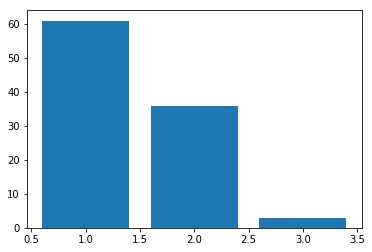

In [15]:
pyplot.bar([1,2,3],[sum([x==1 for x in estim_m_3_previous_1000]),sum([x==2 for x in estim_m_3_previous_1000]),sum([x==3 for x in estim_m_3_previous_1000])])

In [16]:
[sum([x==1 for x in estim_m_3_previous_1000]),sum([x==2 for x in estim_m_3_previous_1000]),sum([x==3 for x in estim_m_3_previous_1000])]

[61, 36, 3]

In [ ]:
len(estim_m_3_previous_10000)

In [ ]:
import scipy.stats as st

In [ ]:
st.t.interval(
    0.95,
    len(estim_m_3_previous_10000[:100]) - 1,
    loc=np.mean(estim_m_3_previous_10000[:100]),
    scale=st.sem(estim_m_3_previous_10000[:100]))